In [1]:
import torch
import torch.nn as nn
# from generate_data import *
import matplotlib.pyplot as plt
import numpy as np
import math 
from load_matlab_timedata import get_data_from
import sklearn.preprocessing 
from tqdm import tqdm_notebook as tqdm
import random
import yaml
import h5py
from torch.utils.data import Dataset, DataLoader, SequentialSampler, BatchSampler
import logging
import datetime
import os
import time
import torch.nn.functional as F
from src.TSGenerator import f_Y, f_X, get_func_timeseries
from src.DataLoader import TimeSeriesDataset
from src.model_utils import init_logger, plot_shared_scale, plot_multiscale
from src.Model import LSTM
from src.Losses import myLoss, y_k_from_y_k_m1
import pprint

In [2]:
! ls DC_motor_simulation

dc_engine_random_sig_const_periods.slx
dc_engine_random_sig_random_period_gaus_noise.slx
dc_engine_random_sig_random_period_gaus_noise.slx.autosave
dc_engine_random_sig_random_period_gaus_noise.slxc
dc_engine_random_sig_random_period.slx
dc_engine_random_sig_random_period.slxc
dc_engine_random_sig_random_period.slx.original
DC_motor_simulation.prj
diff_eq_system.slx
diff_eq_system.slx.original
res.mat
resources
slprj


In [3]:
plt.rcParams['figure.figsize'] = 20, 7.

In [4]:
CONFIG_FILENAME = "model_params.yaml"

In [5]:
with open(CONFIG_FILENAME, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

In [6]:
to_generate_data = config['to_generate_data']
if to_generate_data:
    p_gen = config['generator_params']
    a = p_gen['a']
is_debug = config['is_debug']
if is_debug:
    p_generate = config['generator_params']
    pprint.pprint(p_generate)
    

In [7]:
pprint.pprint(config)

{'data_params': {'leave_nth': 13,
                 'mat_file': 'DC_motor_simulation/res.mat',
                 'need_normalize': True,
                 'test_size': 0.3},
 'exp_path': 'only_batches',
 'generator_params': {'a': 0.5, 'b': 1.0, 'f_X': 'math.sin', 'f_Y': 'math.cos'},
 'is_debug': False,
 'network_params': {'dtype': 'torch.float',
                    'hidden_size': 32,
                    'input_size': 64,
                    'num_layers': 1,
                    'output_dim': 3,
                    'per_element': True,
                    'retrospective_steps': 128},
 'to_generate_data': False,
 'train_params': {'batch_size': 1024,
                  'learning_rate': 0.01,
                  'loss_fn': 'mse',
                  'num_epochs': 150,
                  'optimizer': 'adam',
                  'reduction': 'sum'}}


In [8]:
p_data = config['data_params']
pprint.pprint(p_data)
need_normalize = p_data['need_normalize']

{'leave_nth': 13,
 'mat_file': 'DC_motor_simulation/res.mat',
 'need_normalize': True,
 'test_size': 0.3}


In [9]:
p_net = config['network_params']
pprint.pprint(p_net)

{'dtype': 'torch.float',
 'hidden_size': 32,
 'input_size': 64,
 'num_layers': 1,
 'output_dim': 3,
 'per_element': True,
 'retrospective_steps': 128}


In [10]:
p_train = config['train_params']
pprint.pprint(p_train)

{'batch_size': 1024,
 'learning_rate': 0.01,
 'loss_fn': 'mse',
 'num_epochs': 150,
 'optimizer': 'adam',
 'reduction': 'sum'}


In [11]:
p_gen = config['generator_params']
a = p_gen['a']
b = p_gen['b']

In [12]:
if is_debug:
    x, y = get_func_timeseries(f_Y = f_Y, f_X = f_X, a=p_generate['a'], b=p_generate['b'])

In [13]:
#####################
# Set parameters
#####################
# # If `per_element` is True, then LSTM reads in one timestep at a time.
if  p_net['per_element']:
    lstm_input_size = 1
else:
    lstm_input_size = p_net['input_size']

In [14]:
init_logger(config)

logger inited to file [only_batcheslogs/exp_2019-04-25_14:30:42.log]


In [15]:
logging.info("Experiment started with params")
logging.info(f"data_par: {p_data}")
logging.info(f"net_par: {p_net}")
logging.info(f"train_par: {p_train}")

X normalized, norms: [14.99712541]
x shaoe (76924,)
x_normalized shaoe (76924, 1)
test (76924, 1)


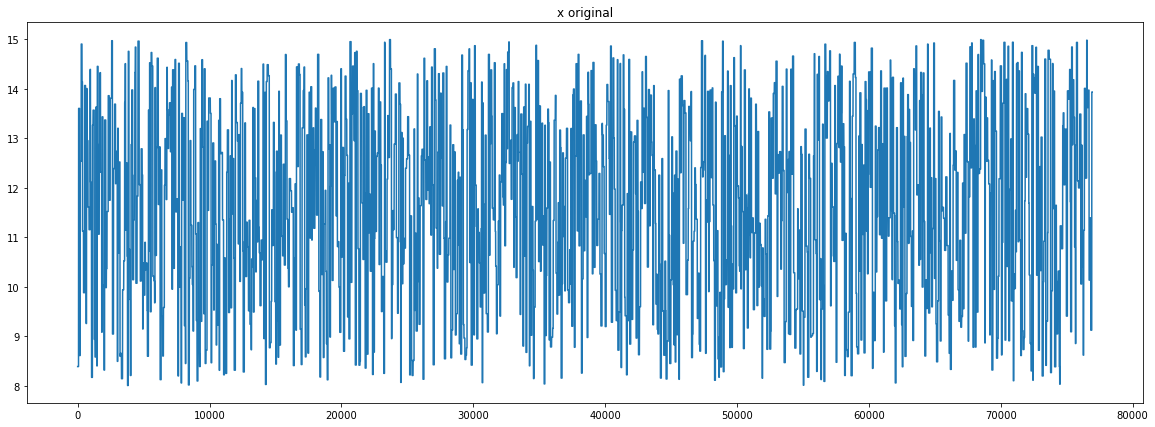

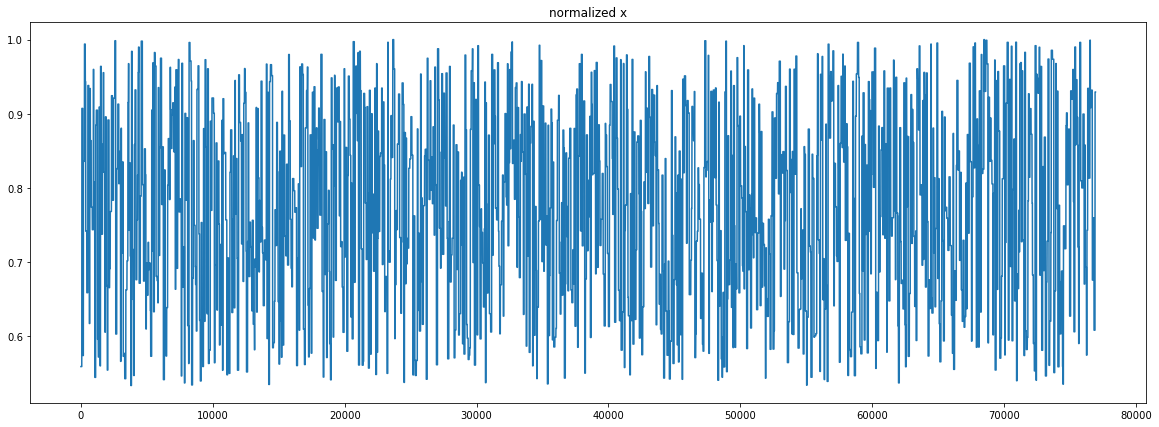

Y normalized, norms: [0.01499693]
input shape (76924, 1)
input partition shape (23078, 1)
output partition shape (23078, 1)
stacked Y shape  (22950, 3)
Y_tensor torch.Size([22950, 3])
X_tensor torch.Size([128, 22949, 1])


In [16]:
test_ts_ds = TimeSeriesDataset(config=config,
                               partition=(1 - p_data['test_size'], 1),                        
                               logging=logging)

X normalized, norms: [14.99712541]
x shaoe (76924,)
x_normalized shaoe (76924, 1)
test (76924, 1)


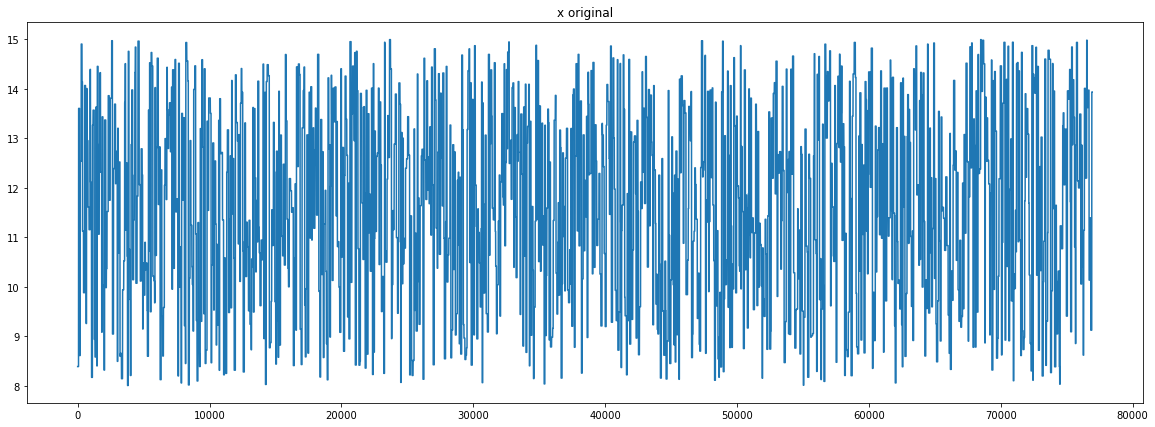

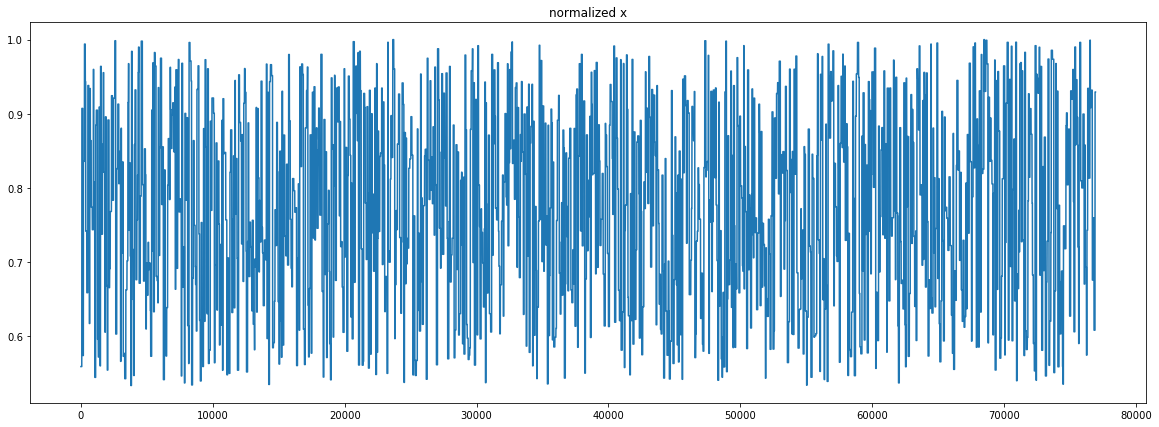

Y normalized, norms: [0.01499693]
input shape (76924, 1)
input partition shape (53846, 1)
output partition shape (53846, 1)
stacked Y shape  (53718, 3)
Y_tensor torch.Size([53718, 3])
X_tensor torch.Size([128, 53717, 1])


In [17]:
train_ts_ds = TimeSeriesDataset(config=config,
                                partition=(0, 1 - p_data['test_size']),
                                logging=logging)

In [18]:
if need_normalize:
    config['x_norm'] = train_ts_ds.x_norms
    config['y_norm'] = train_ts_ds.y_norms
    config['x_norm']

In [19]:
train_dl = DataLoader(dataset = train_ts_ds,
                      batch_sampler = BatchSampler(
                          sampler = SequentialSampler(train_ts_ds), 
                          batch_size = p_train['batch_size'],
                          drop_last = True)
                     )
test_dl = DataLoader(dataset = test_ts_ds,
                     batch_sampler = BatchSampler(
                     sampler = SequentialSampler(test_ts_ds), 
                     batch_size = p_train['batch_size'], 
                     drop_last = True)
                    )

In [20]:
## Inspecting data we have

In [21]:
len(train_dl)

52

x :torch.Size([1024, 128, 1])
y: torch.Size([1024, 3])
y_last: (150,)


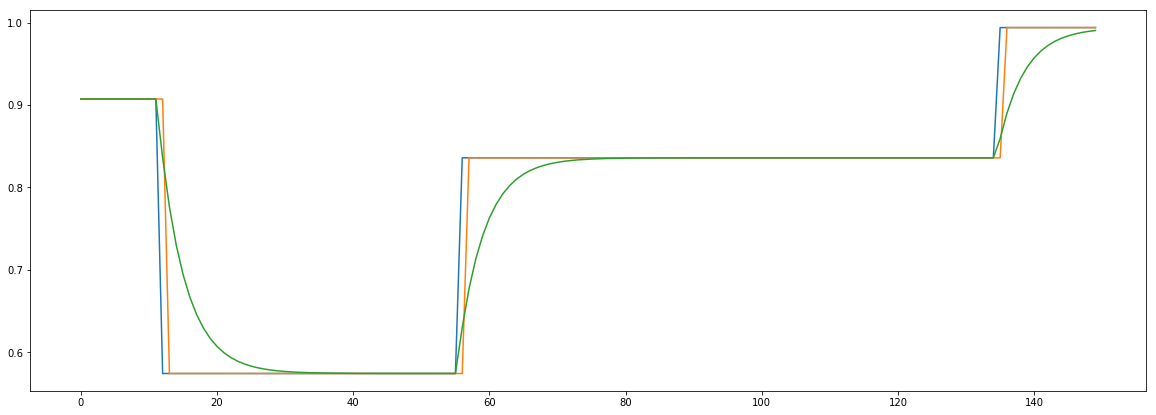

x :torch.Size([1024, 128, 1])
y: torch.Size([1024, 3])
y_last: (150,)


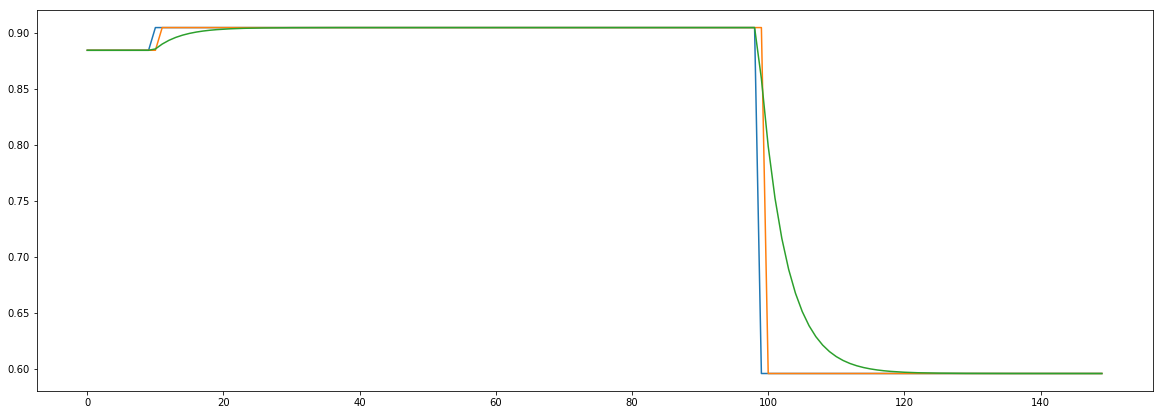

In [22]:
f, t = 0, 150
for i, batch in enumerate(train_dl):
    x, y, ind = batch
    print(f"x :{x.shape}")
    print(f"y: {y.shape}")
    y_kth = y.detach().numpy()[f:t, 0]
    print(f"y_last: {y_kth.shape}")
    x = x.transpose(0,1)
    plt.plot(x.detach().numpy()[-1][f:t])
    plt.plot(x.detach().numpy()[-2][f:t])
    plt.plot(y_kth)
    plt.show()
    if i == 1:
        break

In [23]:
model = LSTM(lstm_input_size,
             p_net['hidden_size'],
             batch_size=p_train['batch_size'],
             output_dim=p_net['output_dim'],
             num_layers=p_net['num_layers'])

loss_fn = myLoss

# if p_train['loss_fn'] == 'mse':  
#     loss_fn = torch.nn.MSELoss(reduction=p_train['reduction'])
# elif p_train['loss_fn'] == 'l1':  
#     loss_fn = torch.nn.L1Loss(reduction=p_train['reduction'])

if p_train['optimizer'] == "adam":
    optimiser = torch.optim.Adam(model.parameters(), lr=p_train['learning_rate'])

In [24]:
logging.info(f"Model n params: {model.get_num_params()}")

In [25]:
model.get_num_params()

4579.0

In [26]:
len(train_dl)

52

In [27]:
num_epochs = p_train['num_epochs']

In [28]:
logging.info("Training process START")

In [29]:
# #####################
# # Train model
# #####################
# from torch.nn import init
# for layer_p in a._all_weights:
#     for p in layer_p:
#         if 'weight' in p:
#             # print(p, a.__getattr__(p))
#             init.normal(a.__getattr__(p), 0.0, 0.02)

aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


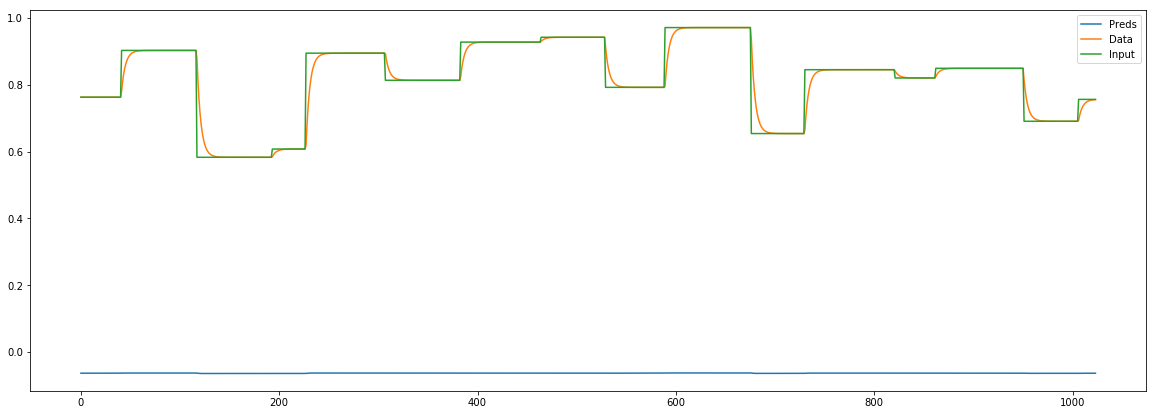

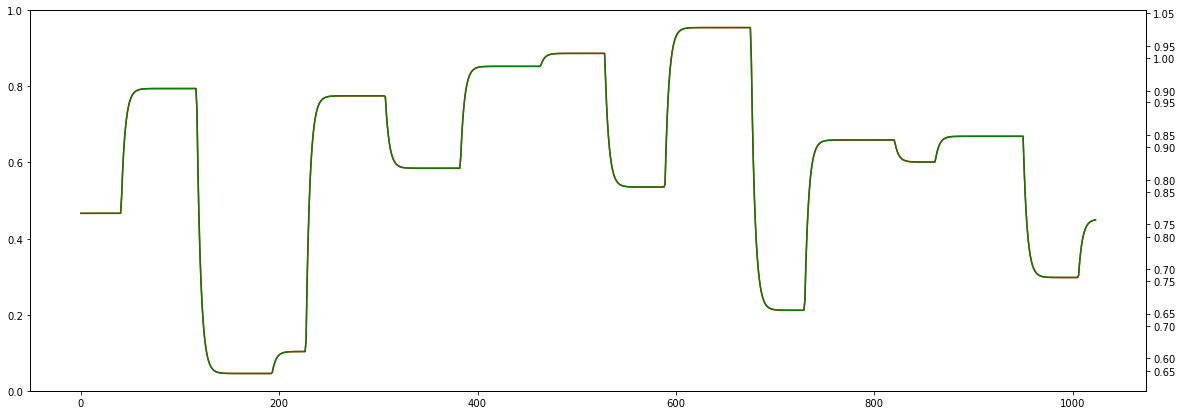

TEST AUX:


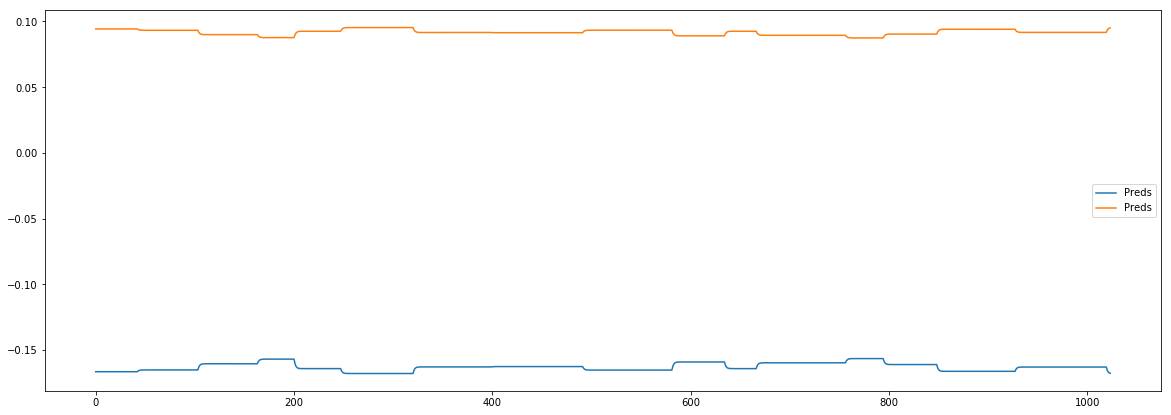

TEST PRED:


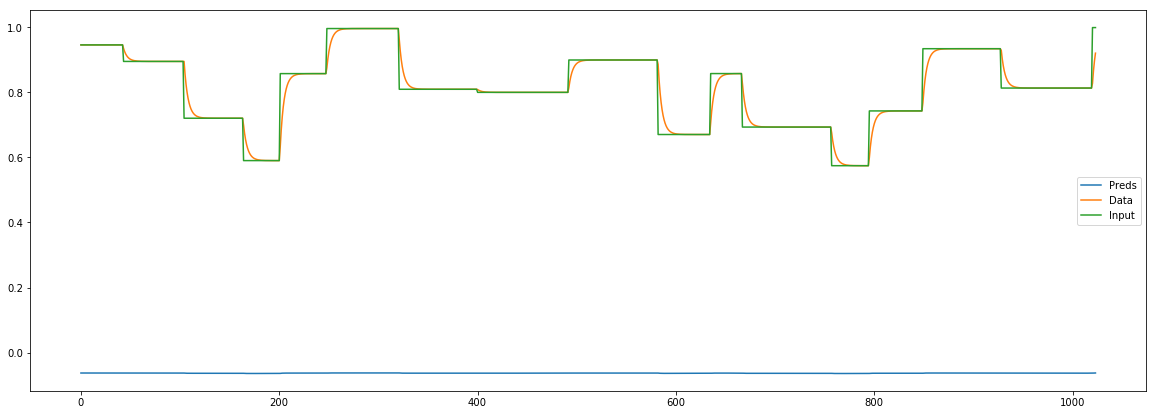

TEST RESID:


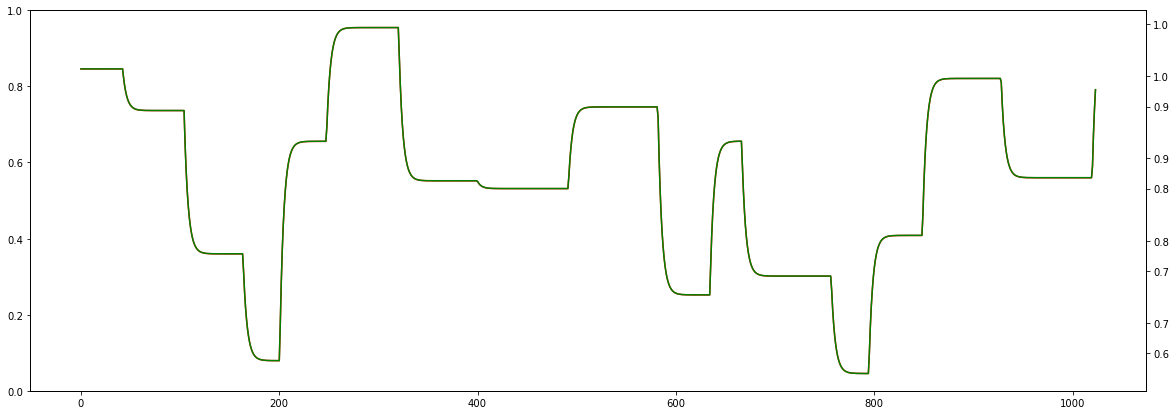

 Epoch [0]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


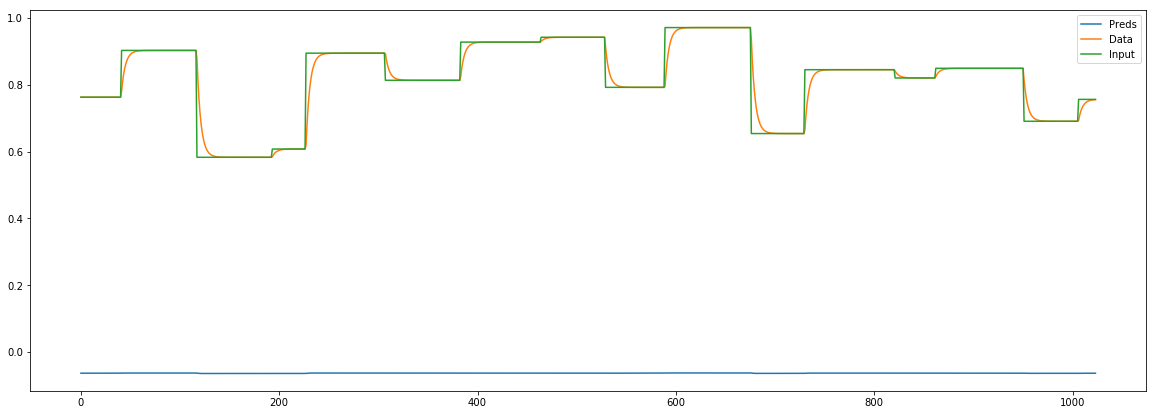

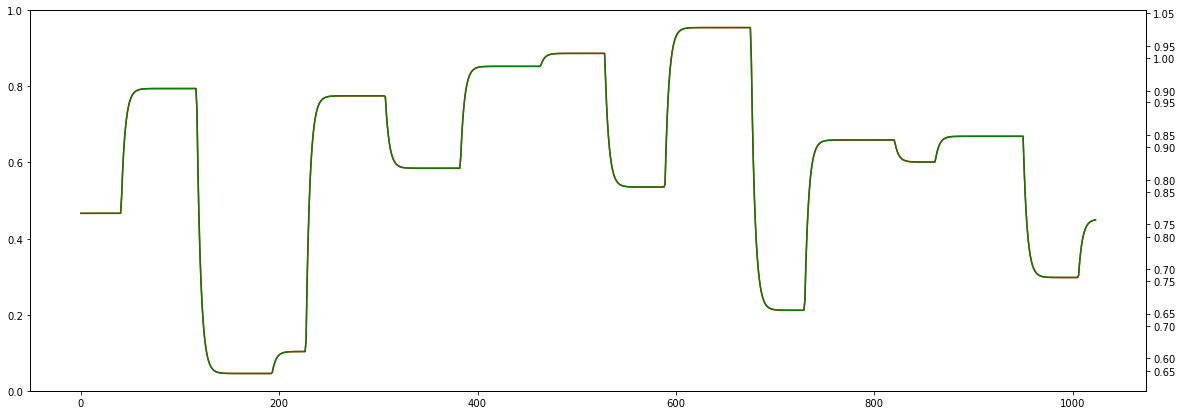

TEST AUX:


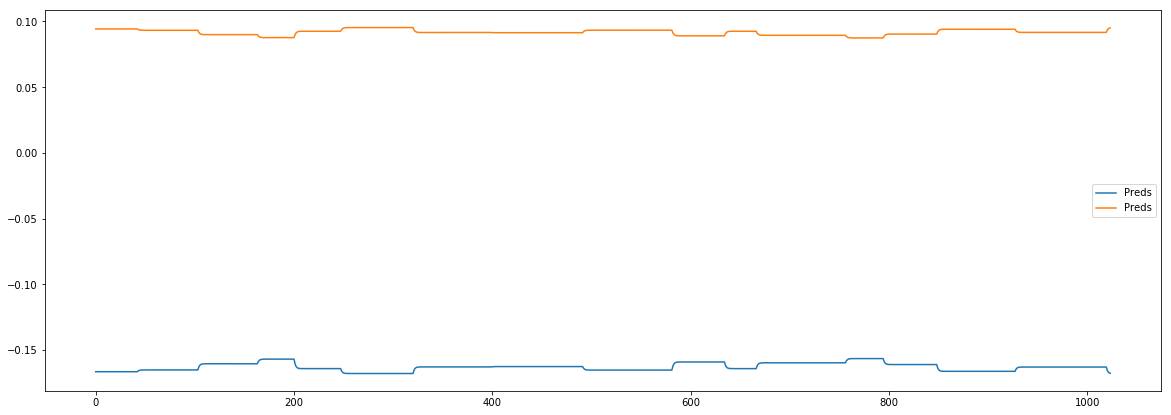

TEST PRED:


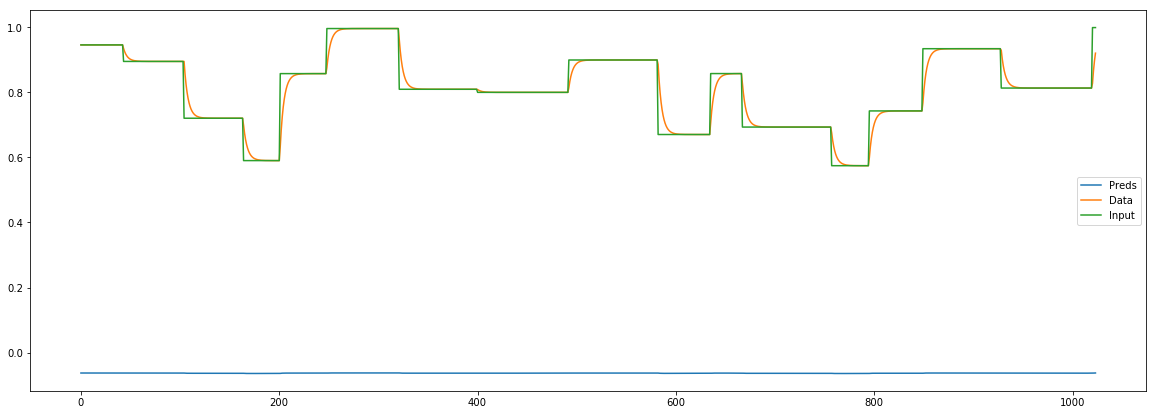

TEST RESID:


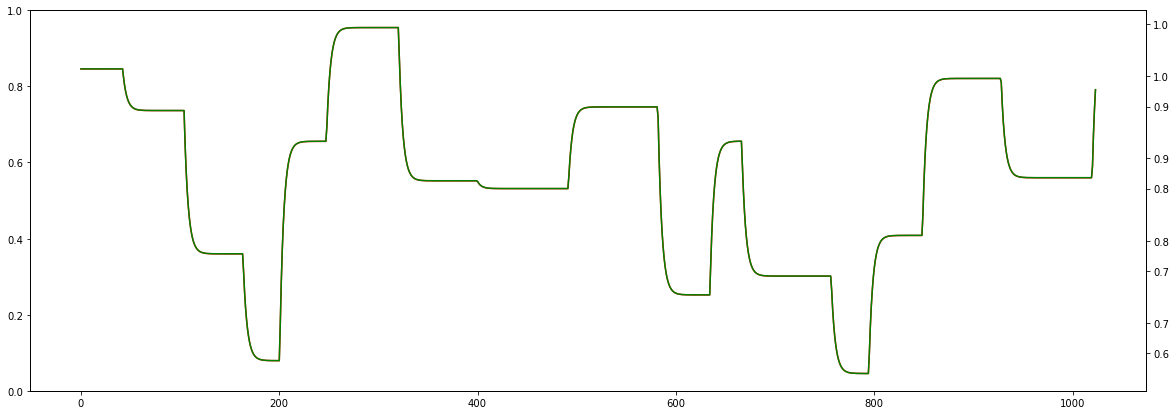

 Epoch [1]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


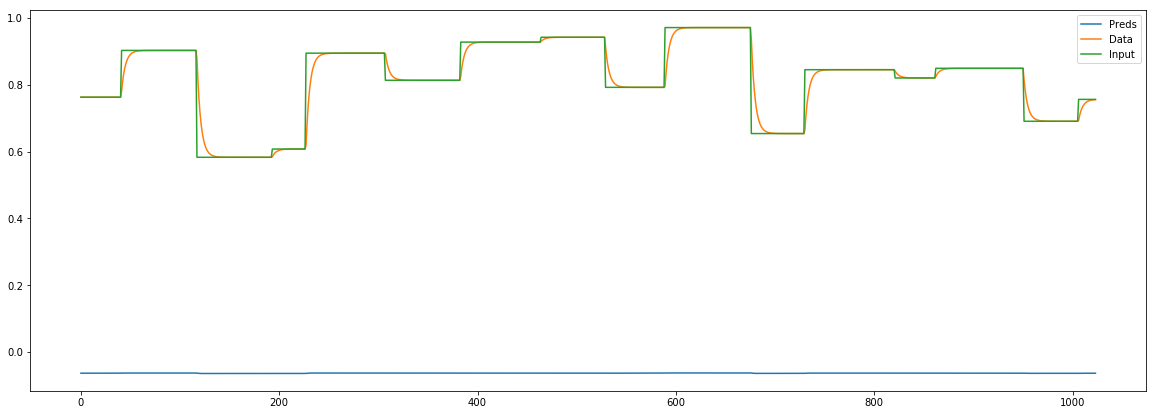

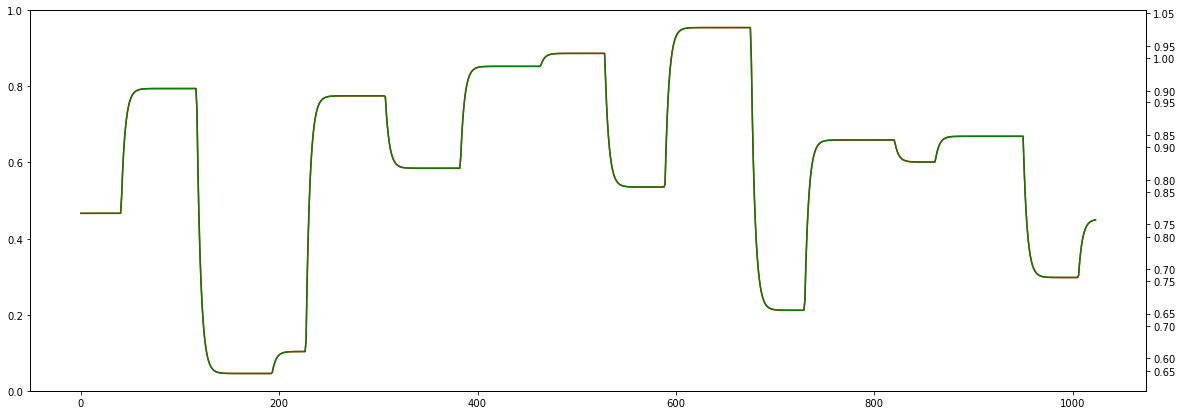

TEST AUX:


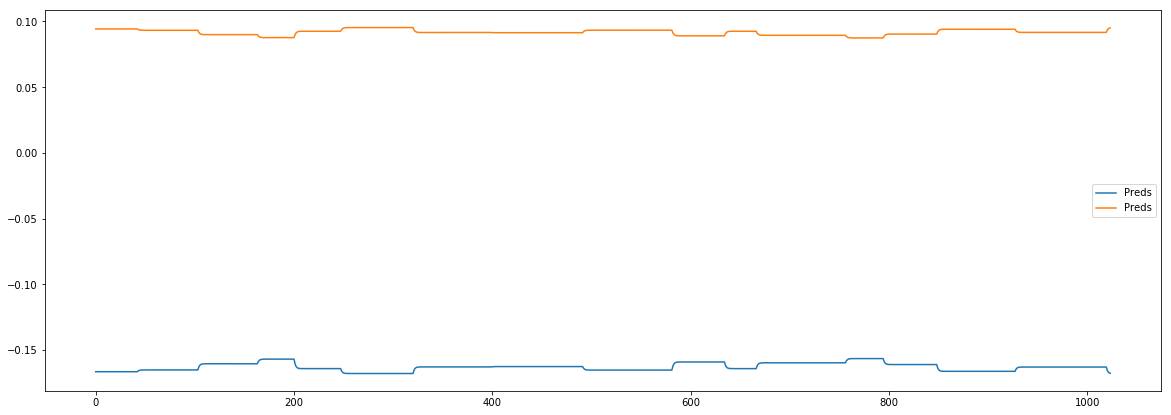

TEST PRED:


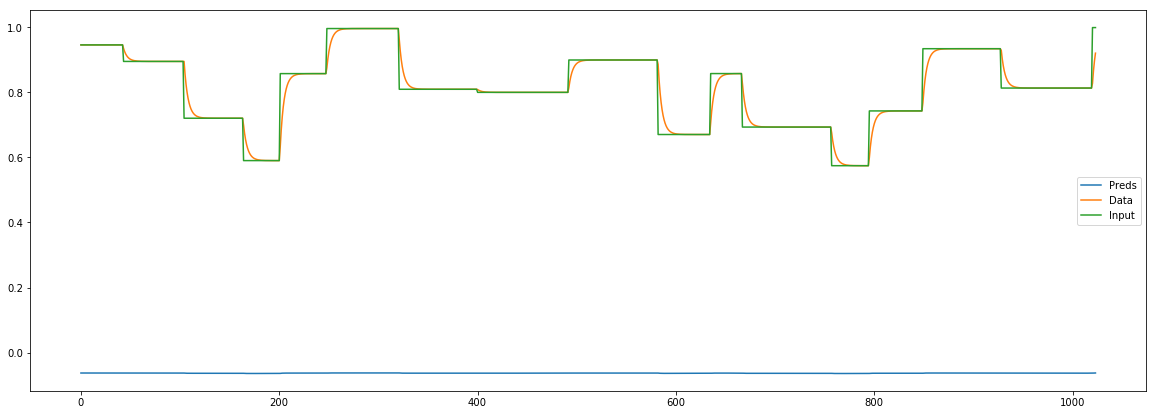

TEST RESID:


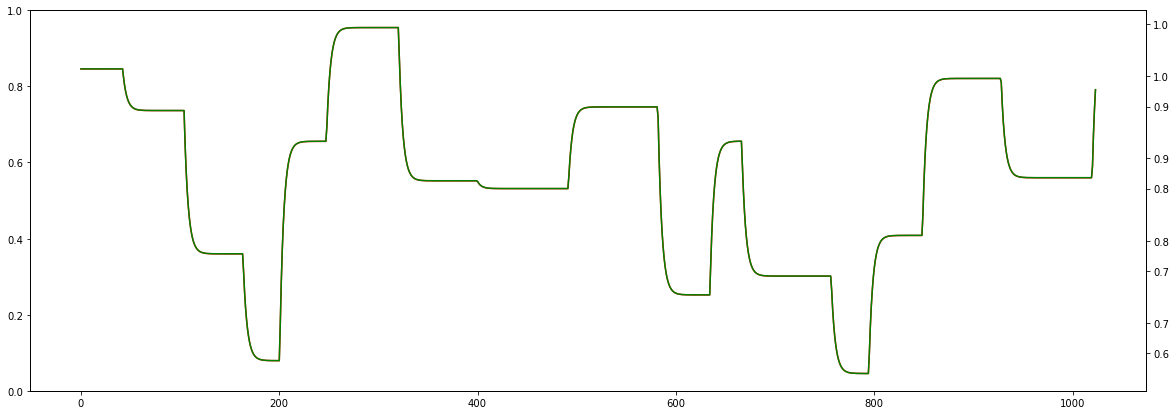

 Epoch [2]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


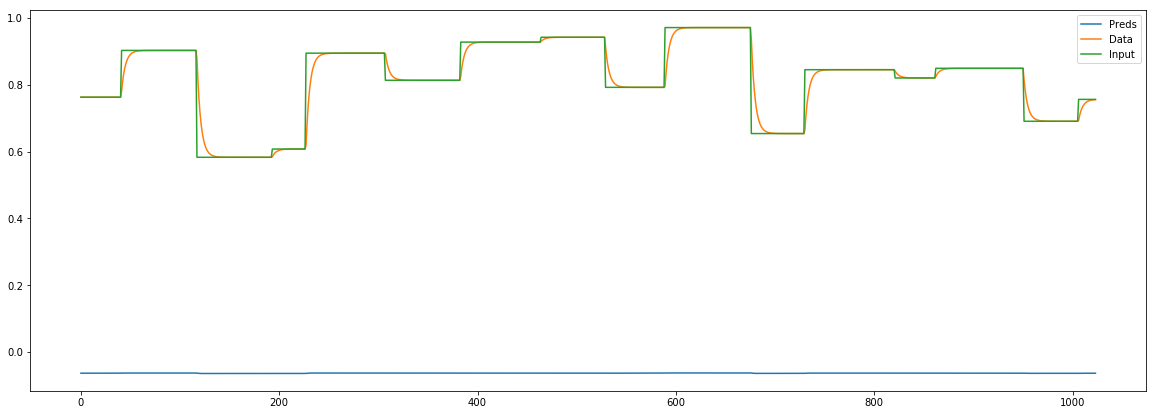

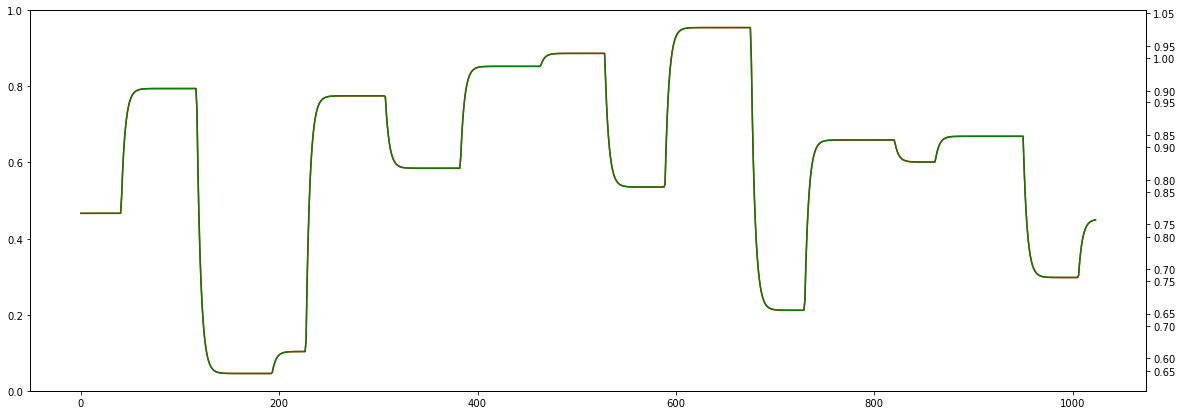

TEST AUX:


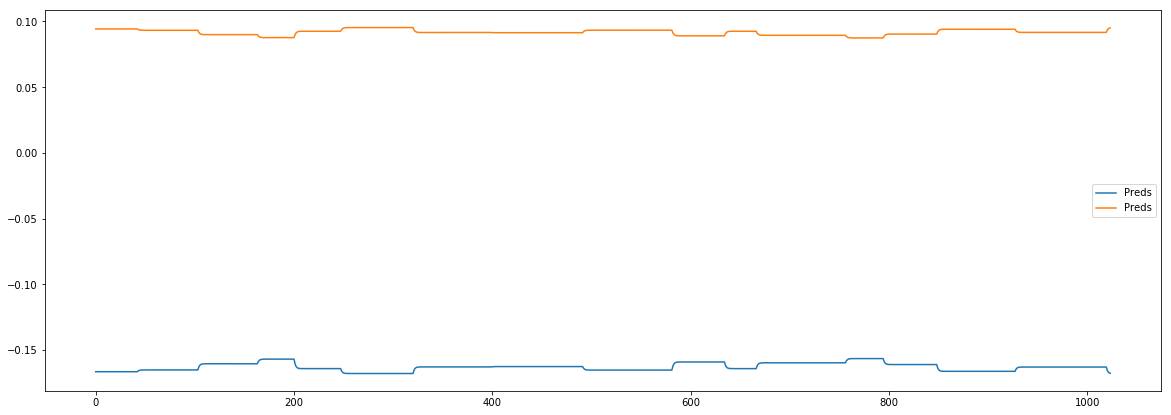

TEST PRED:


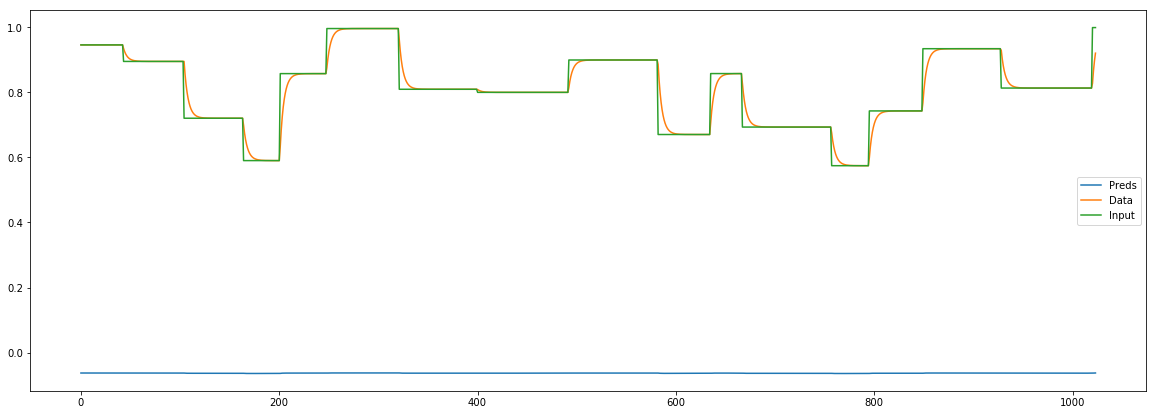

TEST RESID:


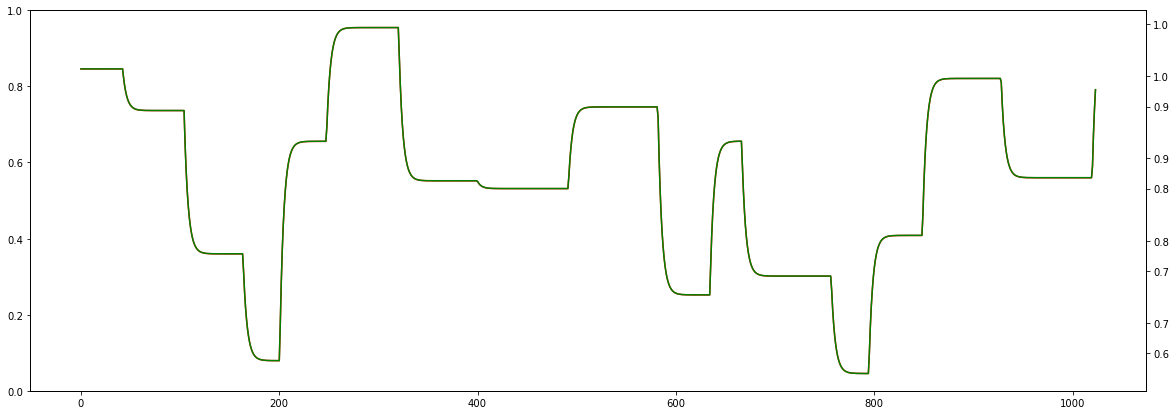

 Epoch [3]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


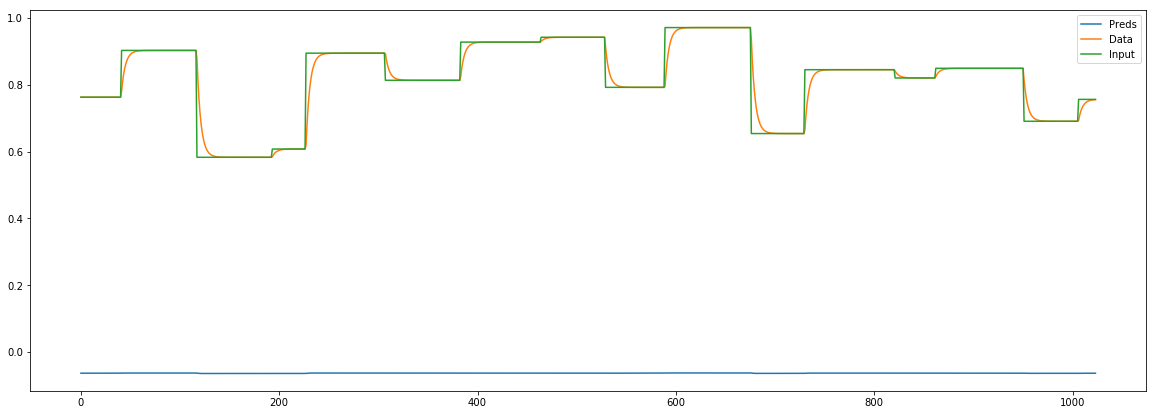

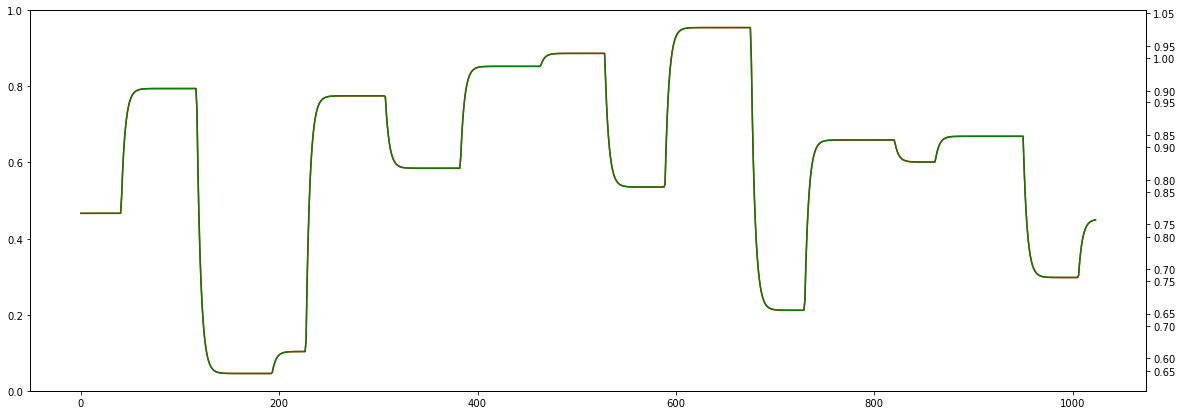

TEST AUX:


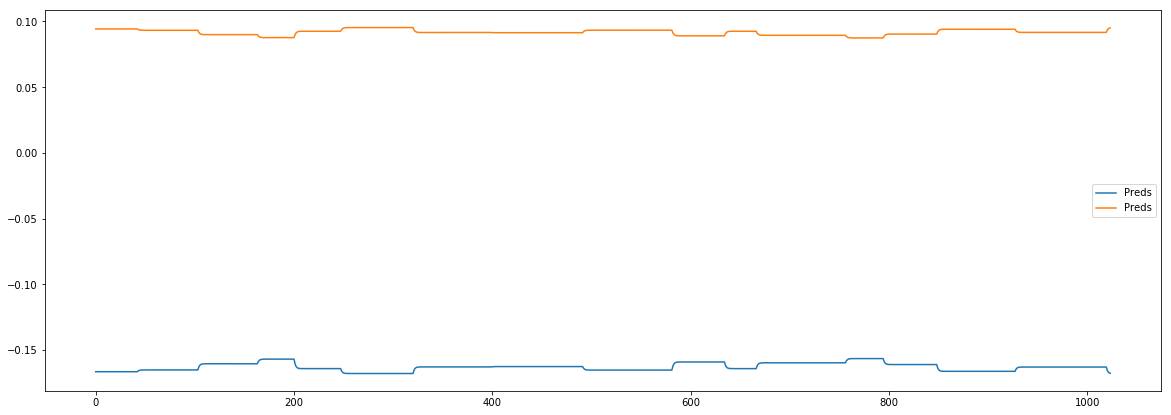

TEST PRED:


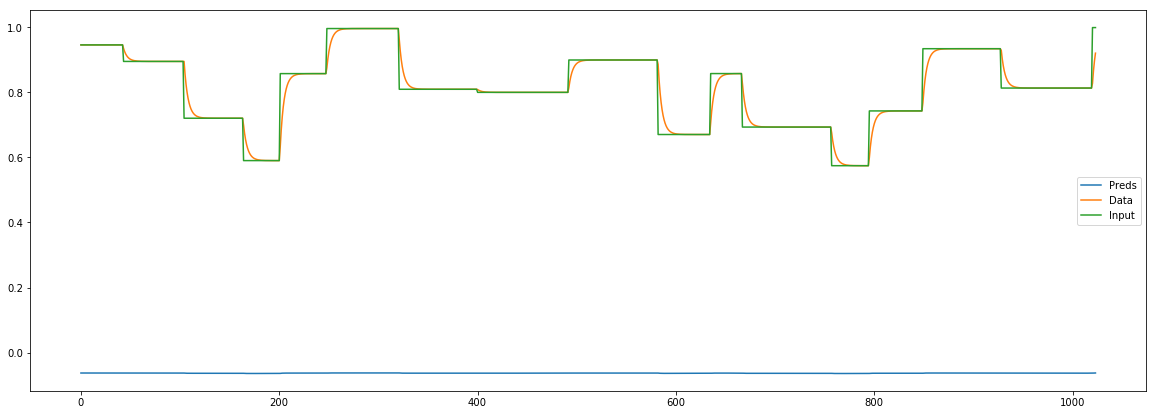

TEST RESID:


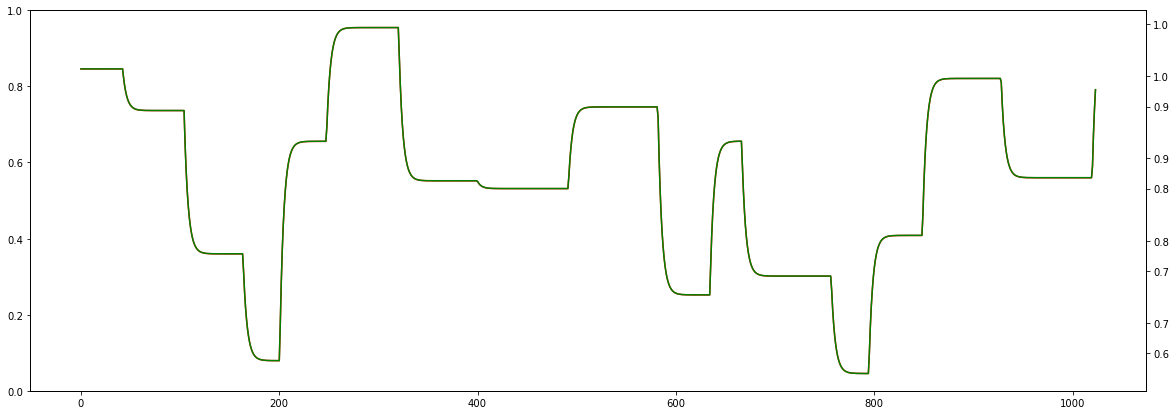

 Epoch [4]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


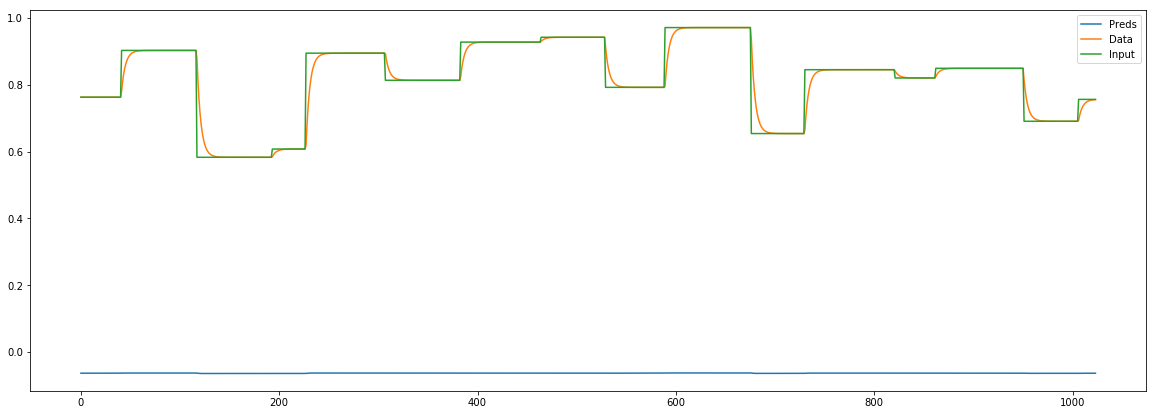

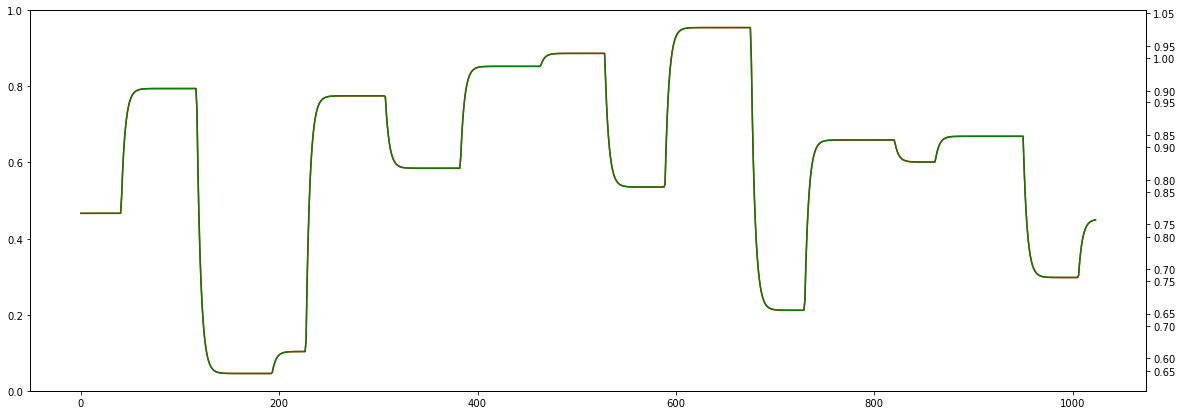

TEST AUX:


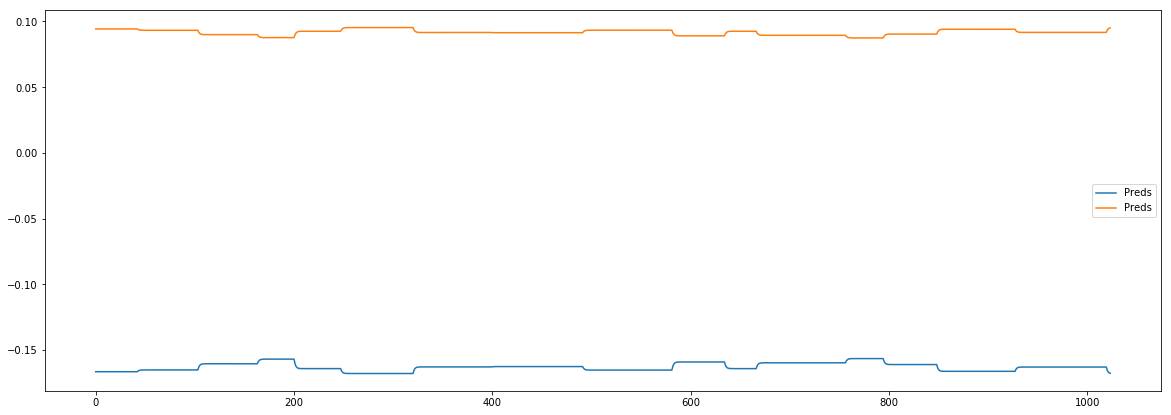

TEST PRED:


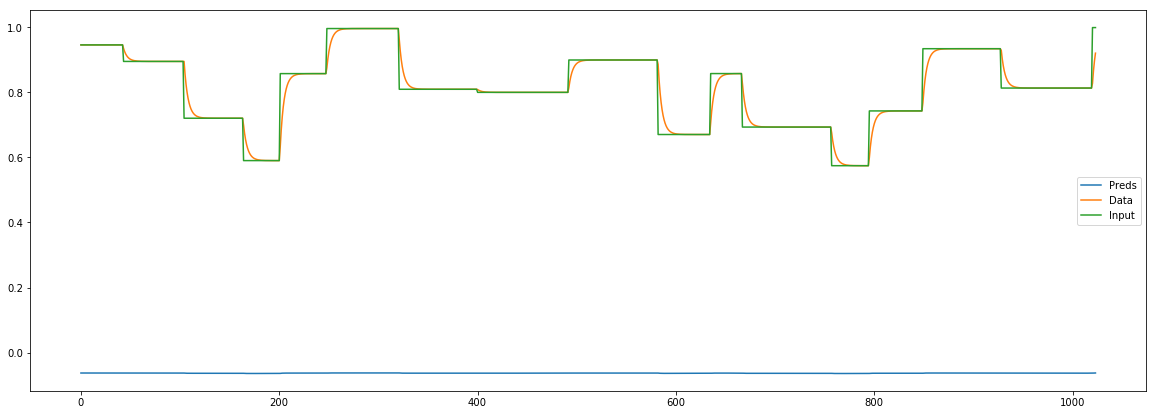

TEST RESID:


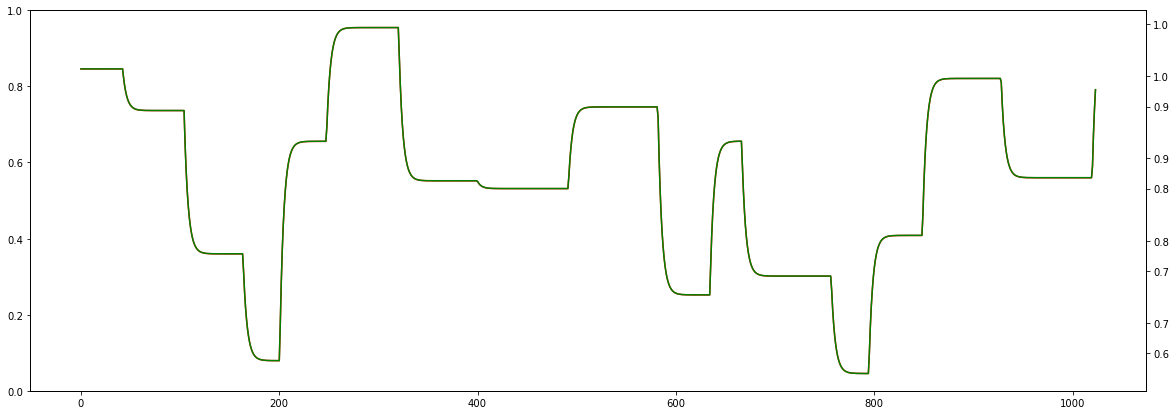

 Epoch [5]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


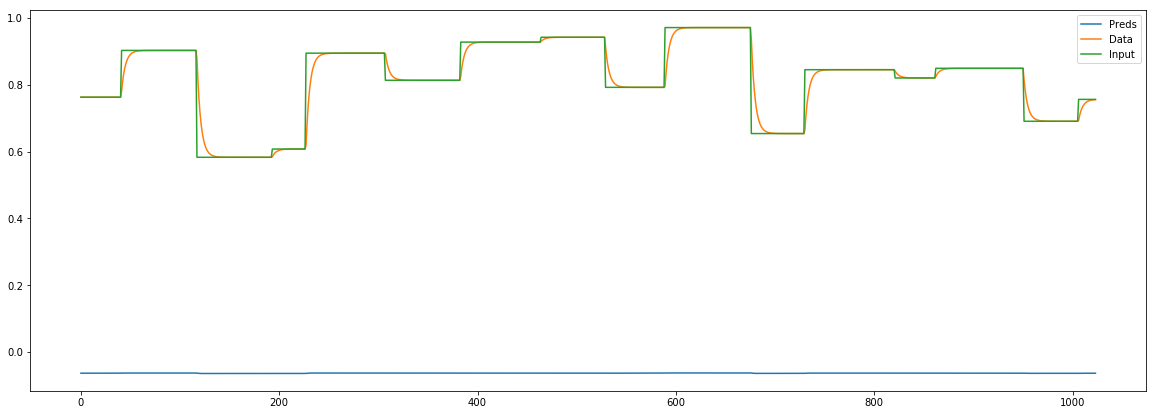

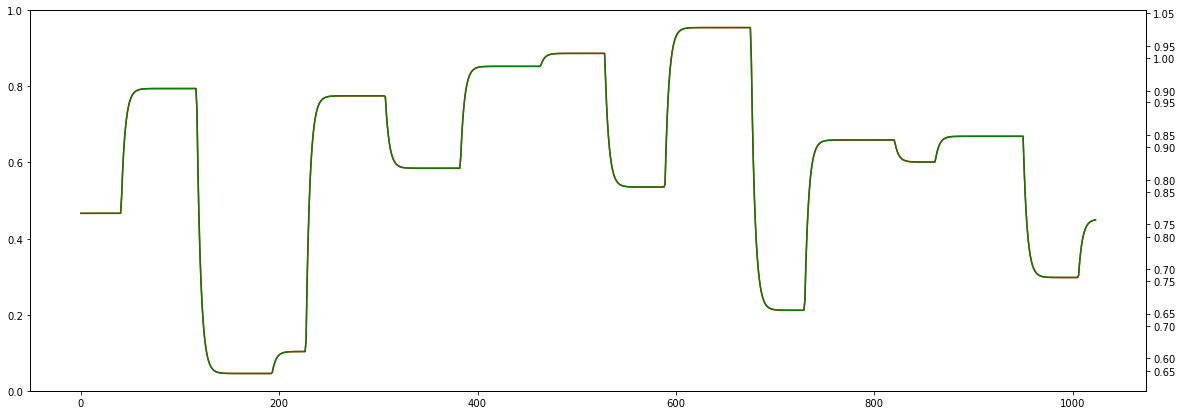

TEST AUX:


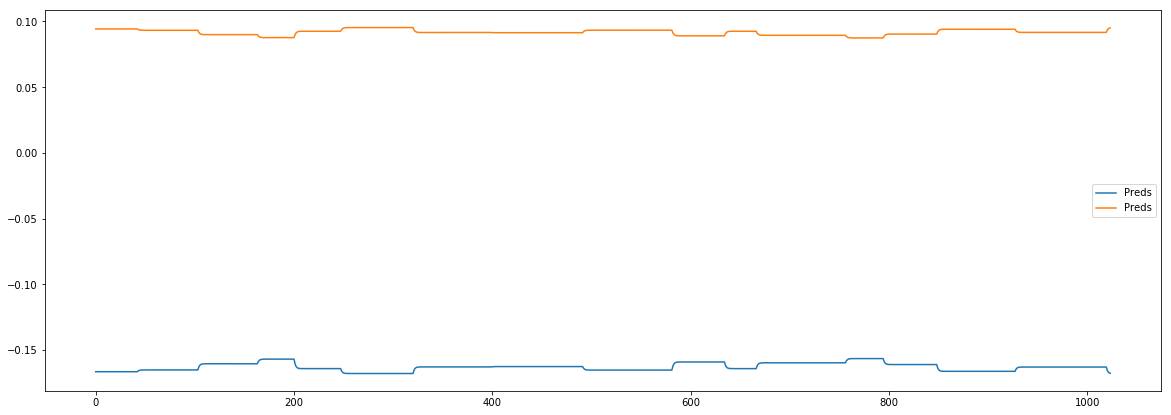

TEST PRED:


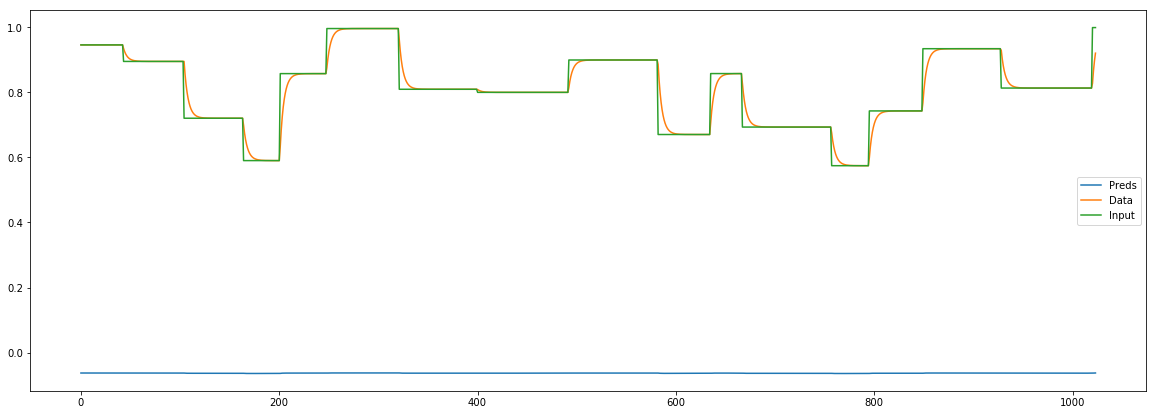

TEST RESID:


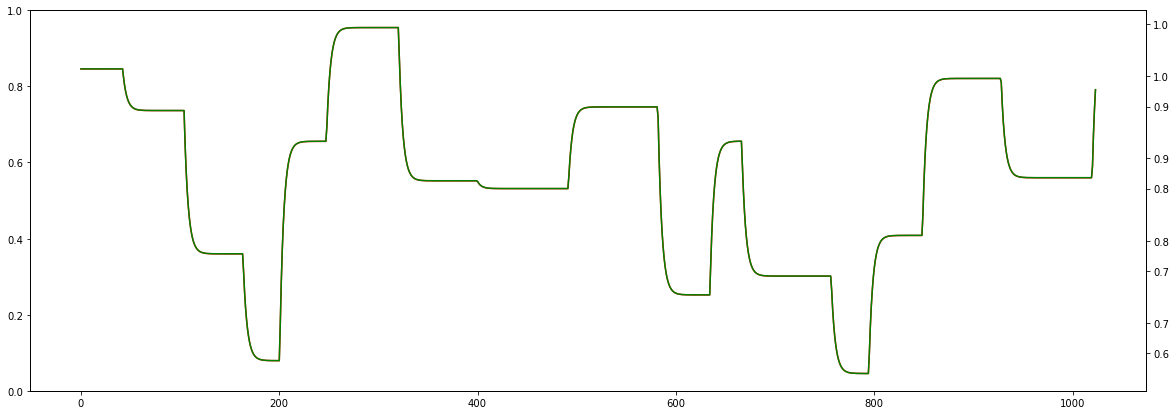

 Epoch [6]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


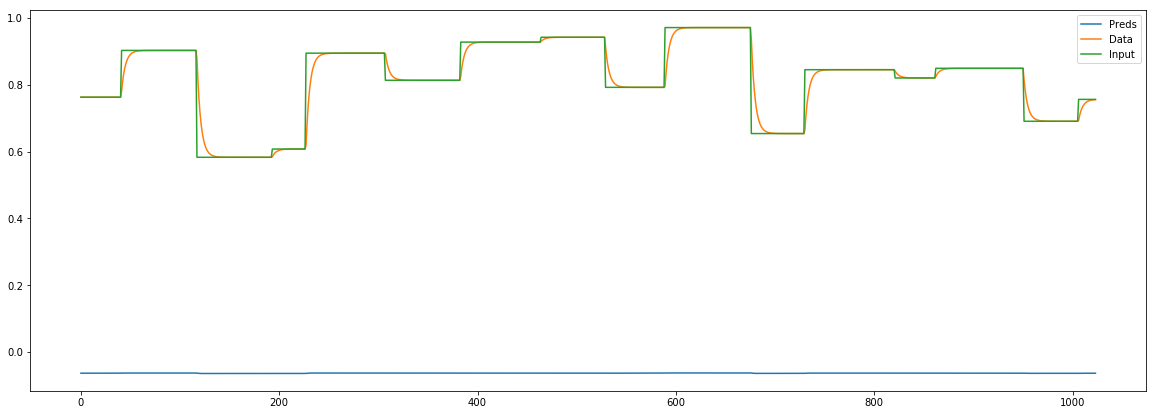

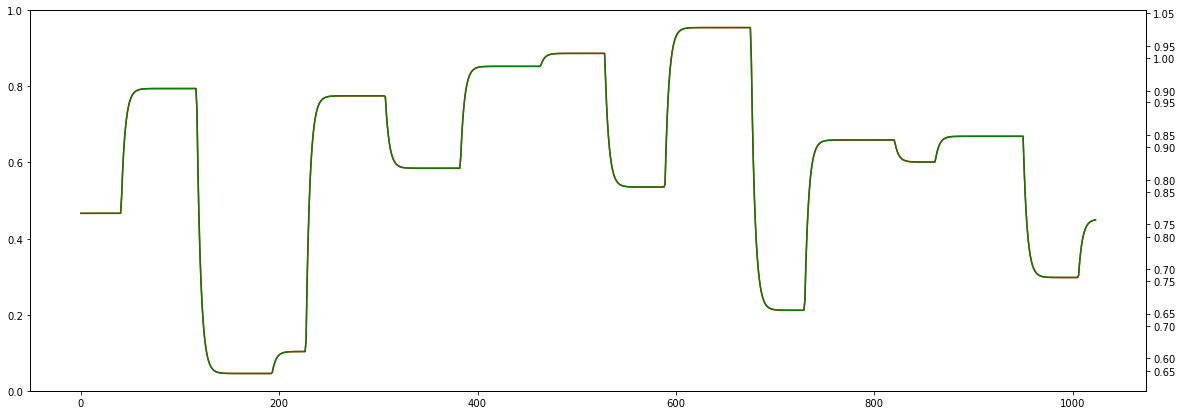

TEST AUX:


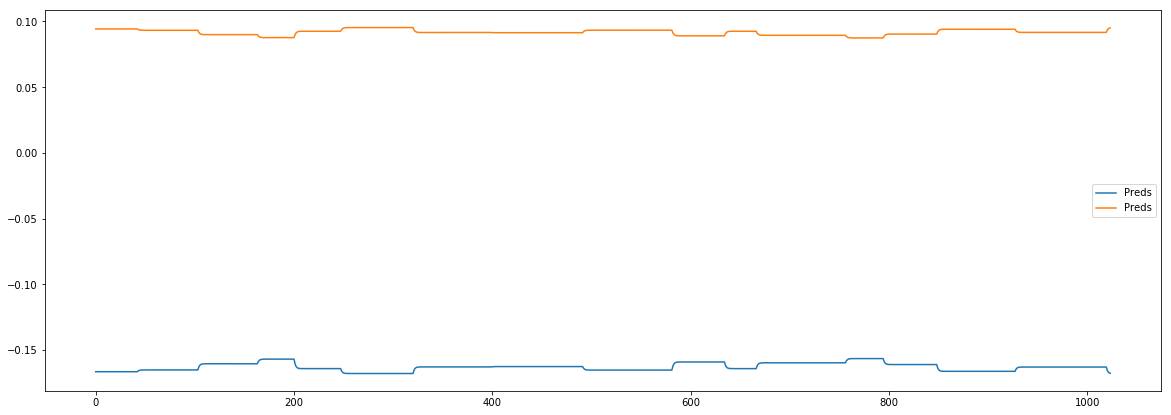

TEST PRED:


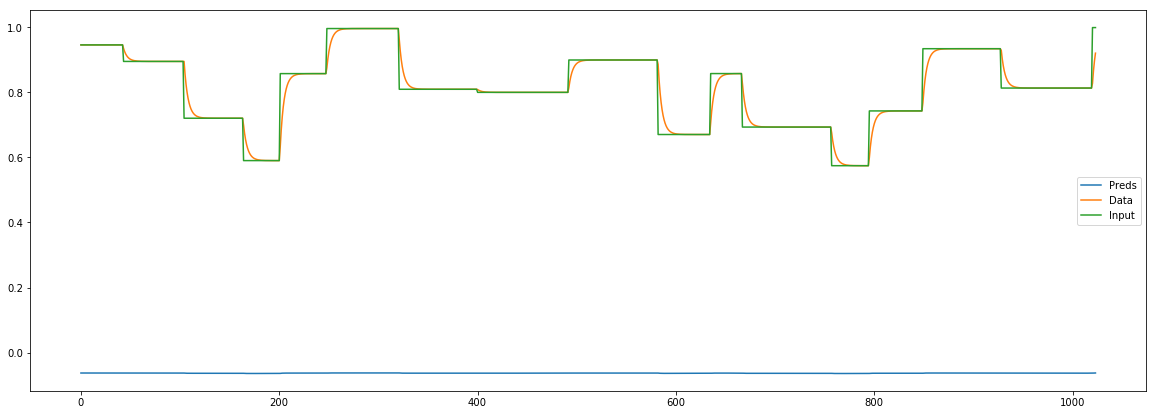

TEST RESID:


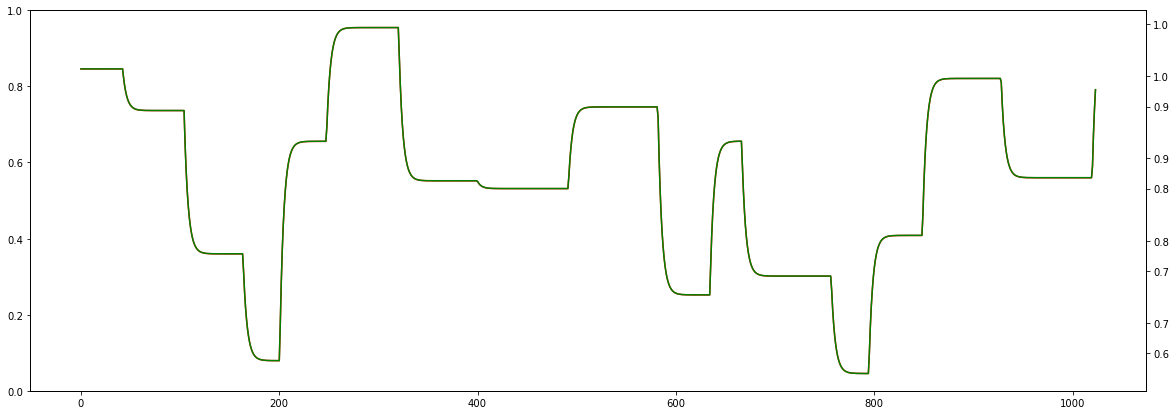

 Epoch [7]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


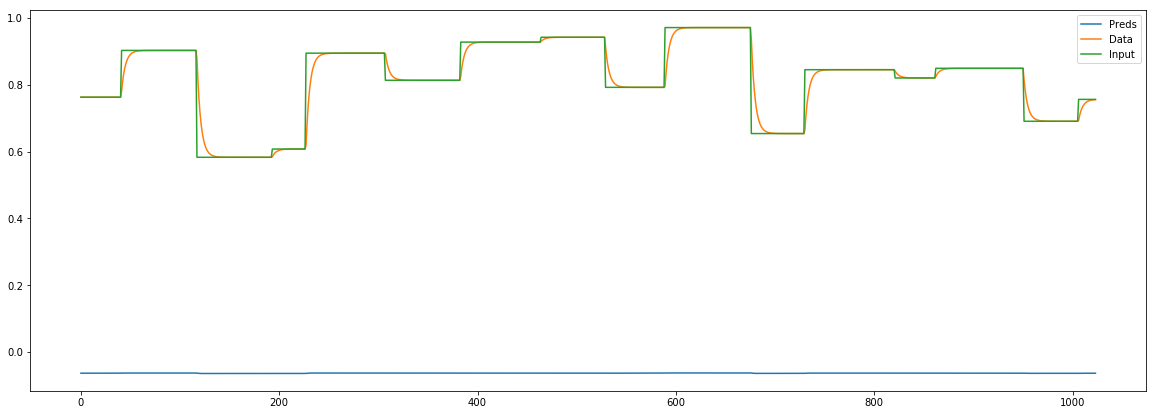

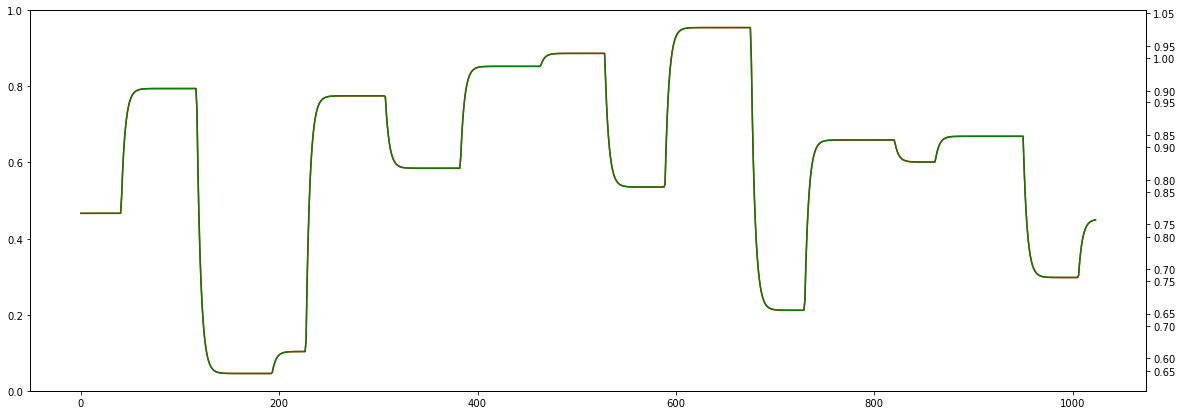

TEST AUX:


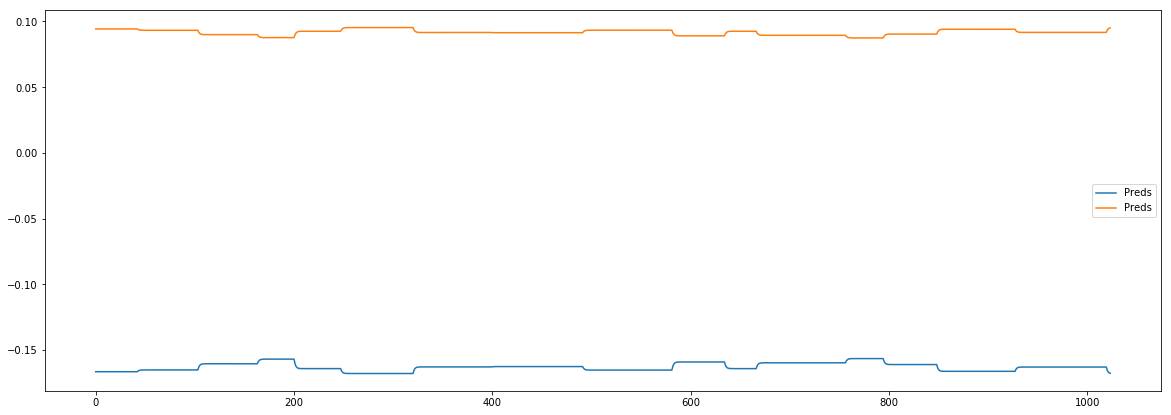

TEST PRED:


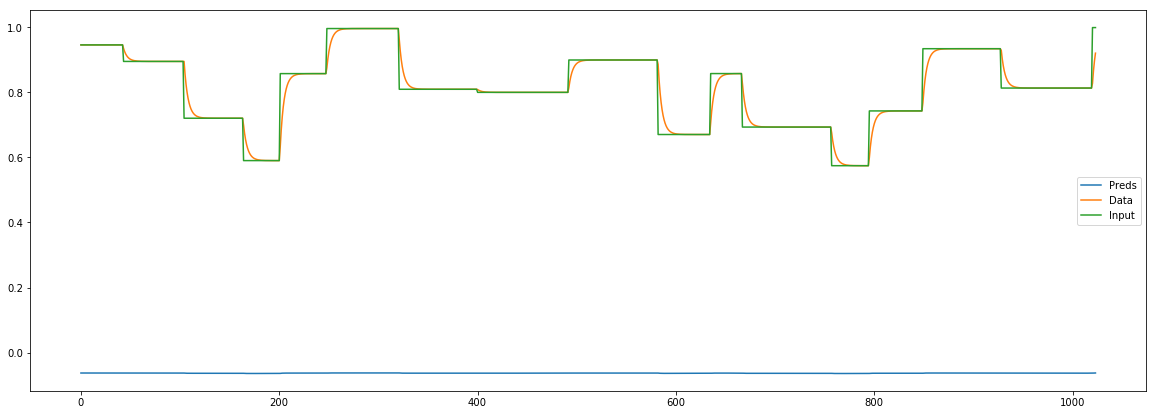

TEST RESID:


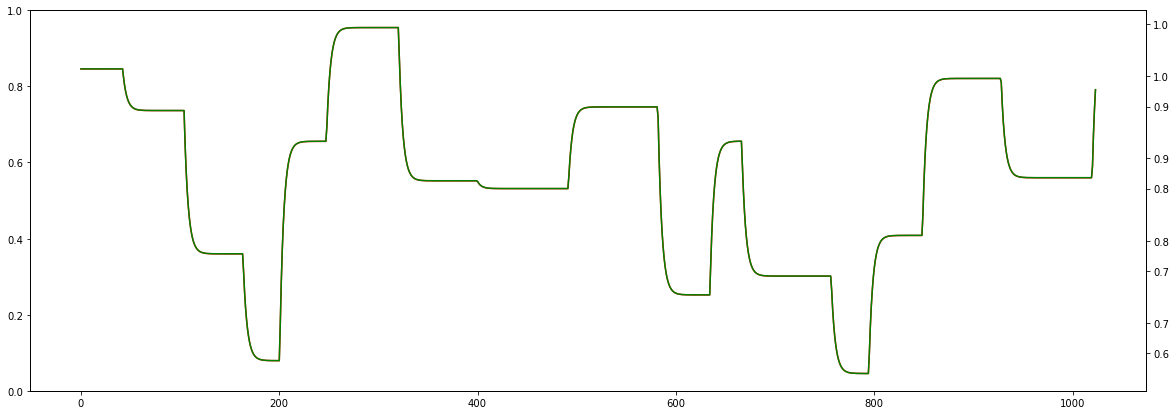

 Epoch [8]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


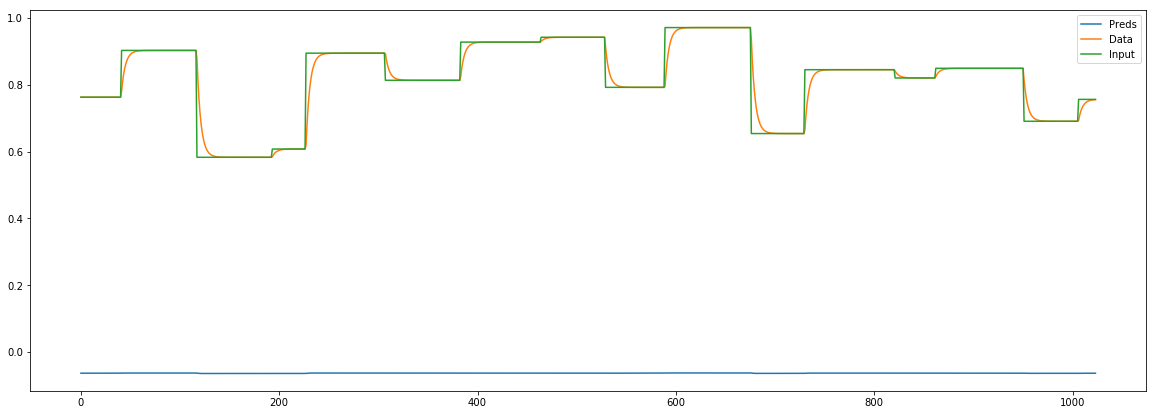

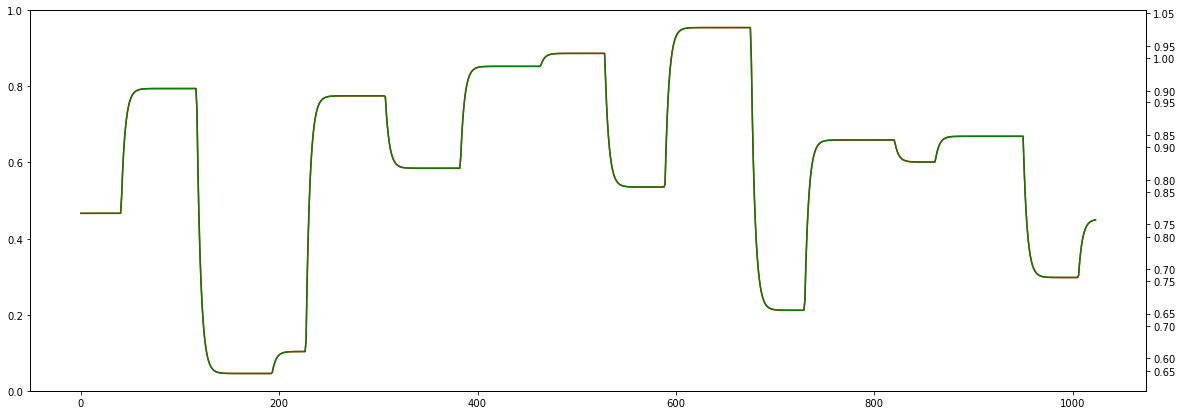

TEST AUX:


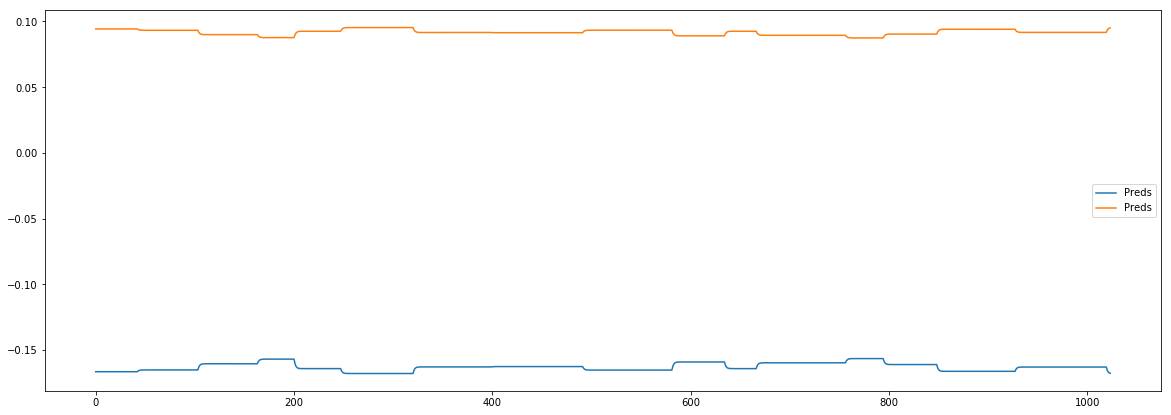

TEST PRED:


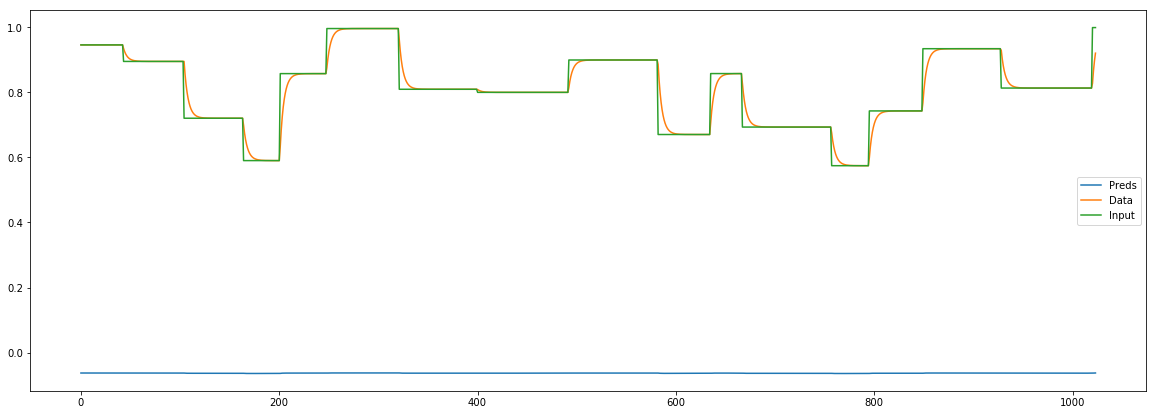

TEST RESID:


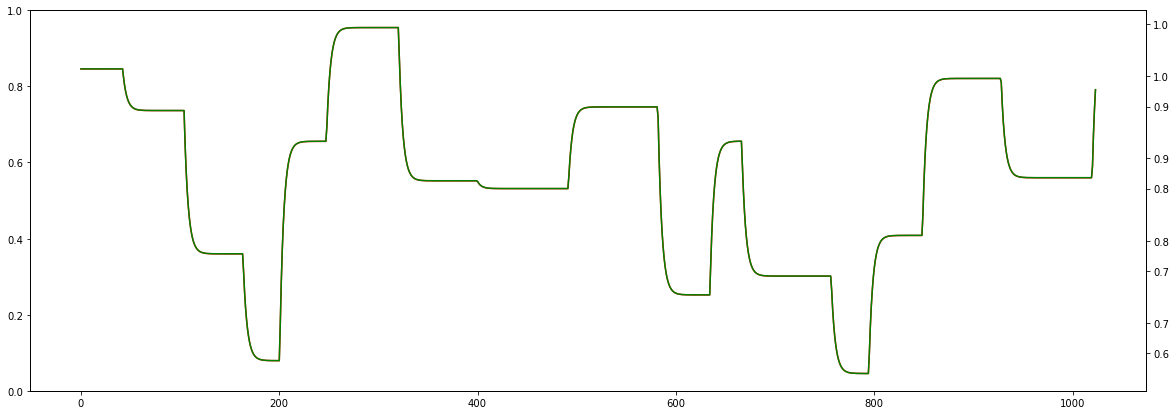

 Epoch [9]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


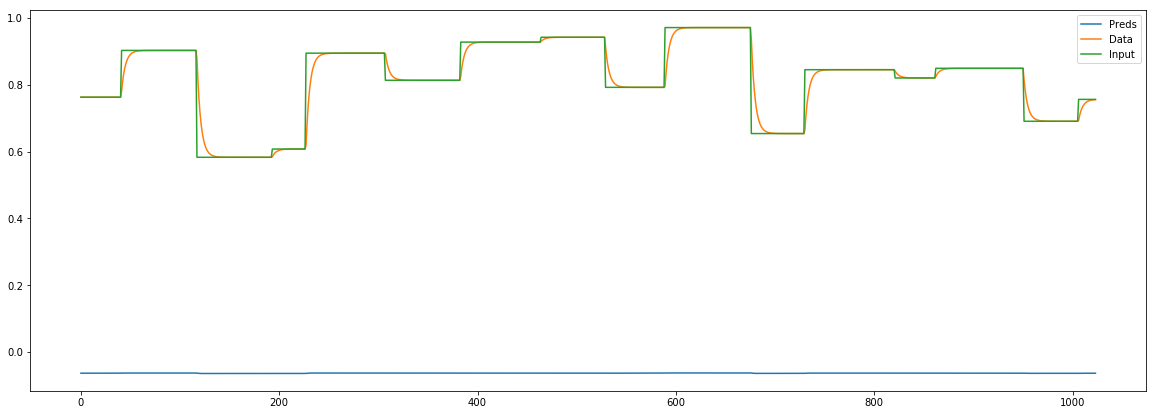

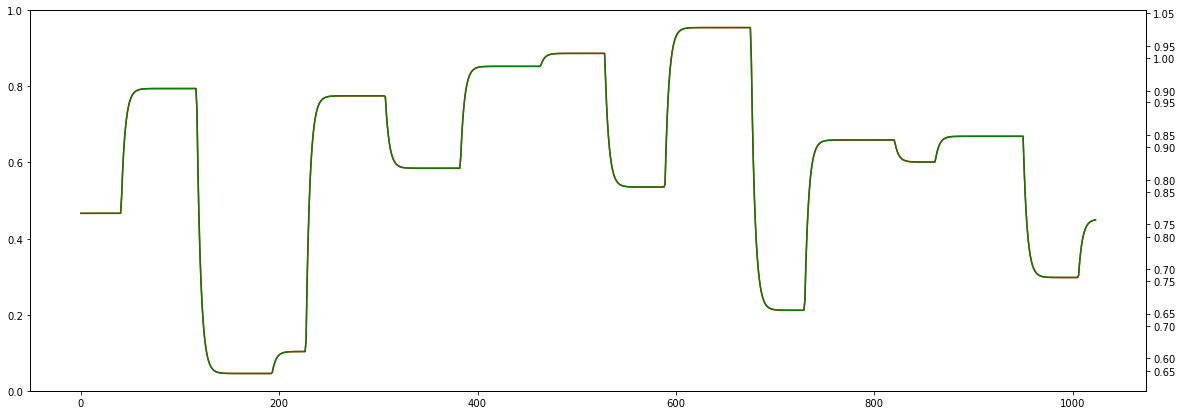

TEST AUX:


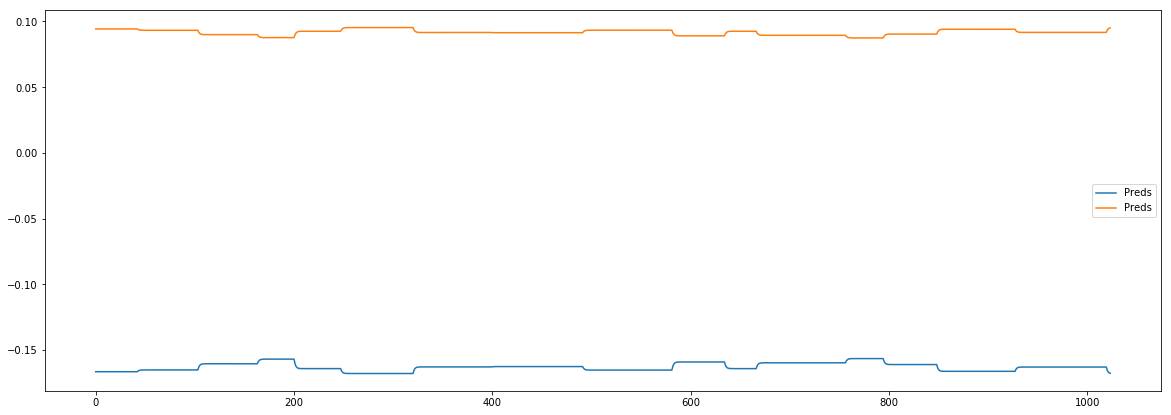

TEST PRED:


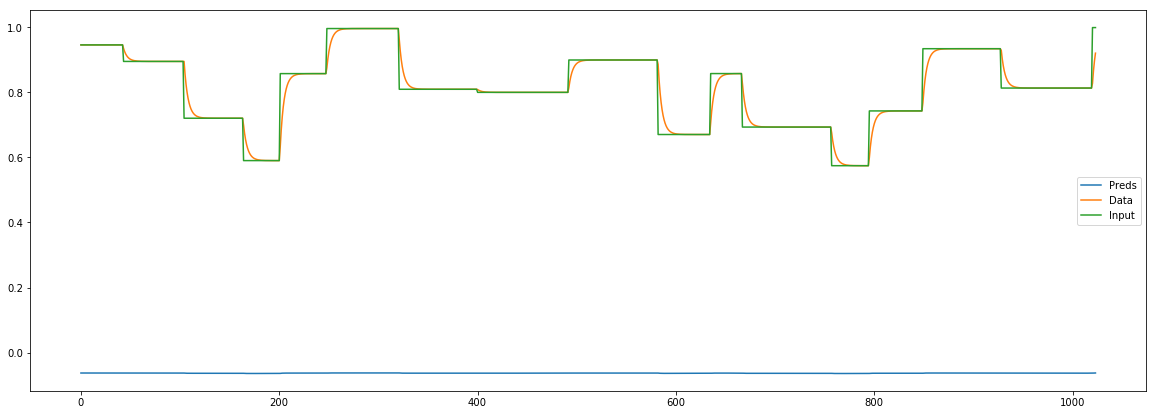

TEST RESID:


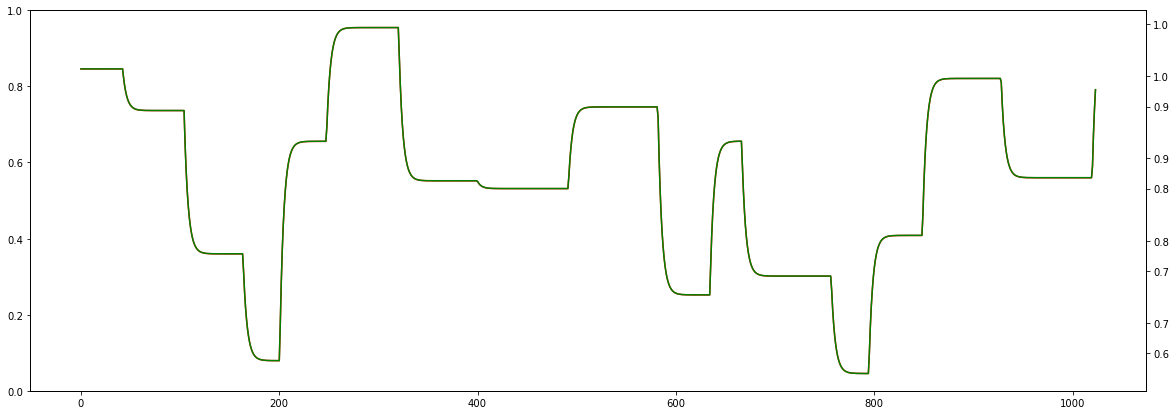

 Epoch [10]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


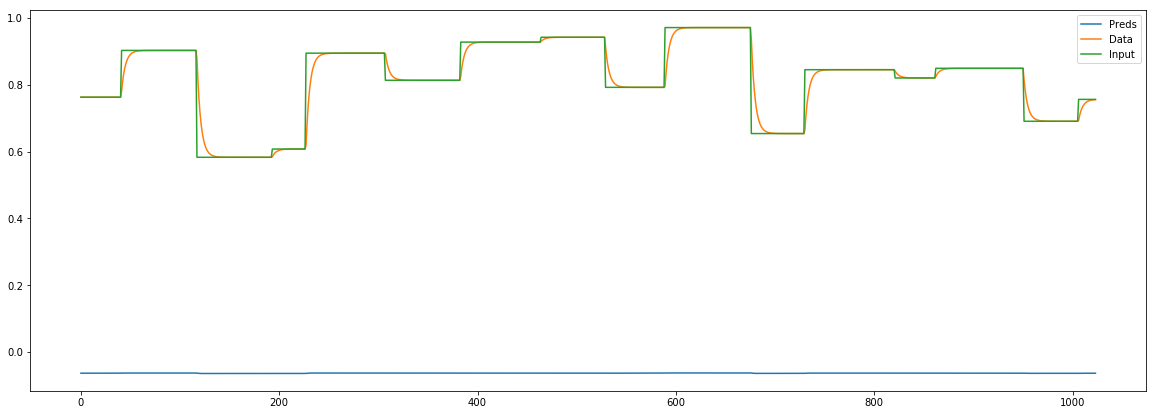

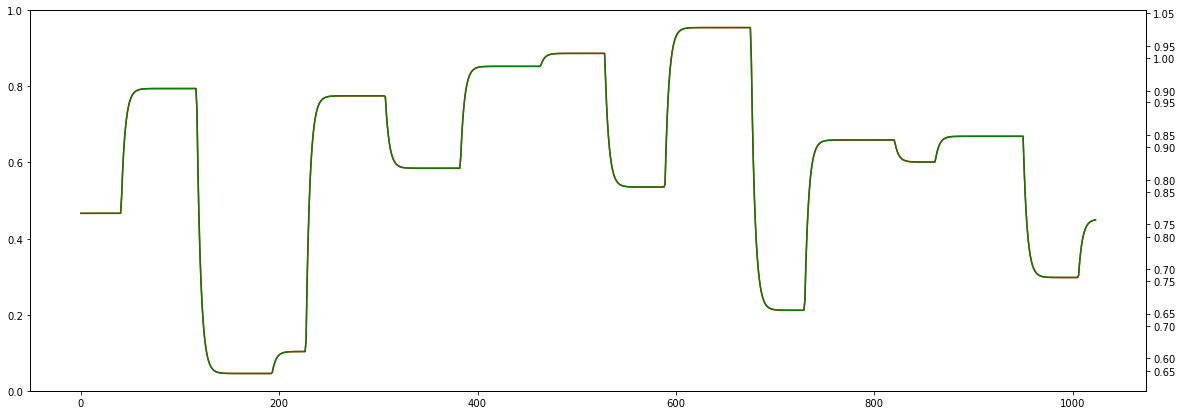

TEST AUX:


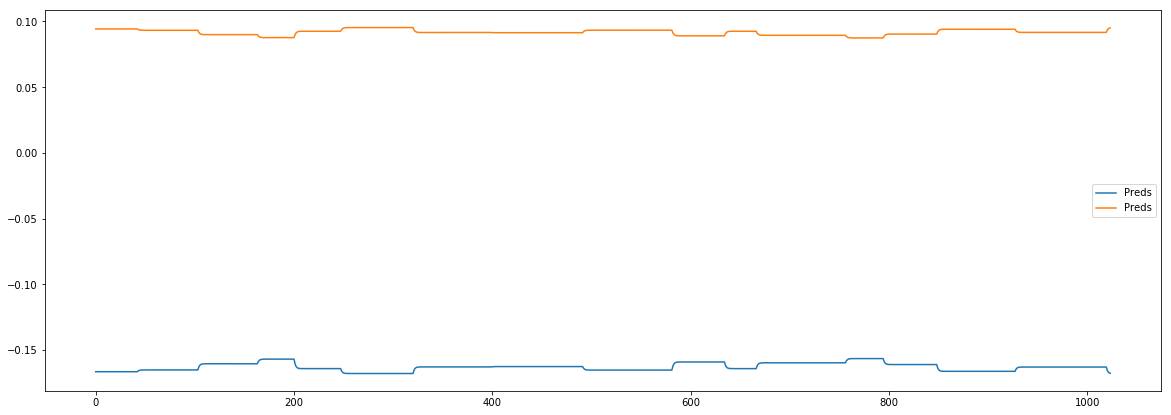

TEST PRED:


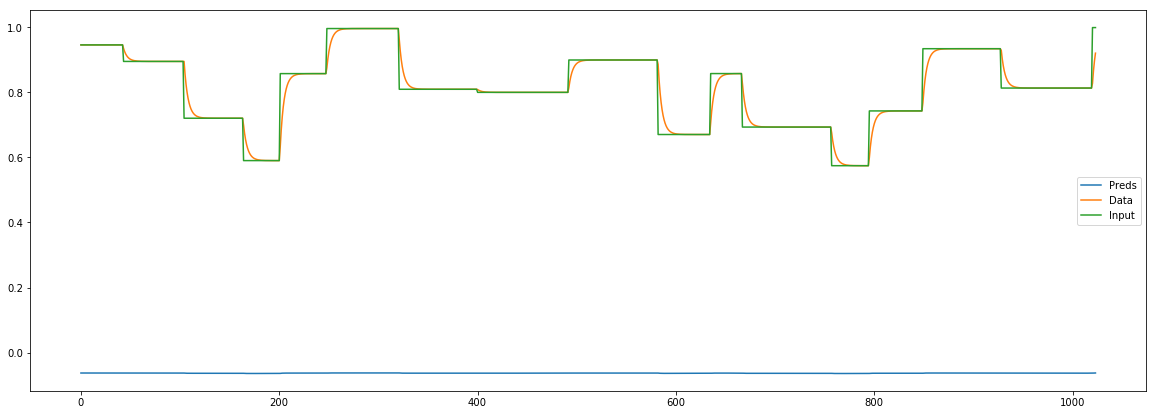

TEST RESID:


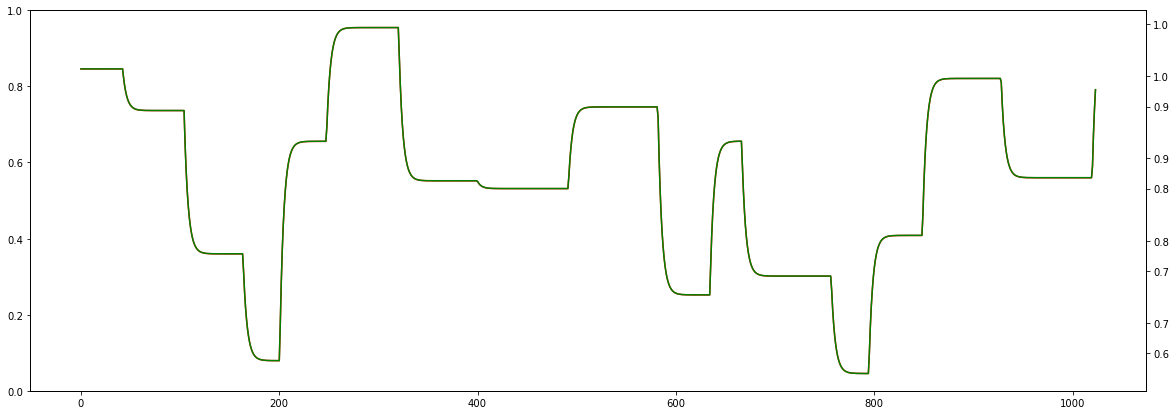

 Epoch [11]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


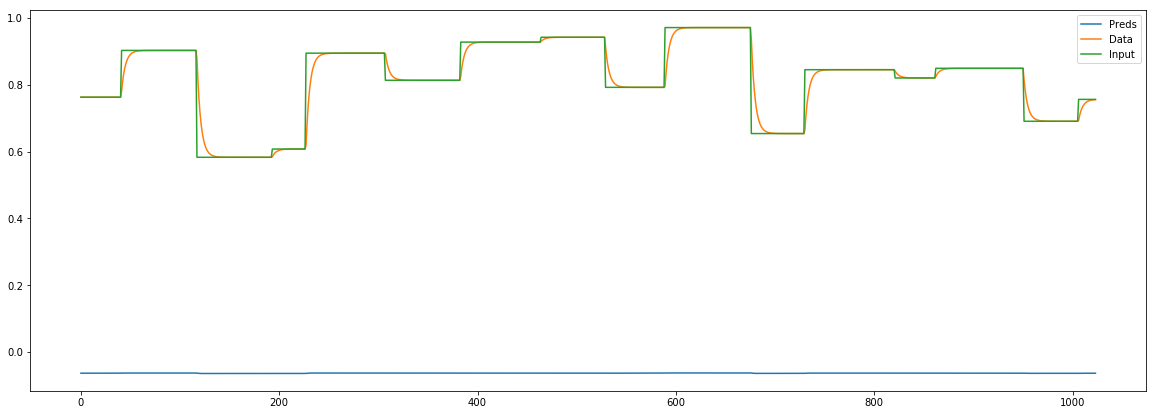

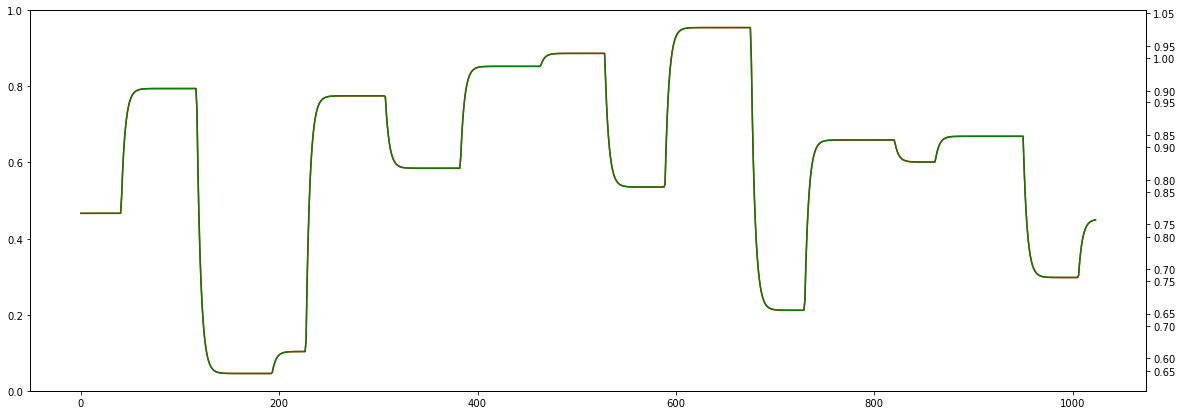

TEST AUX:


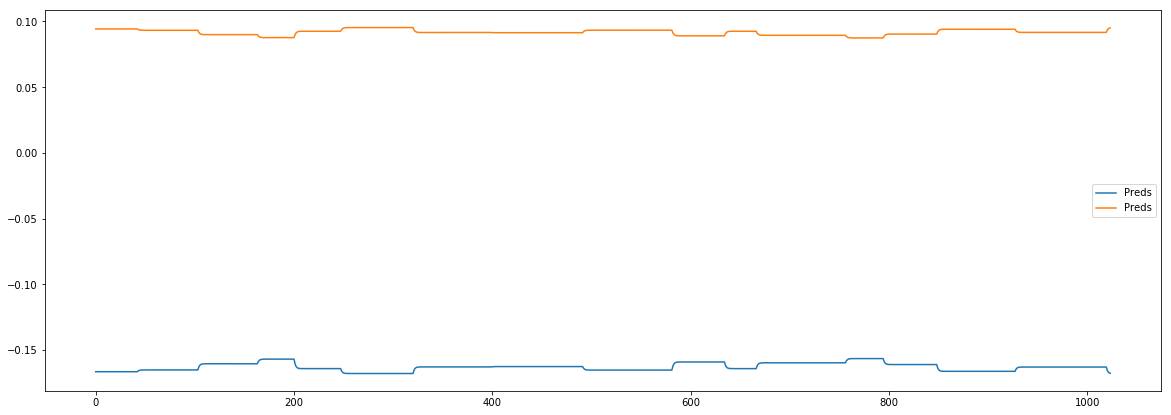

TEST PRED:


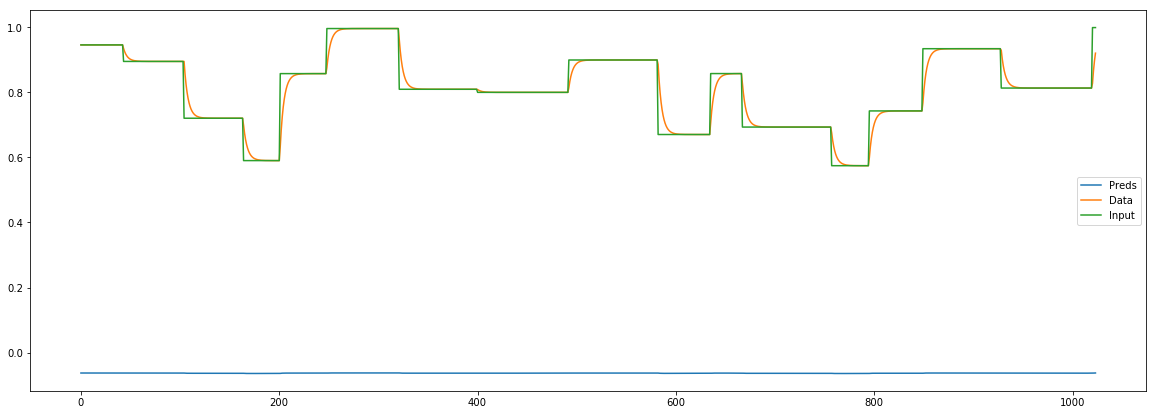

TEST RESID:


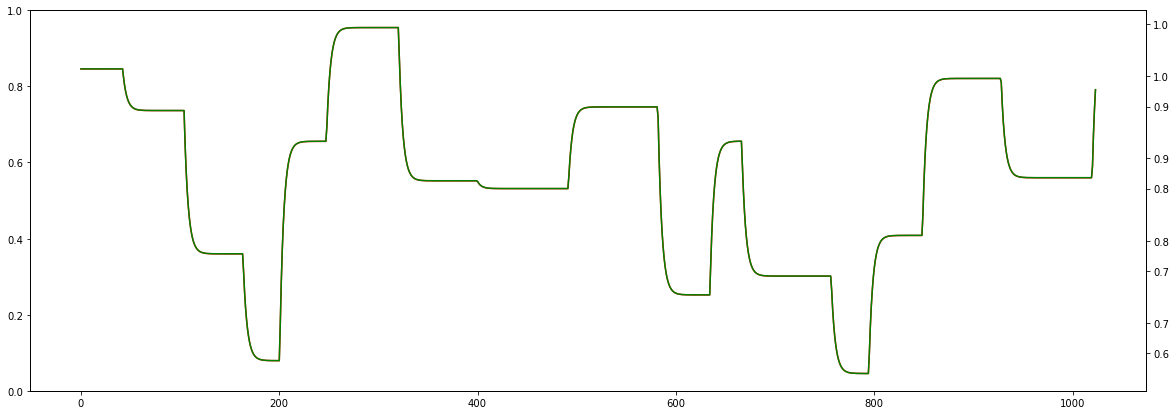

 Epoch [12]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


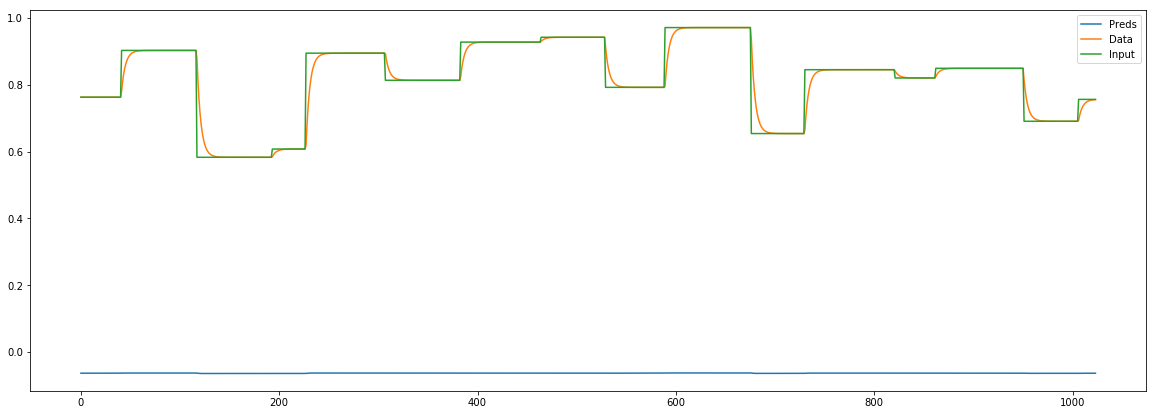

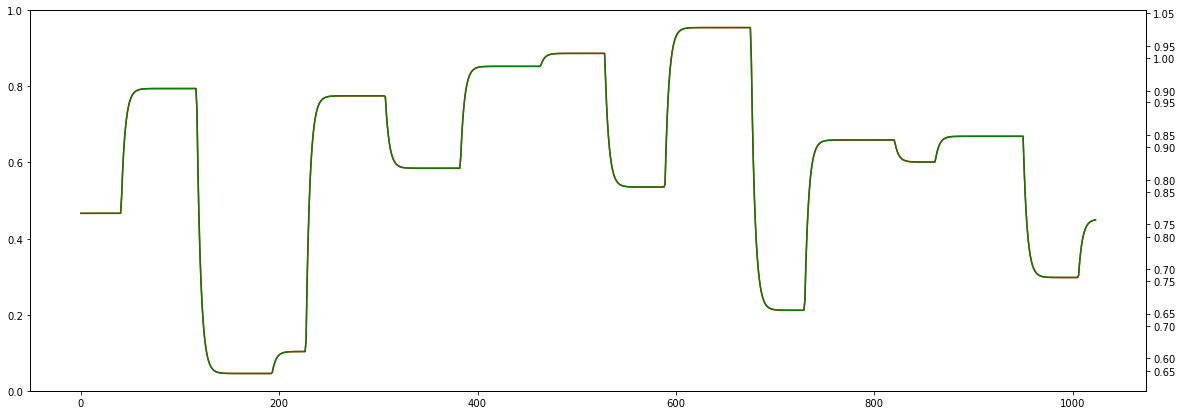

TEST AUX:


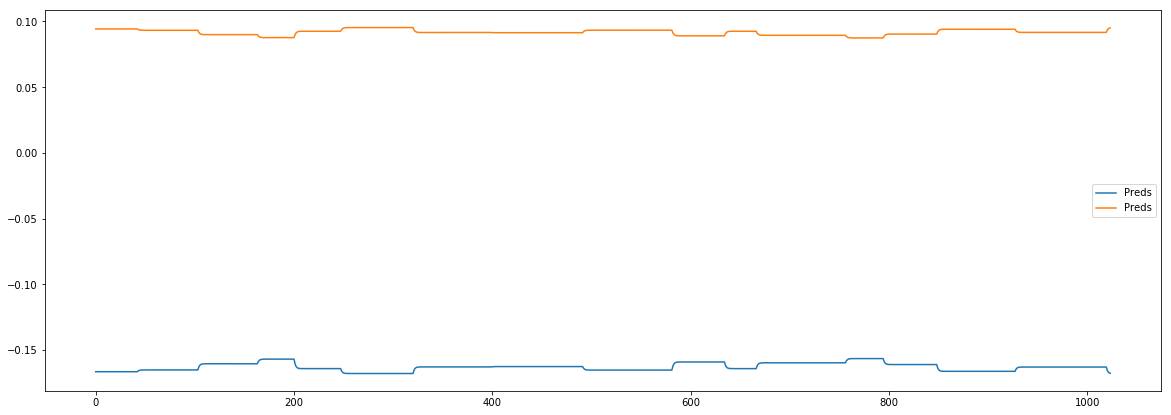

TEST PRED:


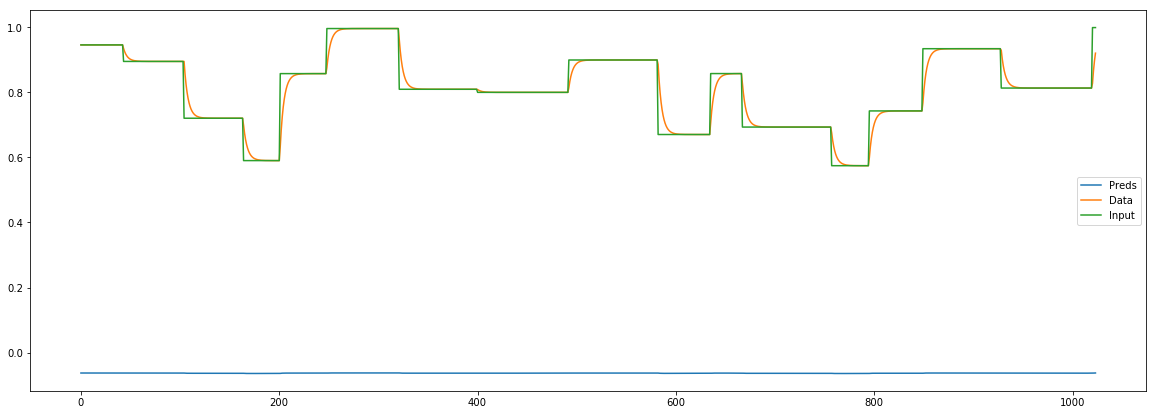

TEST RESID:


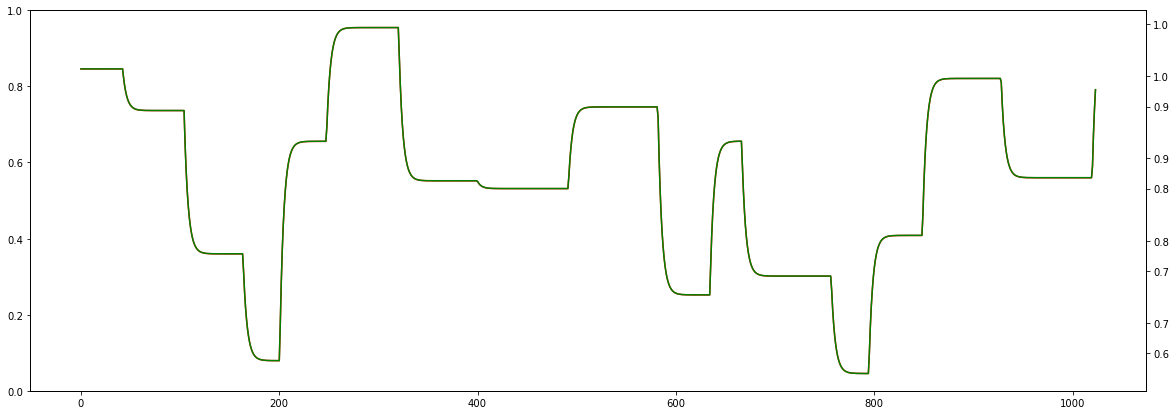

 Epoch [13]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


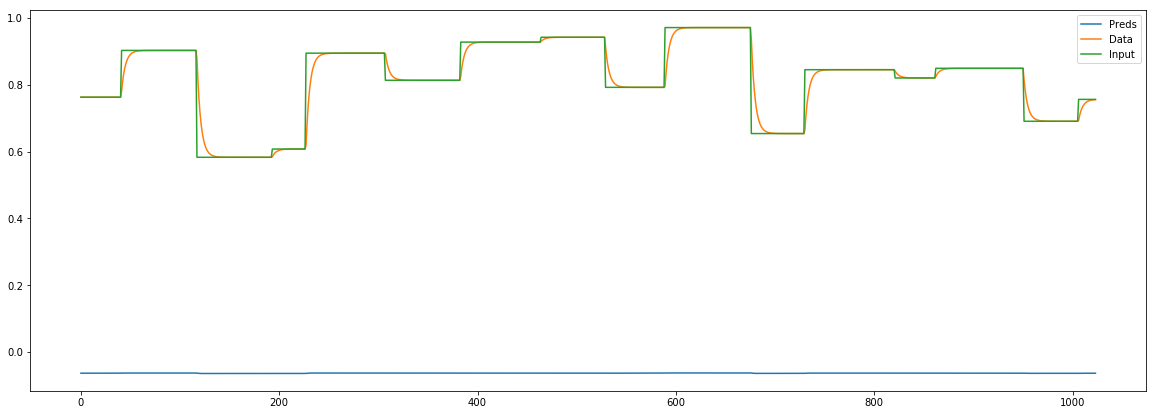

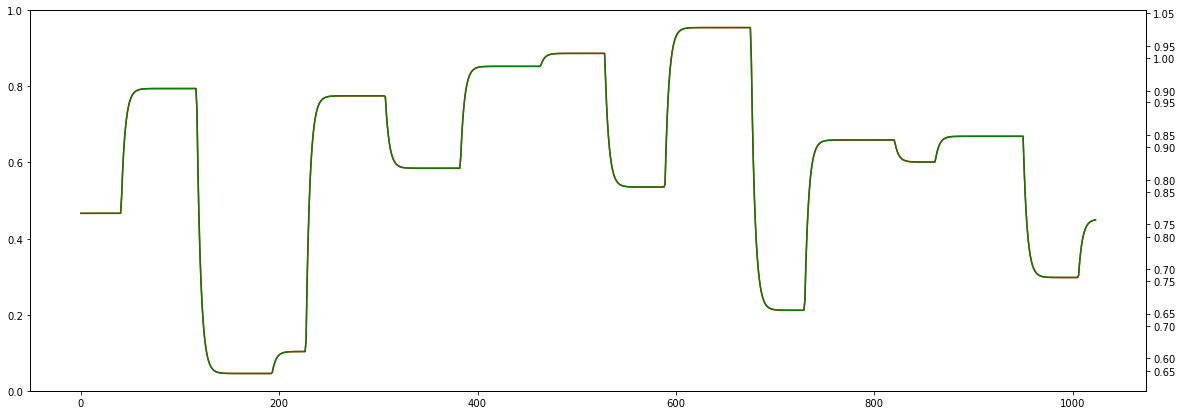

TEST AUX:


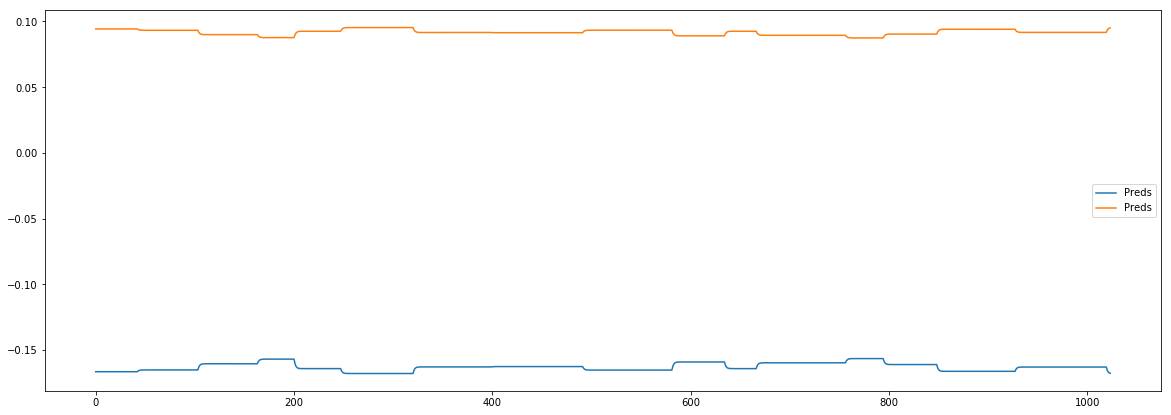

TEST PRED:


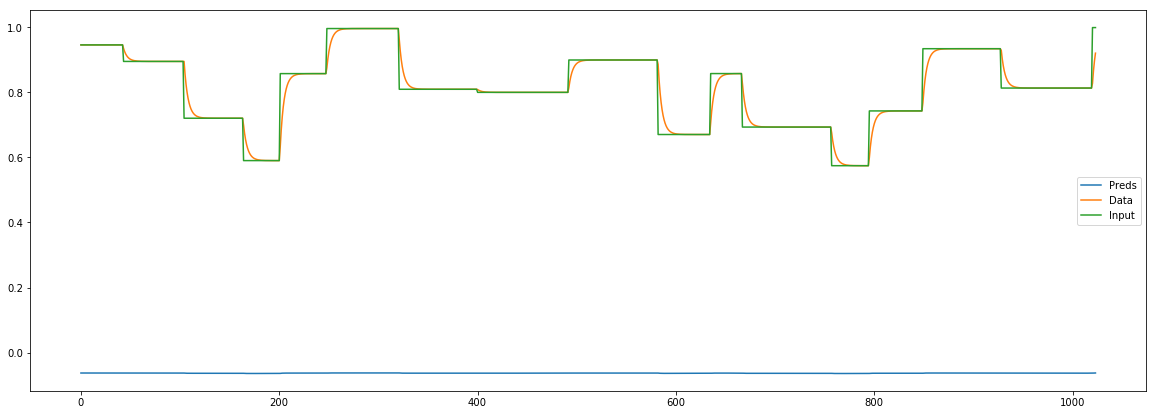

TEST RESID:


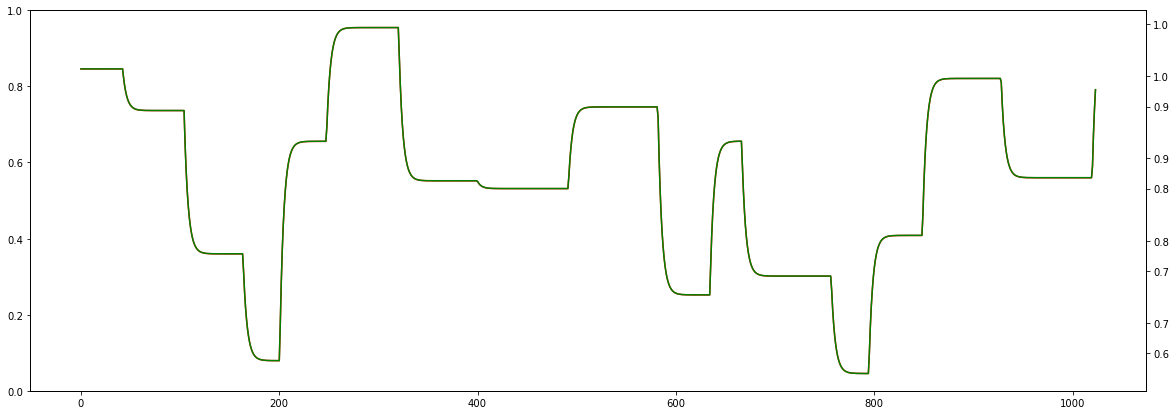

 Epoch [14]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


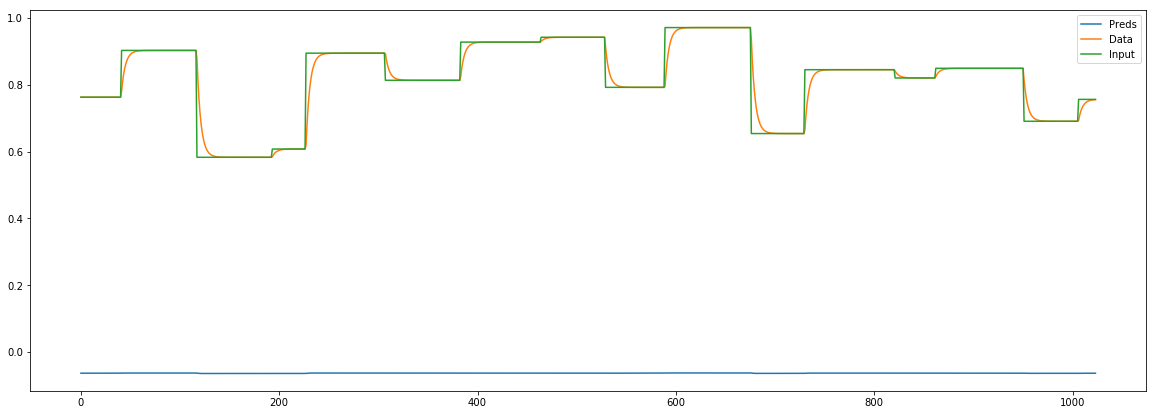

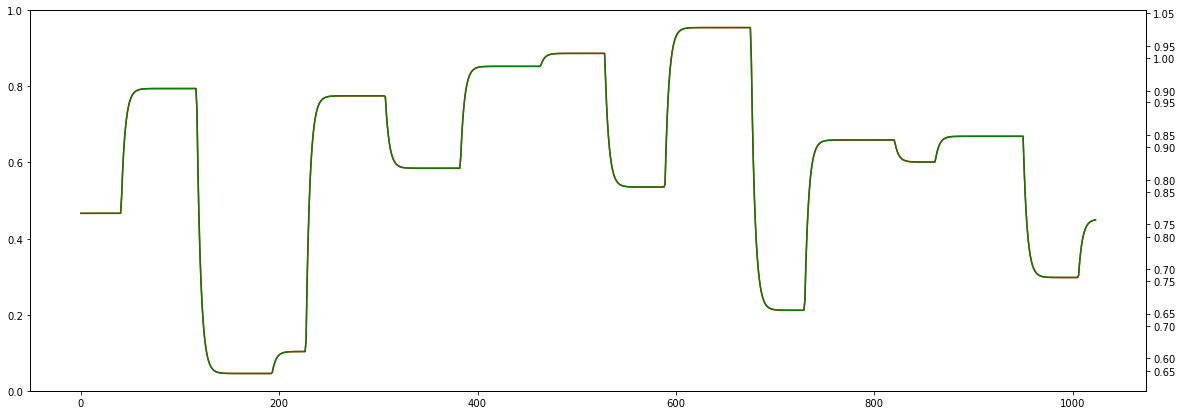

TEST AUX:


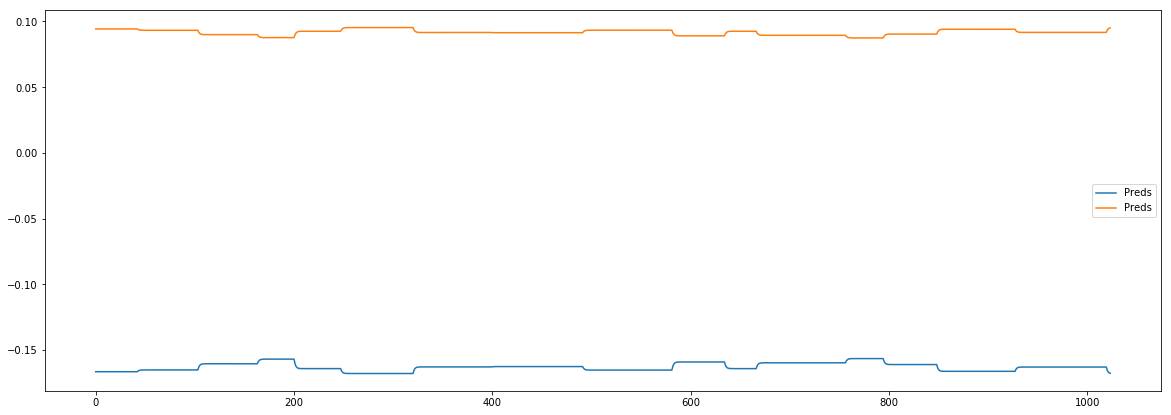

TEST PRED:


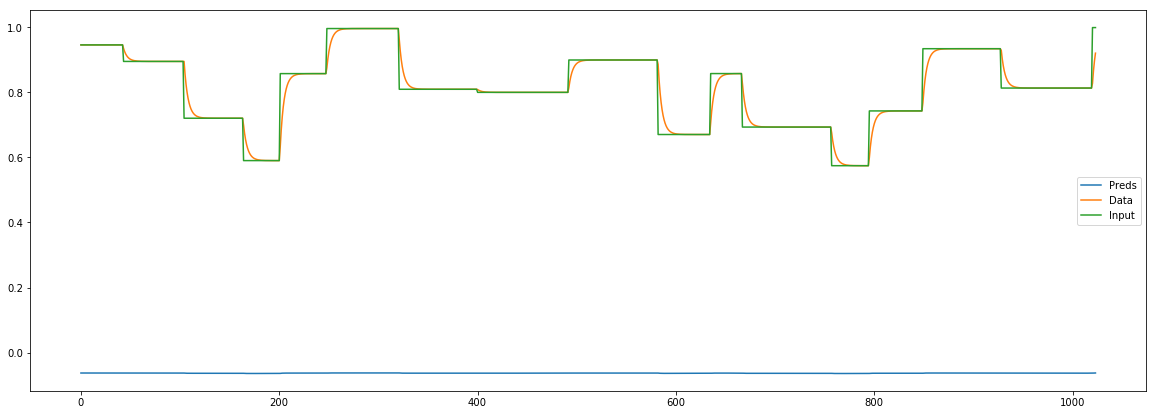

TEST RESID:


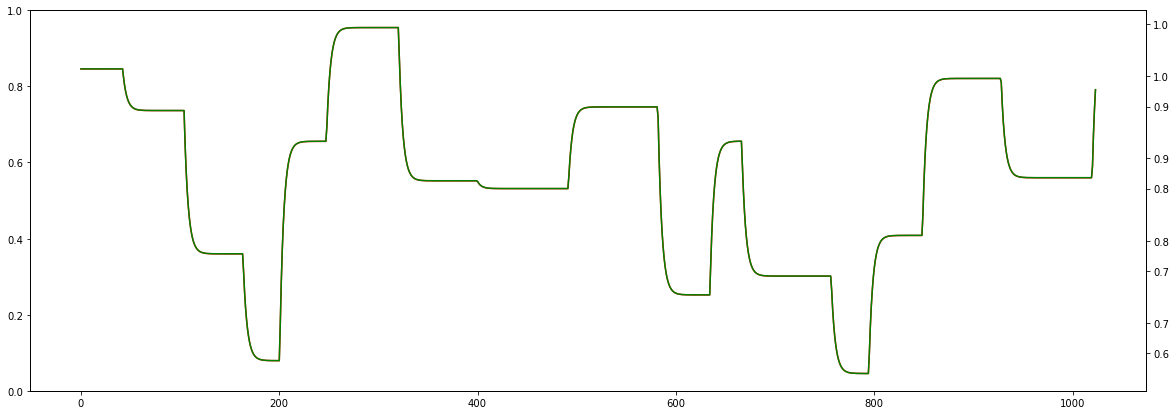

 Epoch [15]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


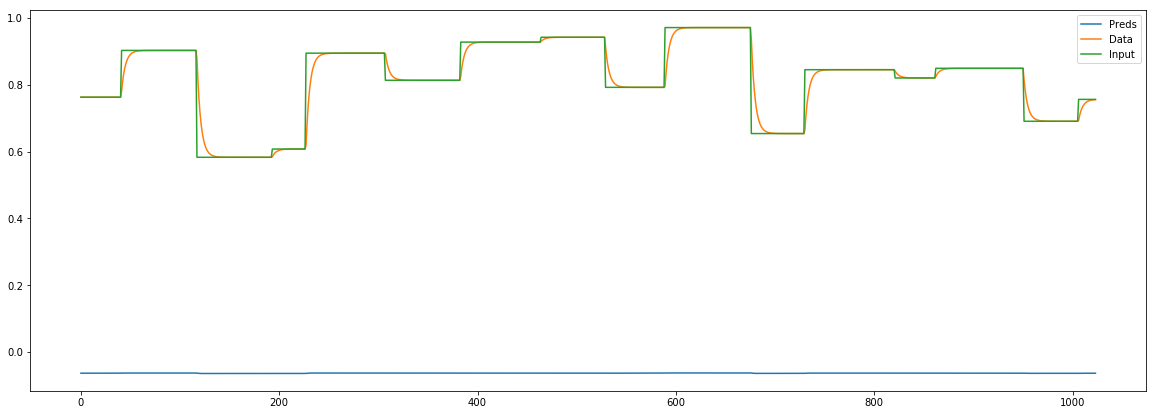

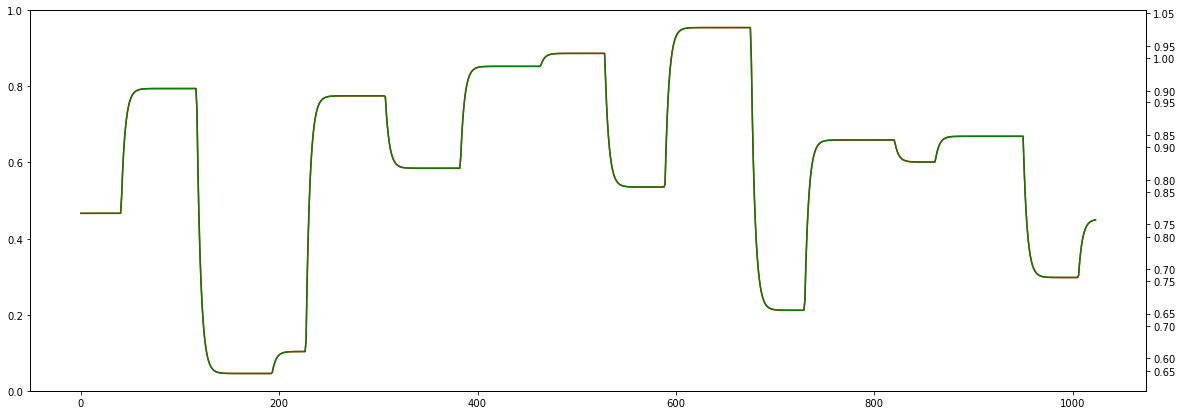

TEST AUX:


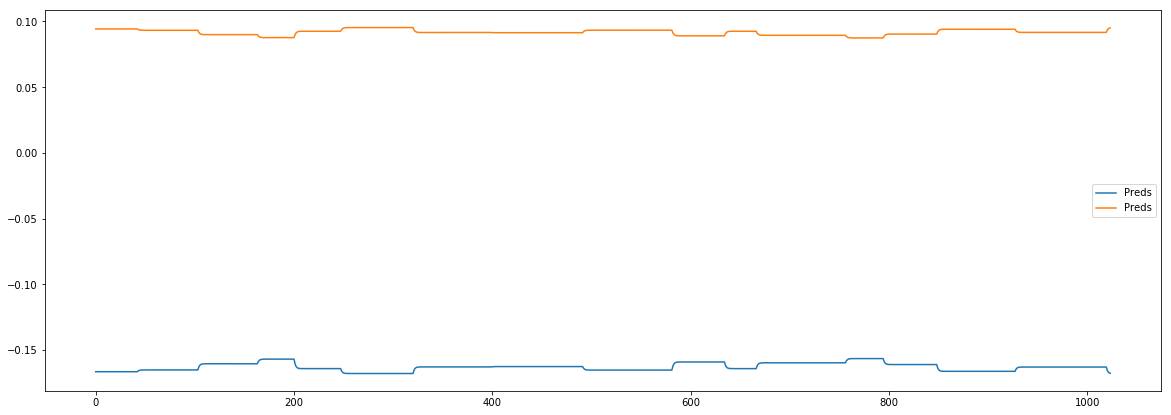

TEST PRED:


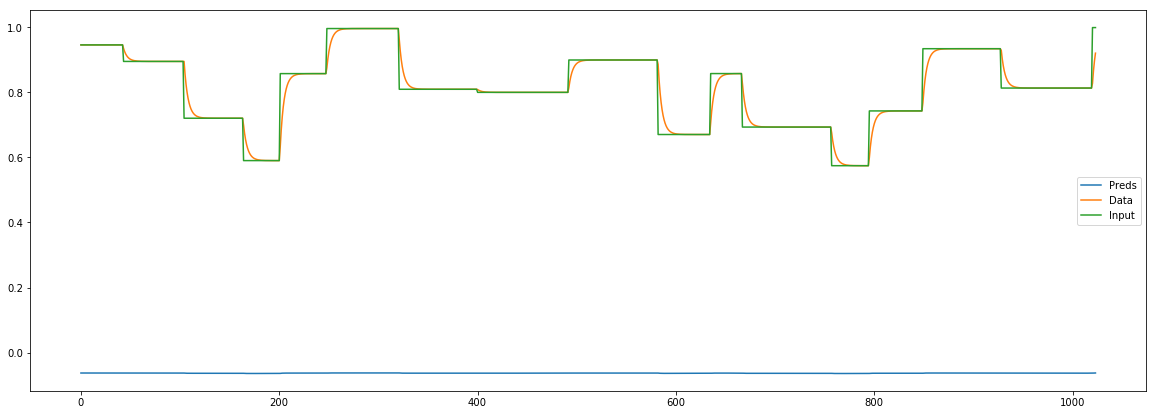

TEST RESID:


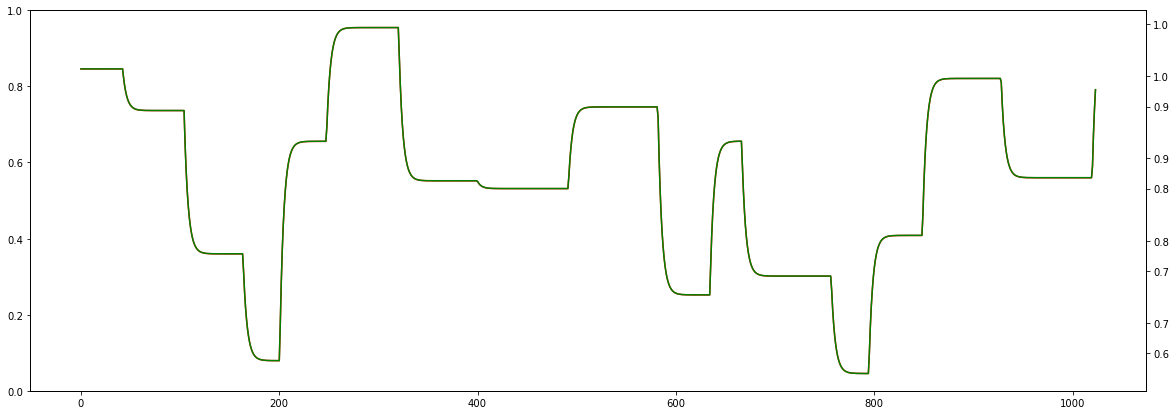

 Epoch [16]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


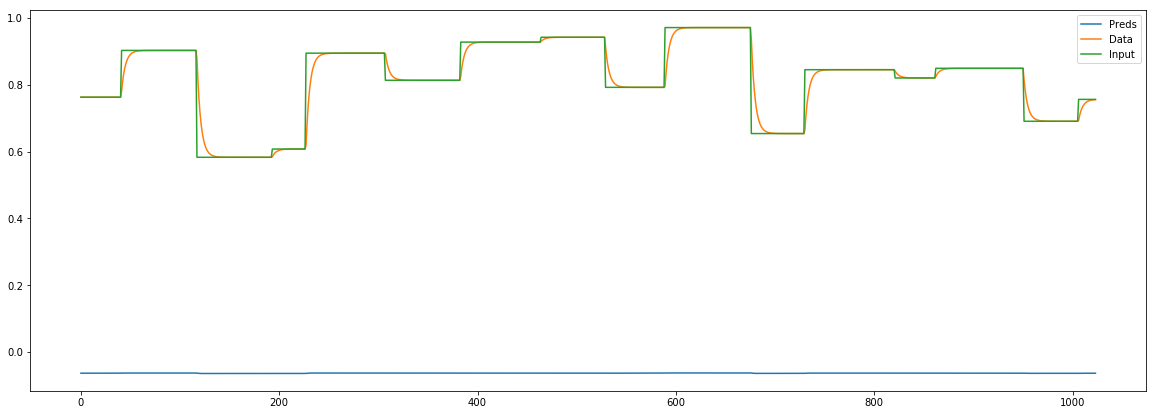

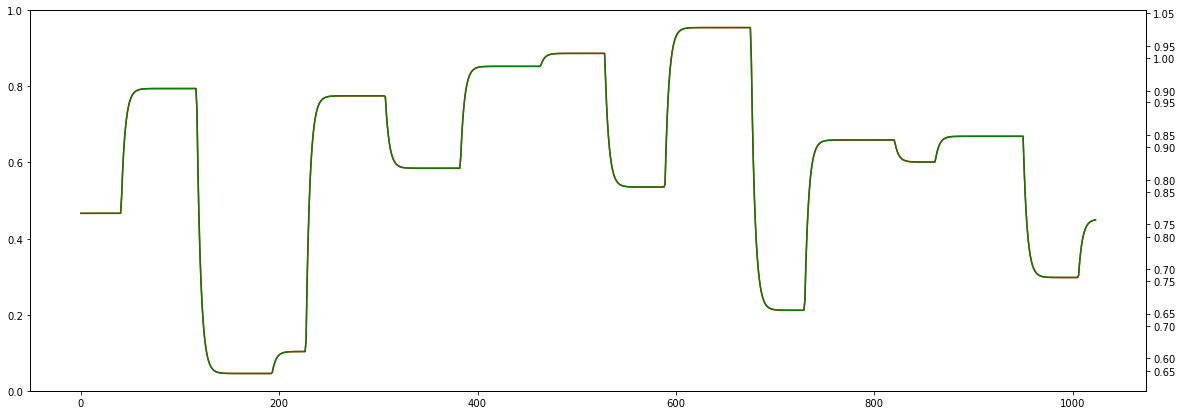

TEST AUX:


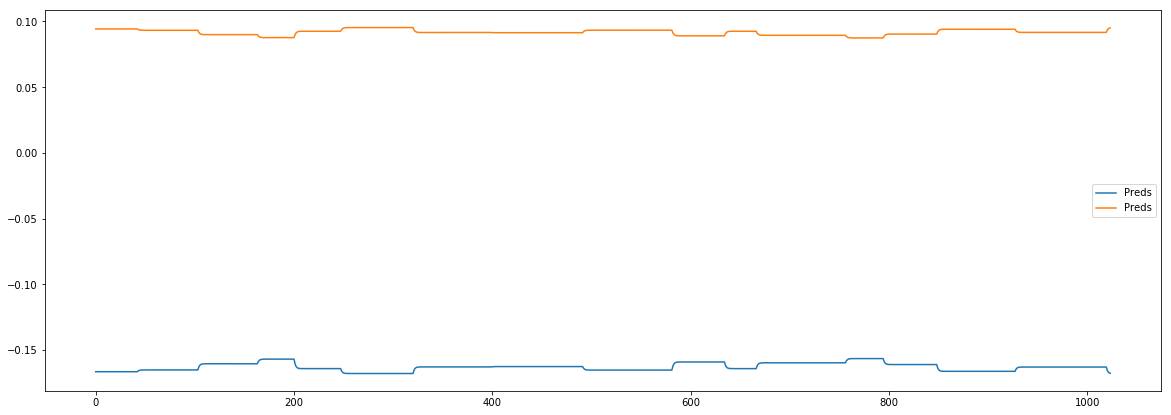

TEST PRED:


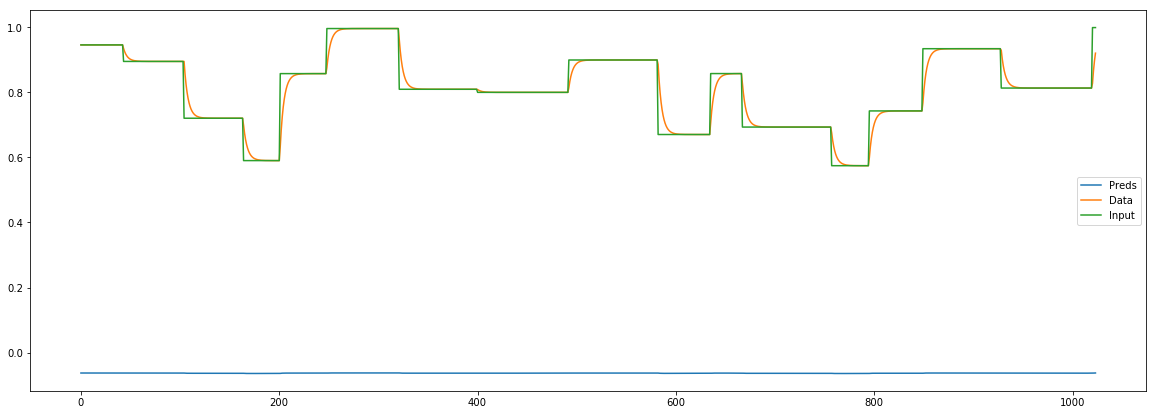

TEST RESID:


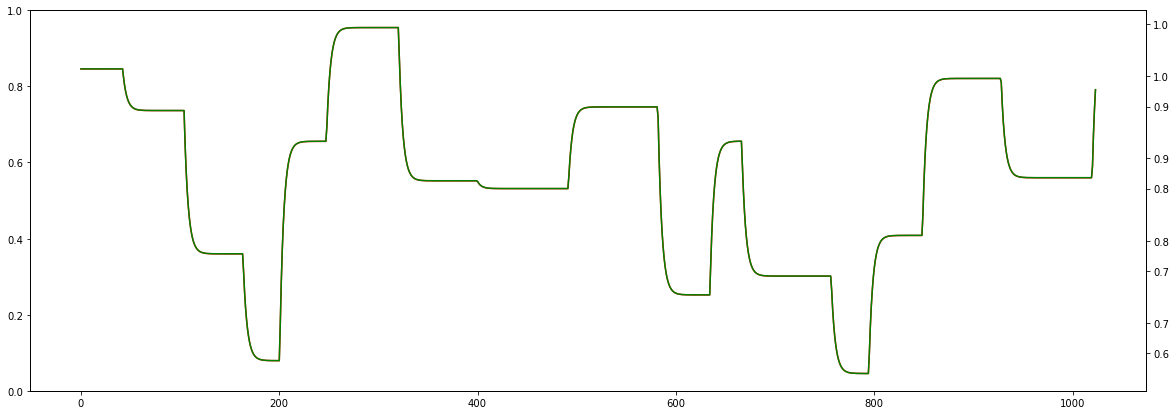

 Epoch [17]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


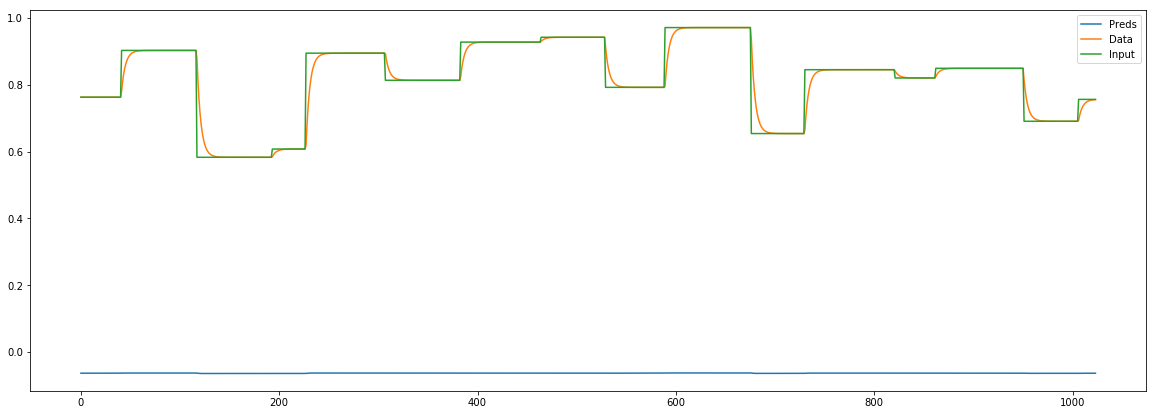

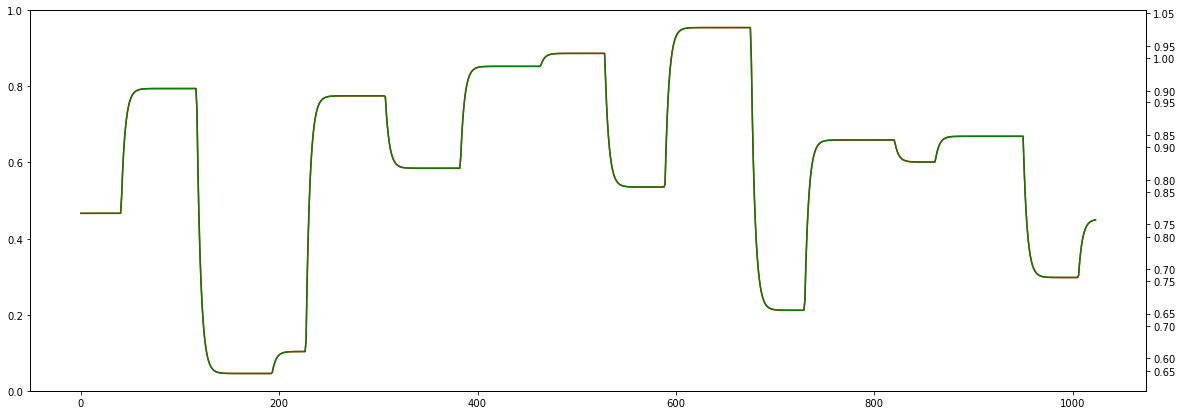

TEST AUX:


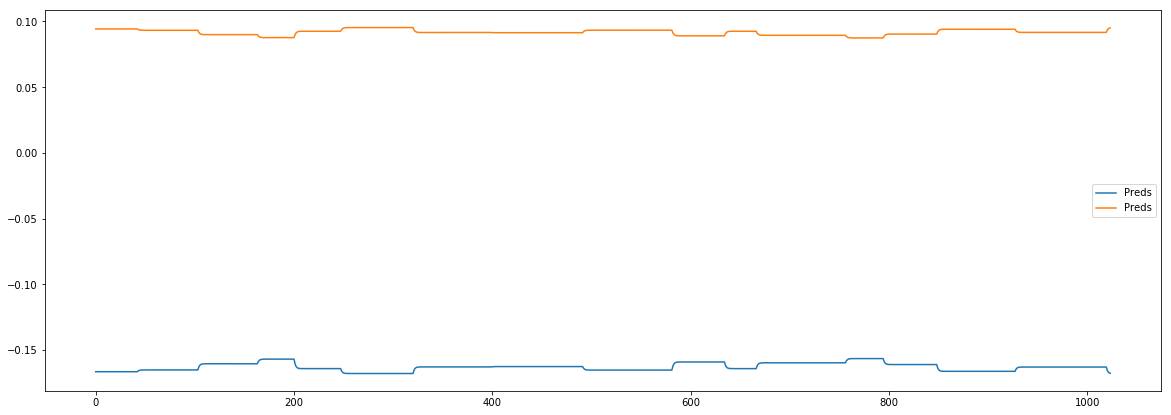

TEST PRED:


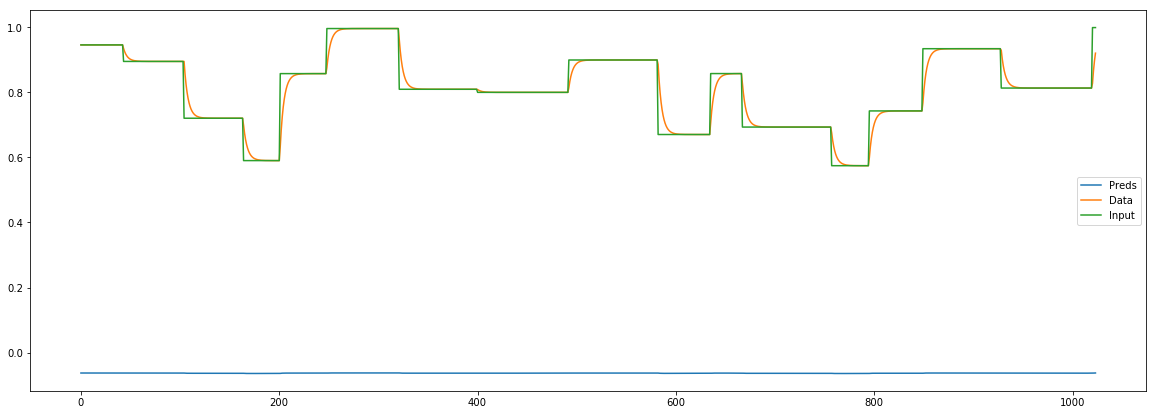

TEST RESID:


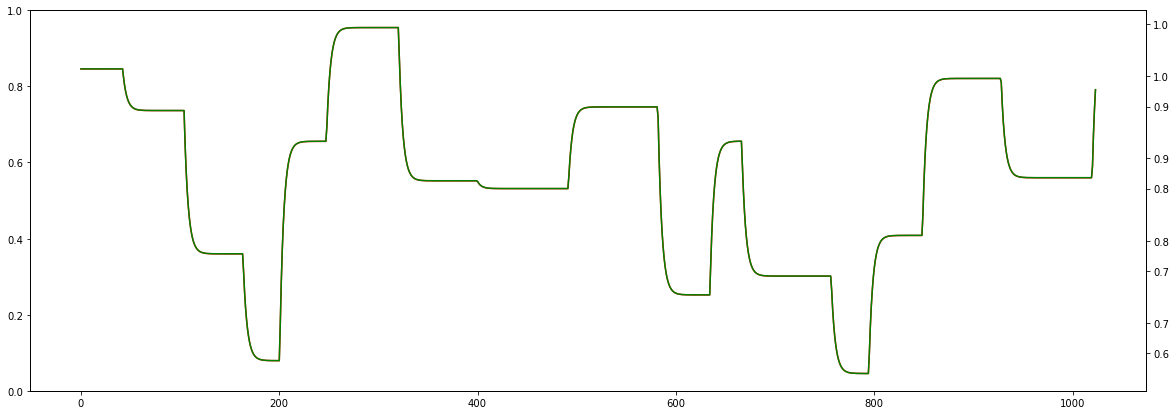

 Epoch [18]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


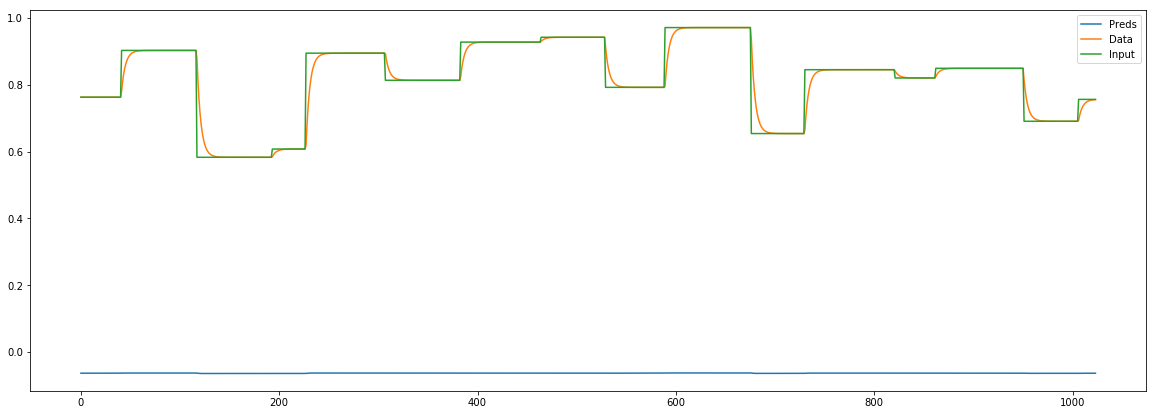

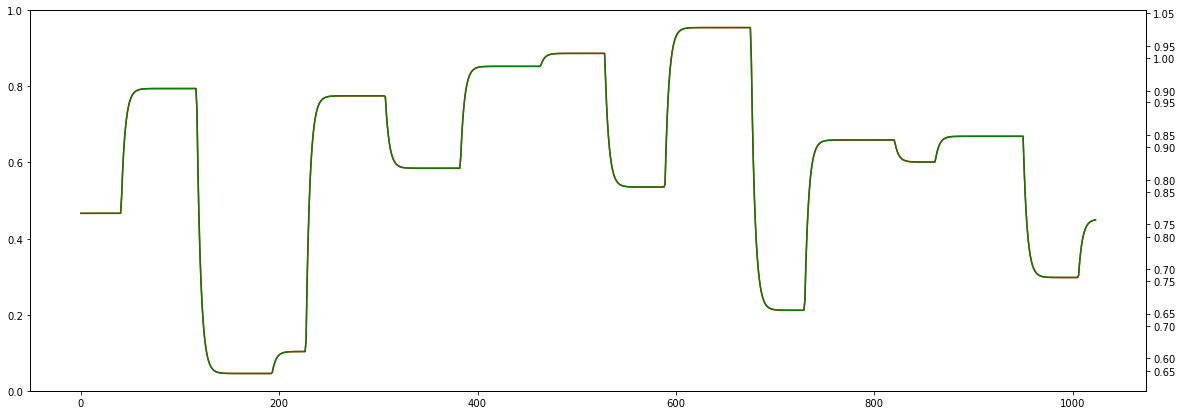

TEST AUX:


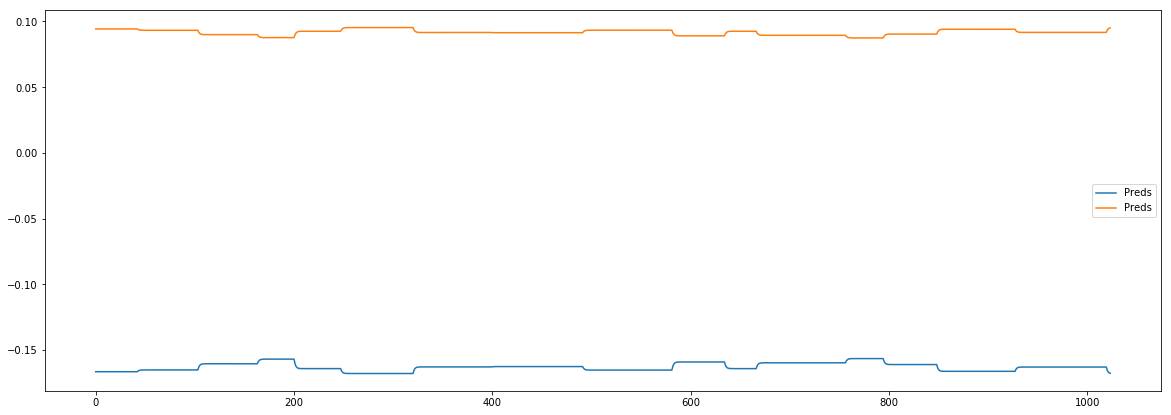

TEST PRED:


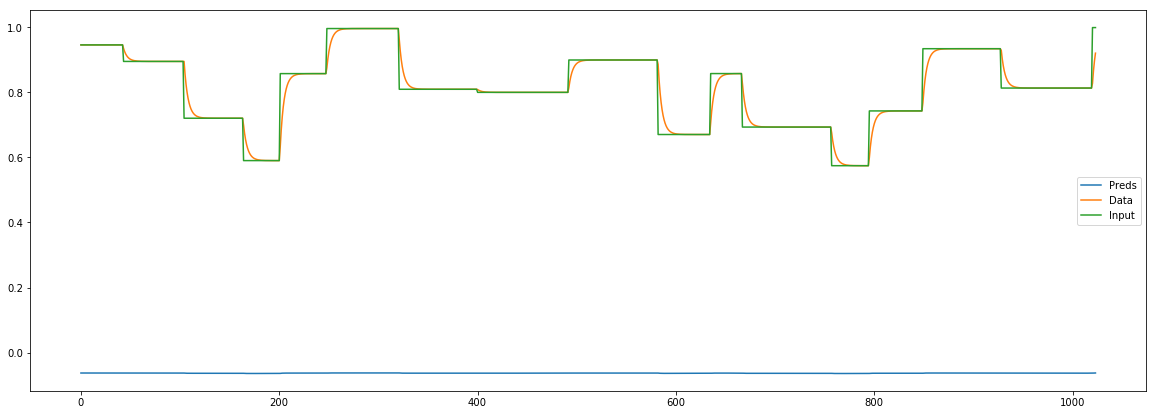

TEST RESID:


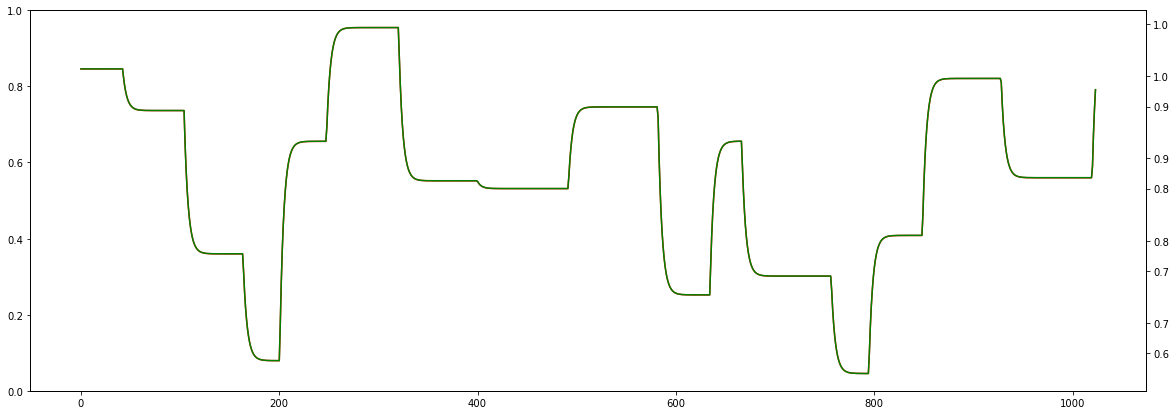

 Epoch [19]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


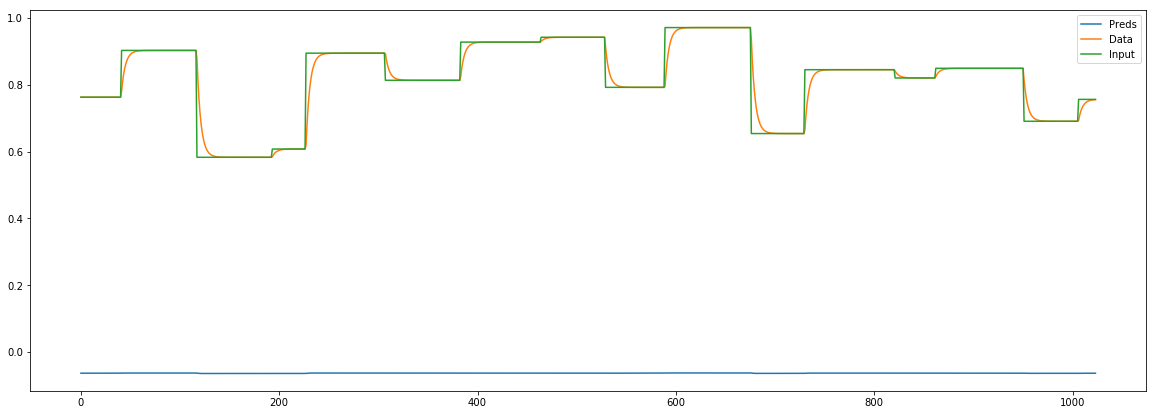

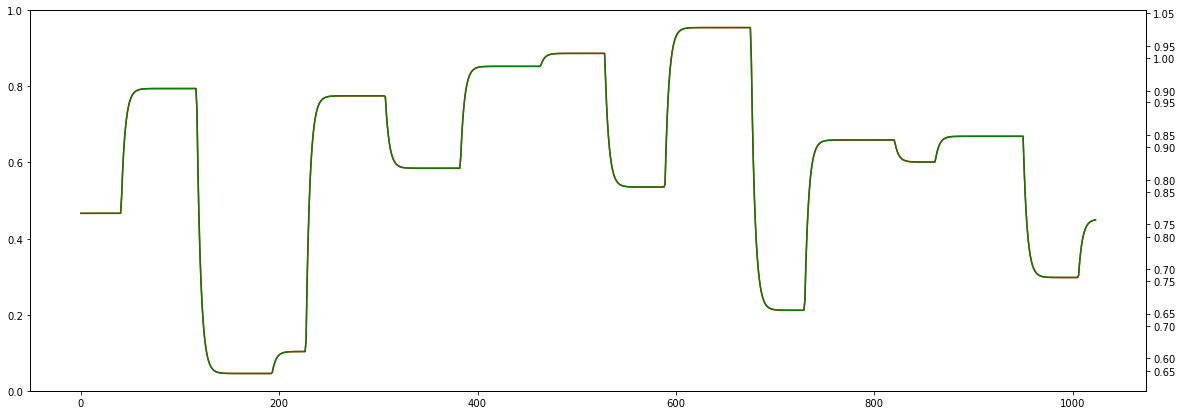

TEST AUX:


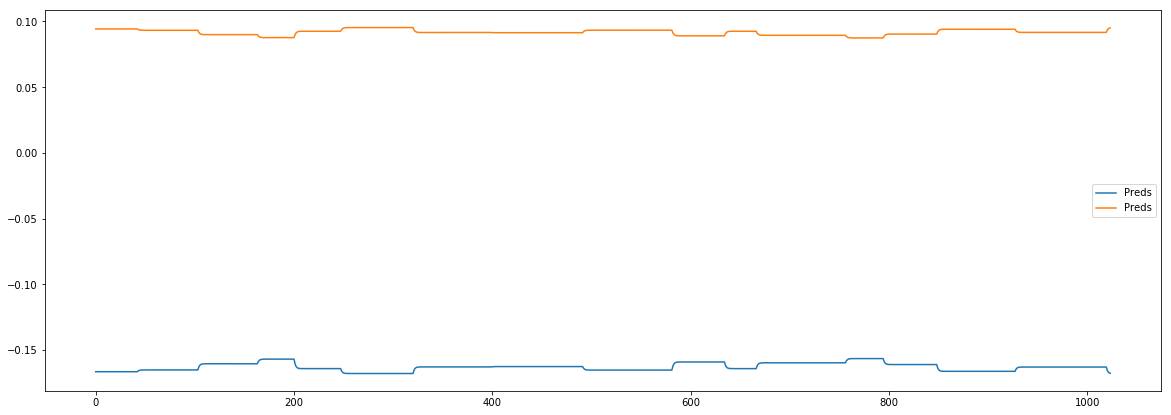

TEST PRED:


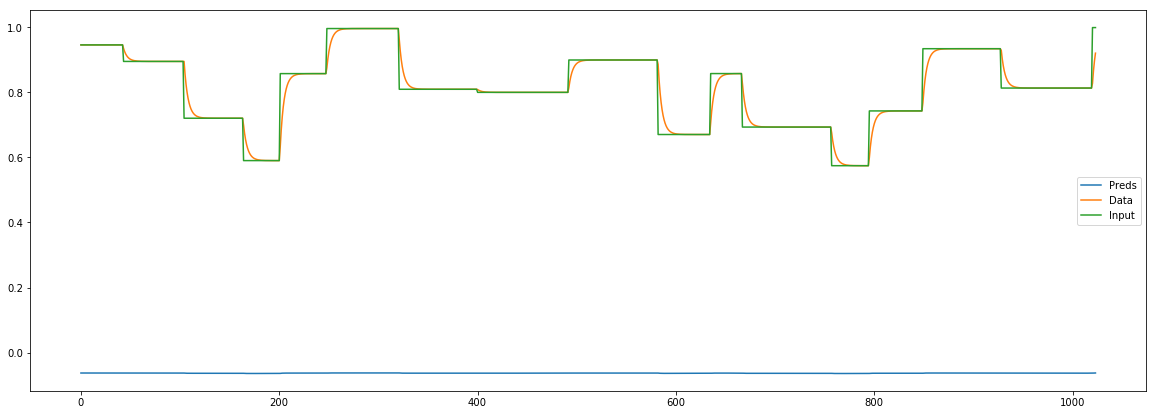

TEST RESID:


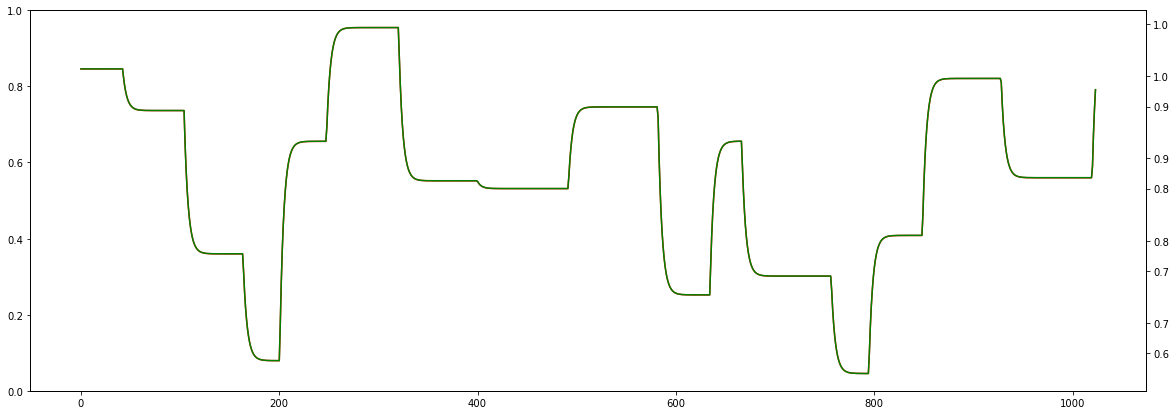

 Epoch [20]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


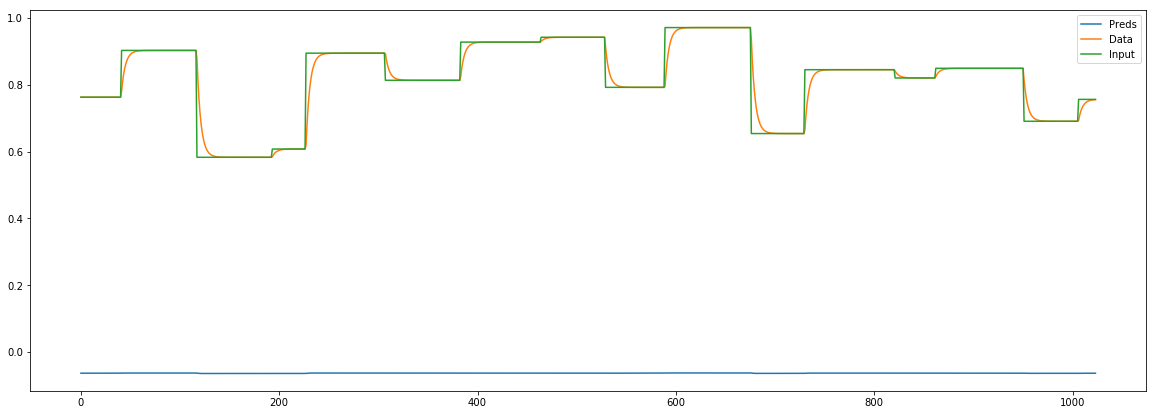

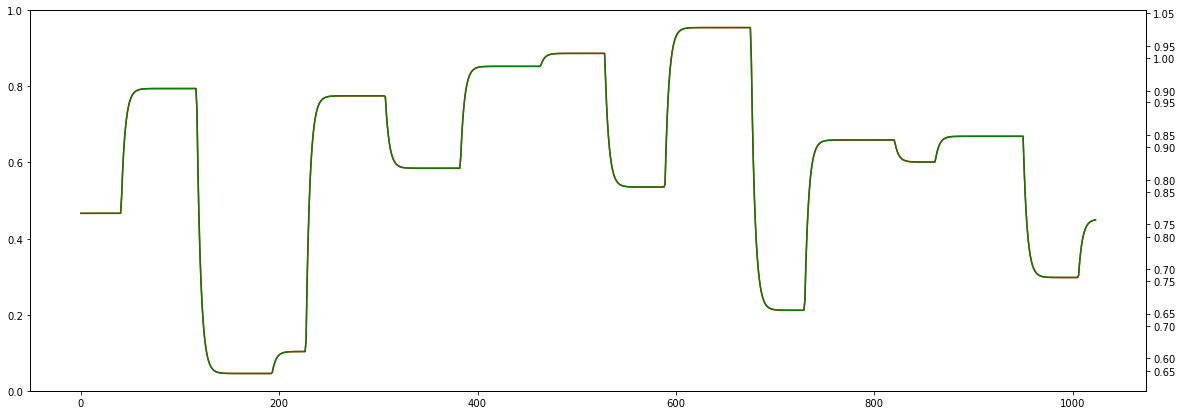

TEST AUX:


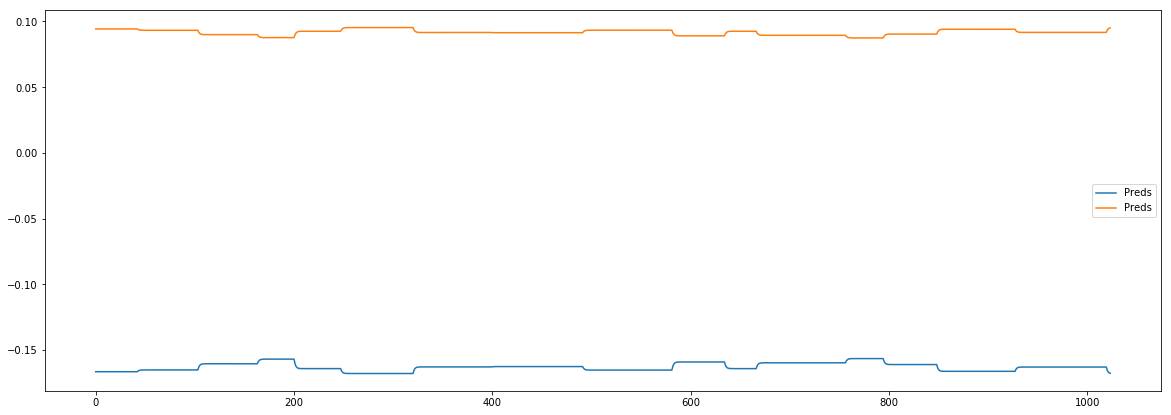

TEST PRED:


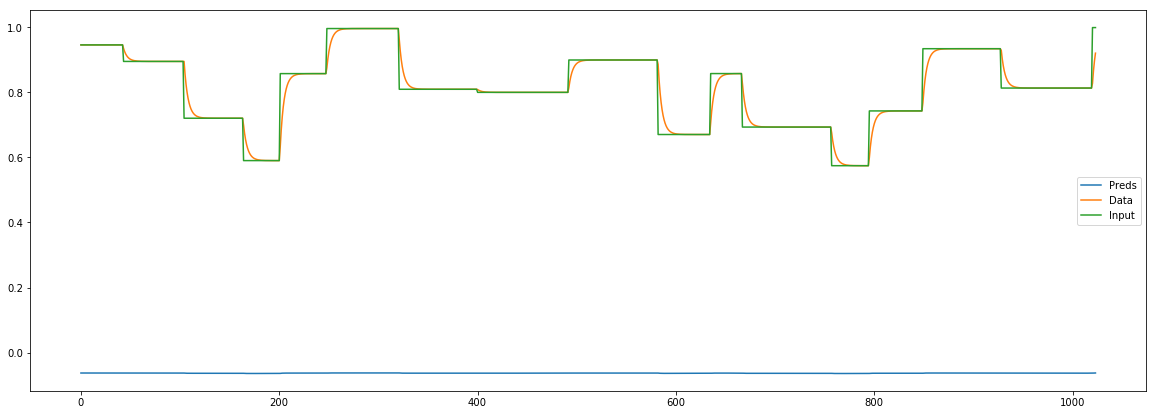

TEST RESID:


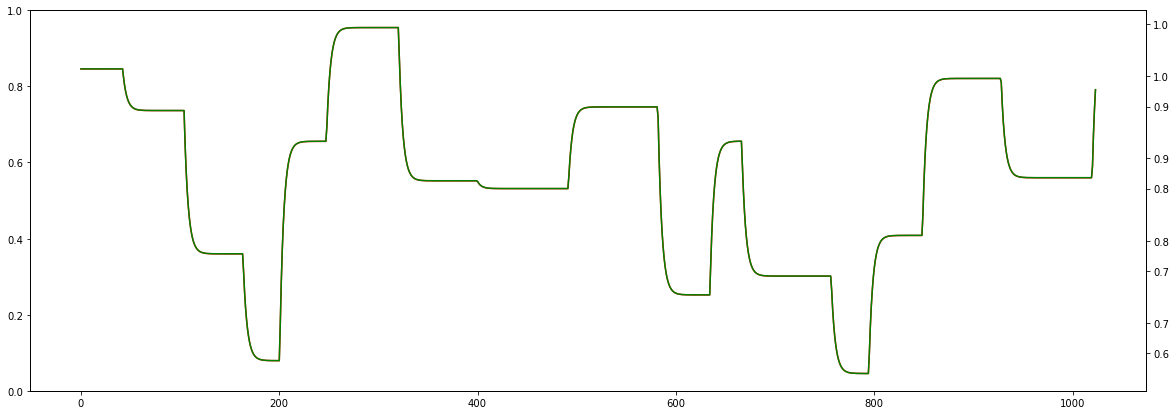

 Epoch [21]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


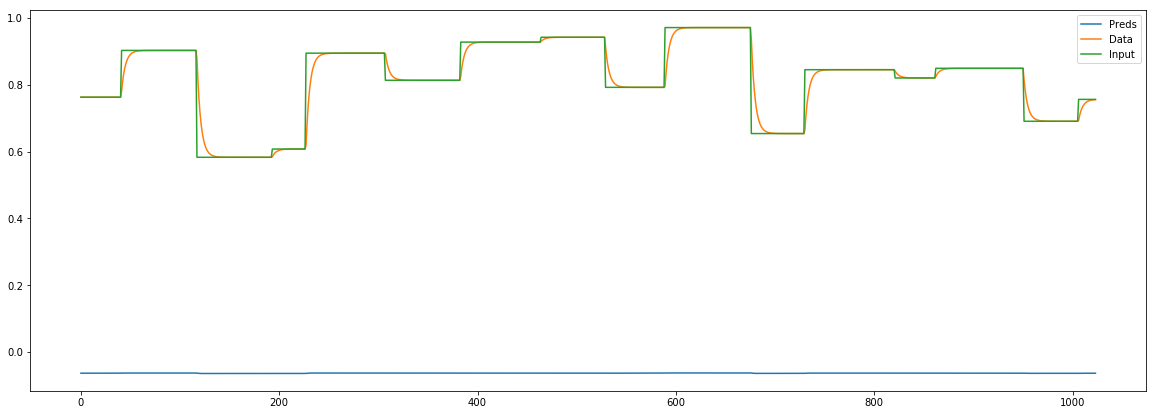

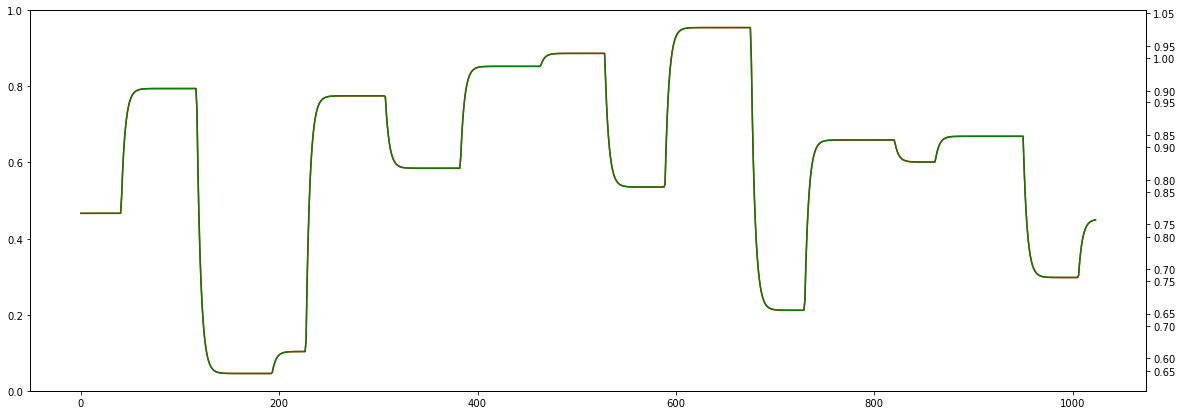

TEST AUX:


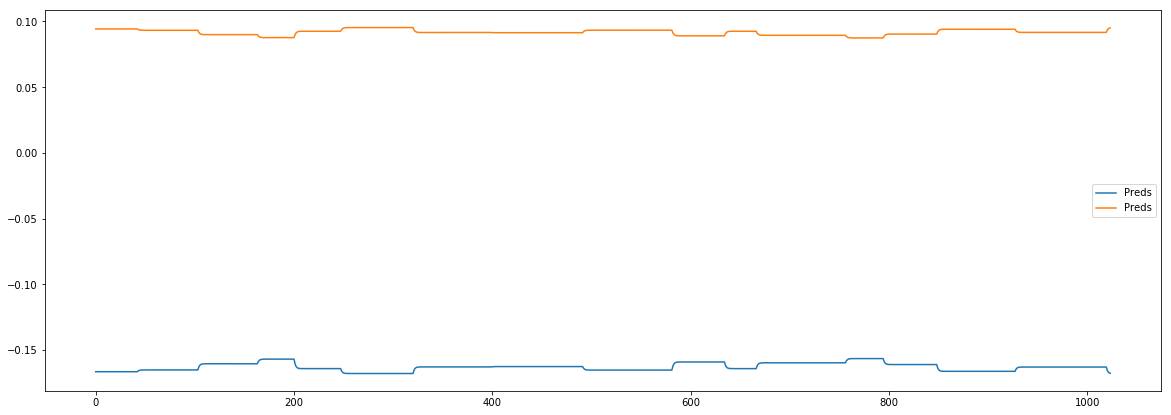

TEST PRED:


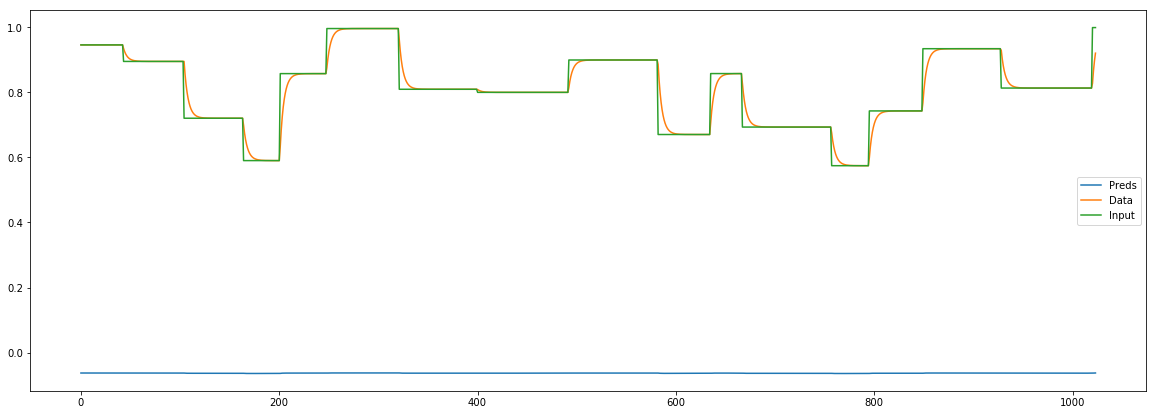

TEST RESID:


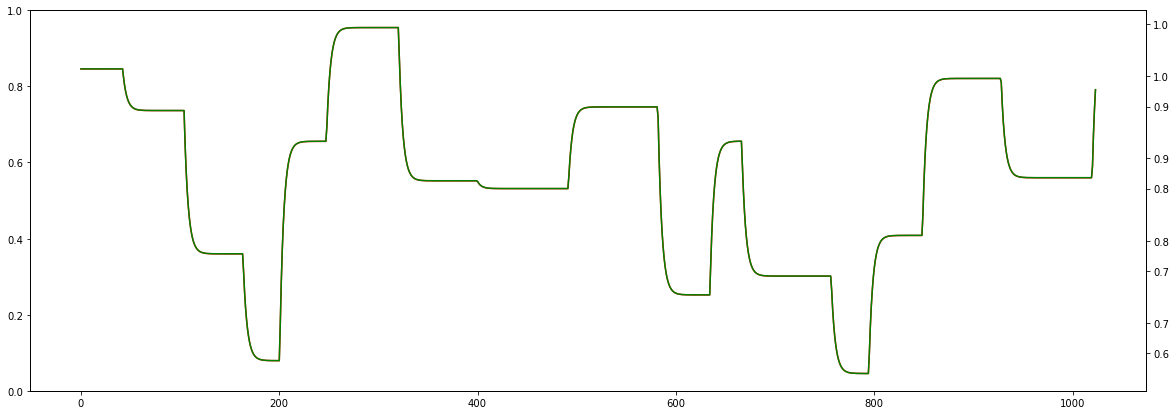

 Epoch [22]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


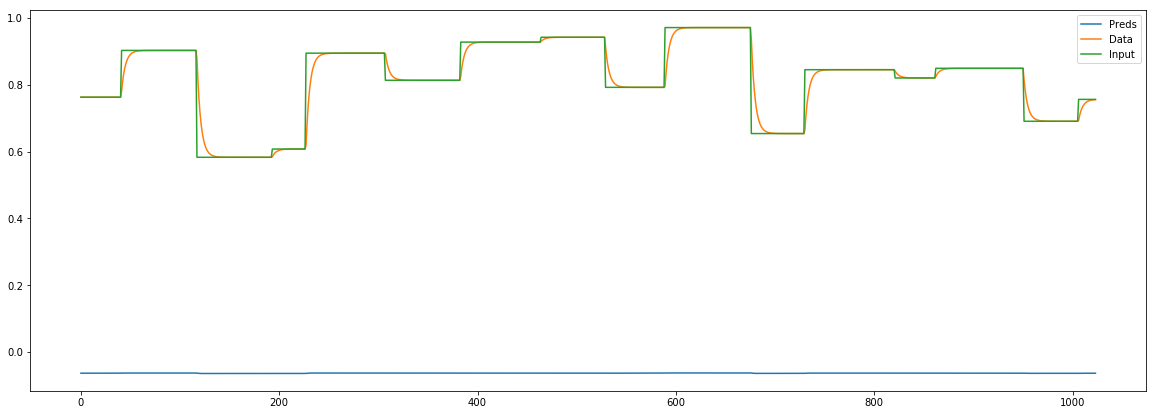

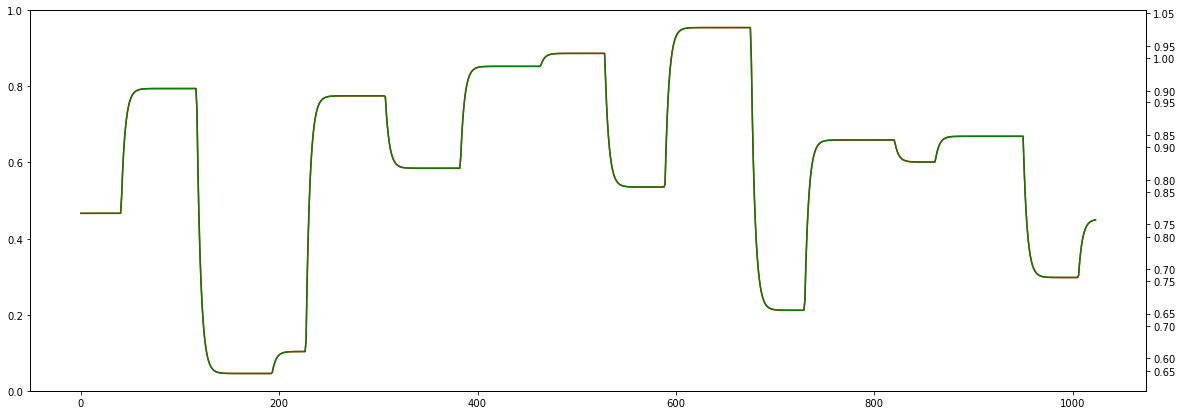

TEST AUX:


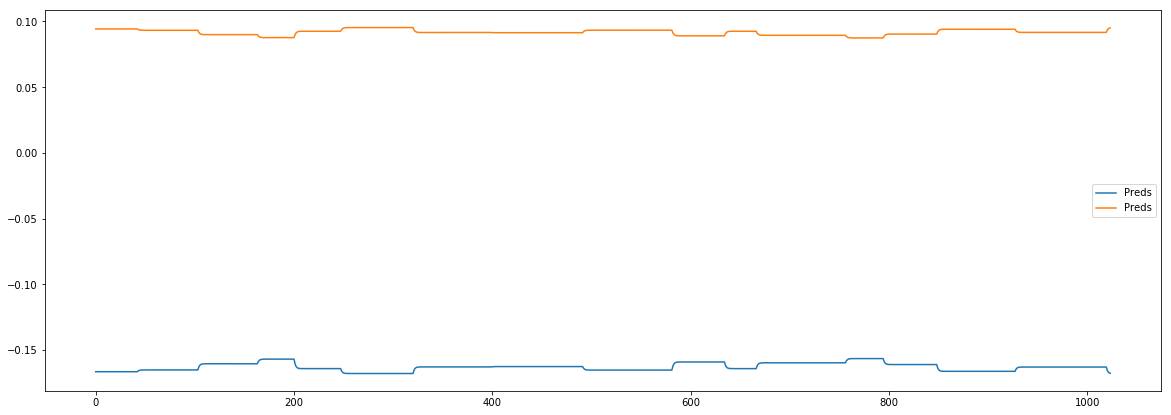

TEST PRED:


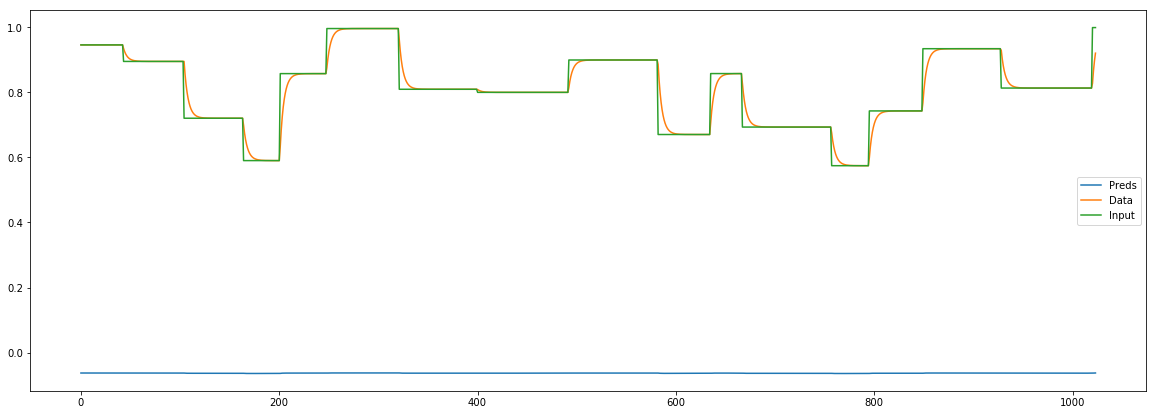

TEST RESID:


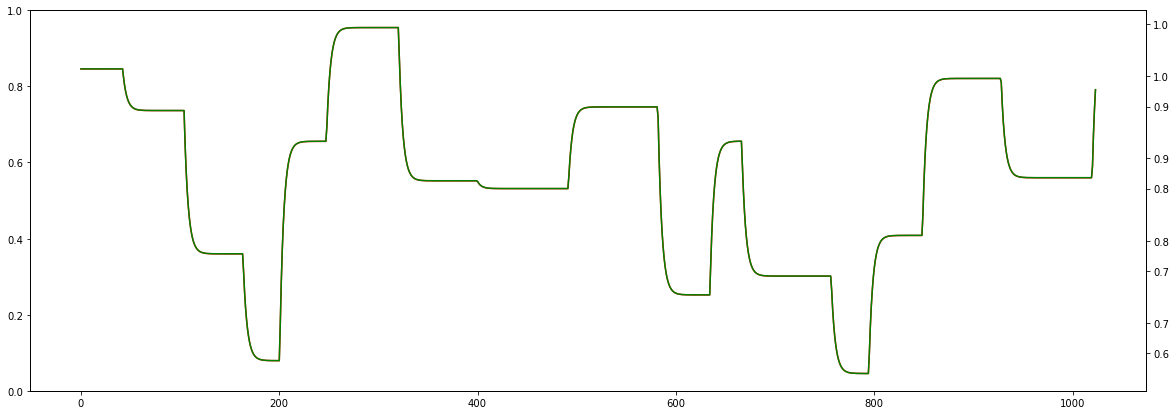

 Epoch [23]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


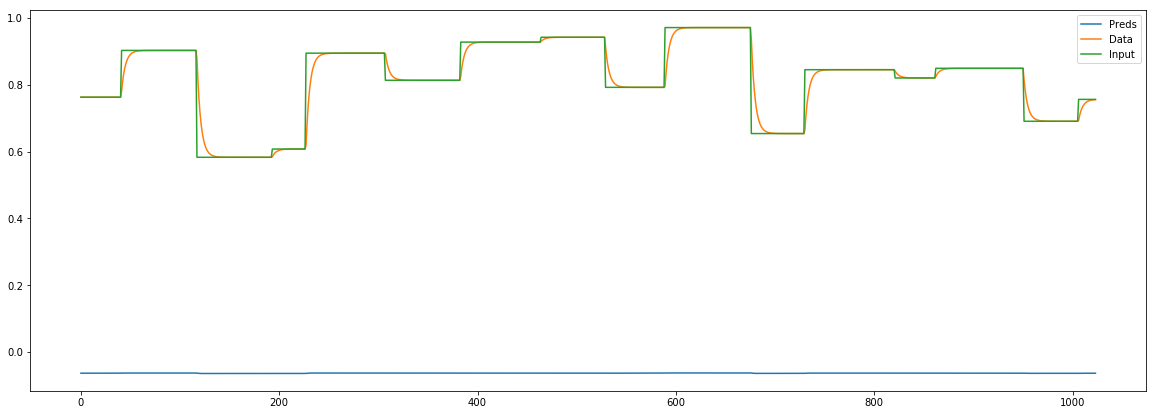

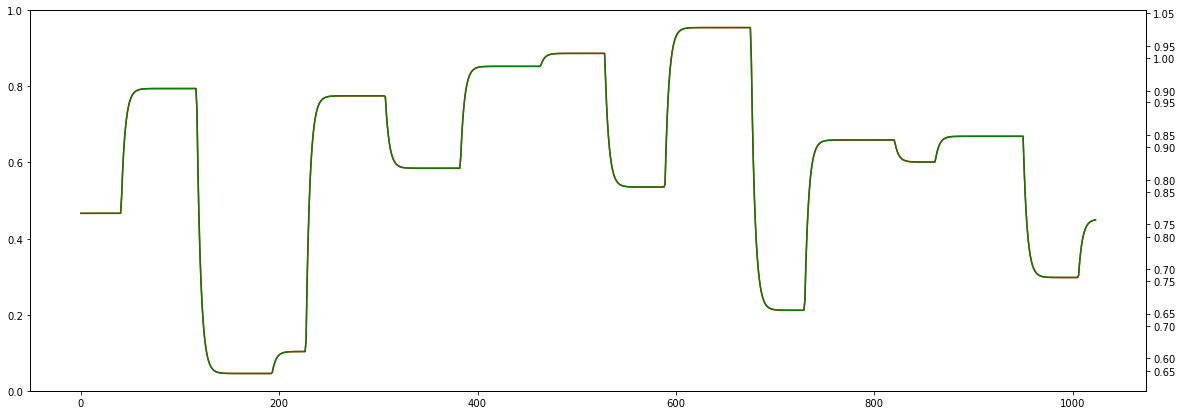

TEST AUX:


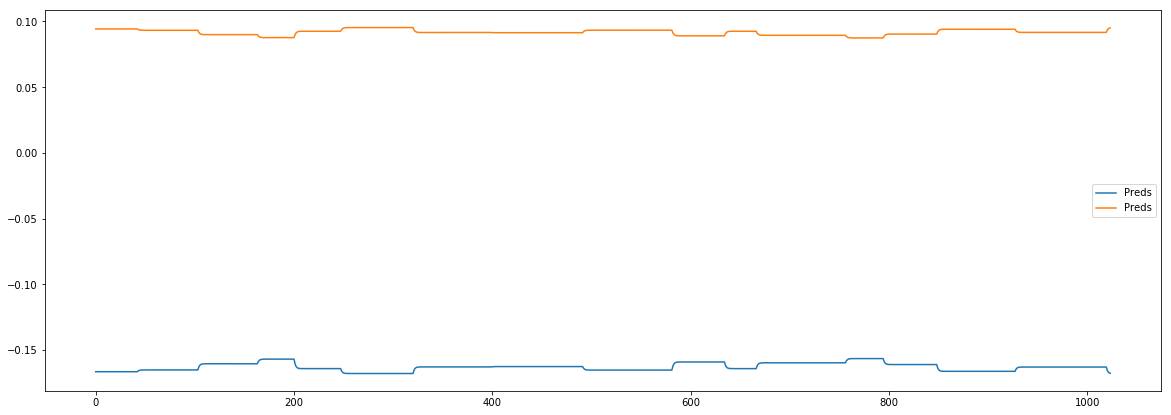

TEST PRED:


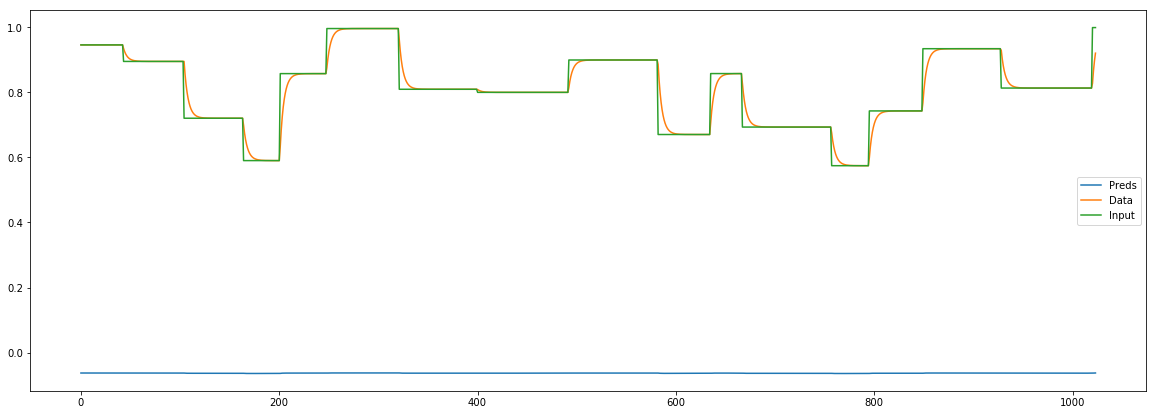

TEST RESID:


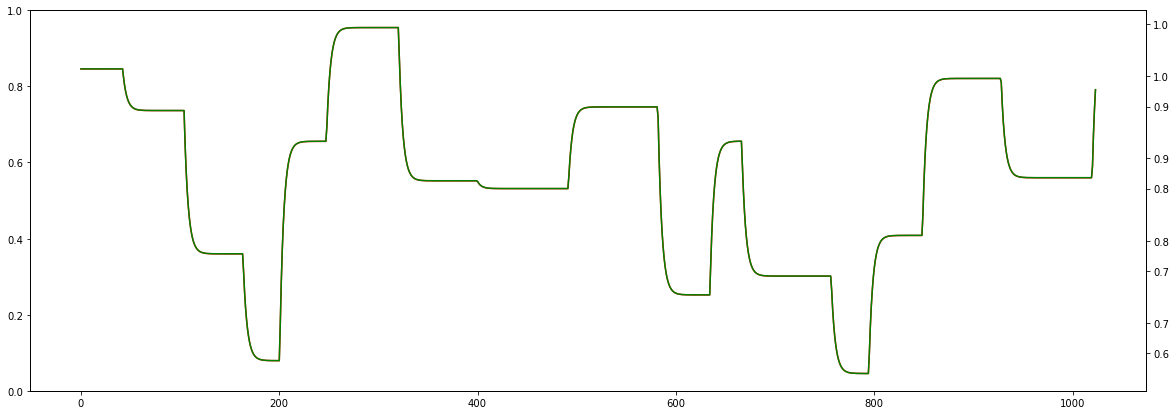

 Epoch [24]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


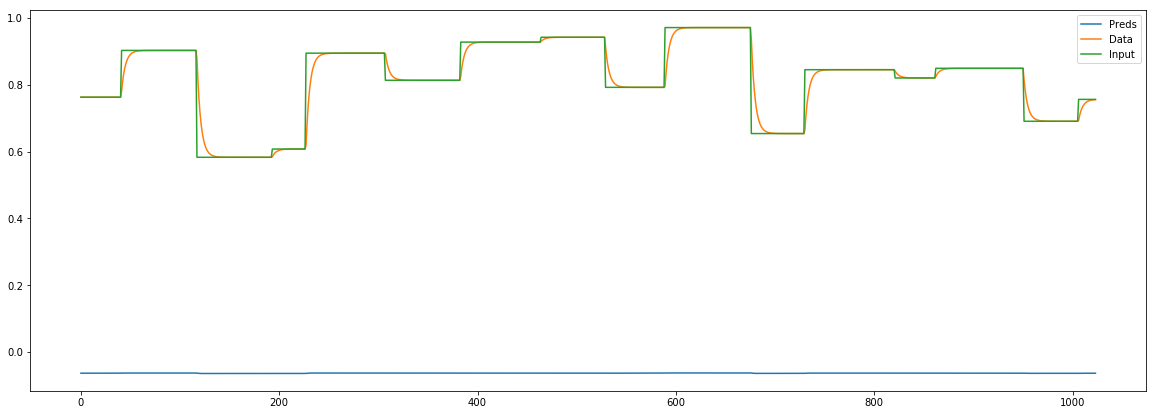

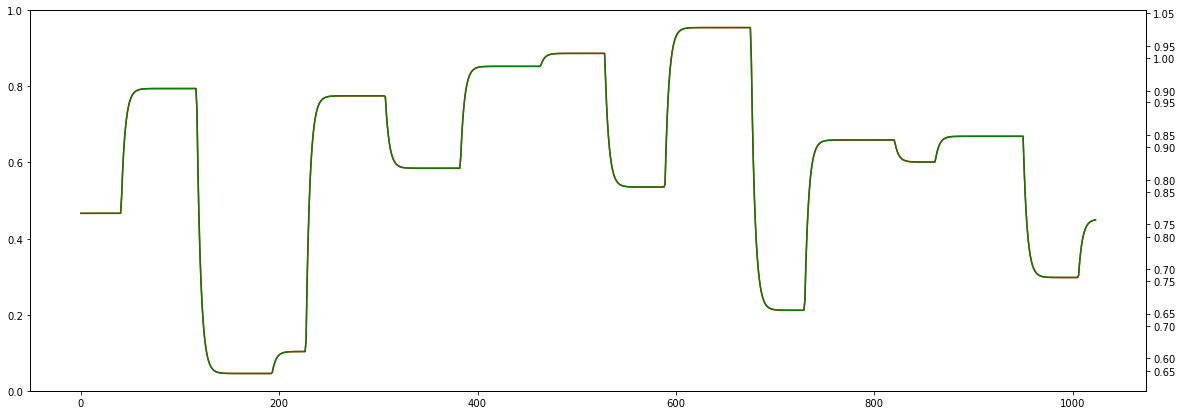

TEST AUX:


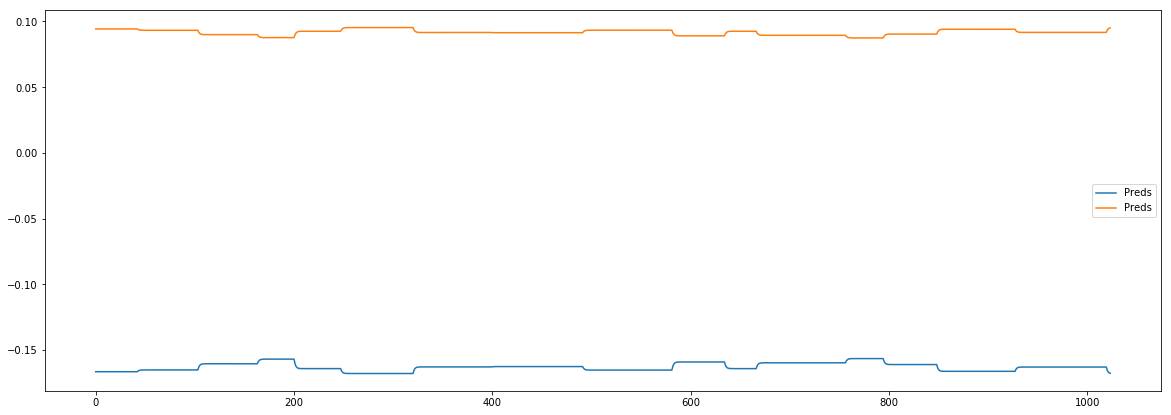

TEST PRED:


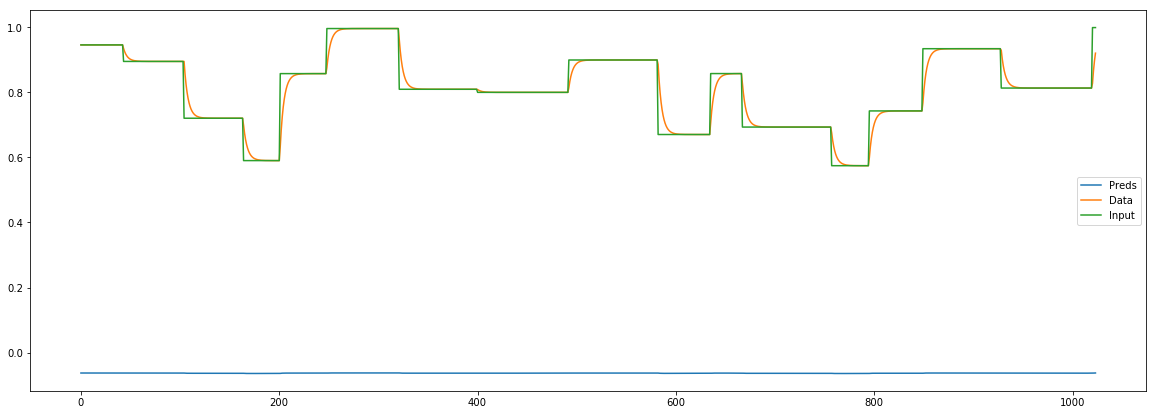

TEST RESID:


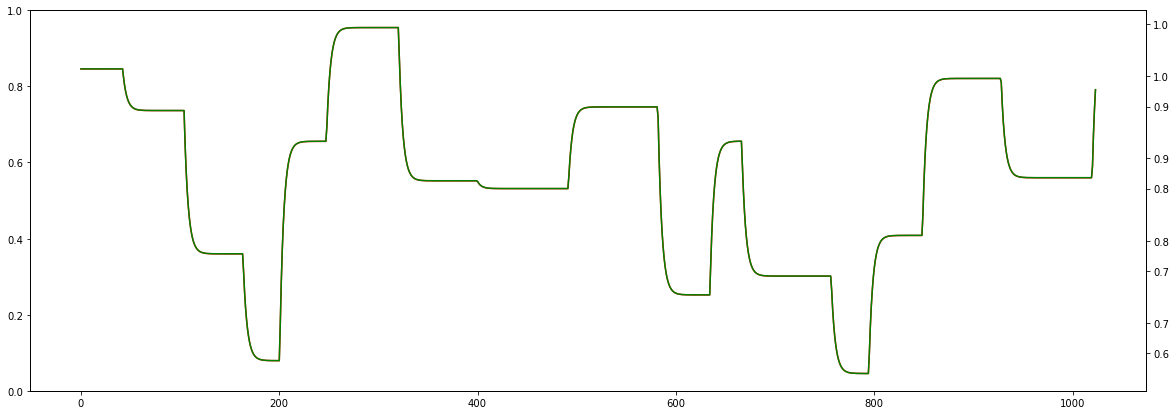

 Epoch [25]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


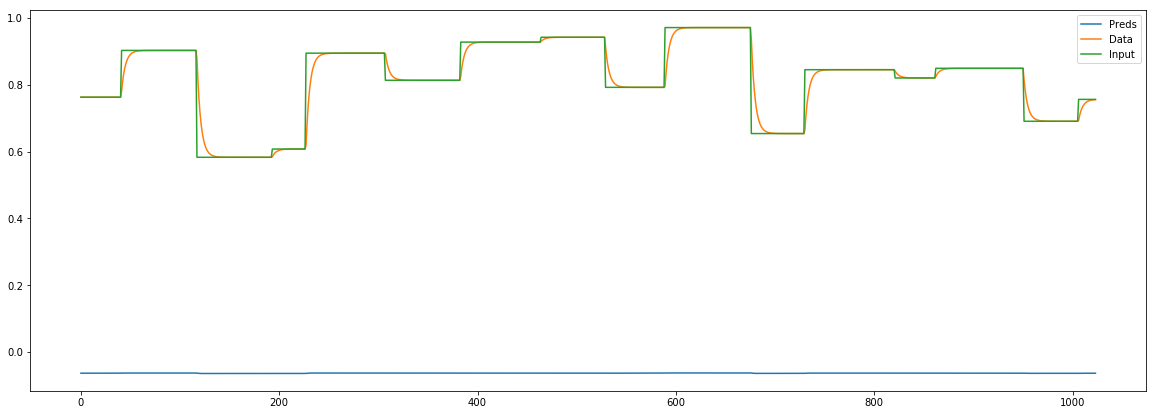

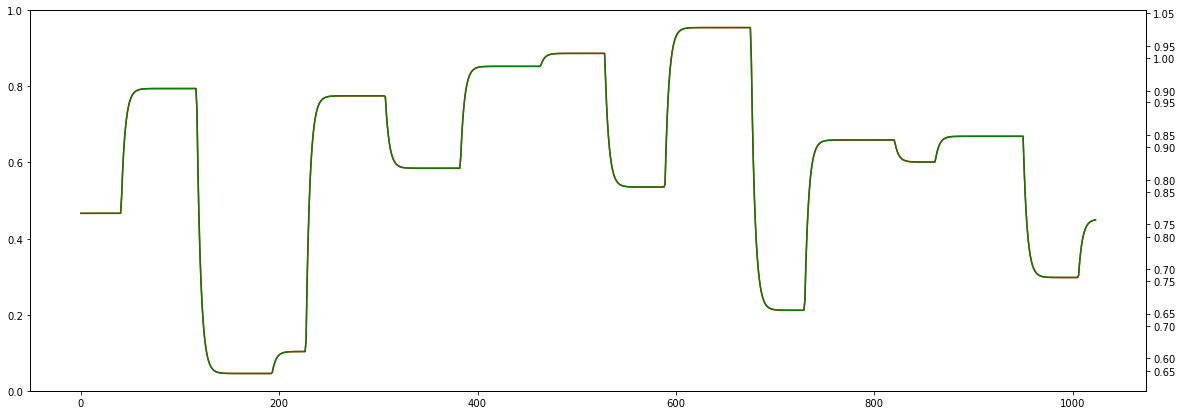

TEST AUX:


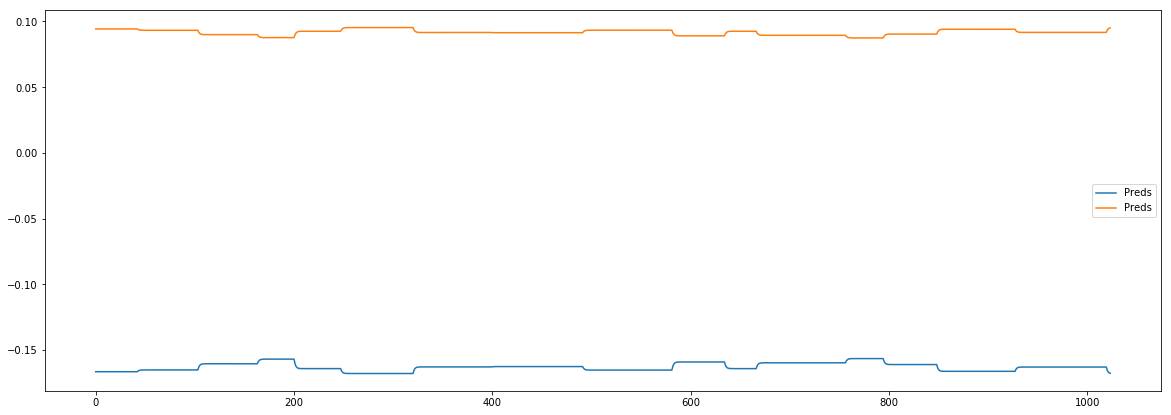

TEST PRED:


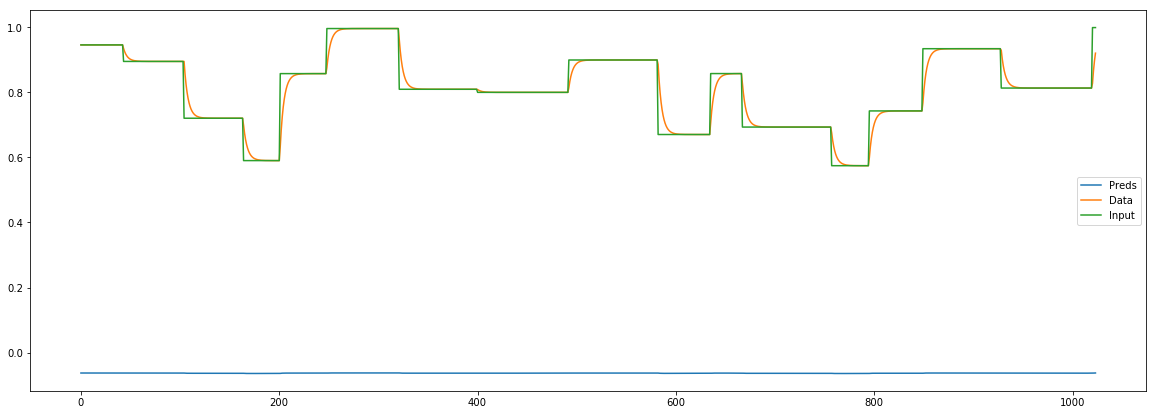

TEST RESID:


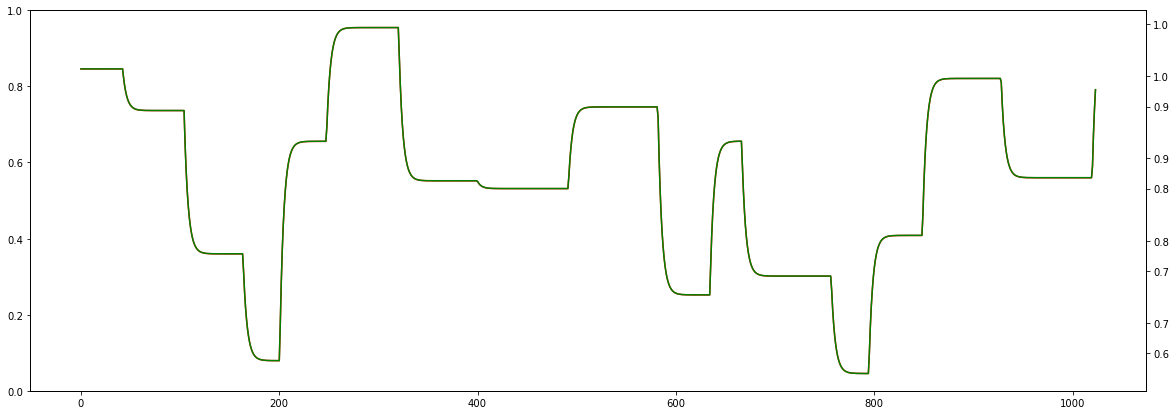

 Epoch [26]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


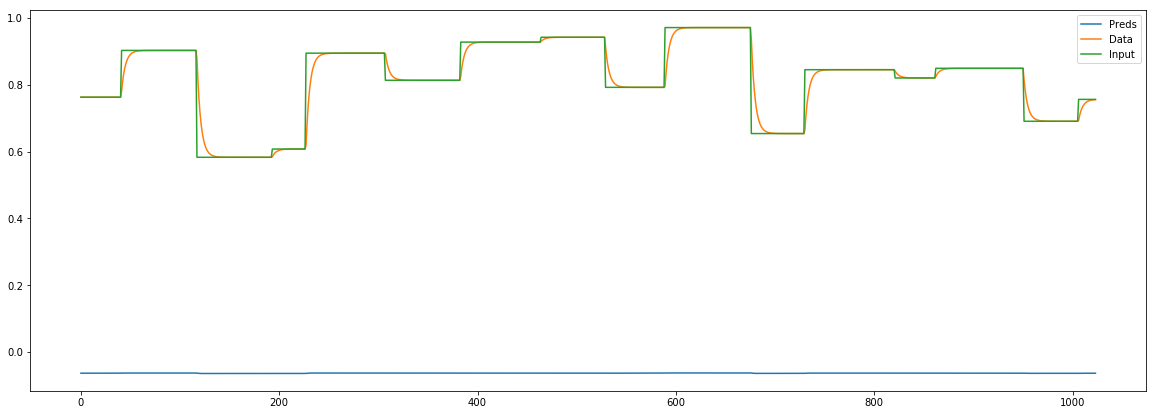

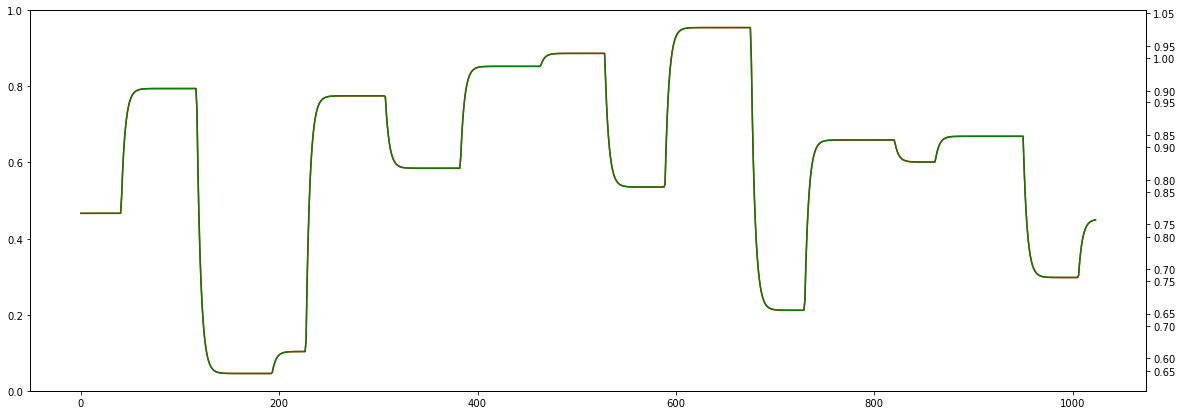

TEST AUX:


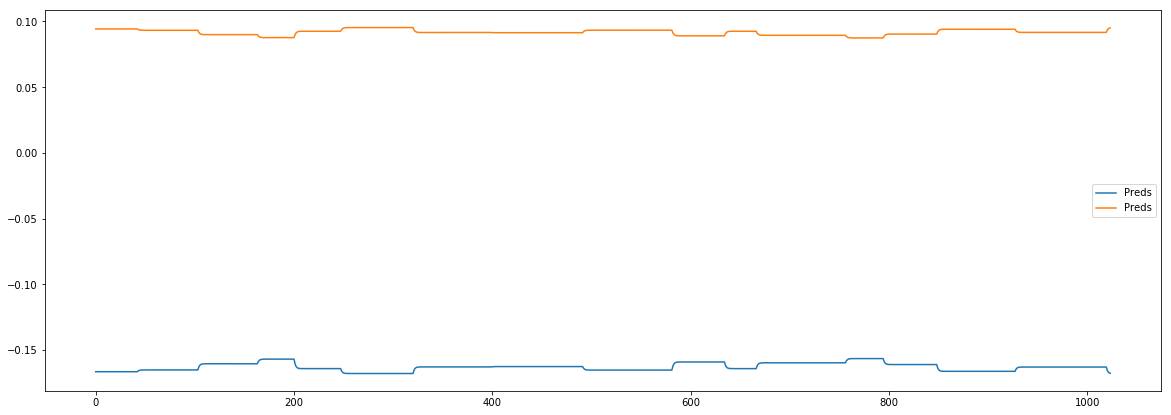

TEST PRED:


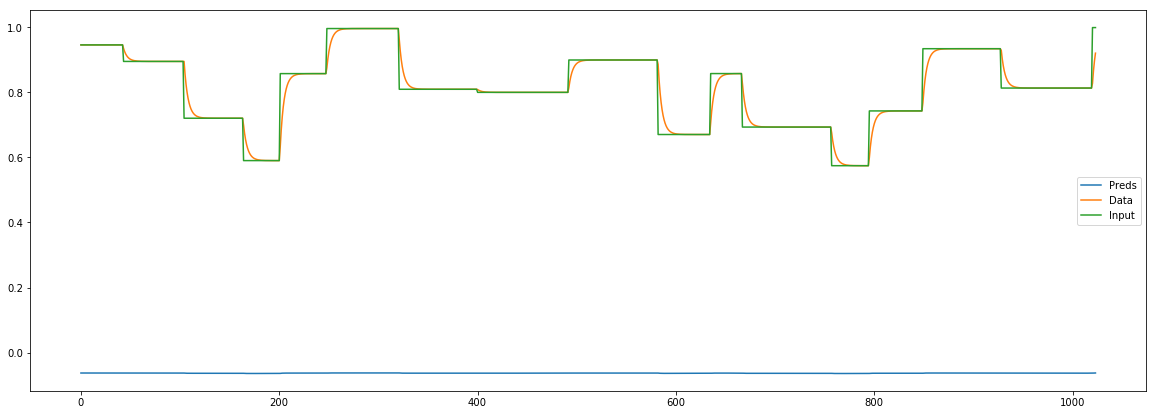

TEST RESID:


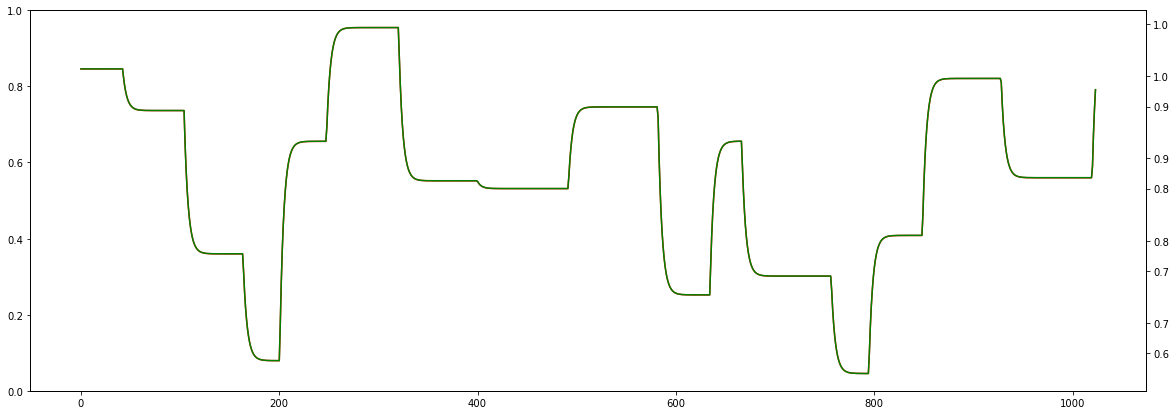

 Epoch [27]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


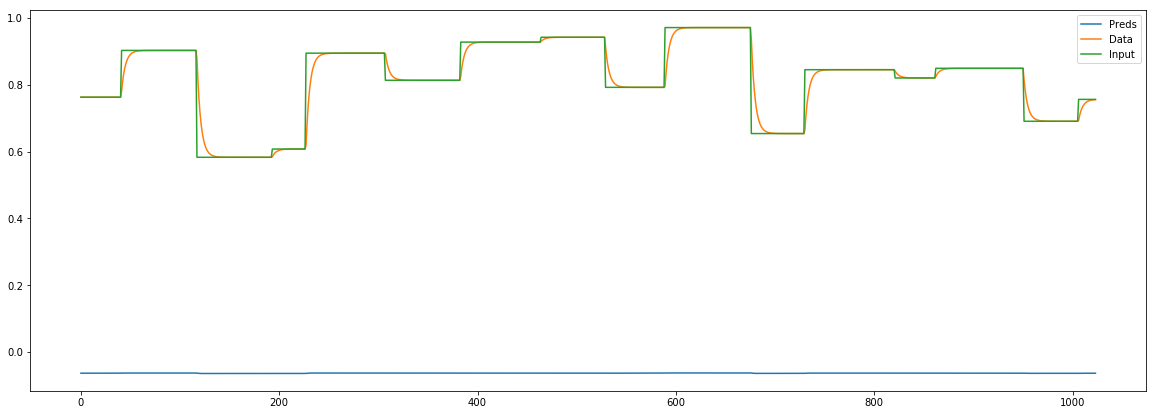

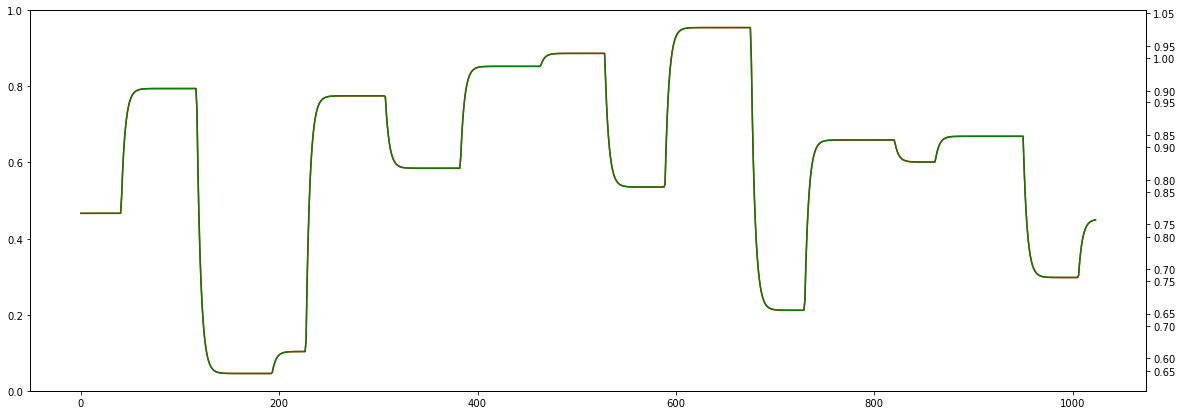

TEST AUX:


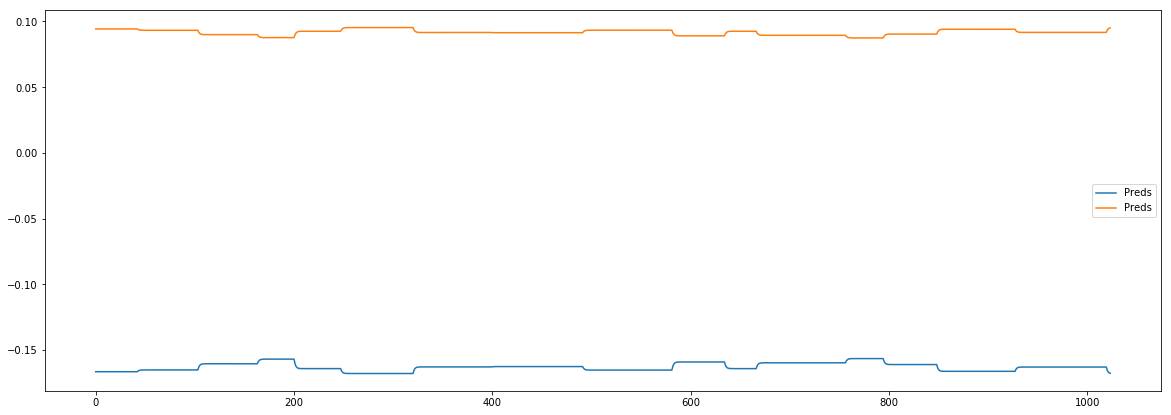

TEST PRED:


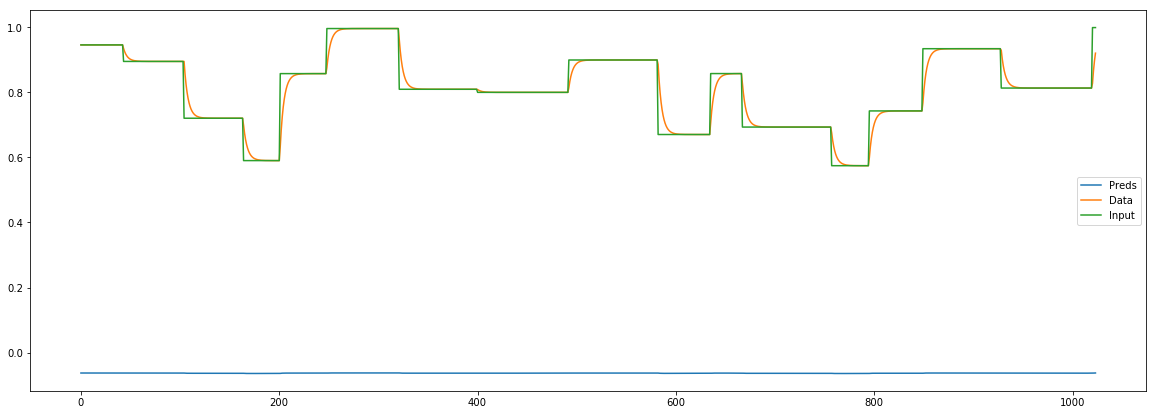

TEST RESID:


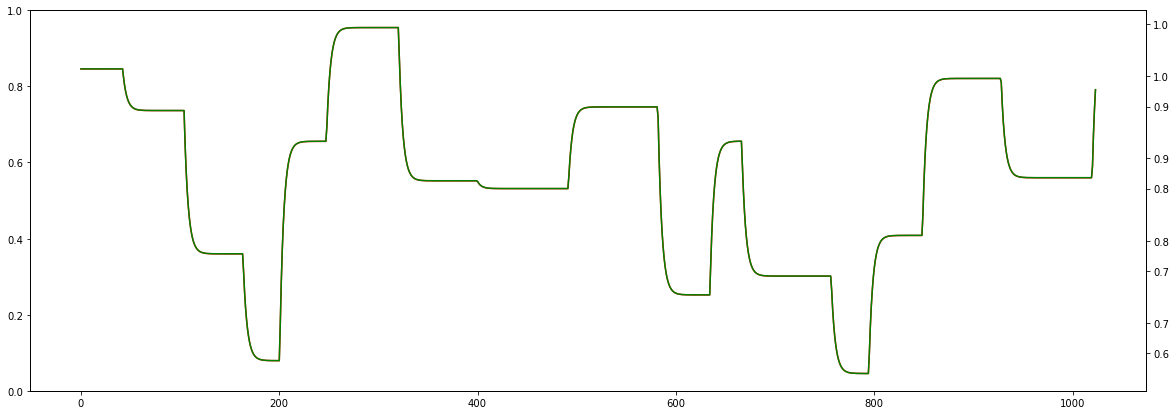

 Epoch [28]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


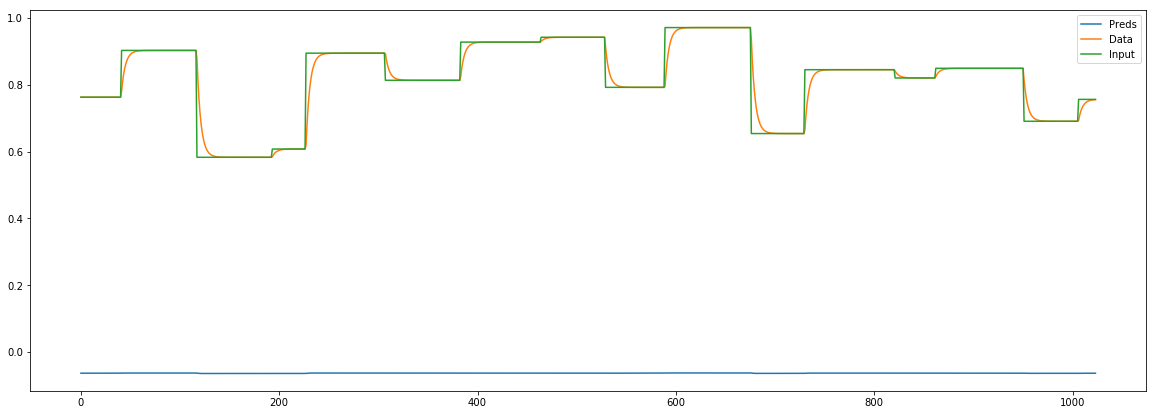

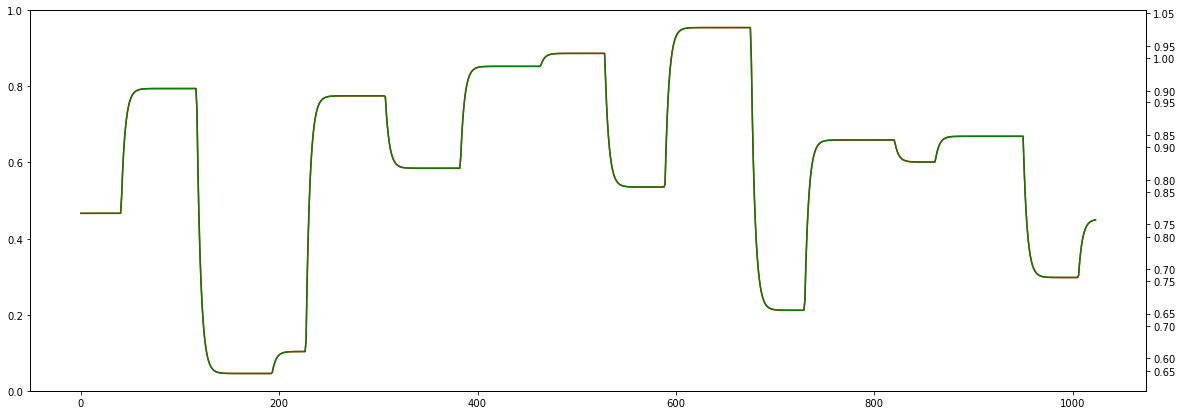

TEST AUX:


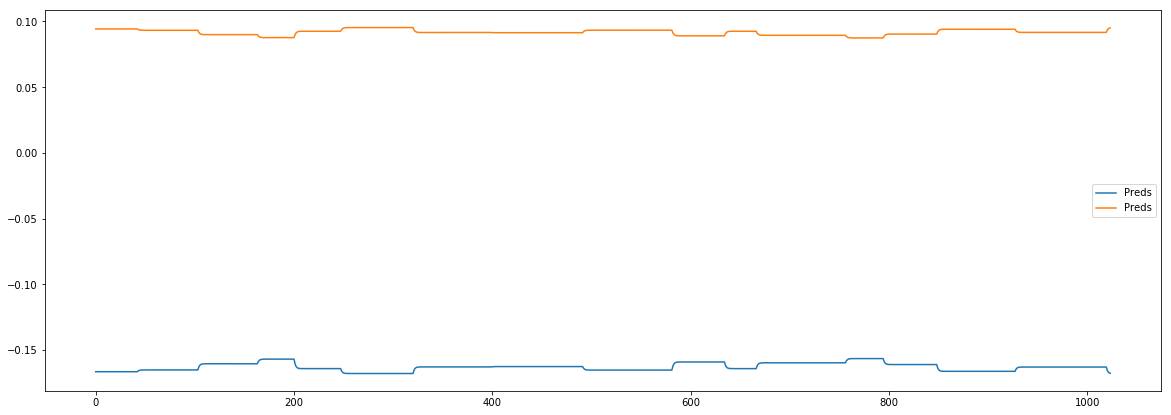

TEST PRED:


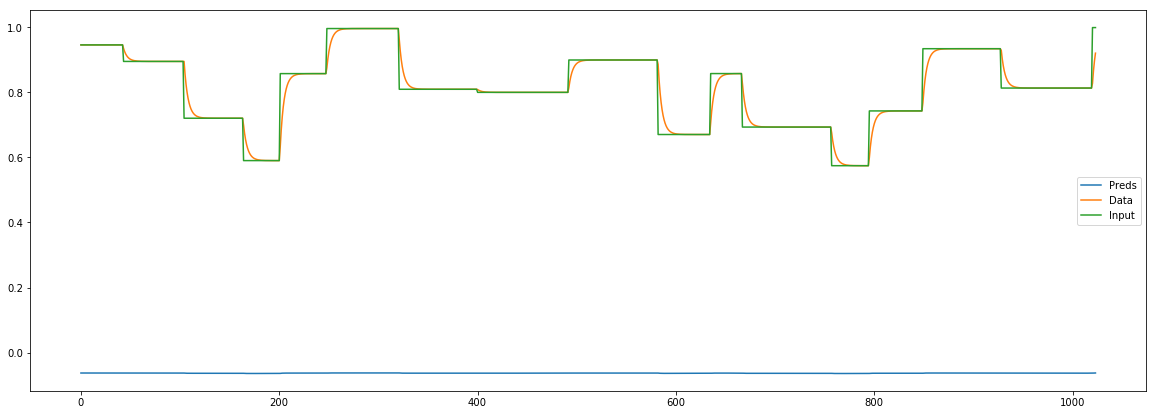

TEST RESID:


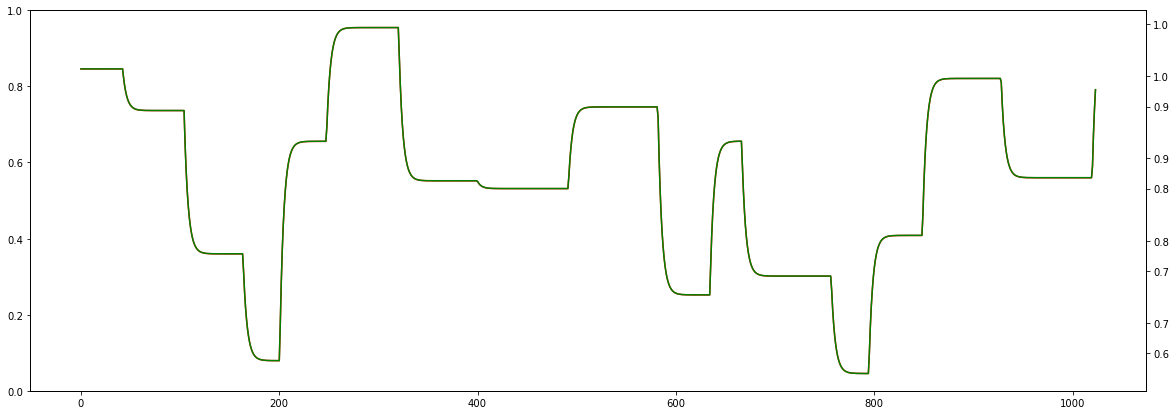

 Epoch [29]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


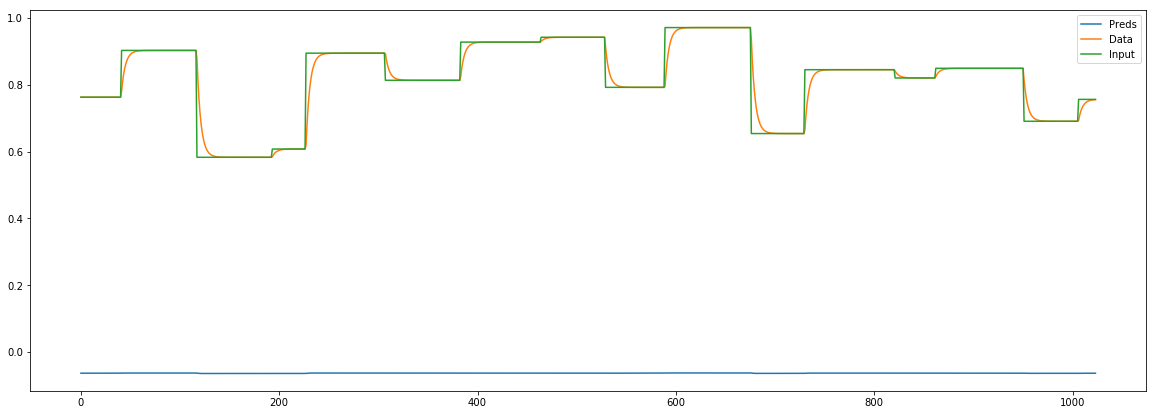

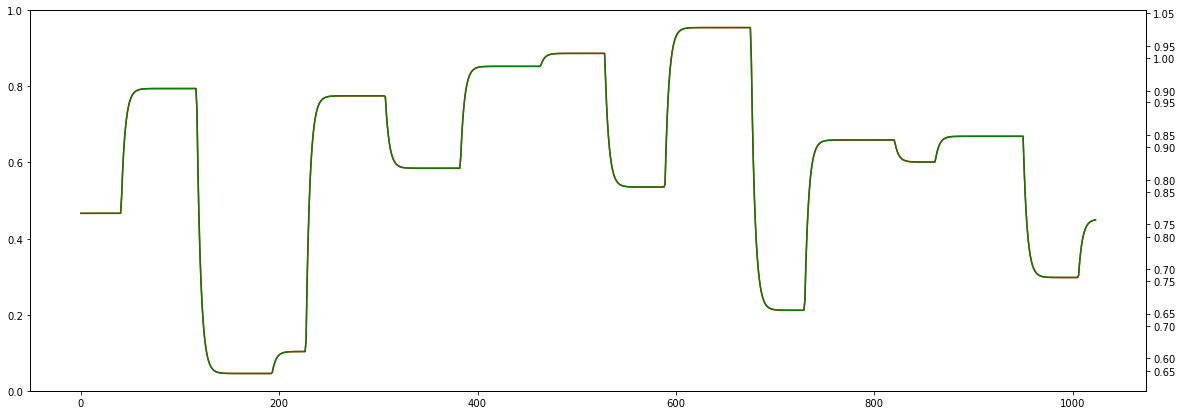

TEST AUX:


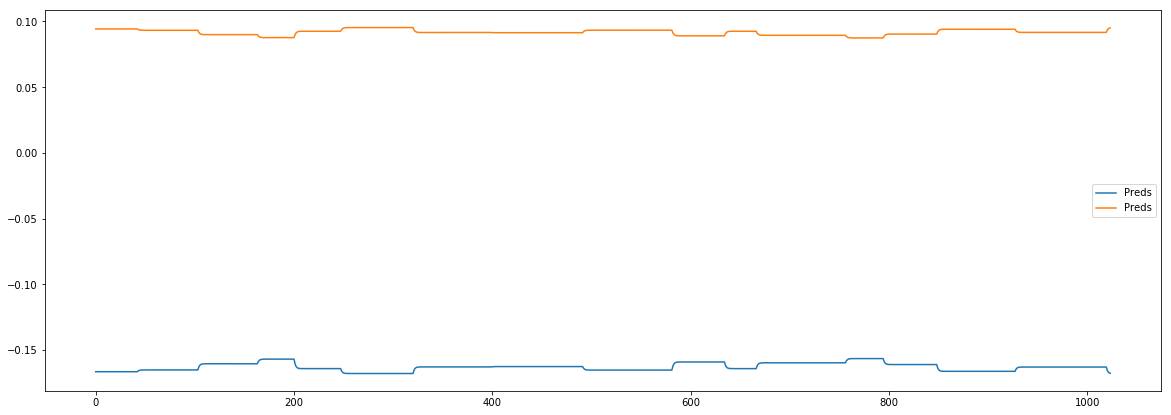

TEST PRED:


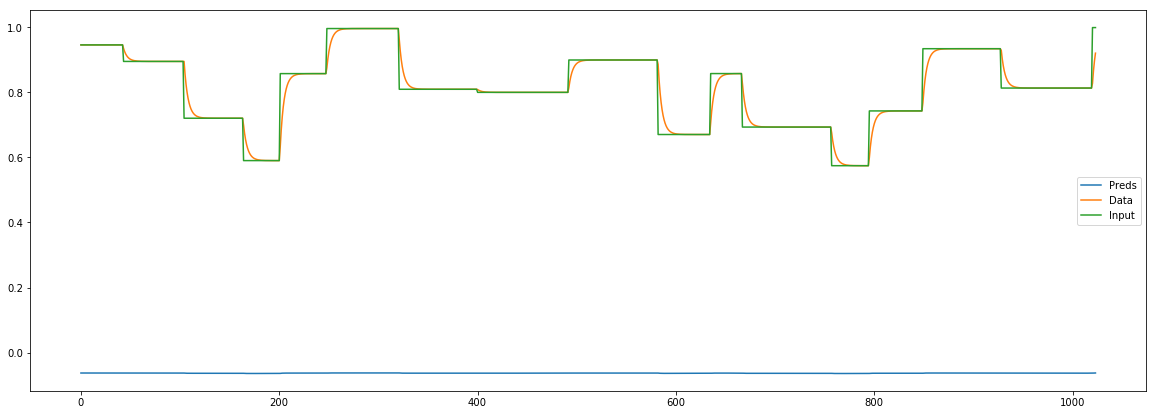

TEST RESID:


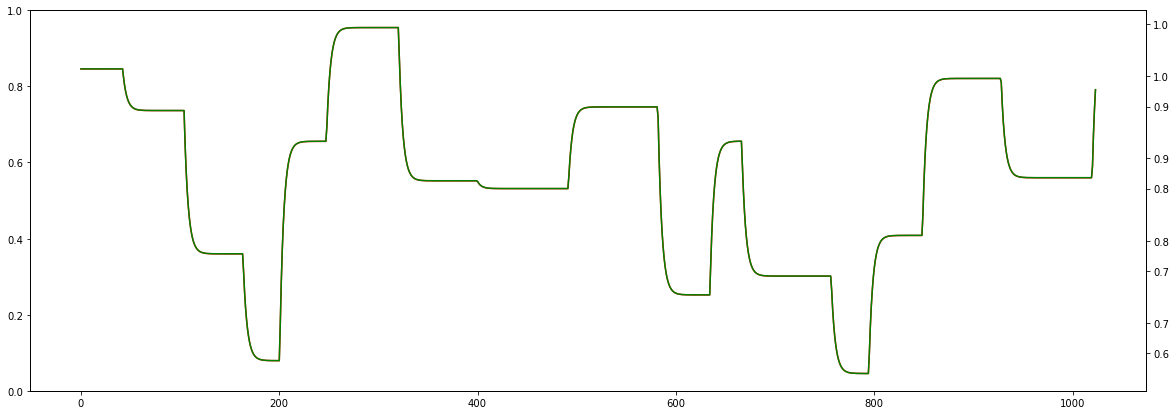

 Epoch [30]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


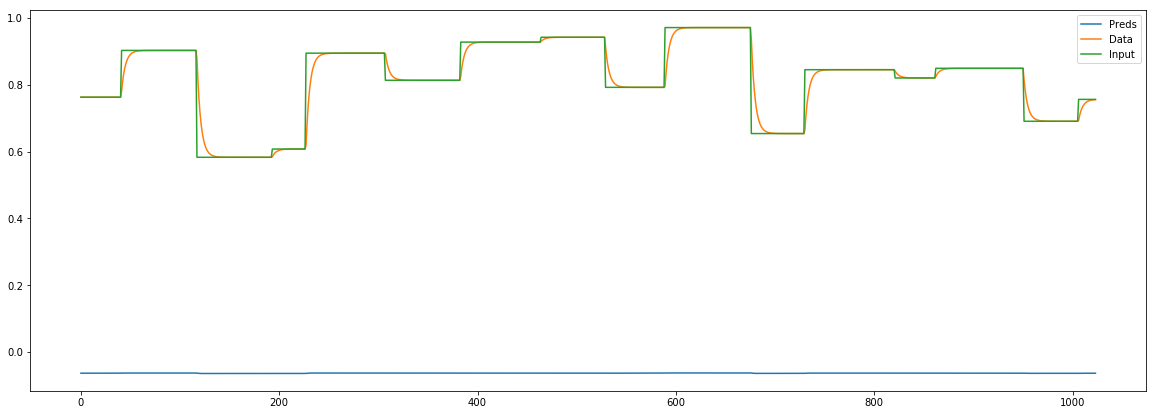

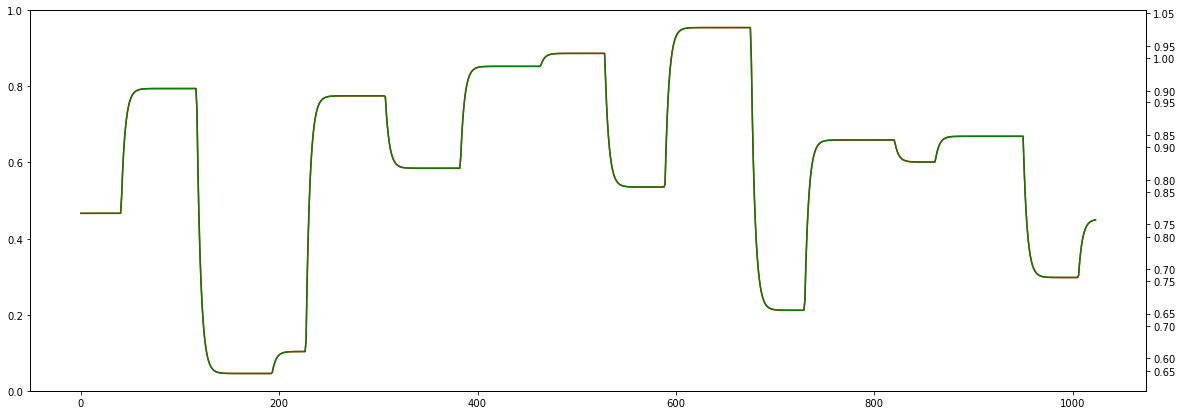

TEST AUX:


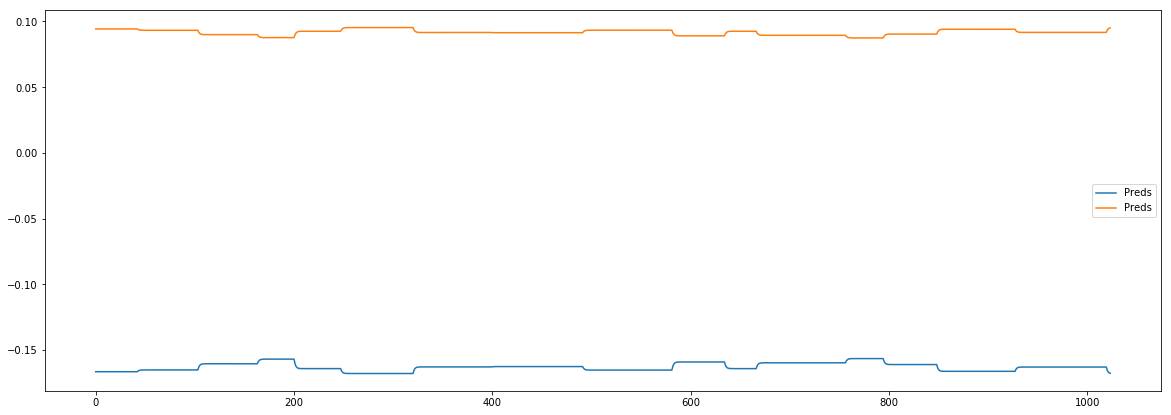

TEST PRED:


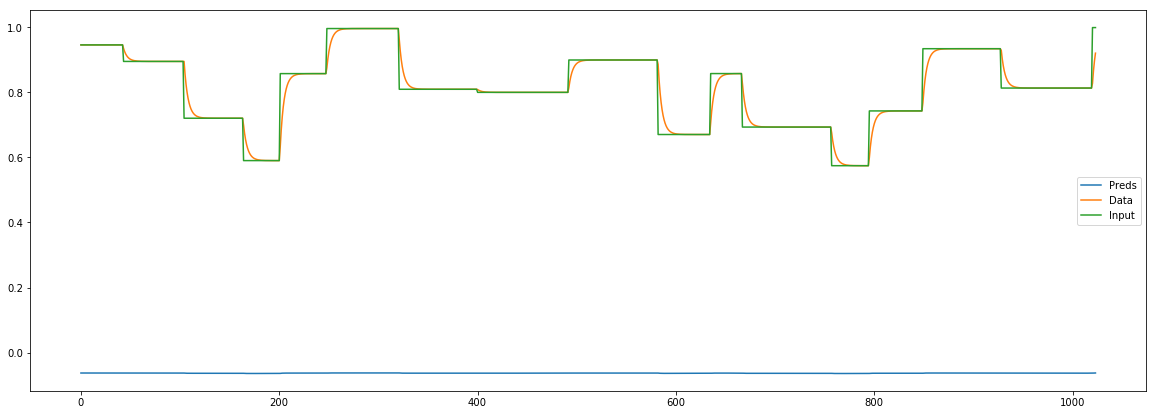

TEST RESID:


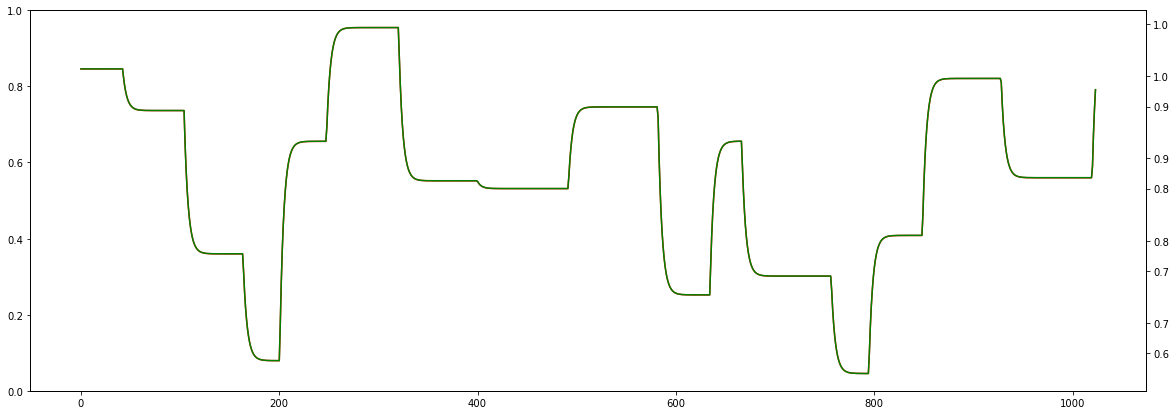

 Epoch [31]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


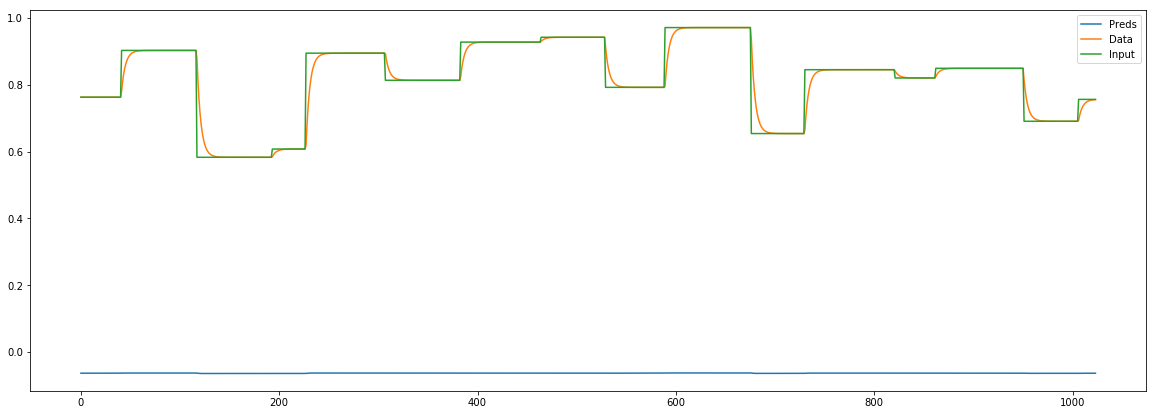

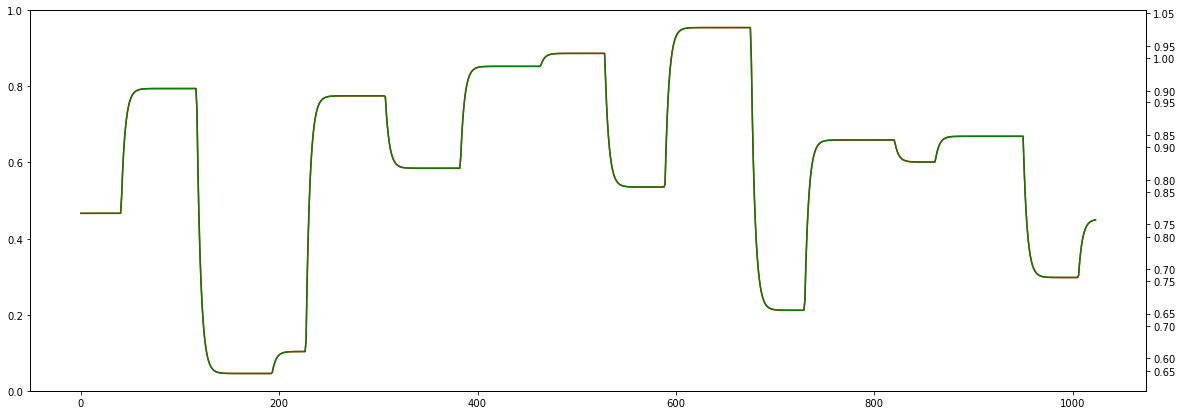

TEST AUX:


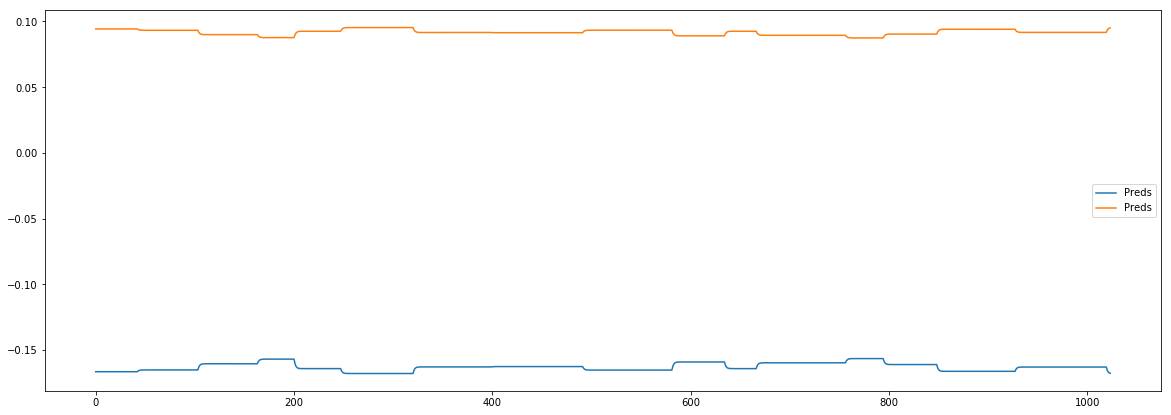

TEST PRED:


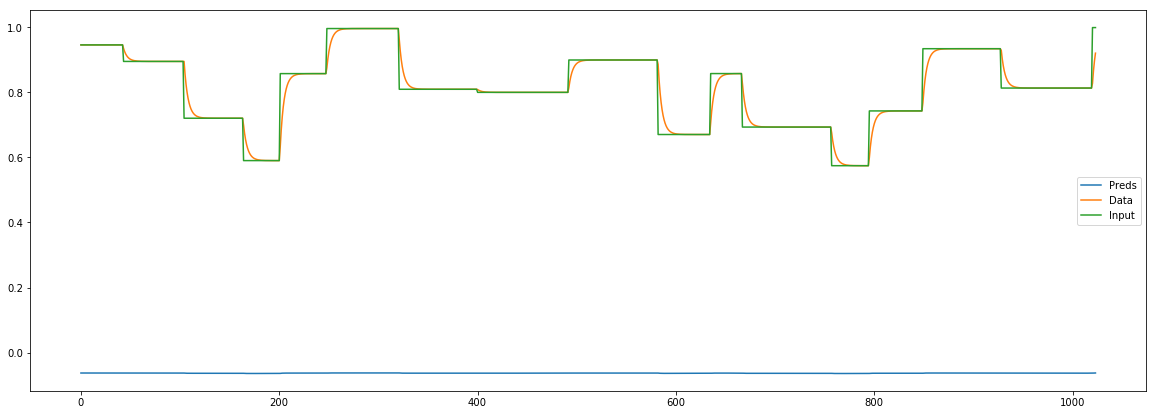

TEST RESID:


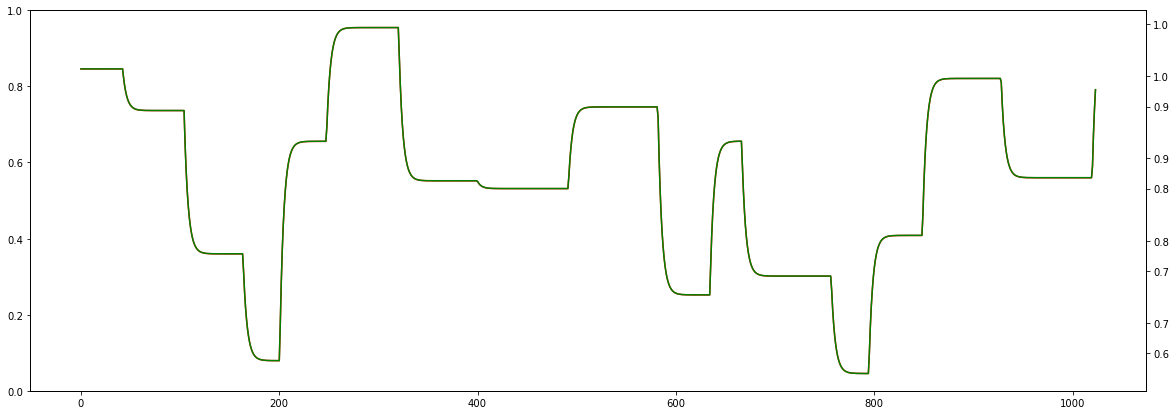

 Epoch [32]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


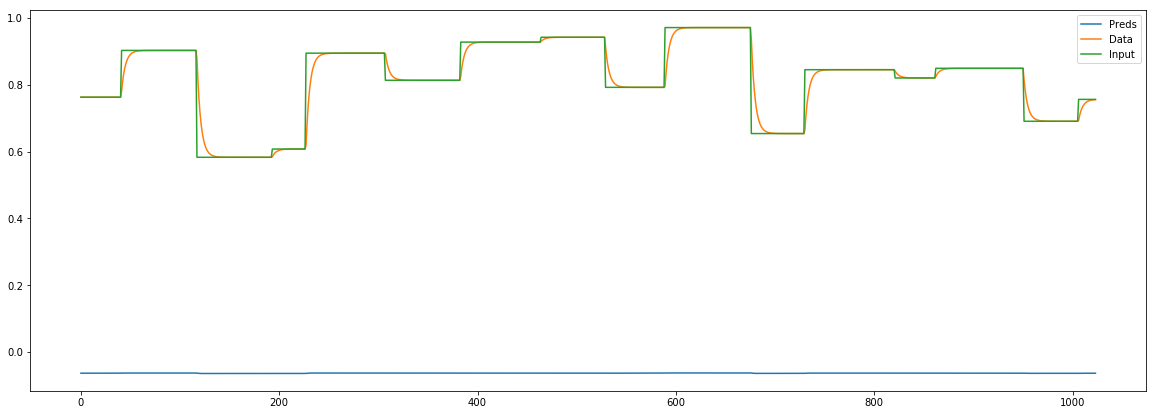

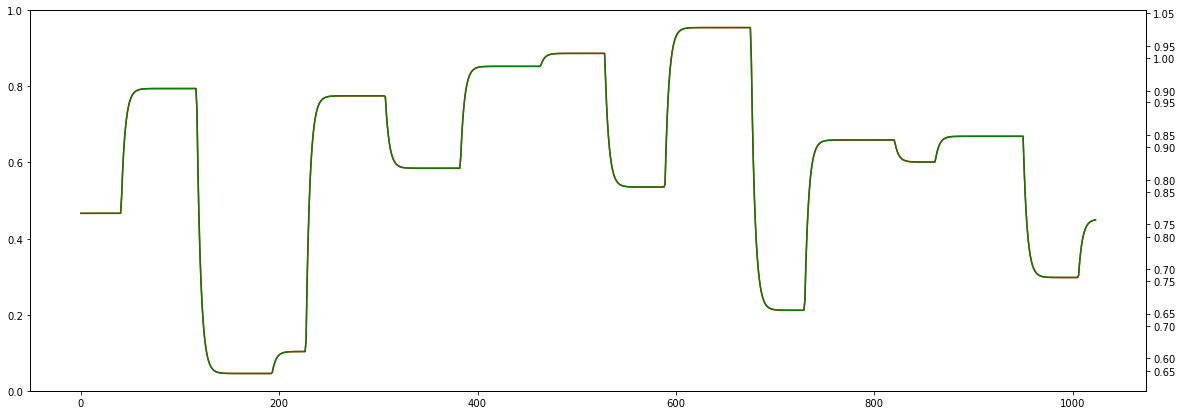

TEST AUX:


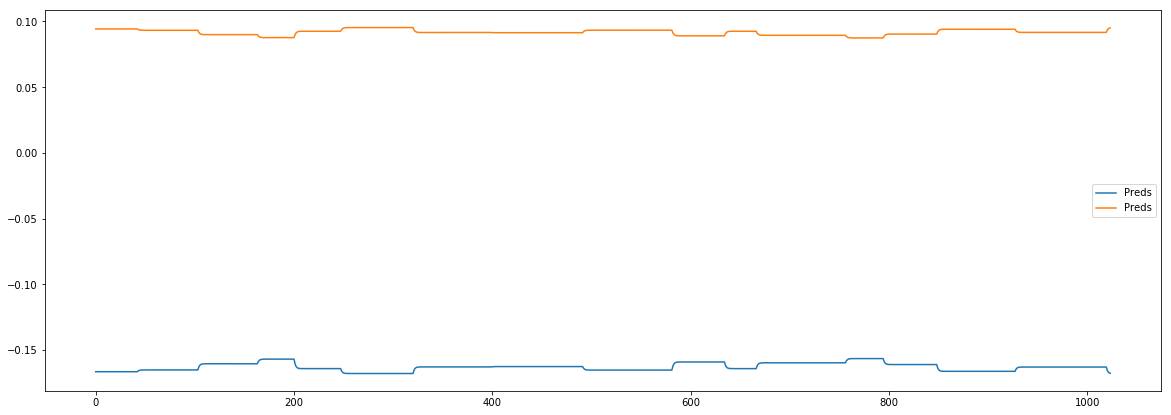

TEST PRED:


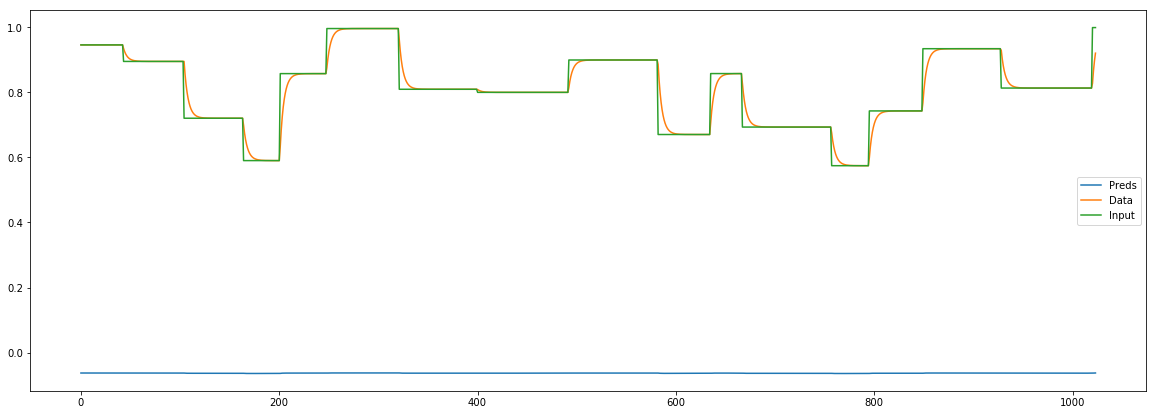

TEST RESID:


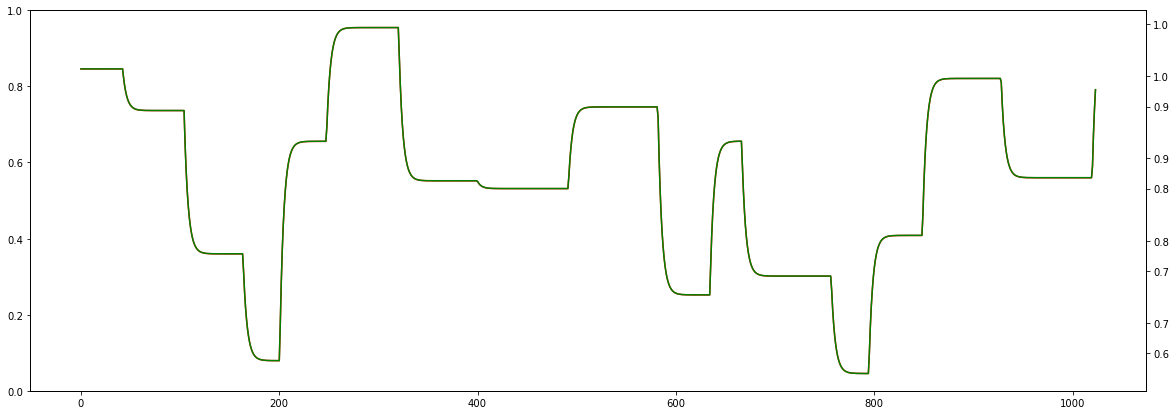

 Epoch [33]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


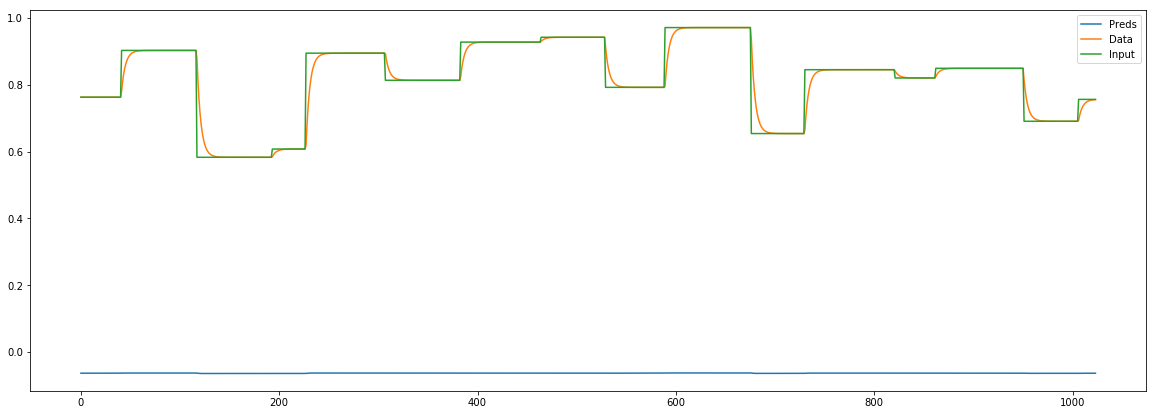

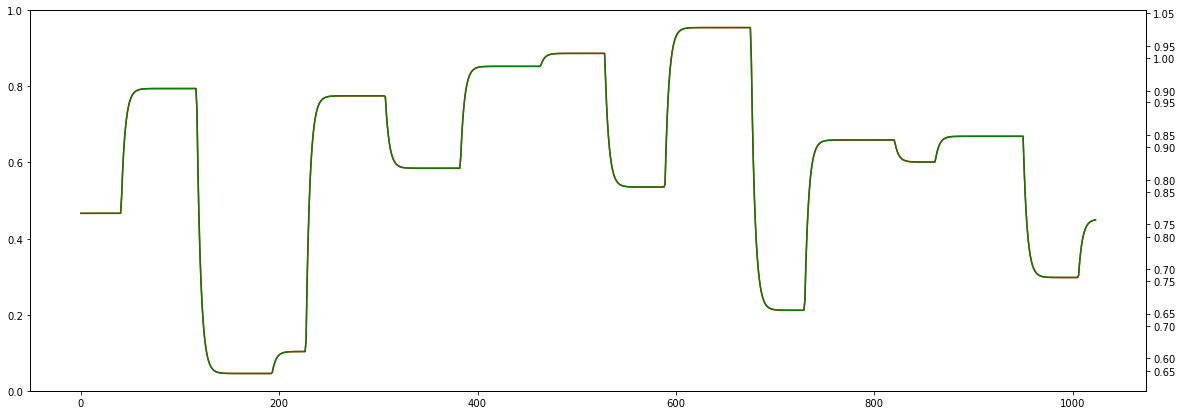

TEST AUX:


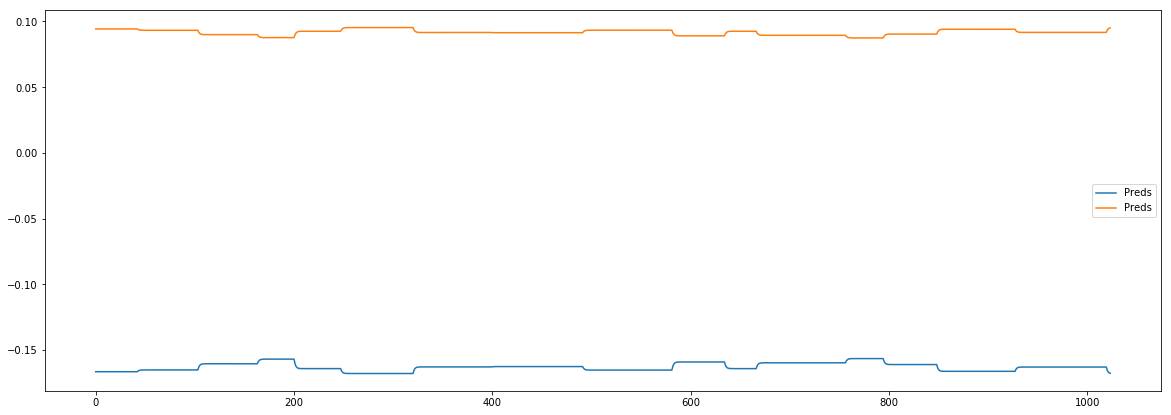

TEST PRED:


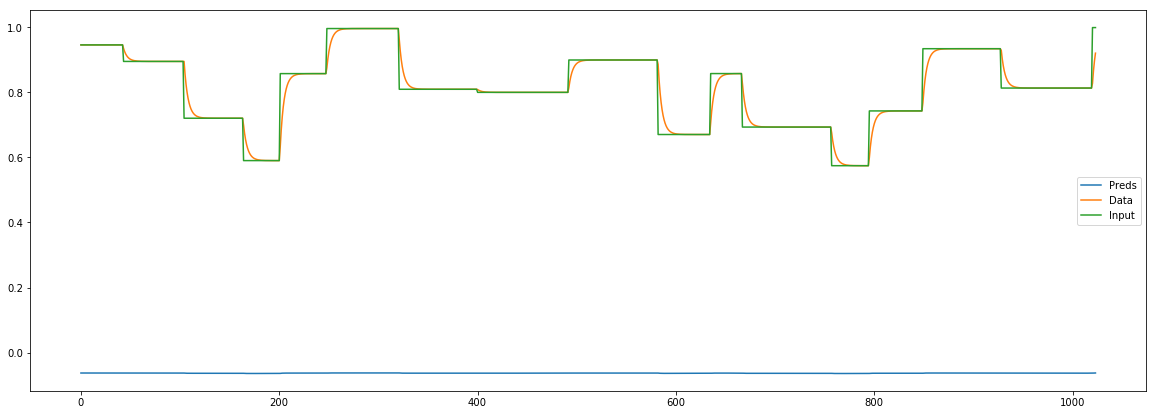

TEST RESID:


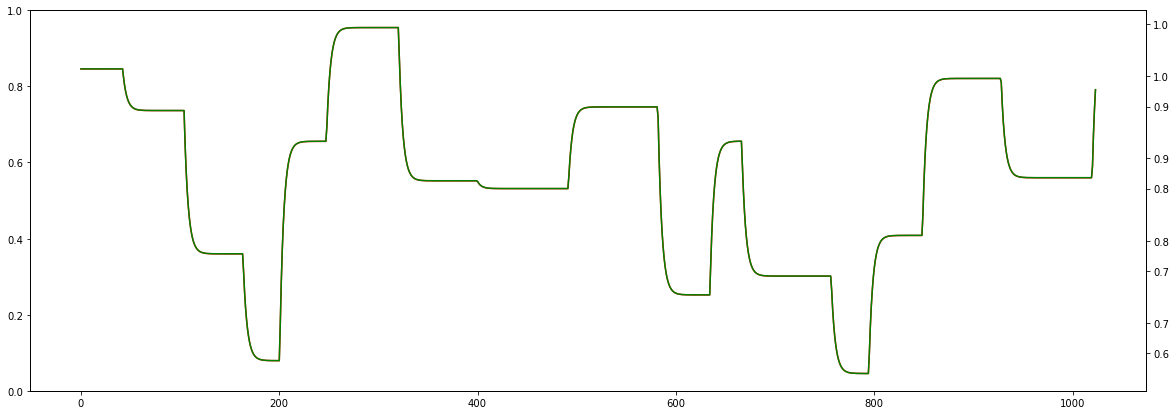

 Epoch [34]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


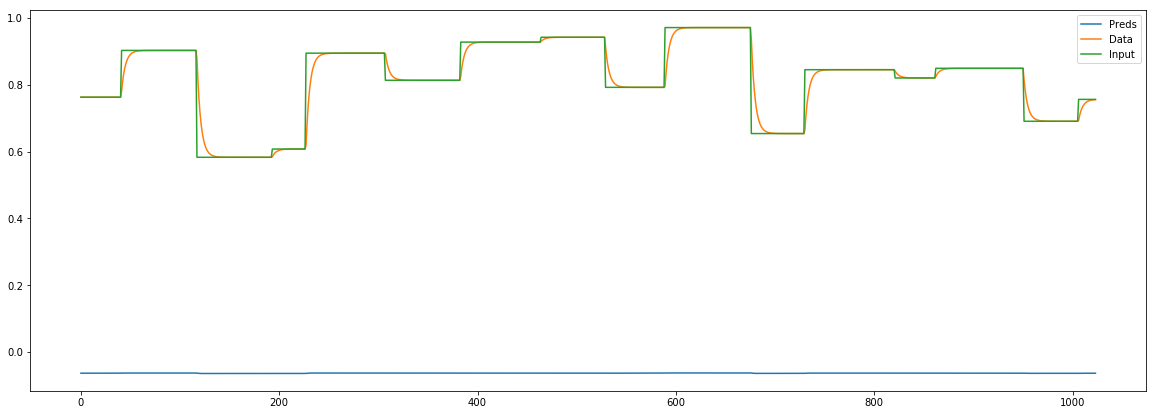

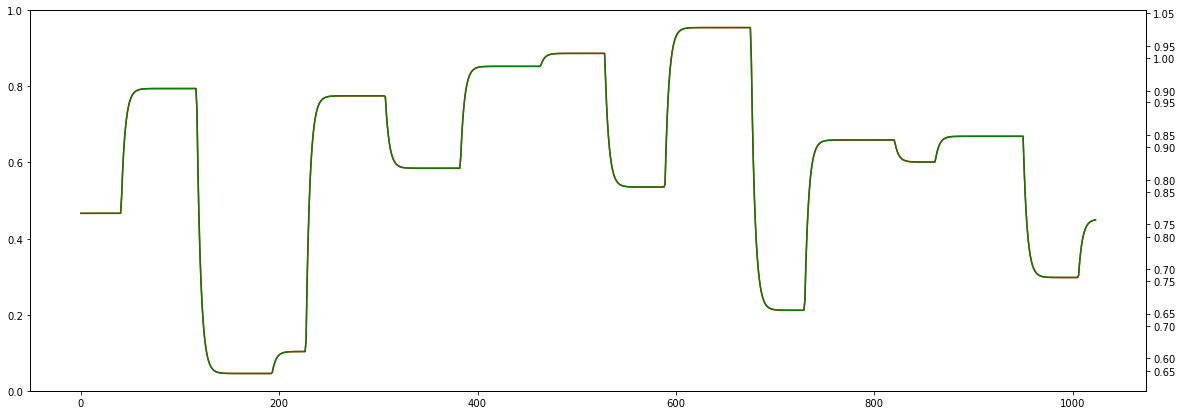

TEST AUX:


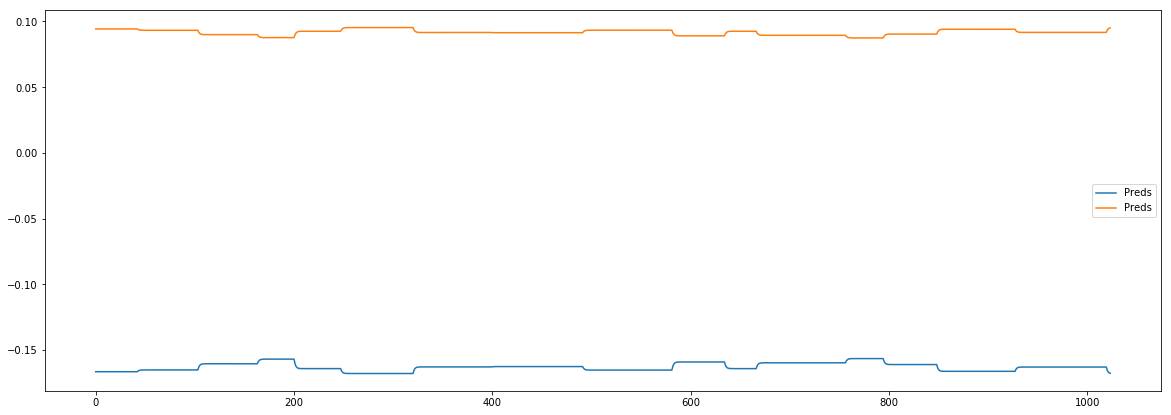

TEST PRED:


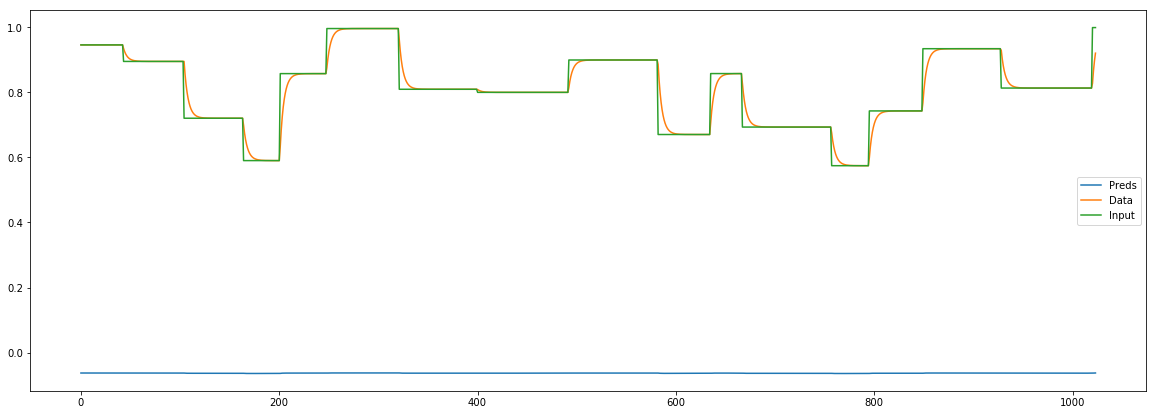

TEST RESID:


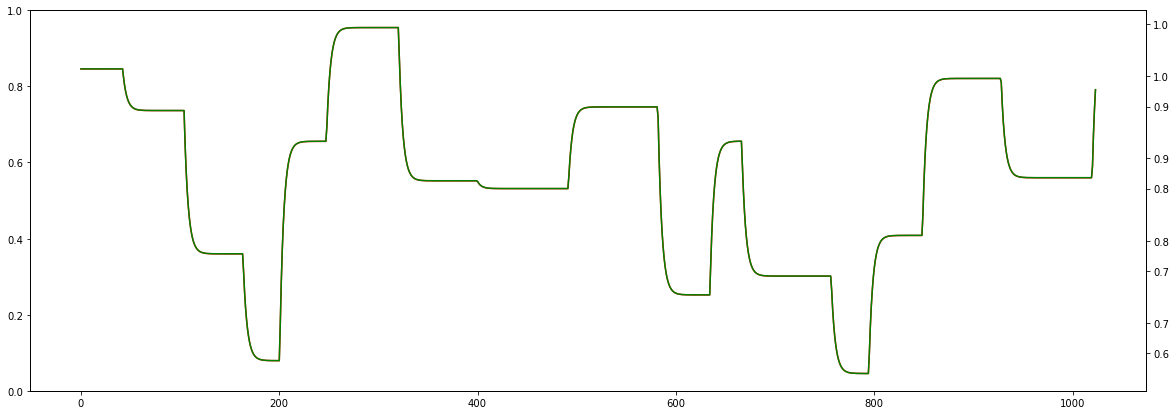

 Epoch [35]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


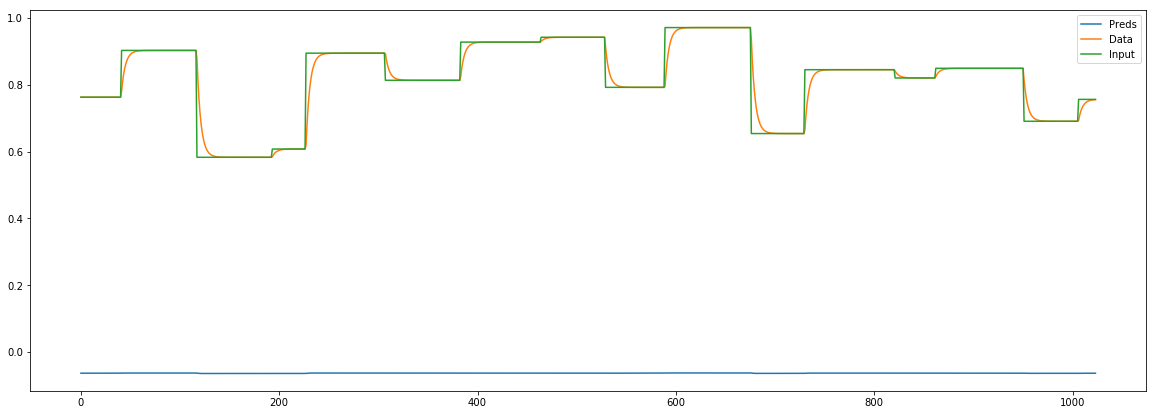

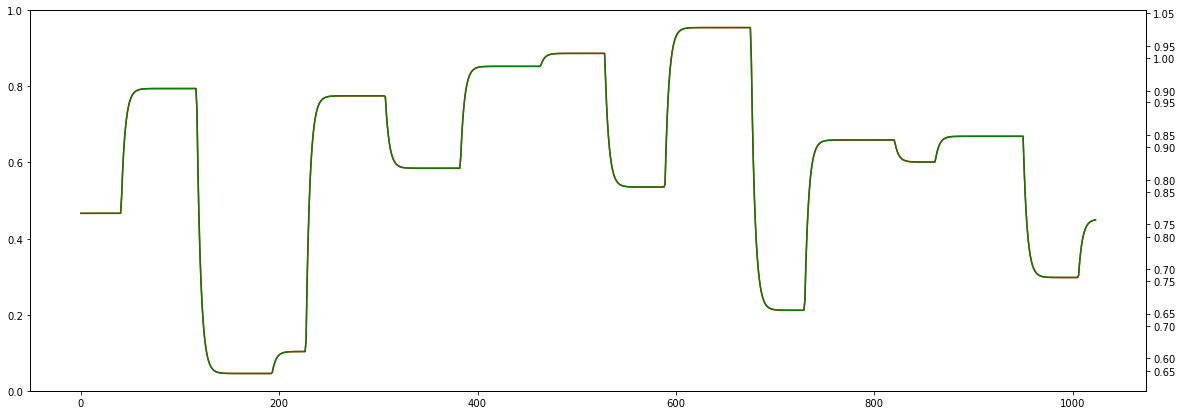

TEST AUX:


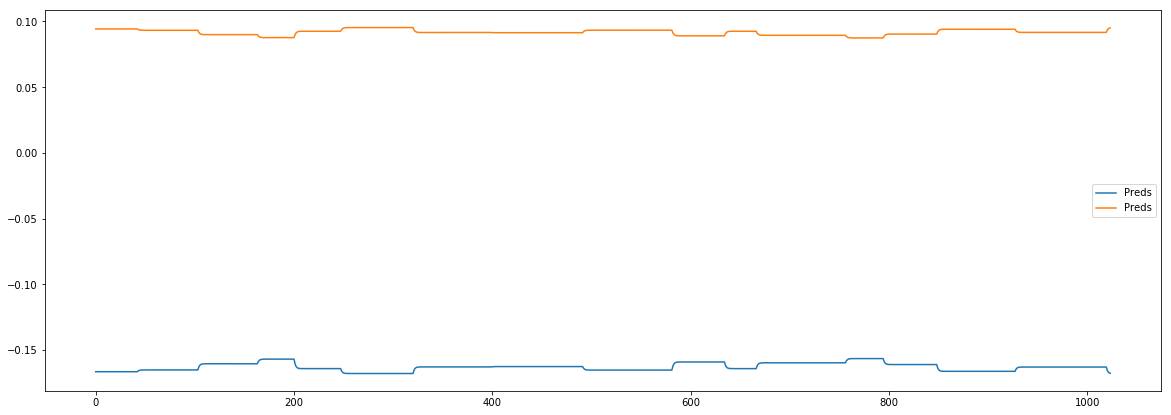

TEST PRED:


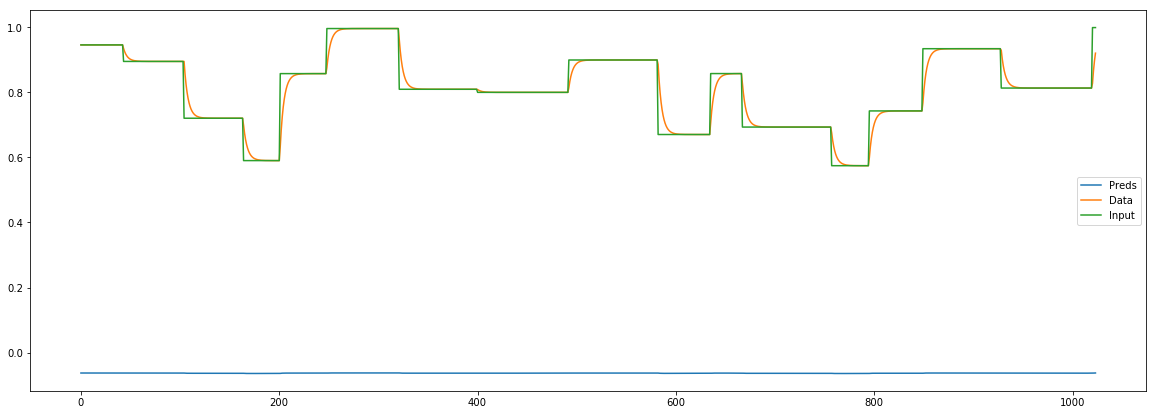

TEST RESID:


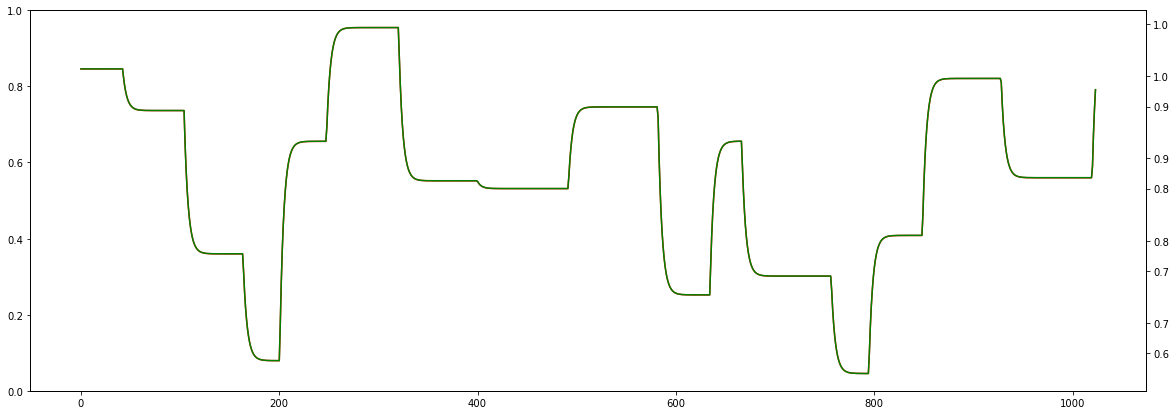

 Epoch [36]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


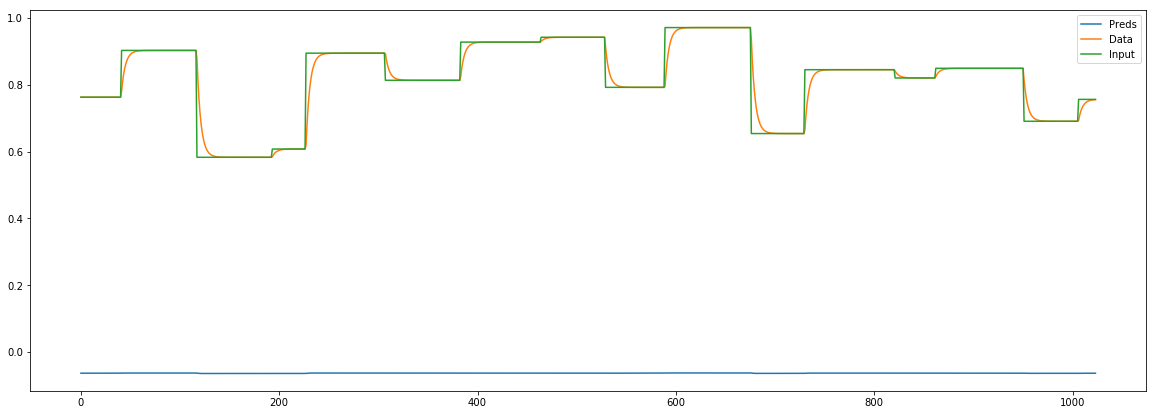

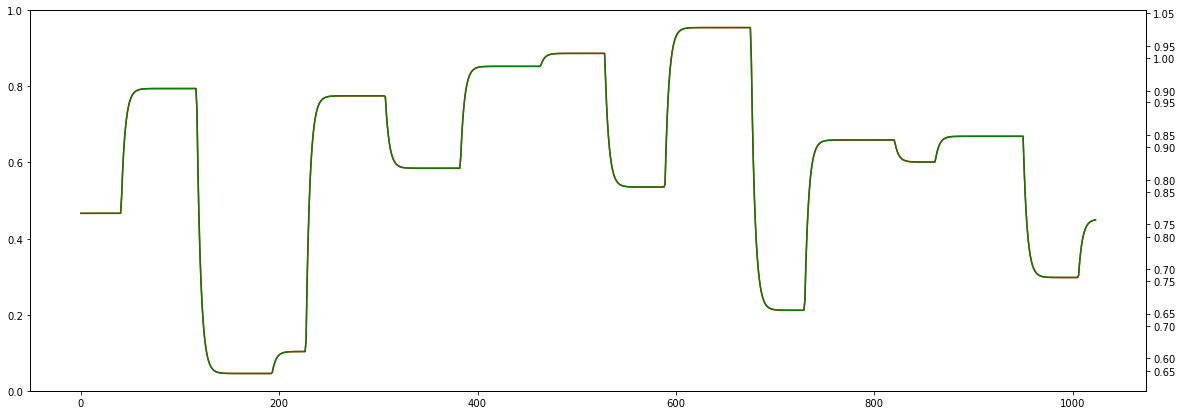

TEST AUX:


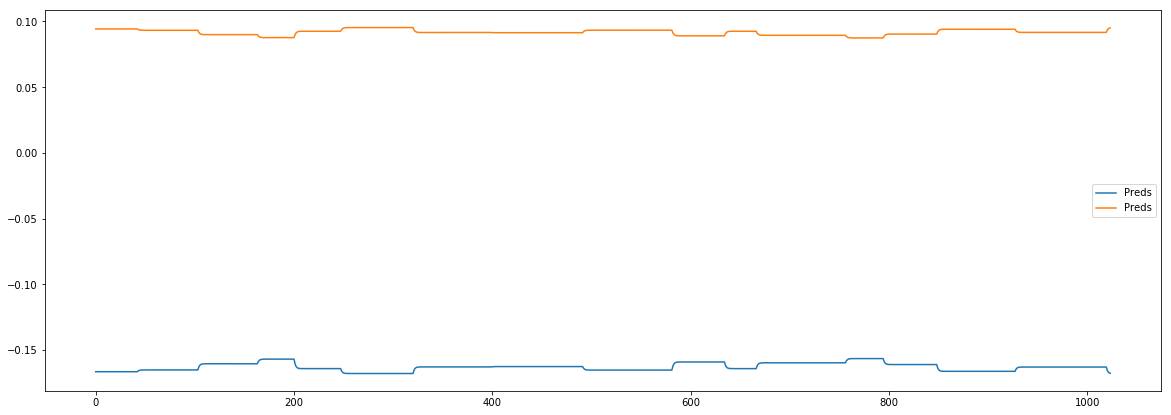

TEST PRED:


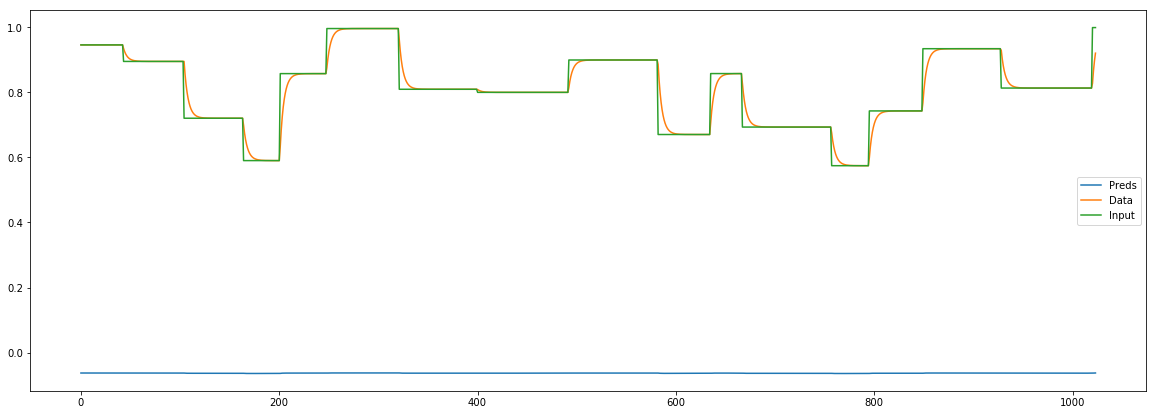

TEST RESID:


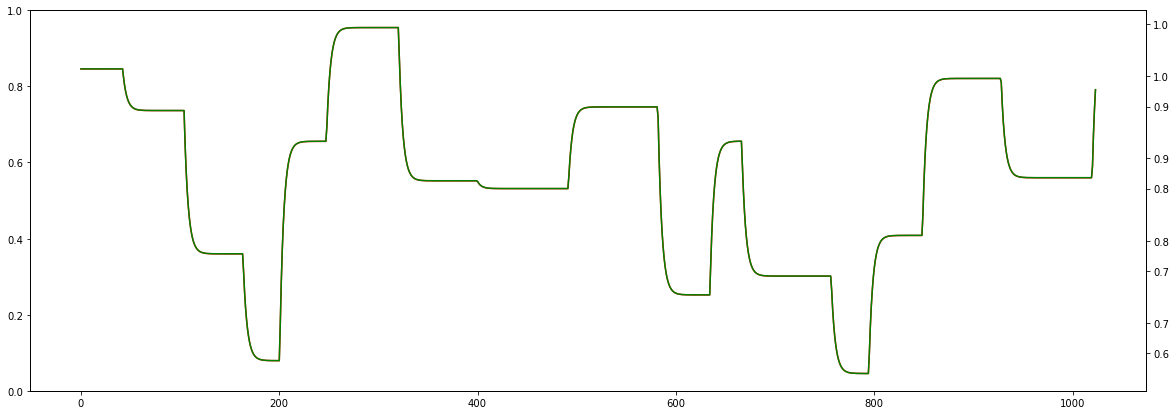

 Epoch [37]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


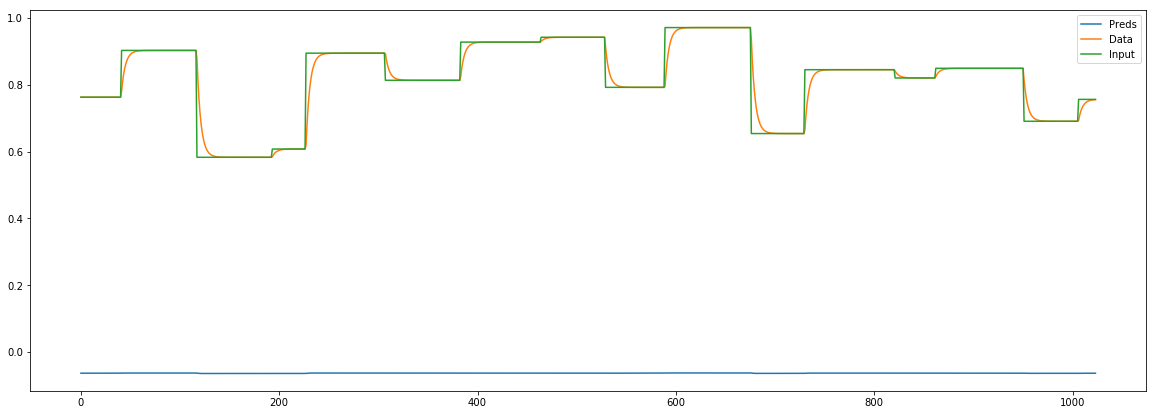

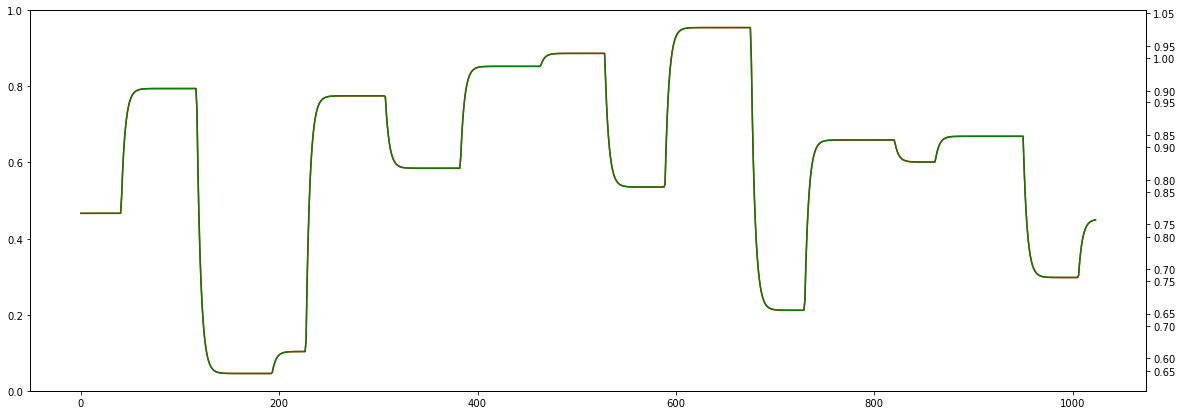

TEST AUX:


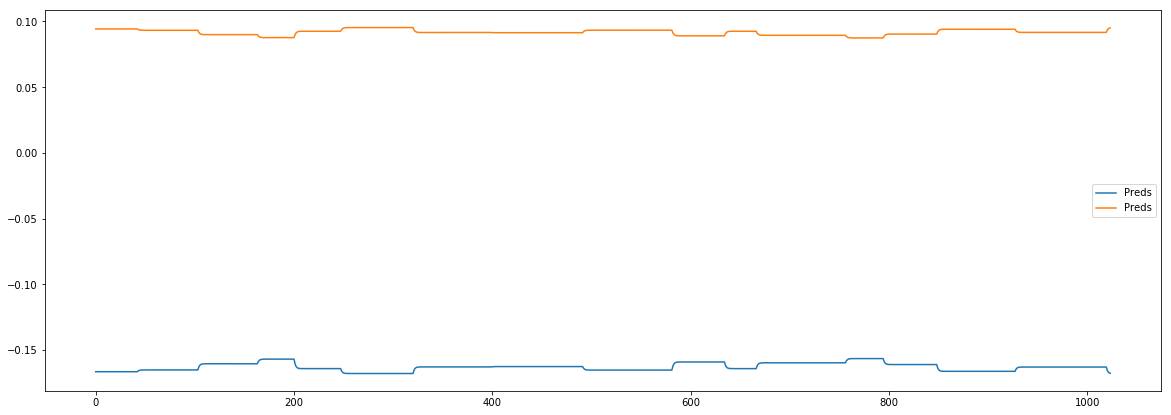

TEST PRED:


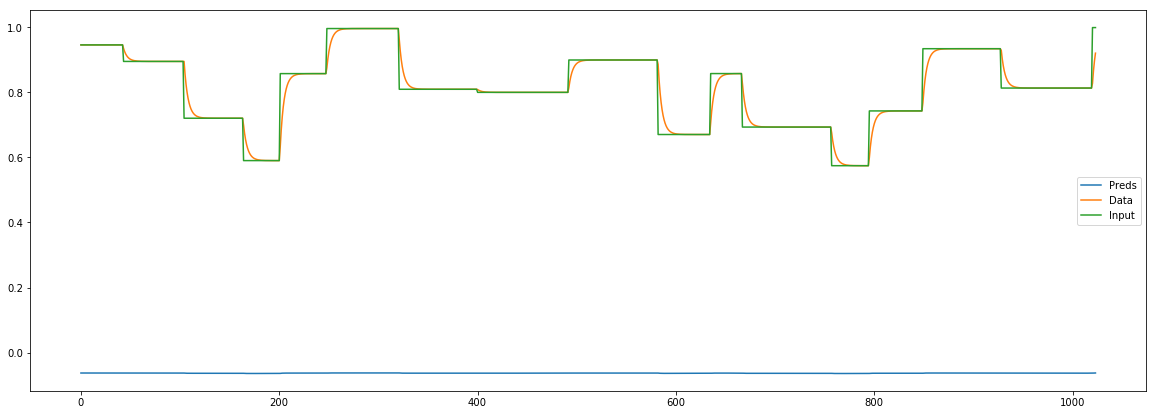

TEST RESID:


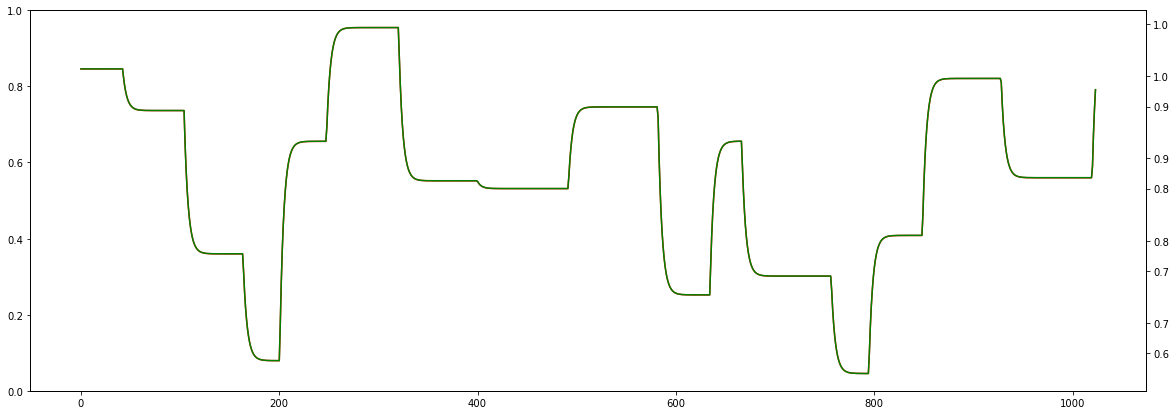

 Epoch [38]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


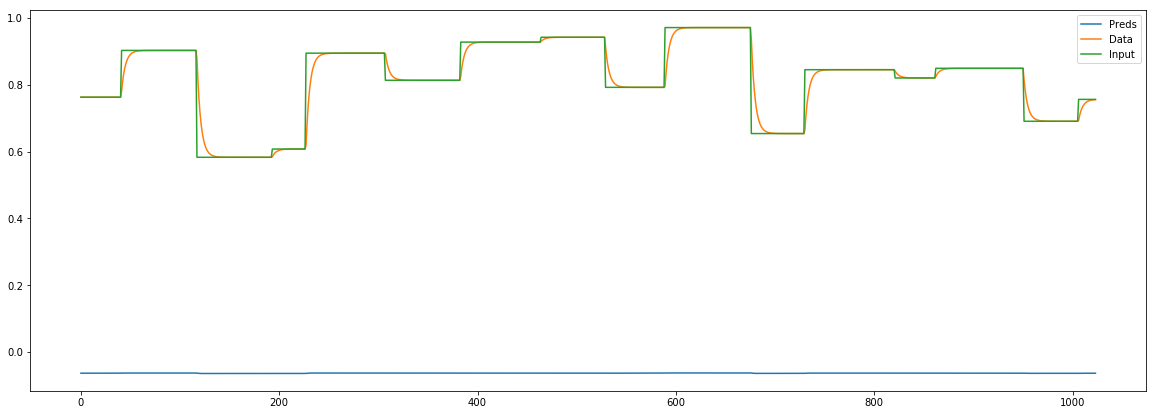

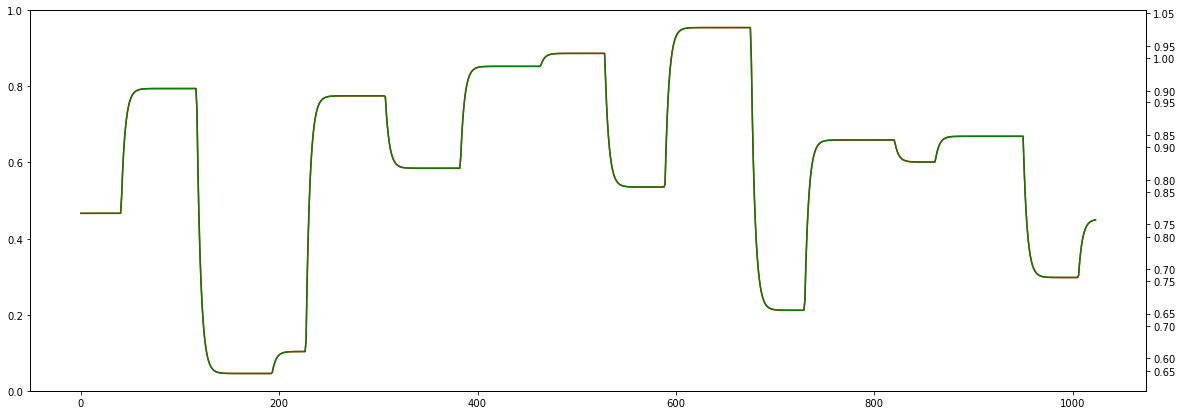

TEST AUX:


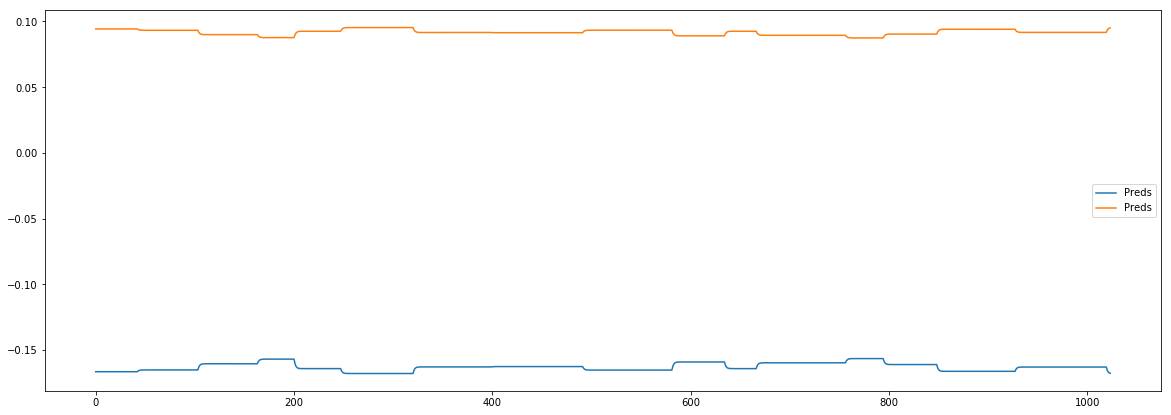

TEST PRED:


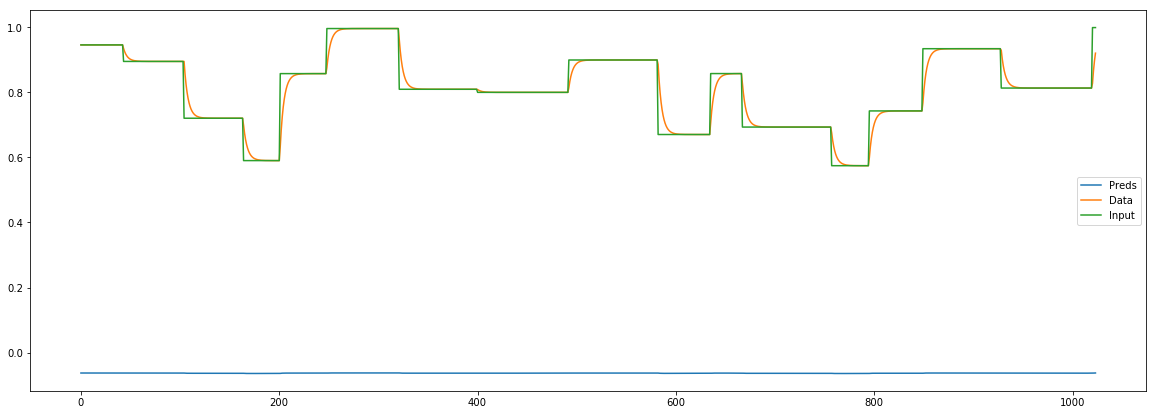

TEST RESID:


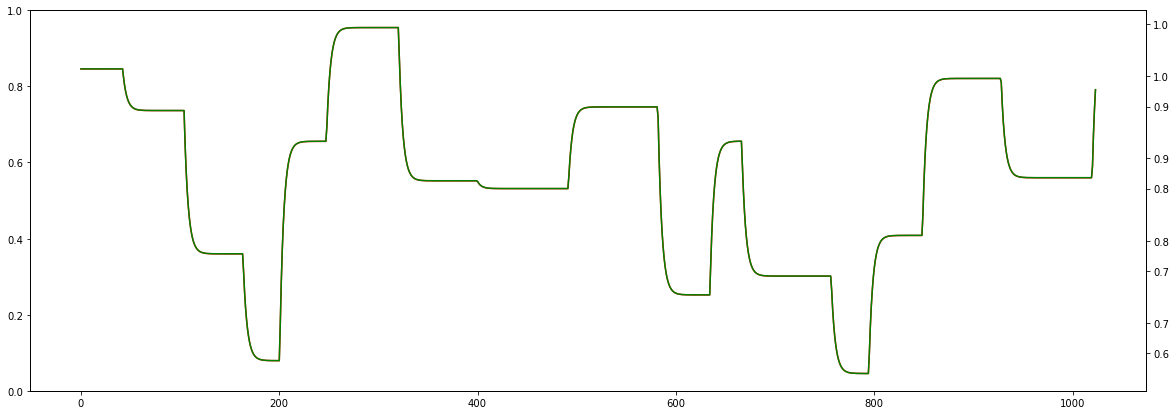

 Epoch [39]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


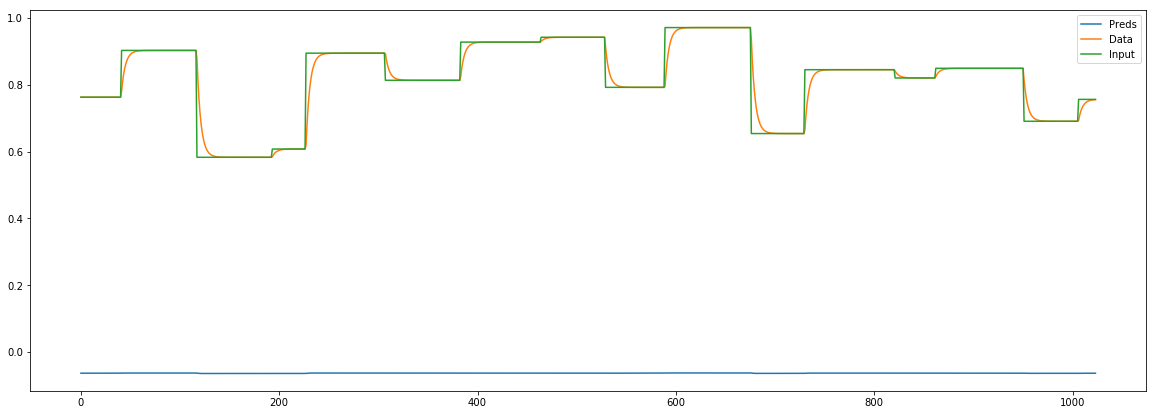

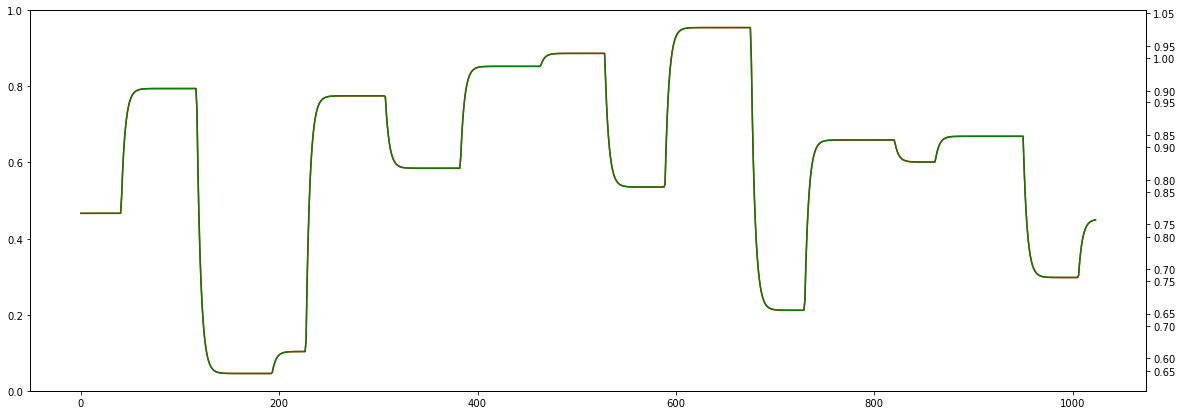

TEST AUX:


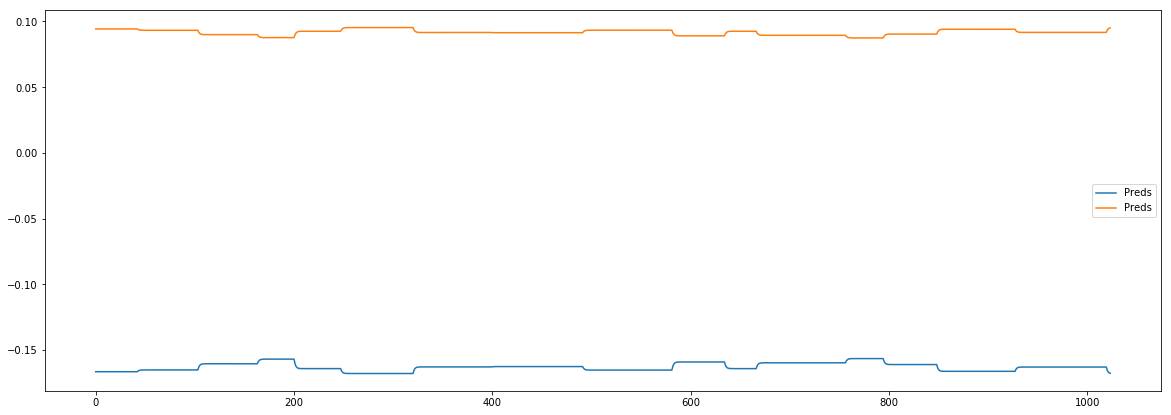

TEST PRED:


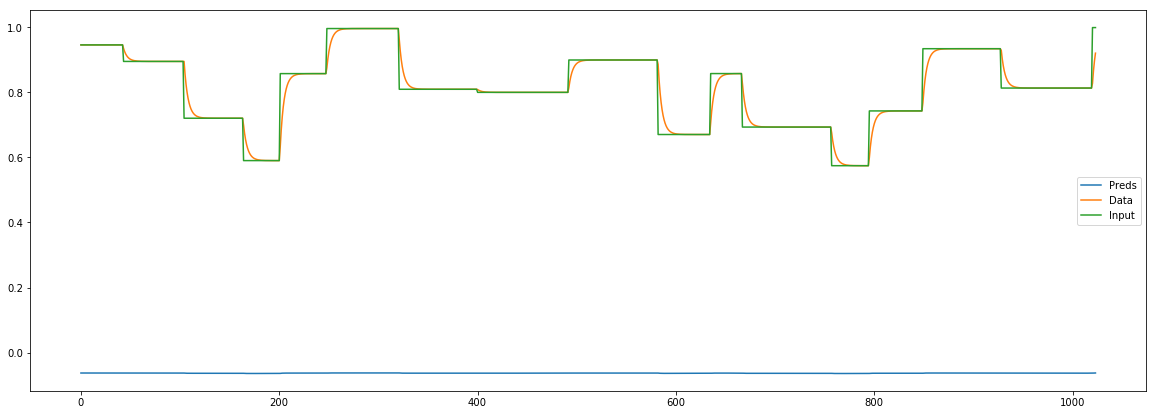

TEST RESID:


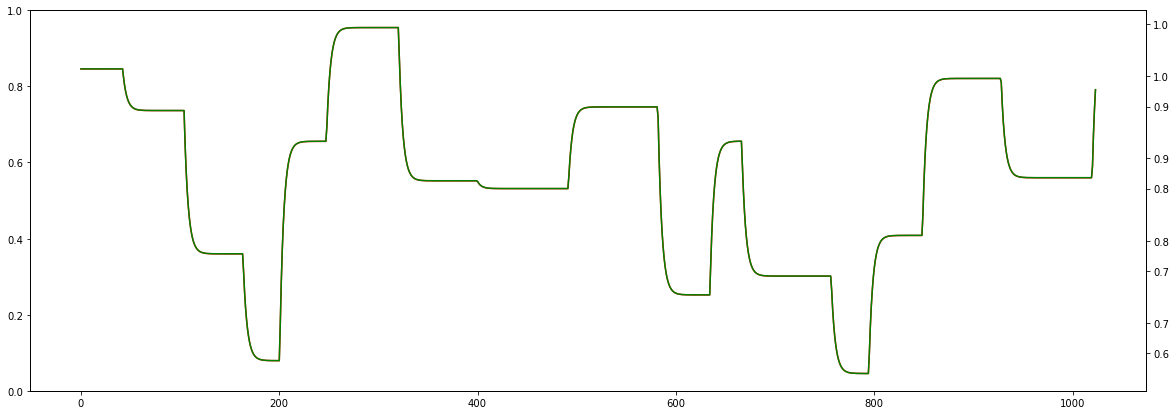

 Epoch [40]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


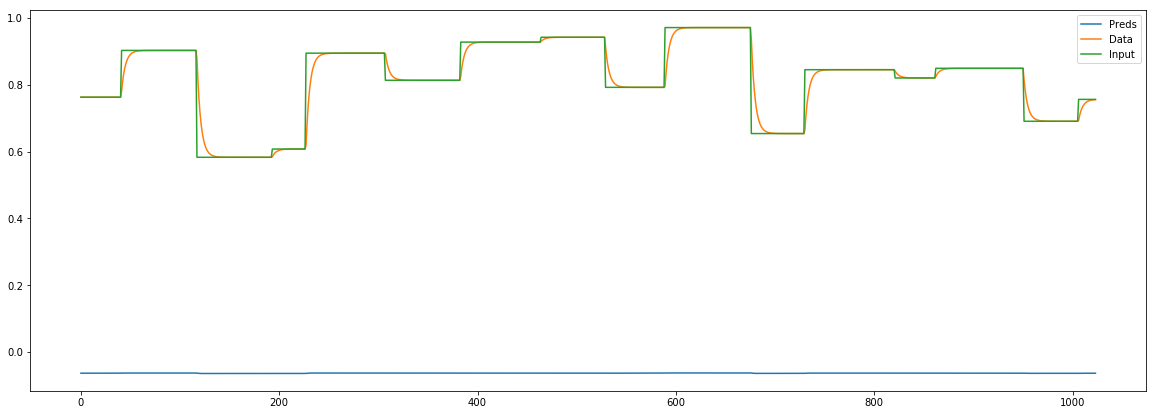

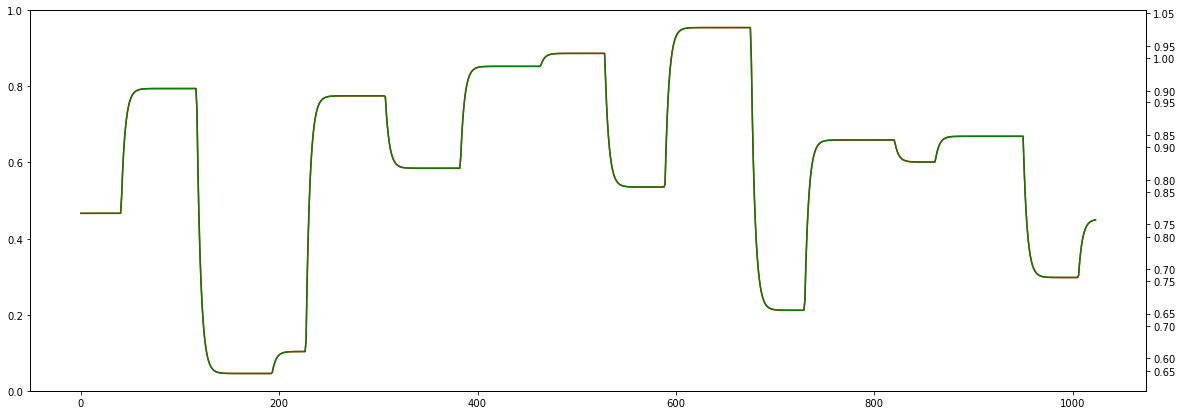

TEST AUX:


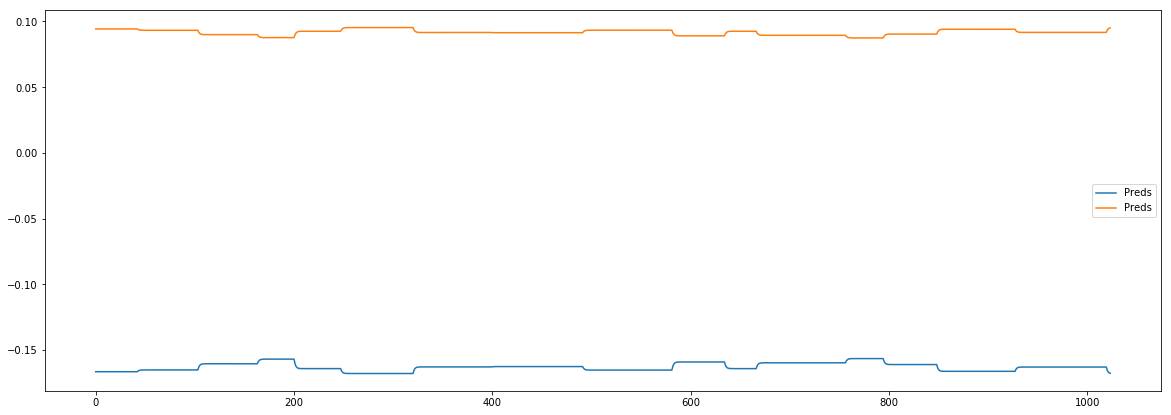

TEST PRED:


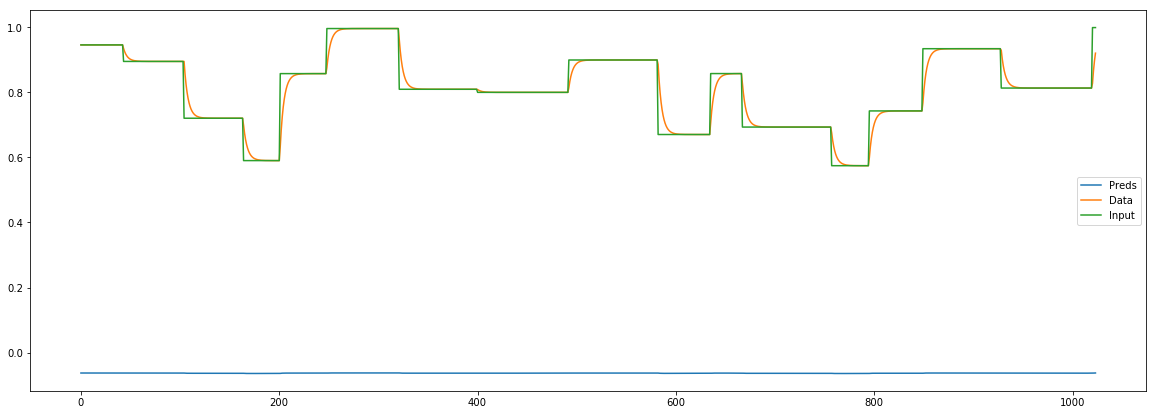

TEST RESID:


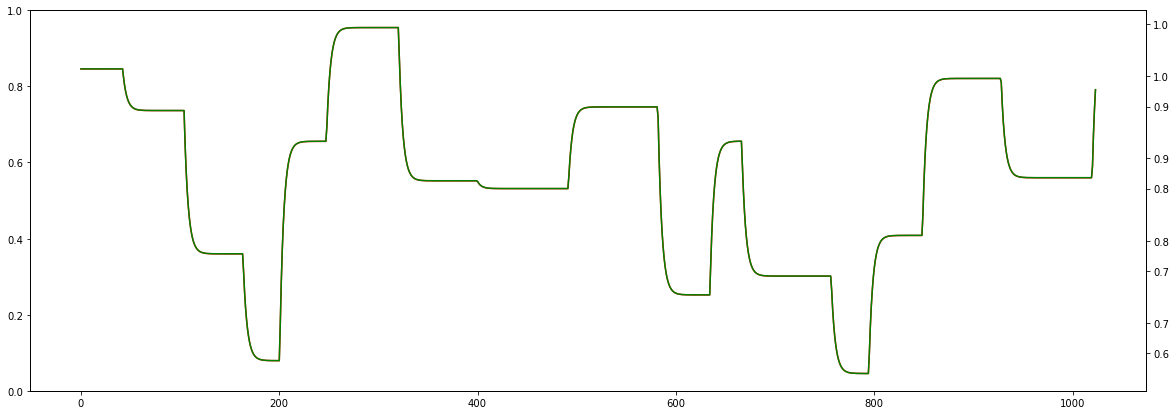

 Epoch [41]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


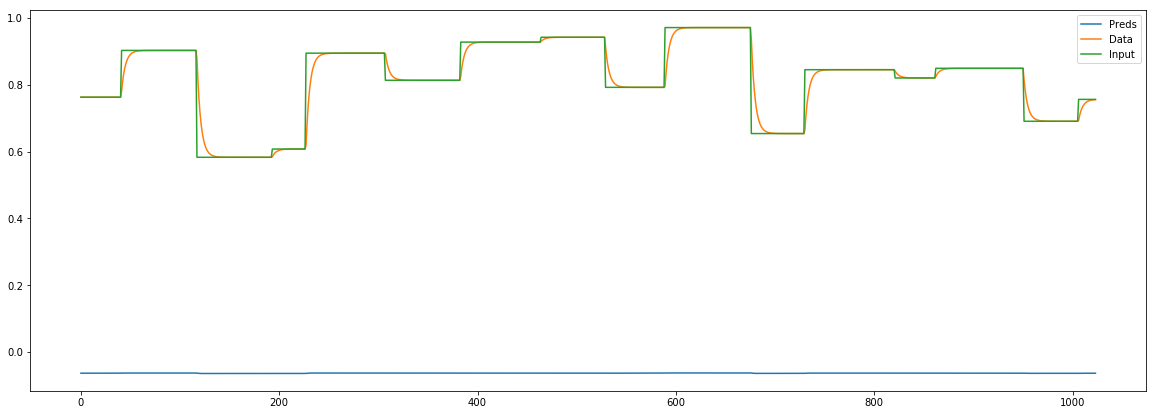

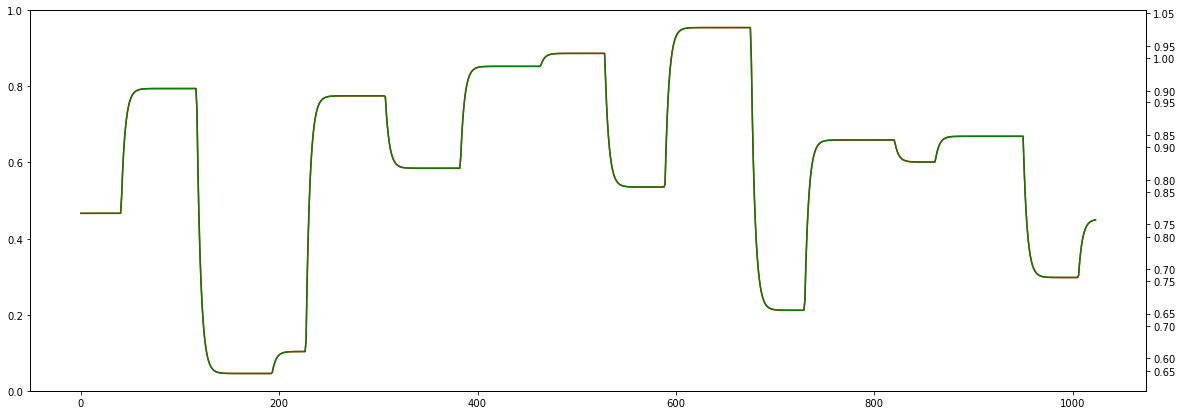

TEST AUX:


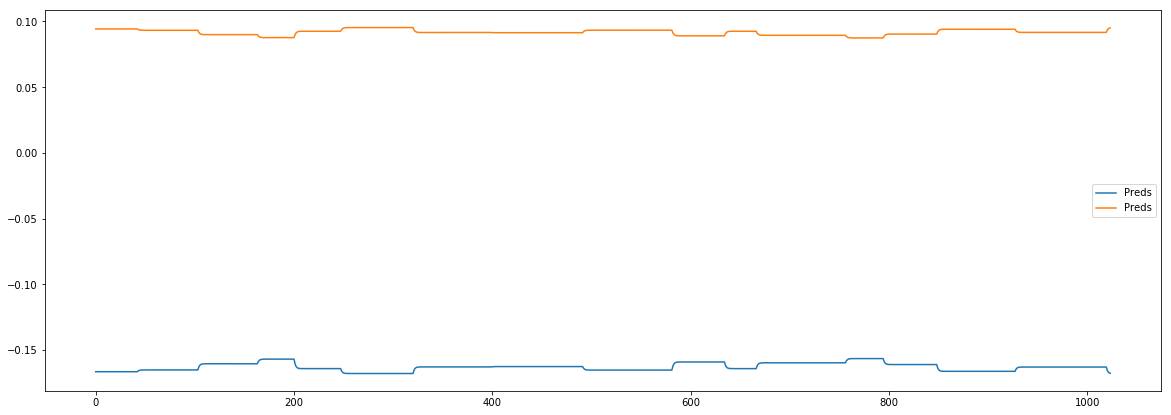

TEST PRED:


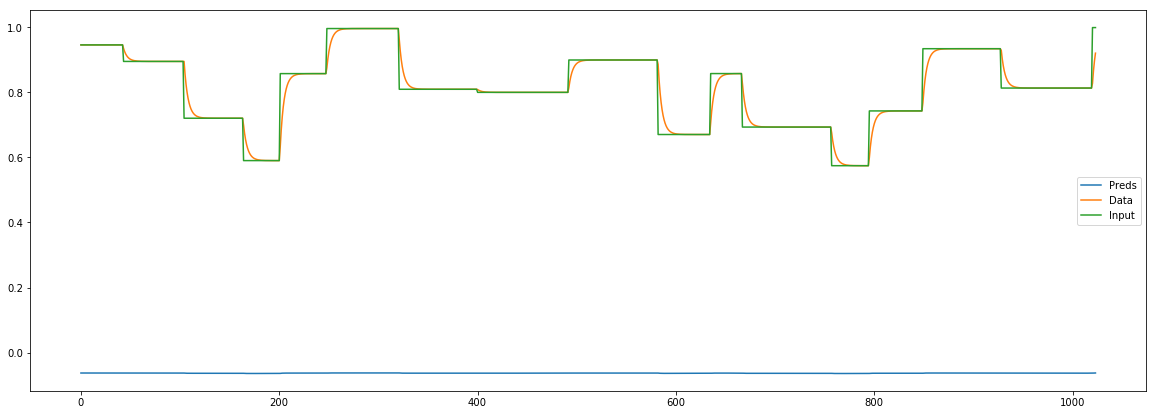

TEST RESID:


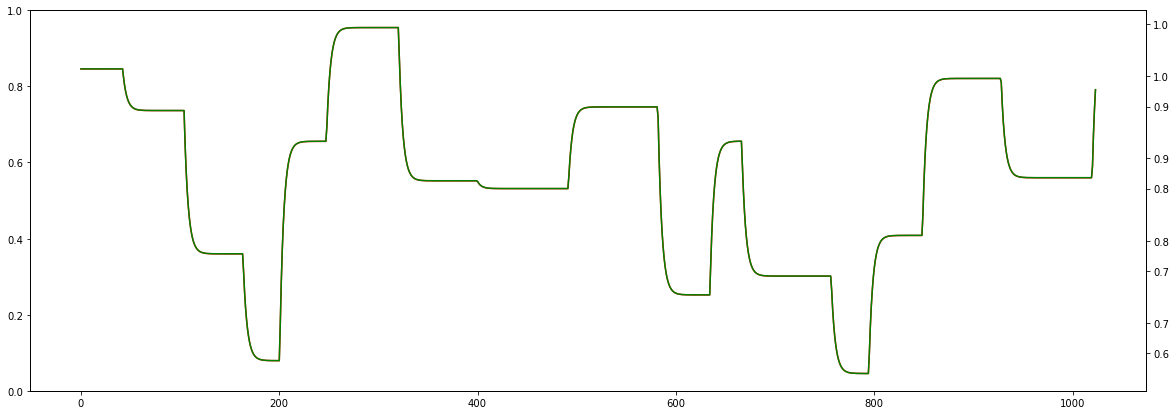

 Epoch [42]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


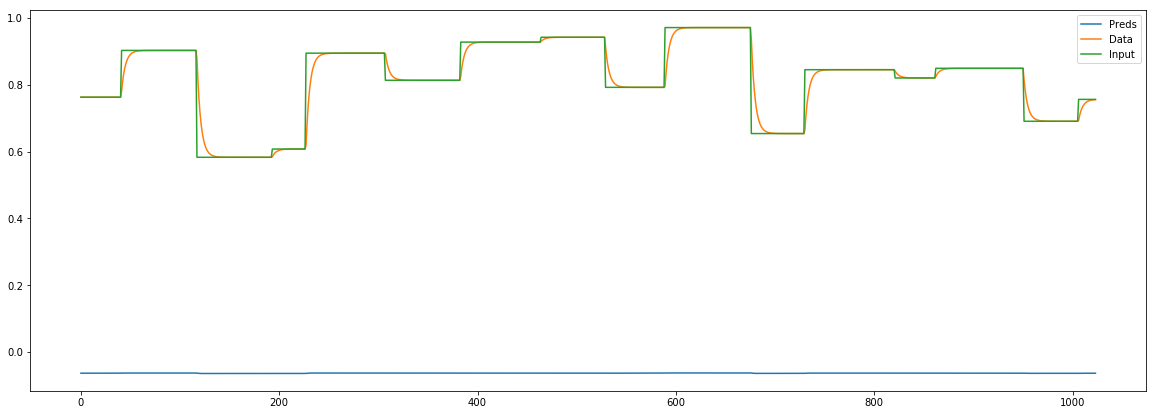

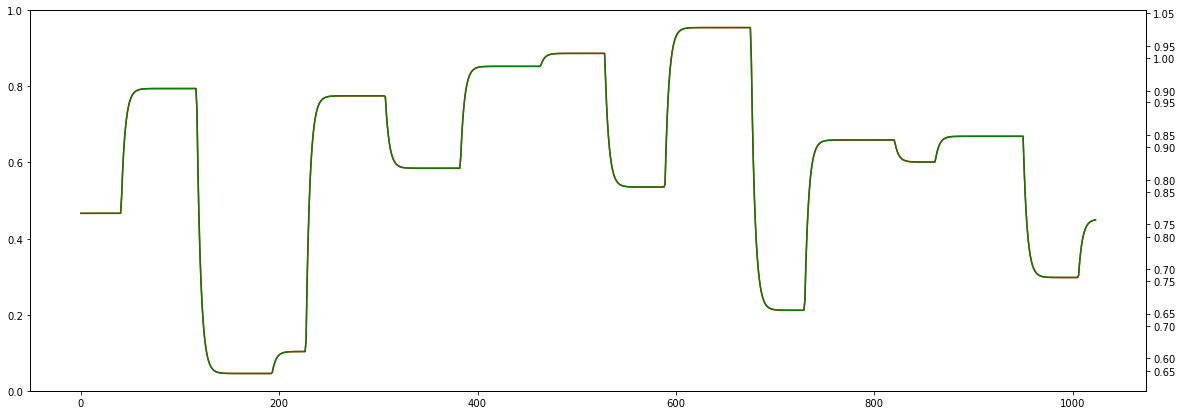

TEST AUX:


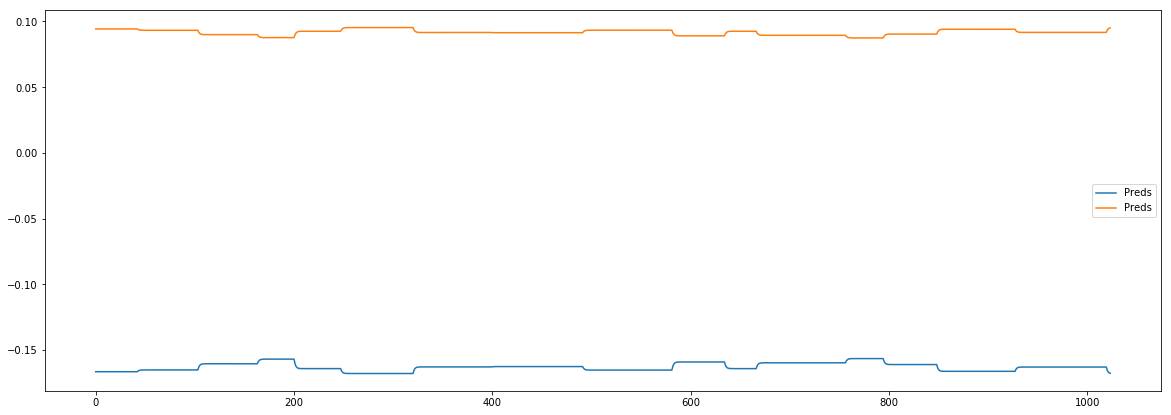

TEST PRED:


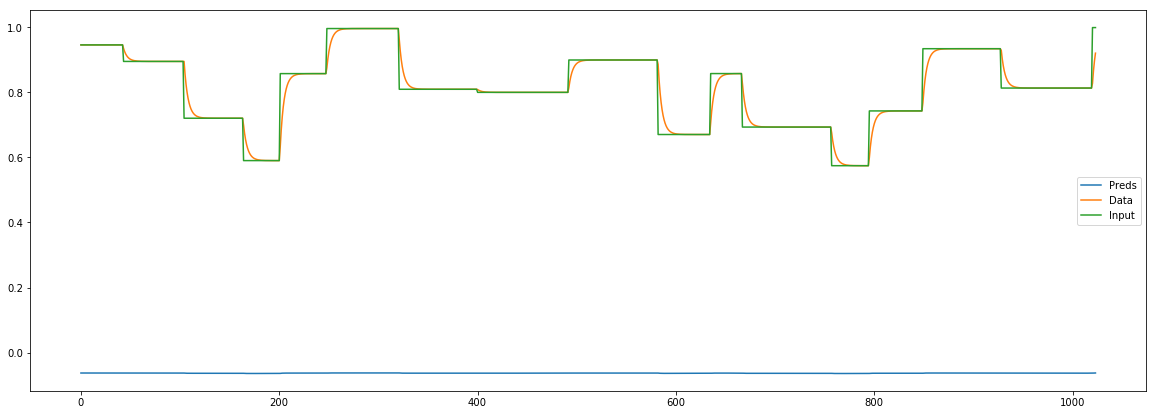

TEST RESID:


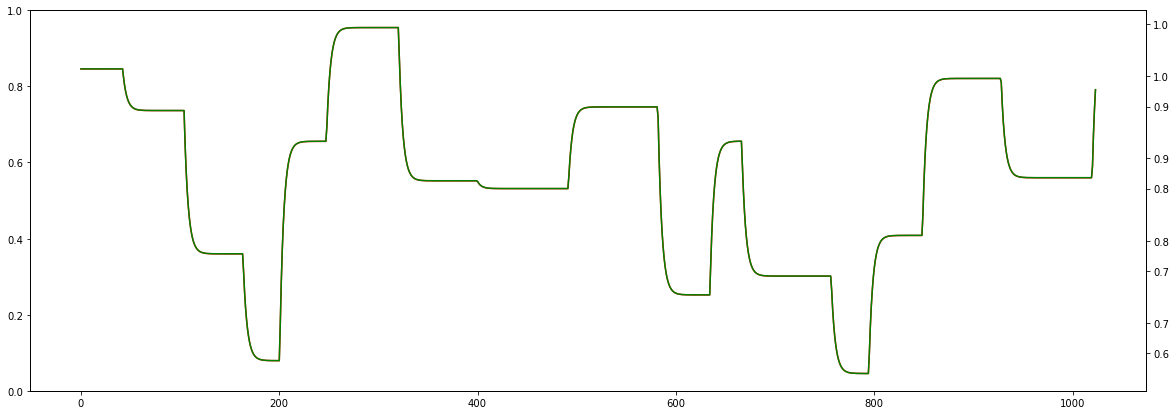

 Epoch [43]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


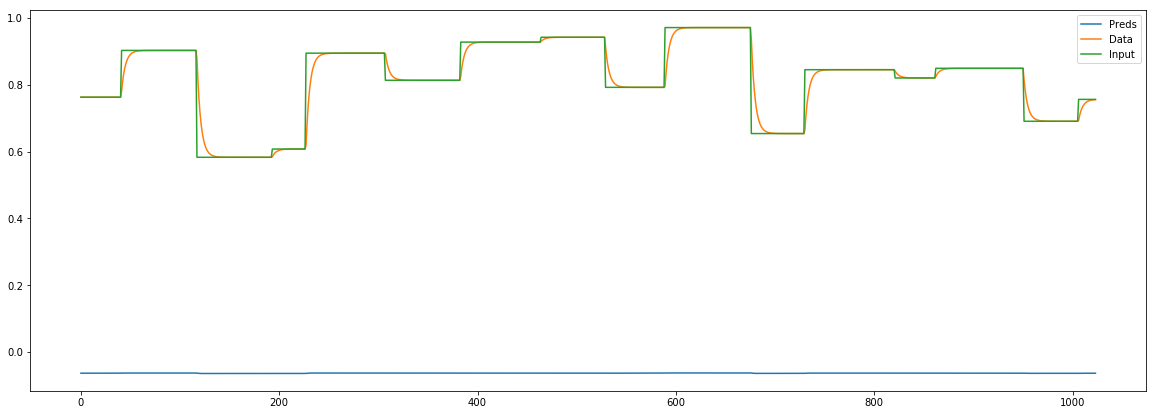

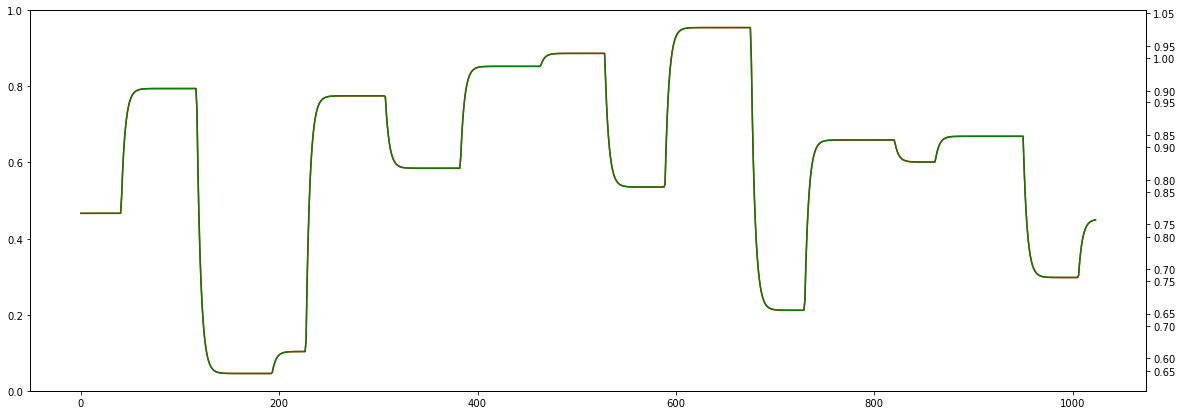

TEST AUX:


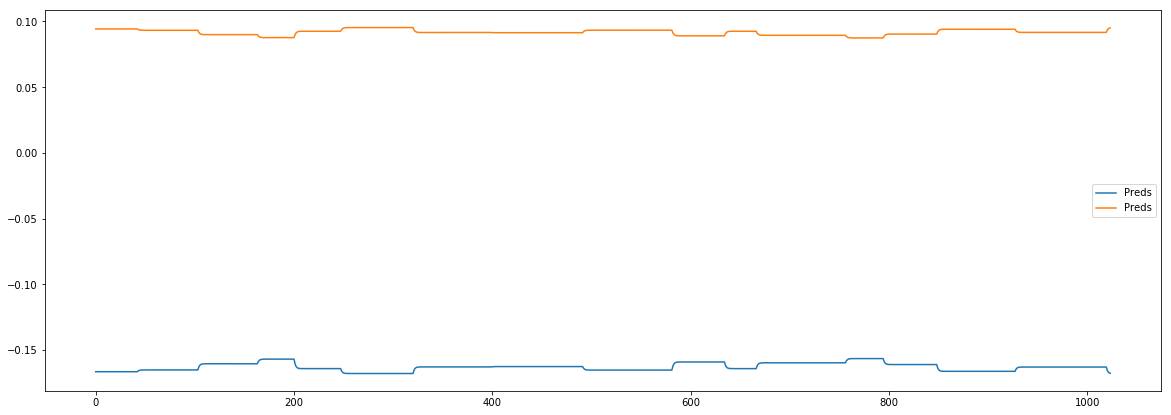

TEST PRED:


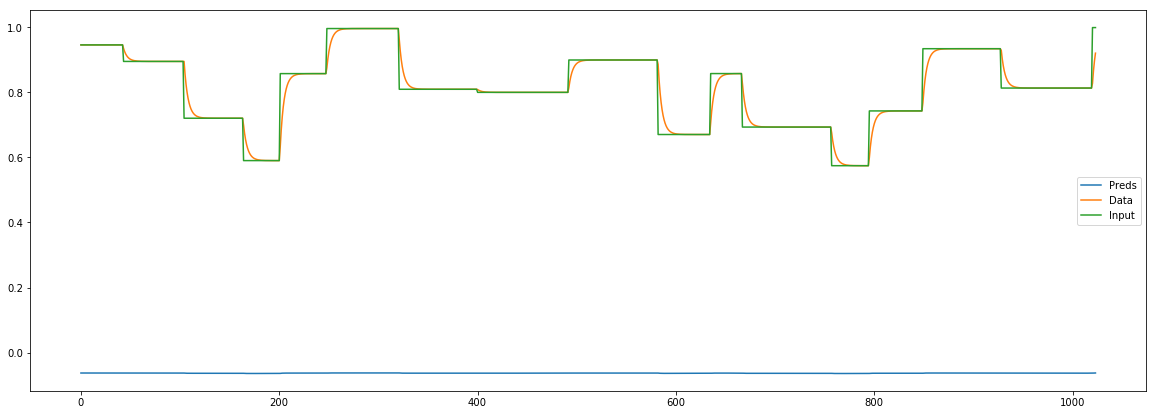

TEST RESID:


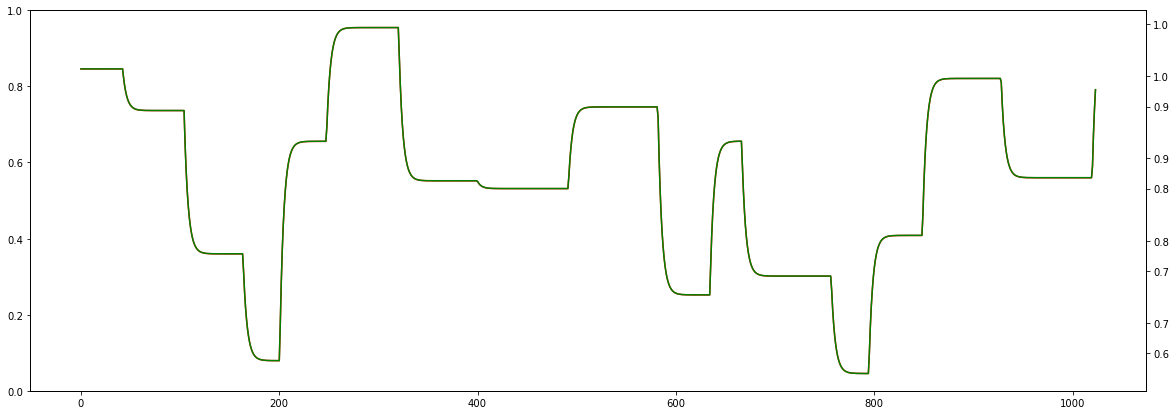

 Epoch [44]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


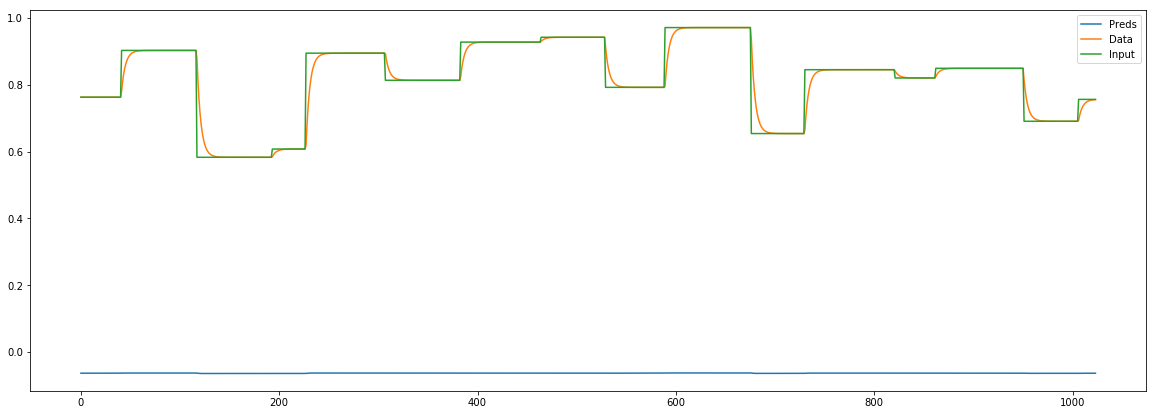

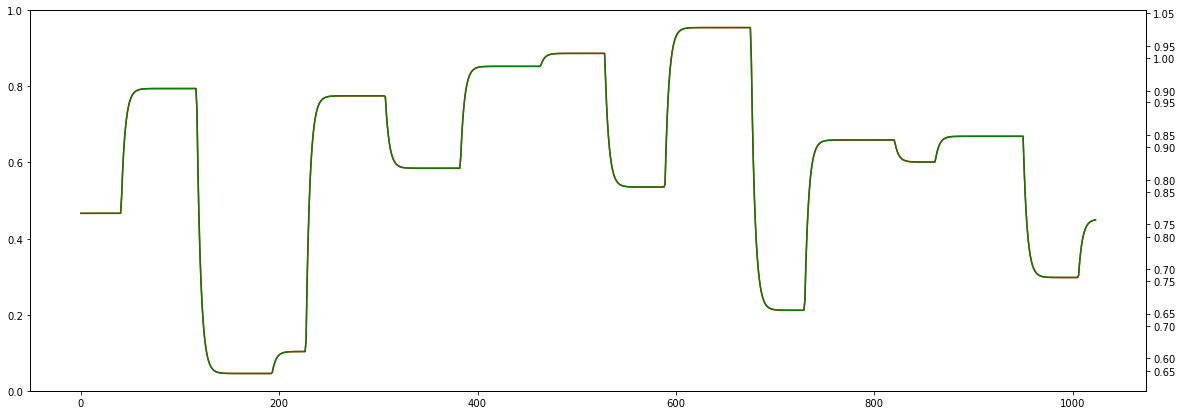

TEST AUX:


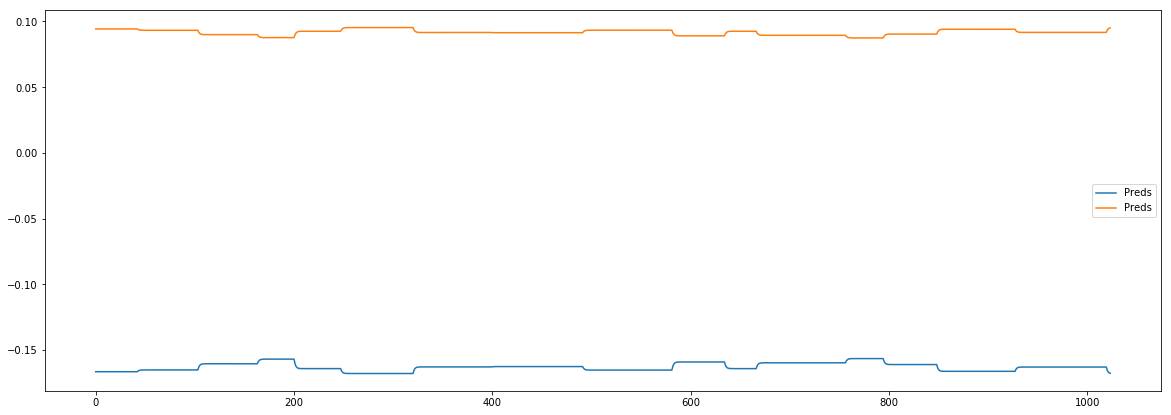

TEST PRED:


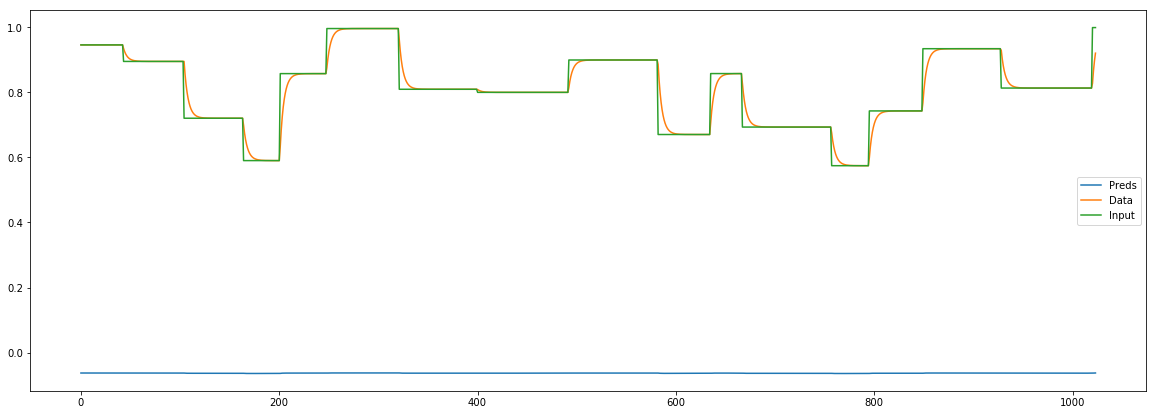

TEST RESID:


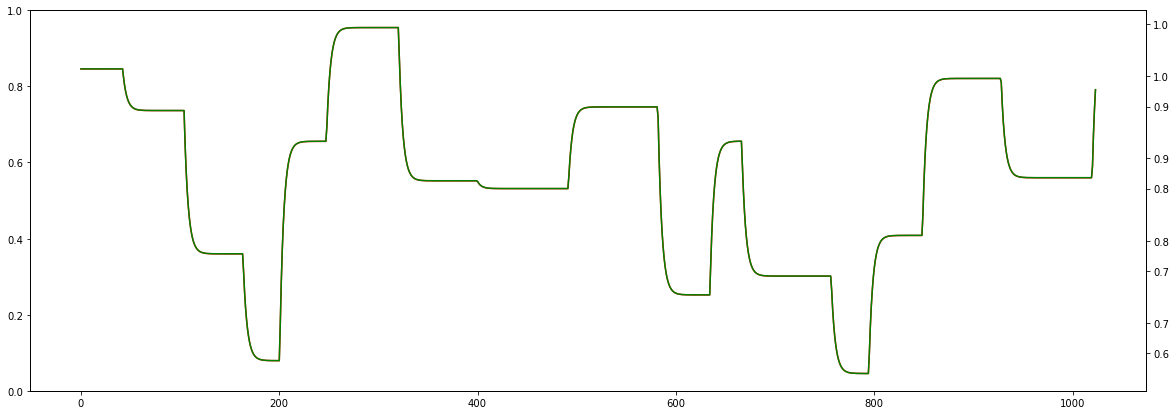

 Epoch [45]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


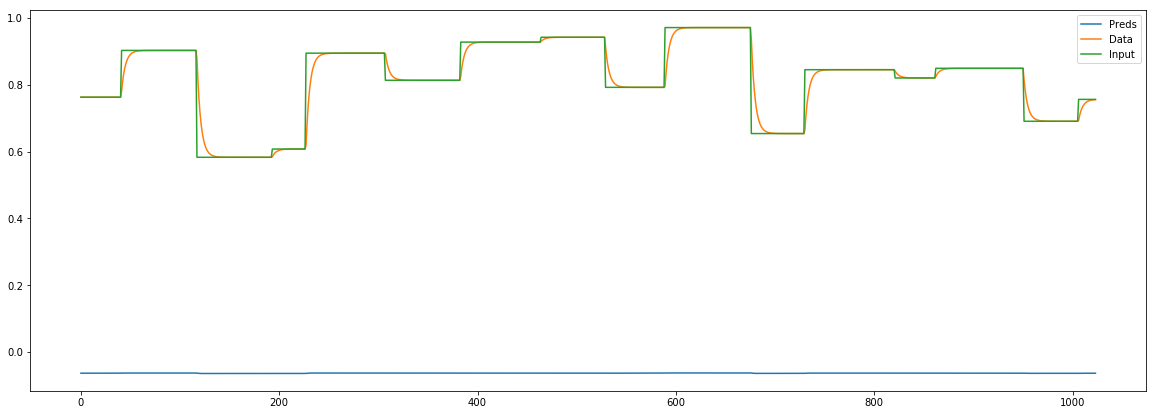

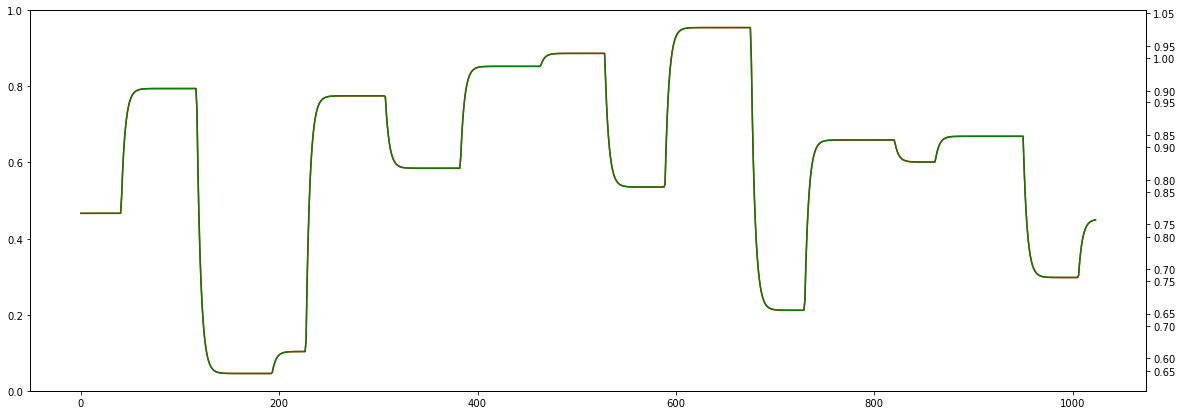

TEST AUX:


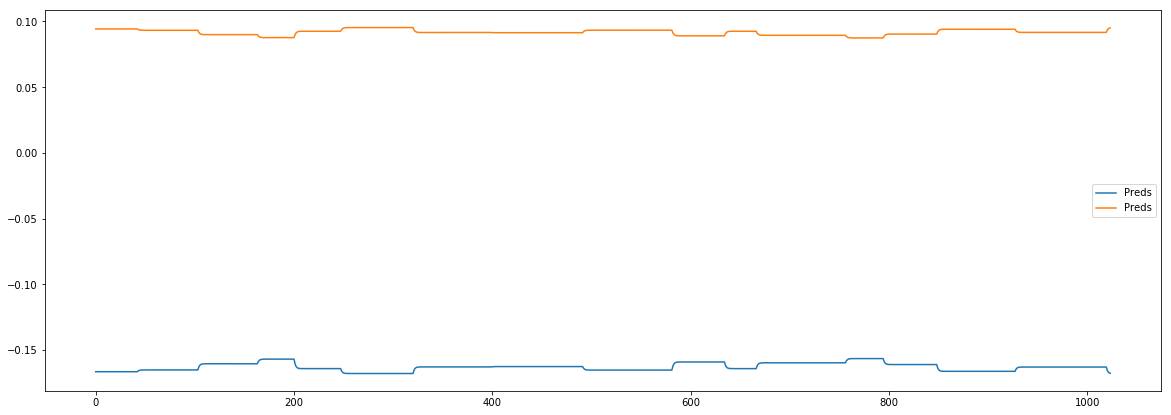

TEST PRED:


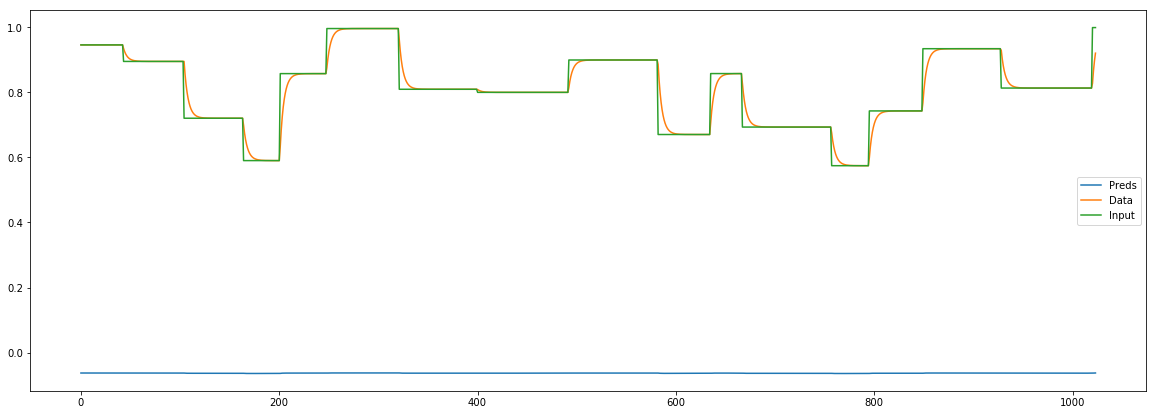

TEST RESID:


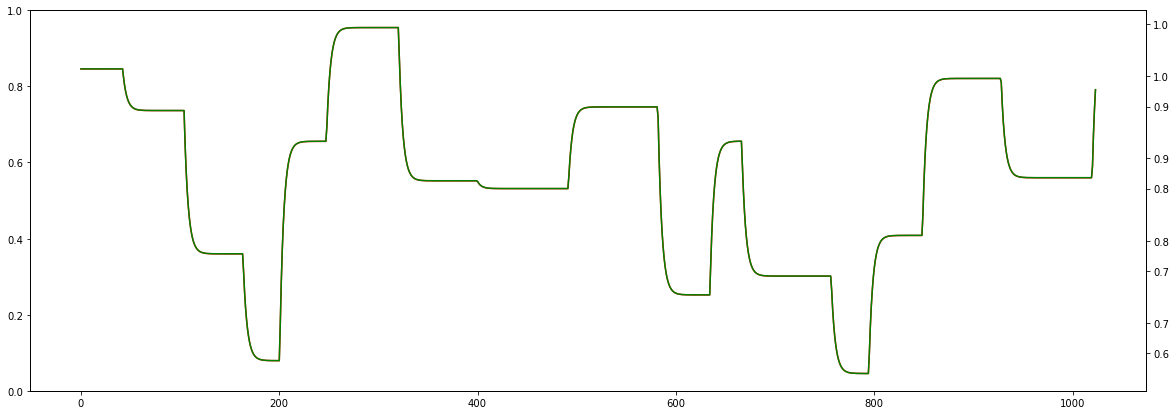

 Epoch [46]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


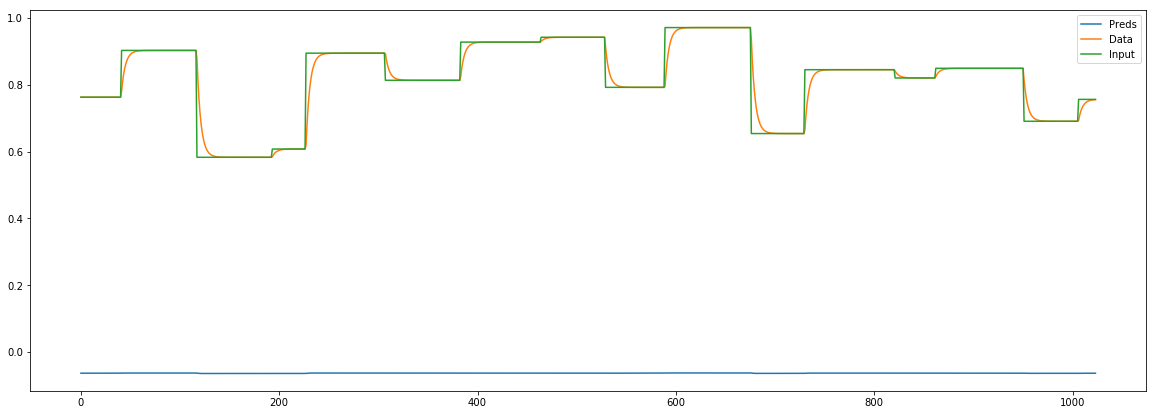

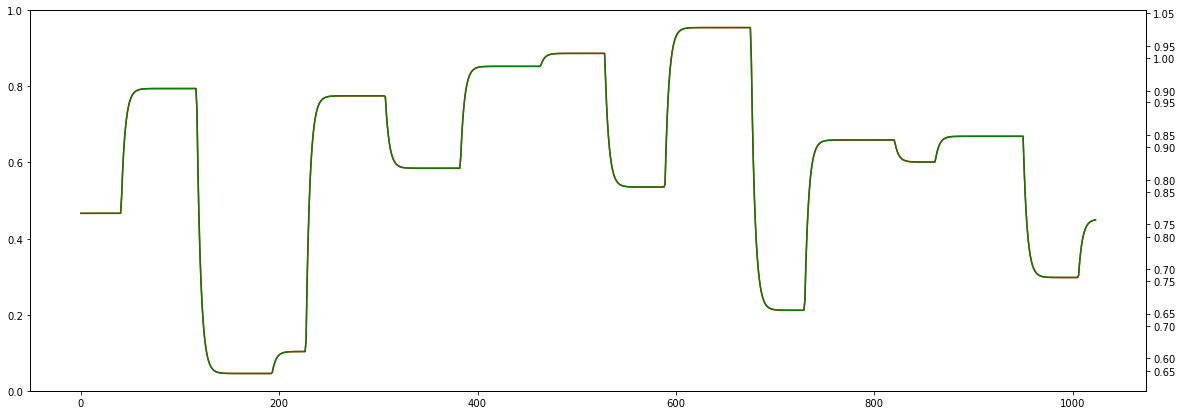

TEST AUX:


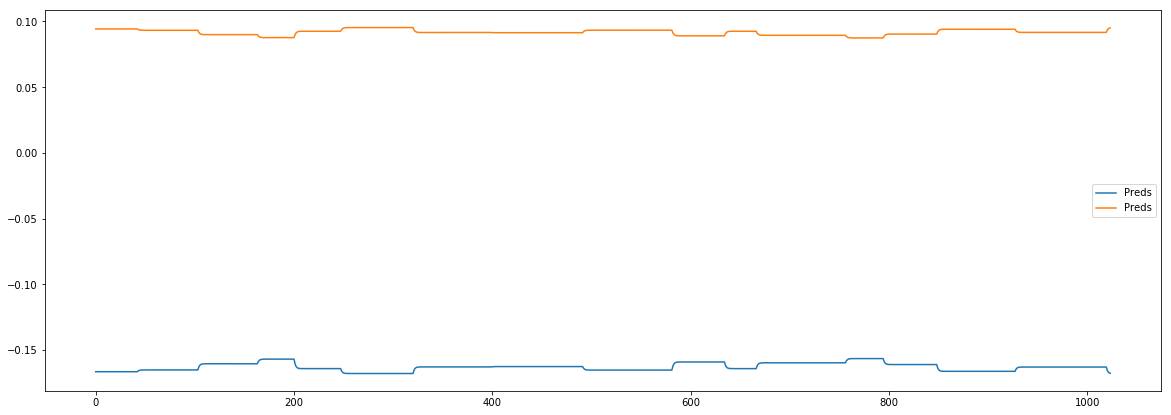

TEST PRED:


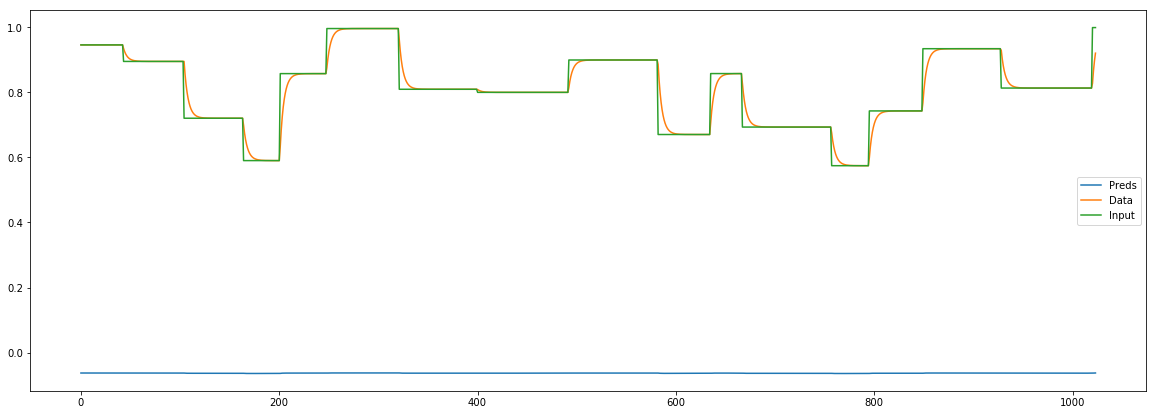

TEST RESID:


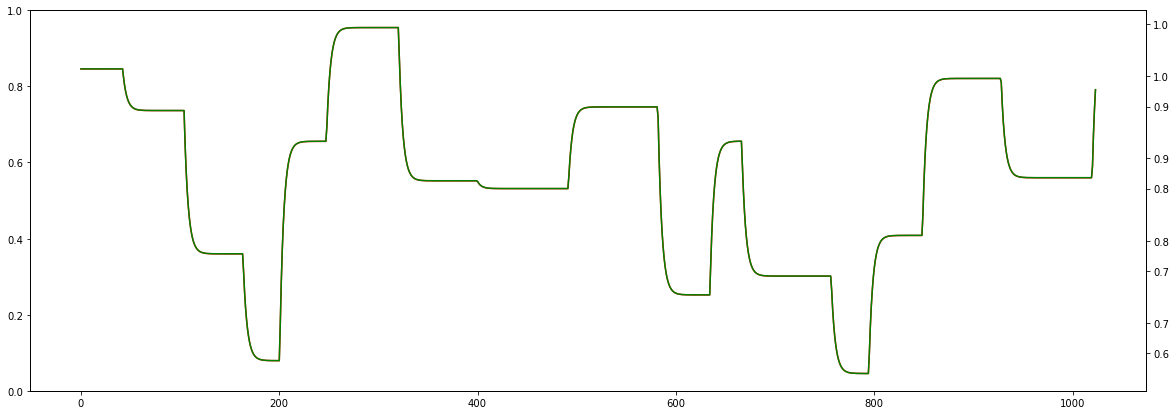

 Epoch [47]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


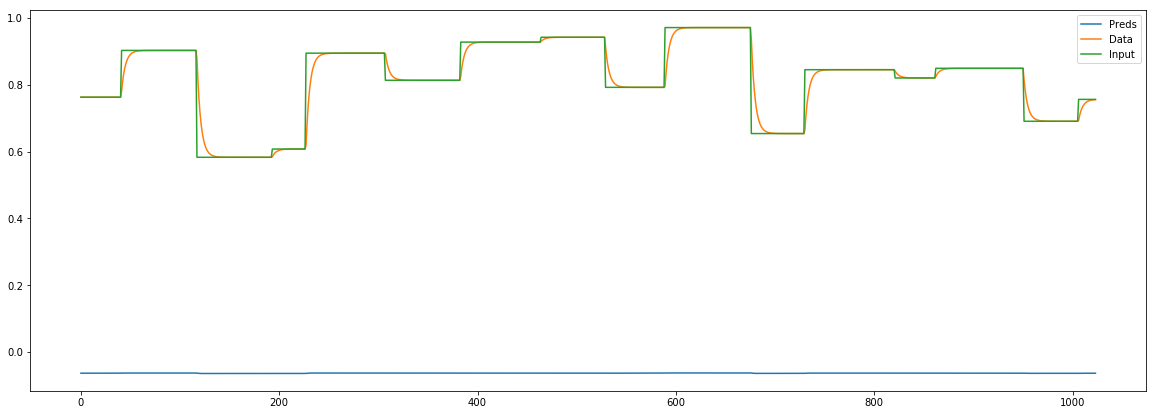

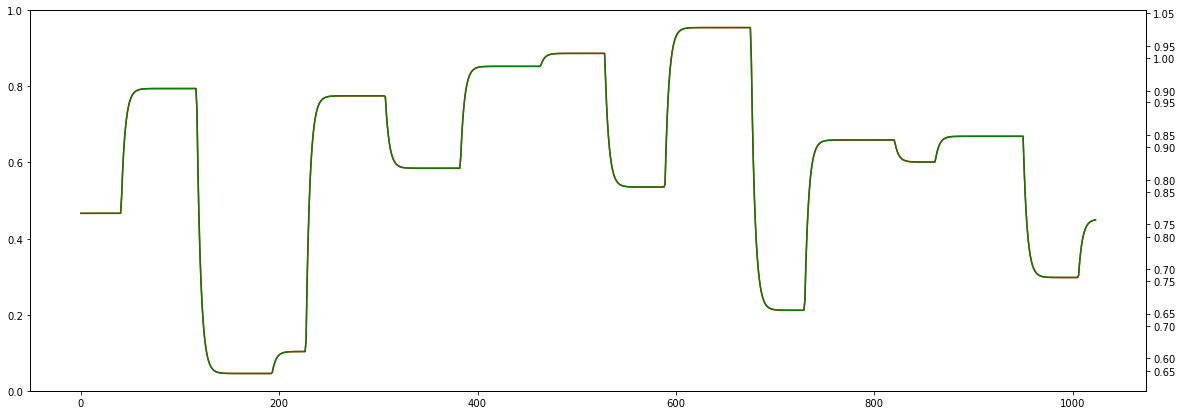

TEST AUX:


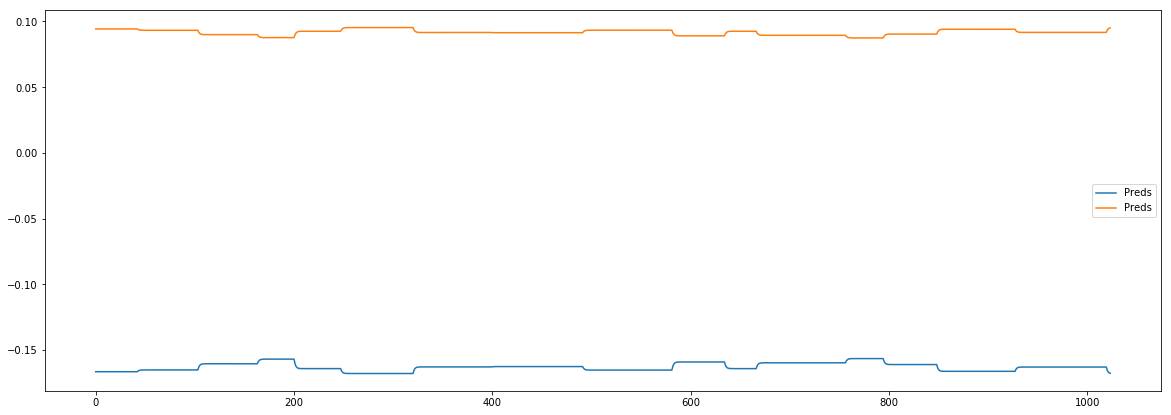

TEST PRED:


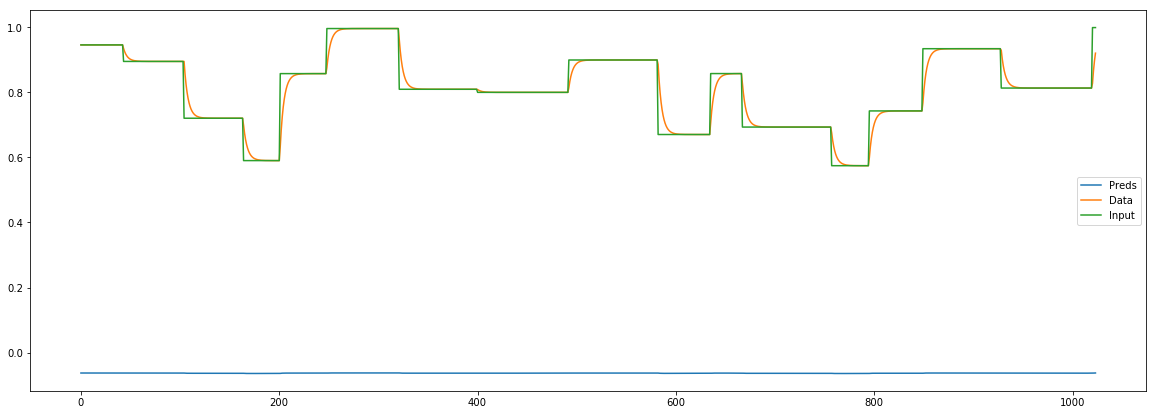

TEST RESID:


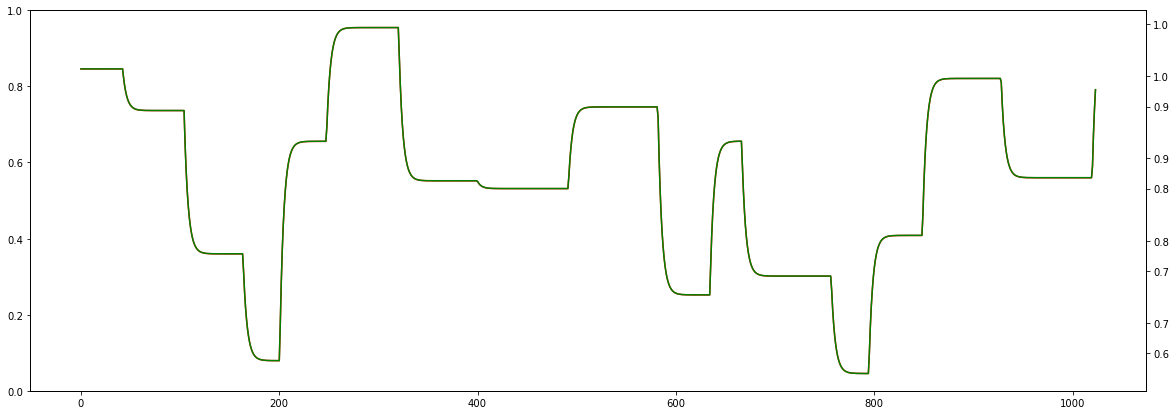

 Epoch [48]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


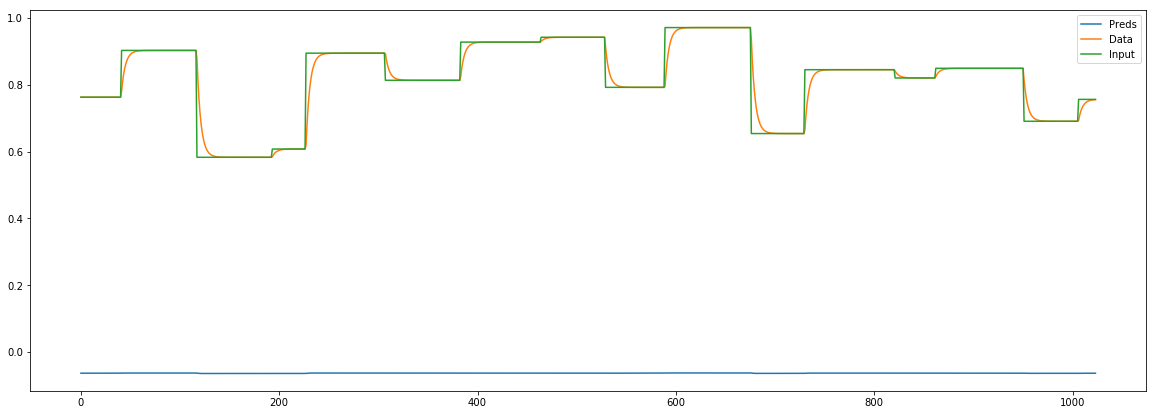

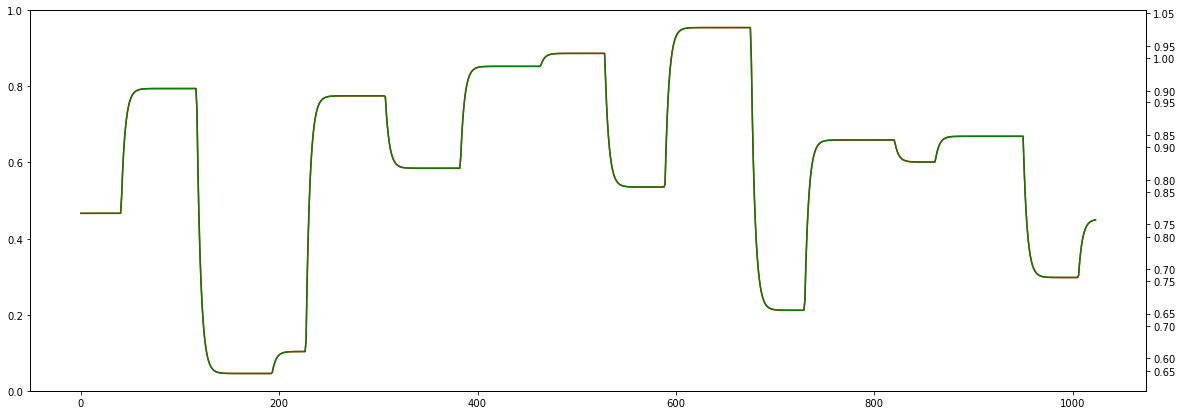

TEST AUX:


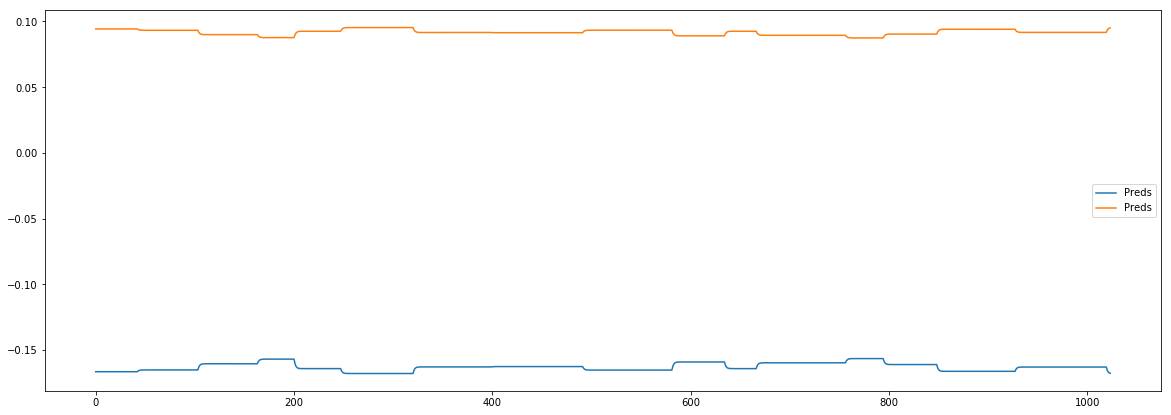

TEST PRED:


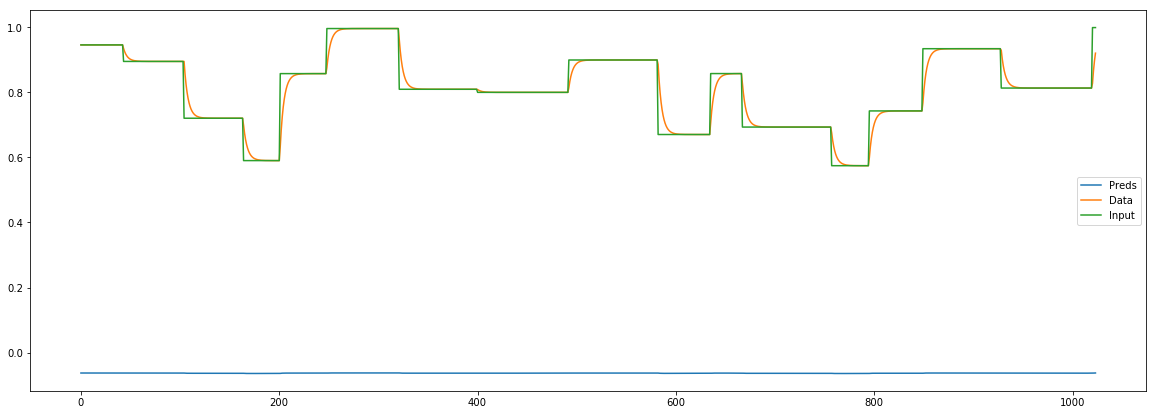

TEST RESID:


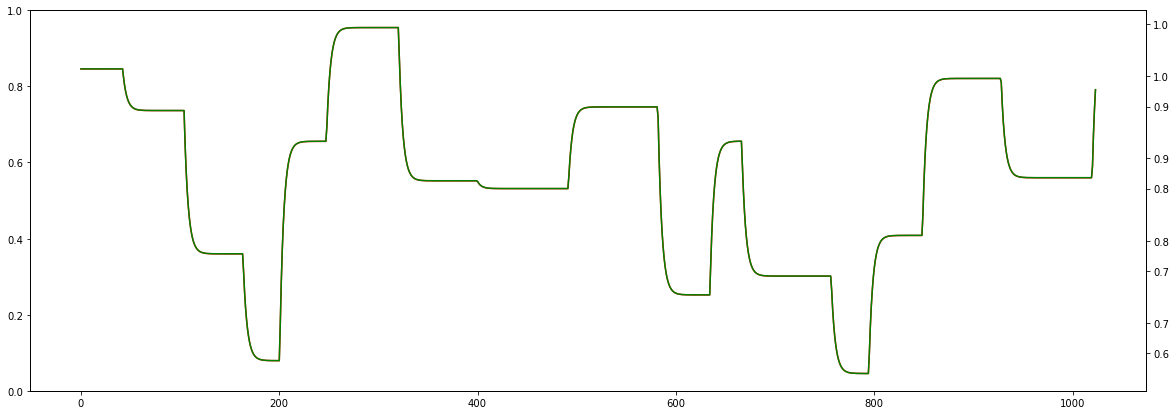

 Epoch [49]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


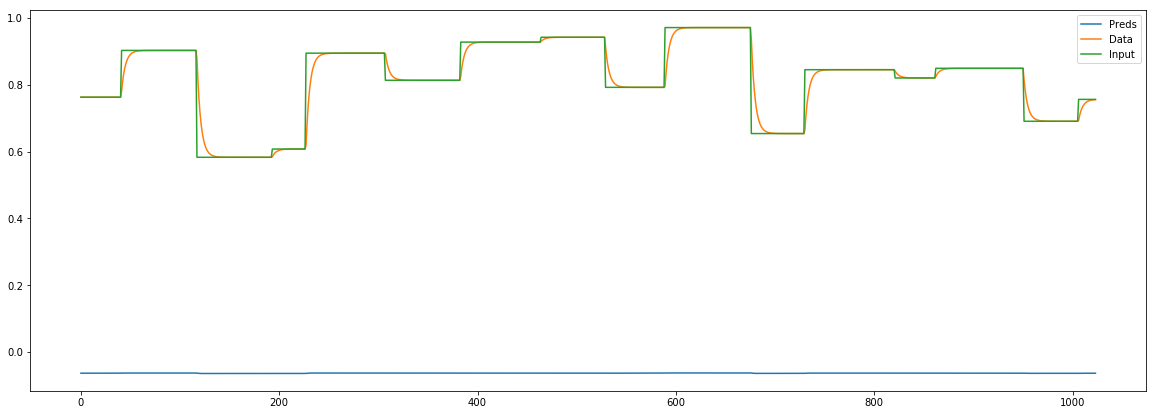

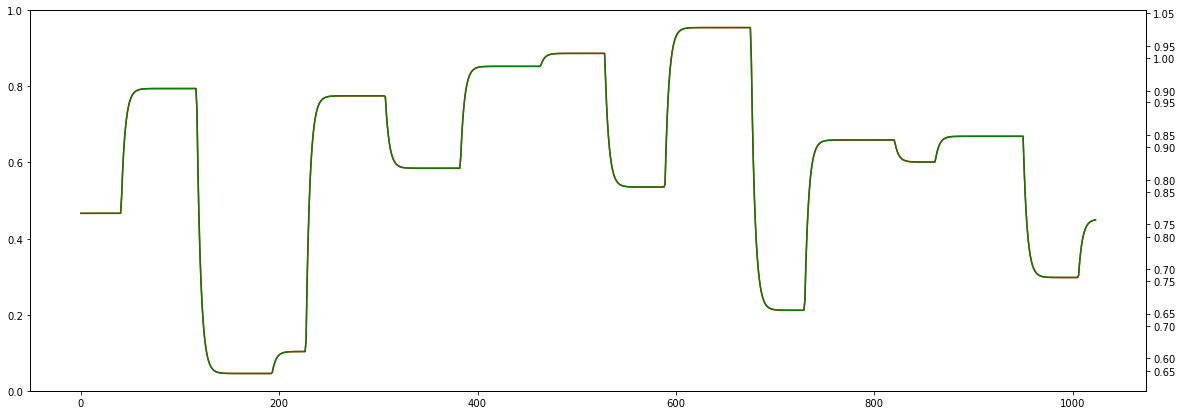

TEST AUX:


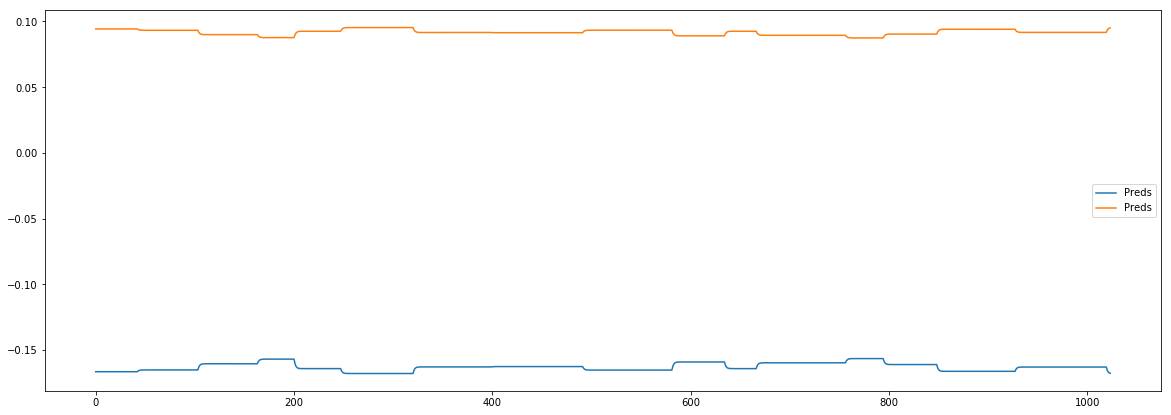

TEST PRED:


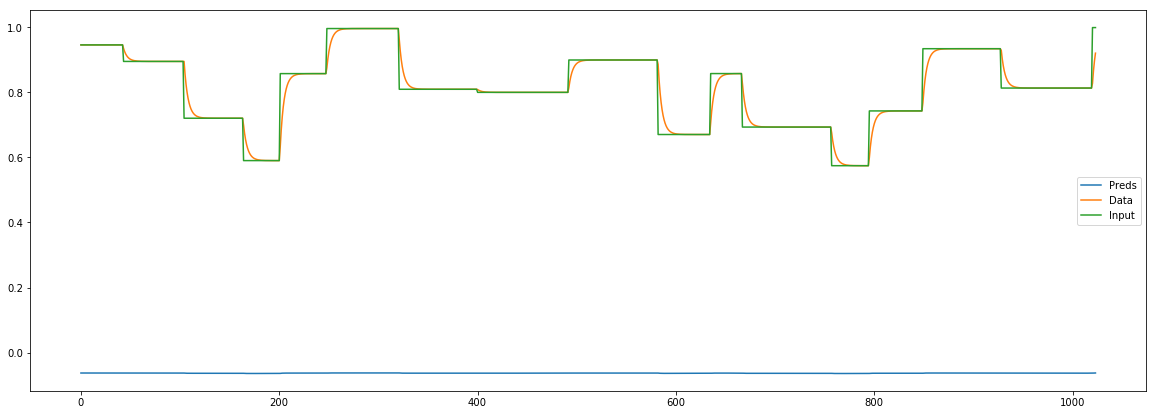

TEST RESID:


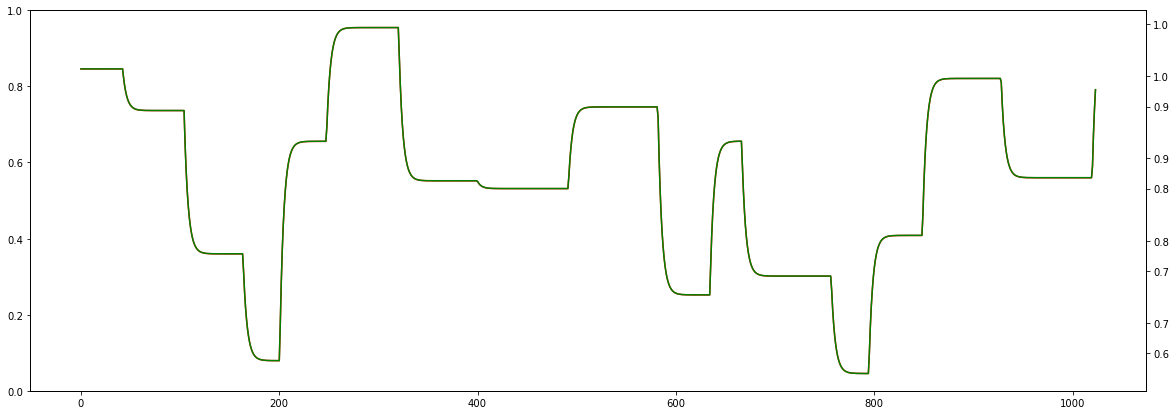

 Epoch [50]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


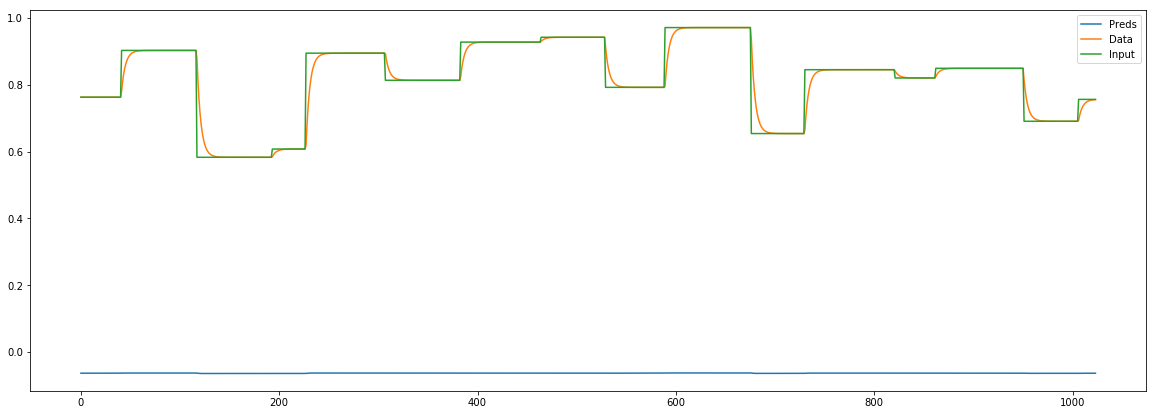

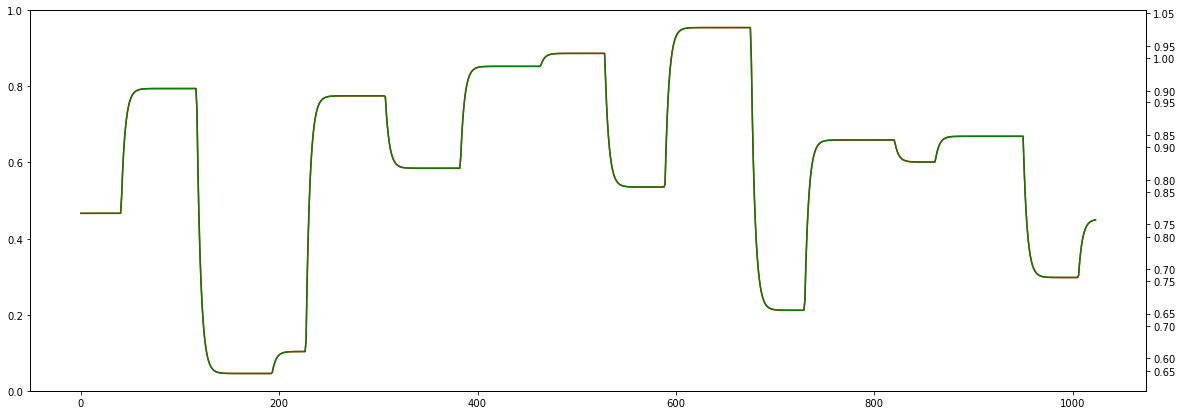

TEST AUX:


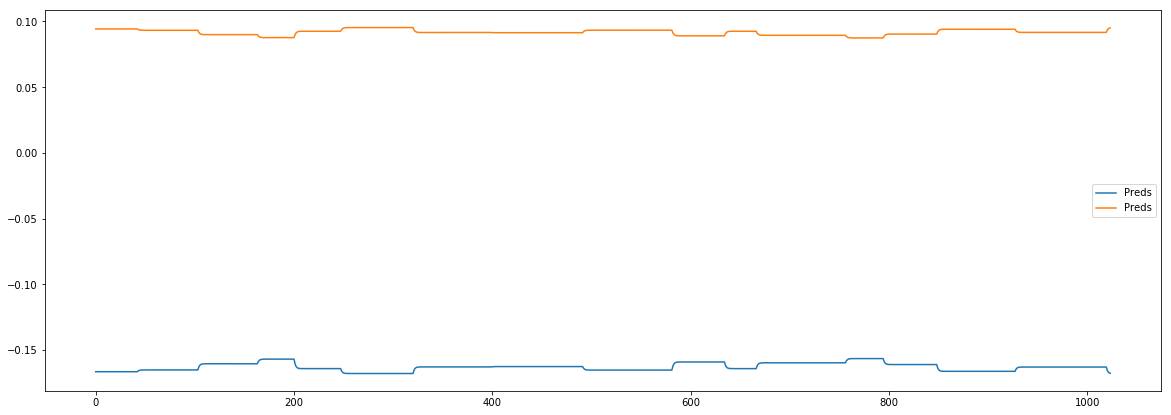

TEST PRED:


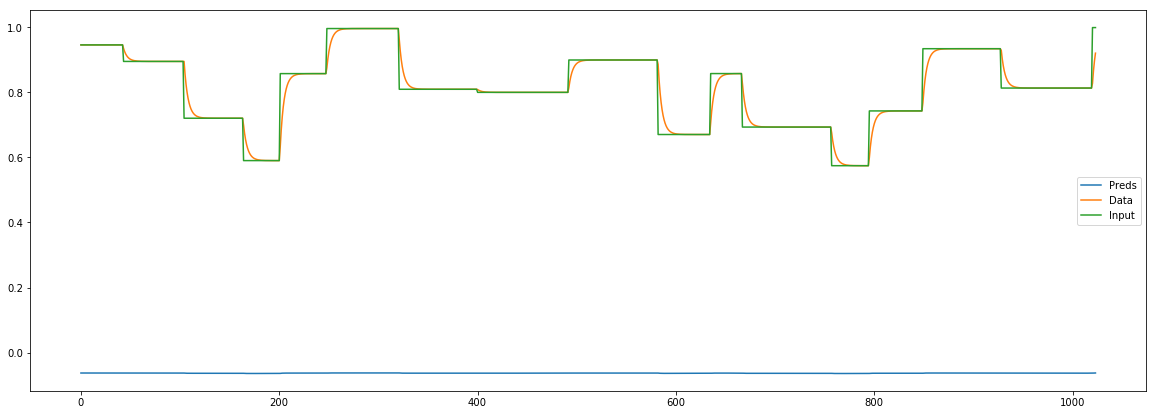

TEST RESID:


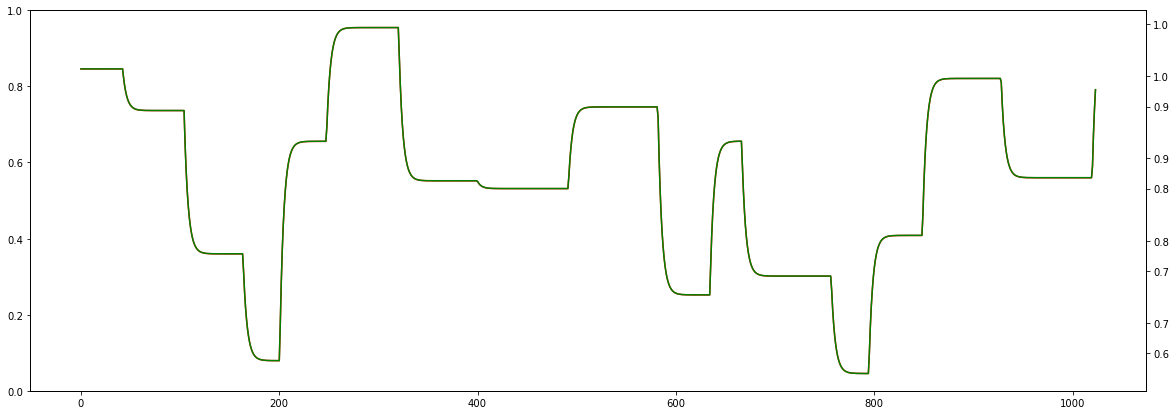

 Epoch [51]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


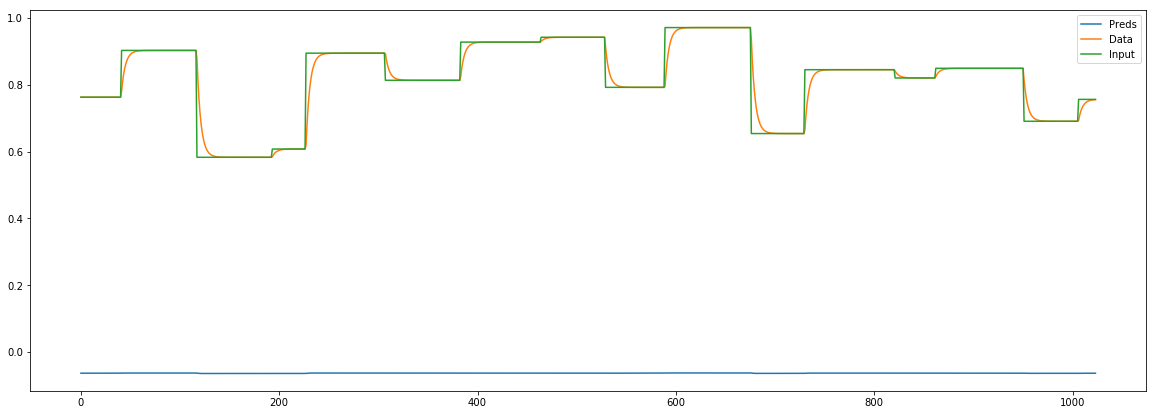

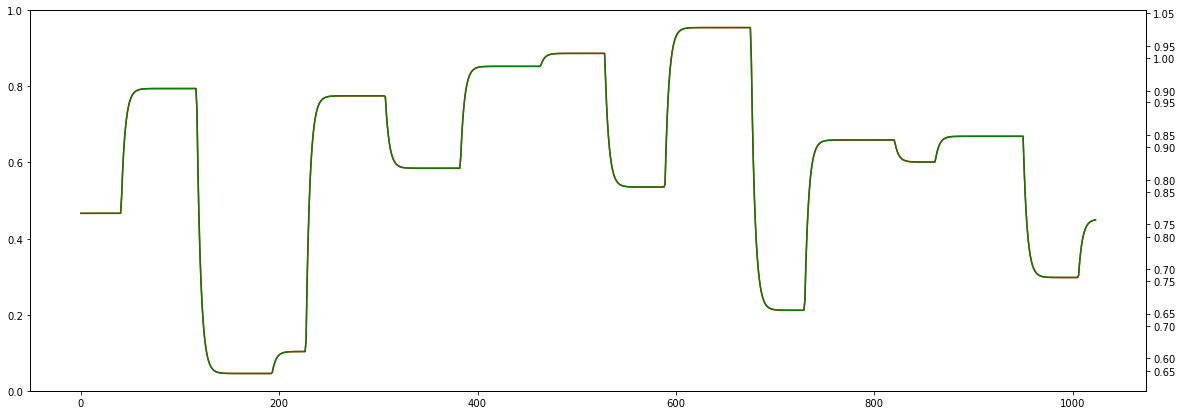

TEST AUX:


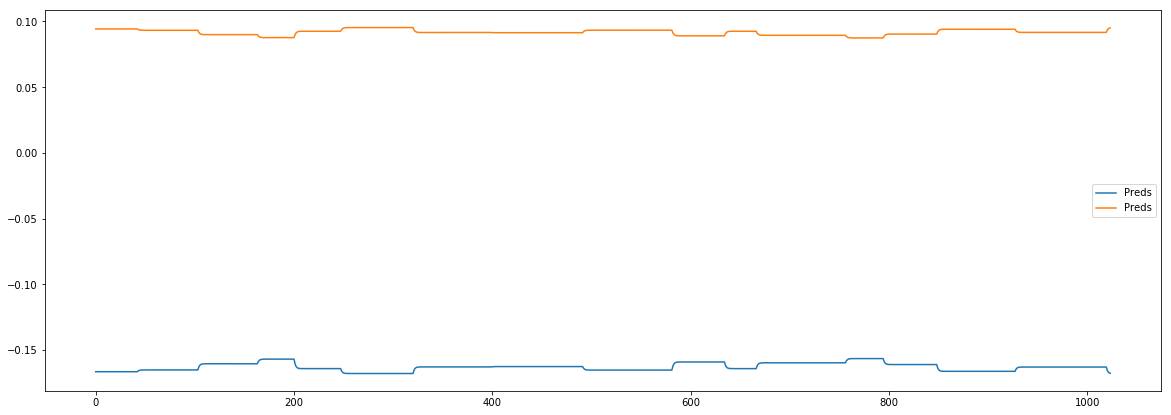

TEST PRED:


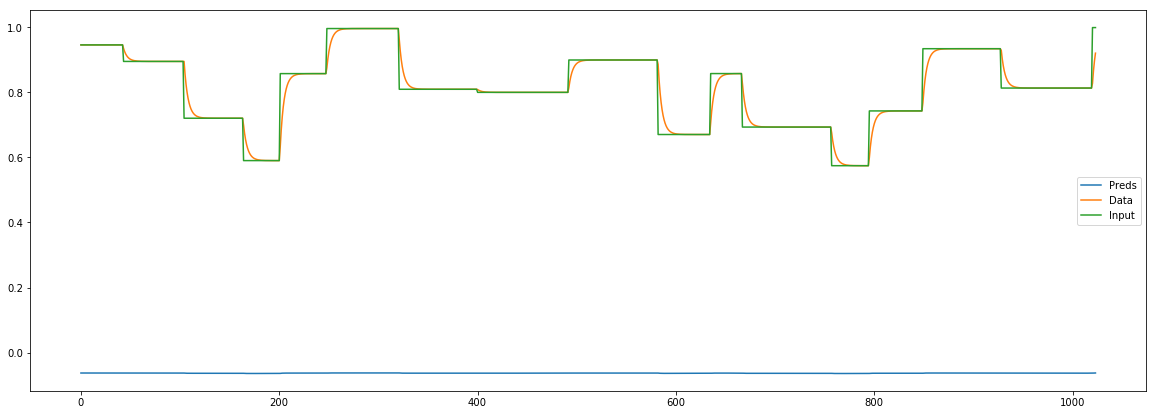

TEST RESID:


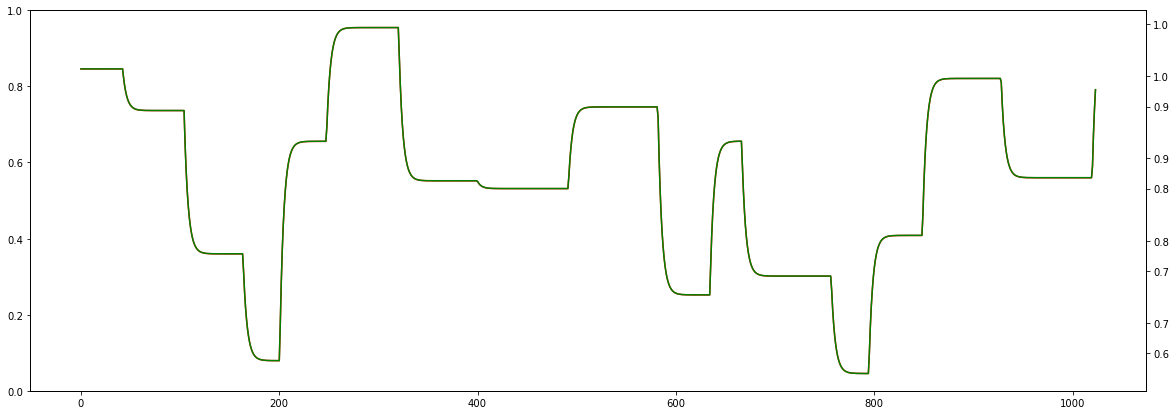

 Epoch [52]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


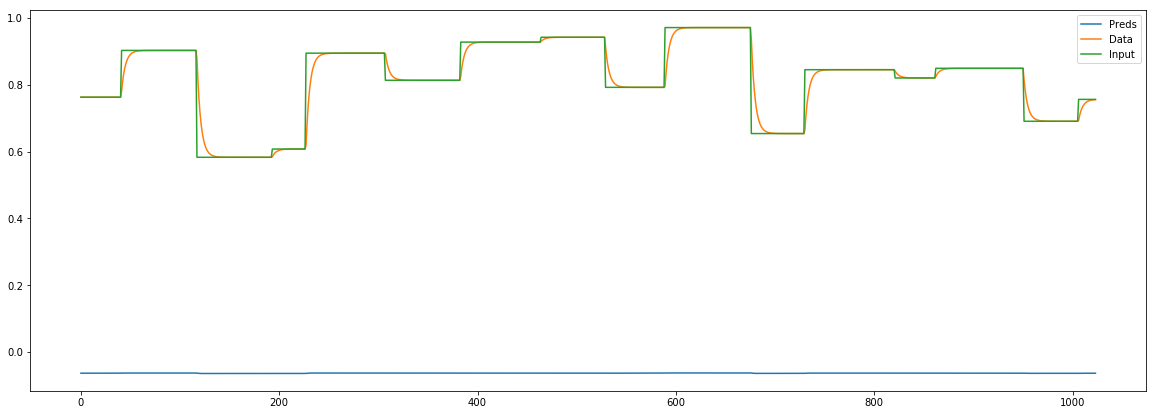

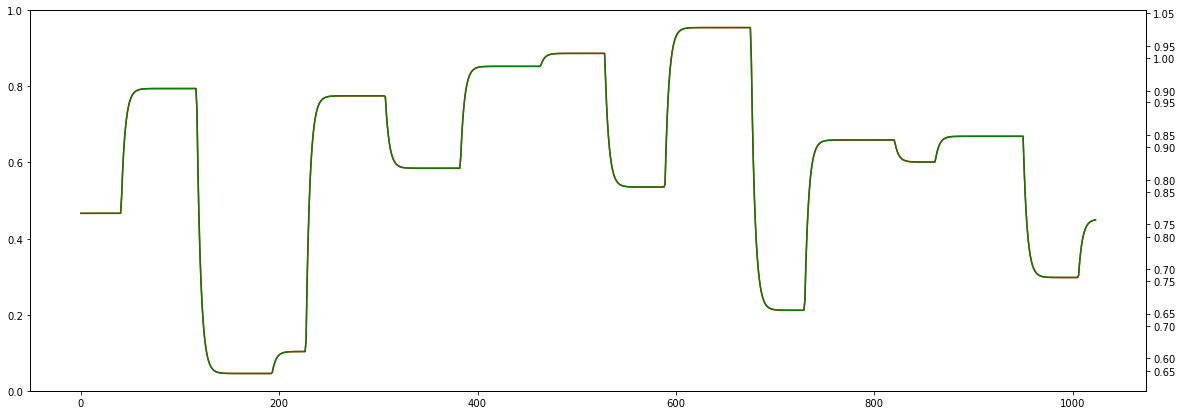

TEST AUX:


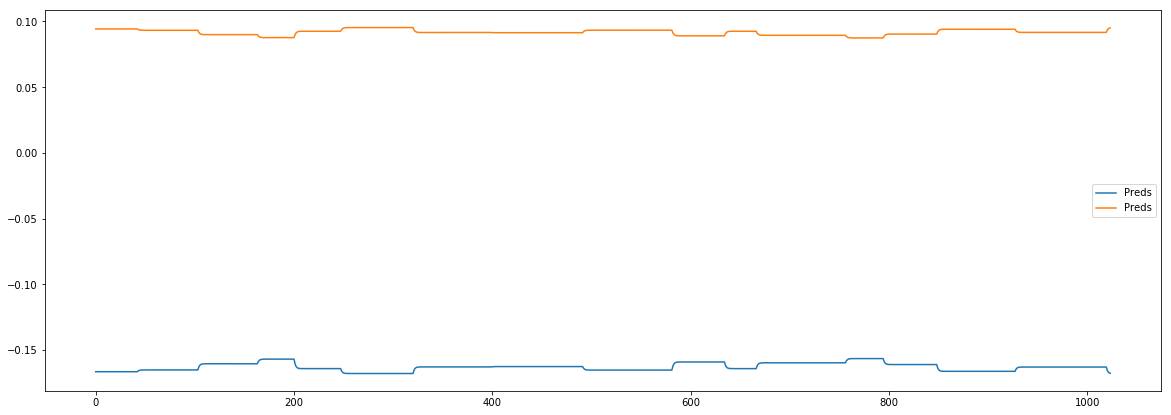

TEST PRED:


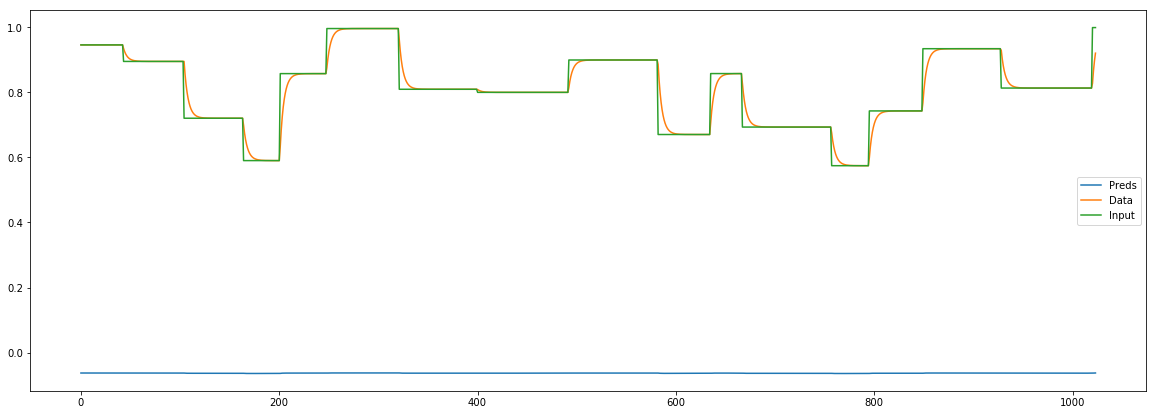

TEST RESID:


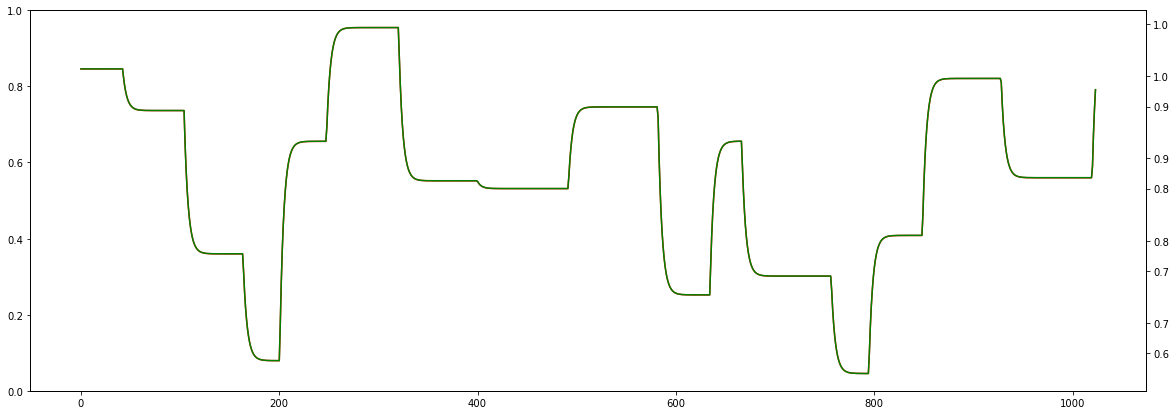

 Epoch [53]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


aux preds: -0.16318729519844055 0.09189355373382568
aux loss 100500.13686899039
combined loss 100500.13686899039


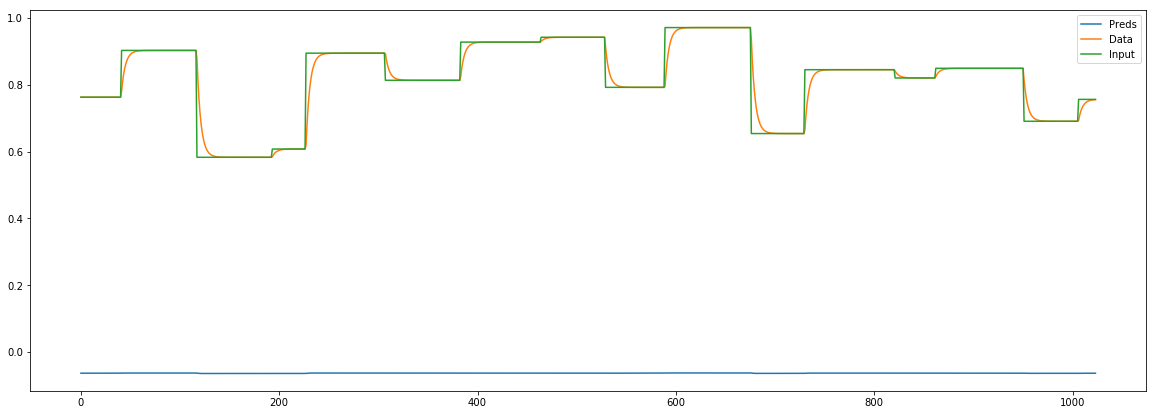

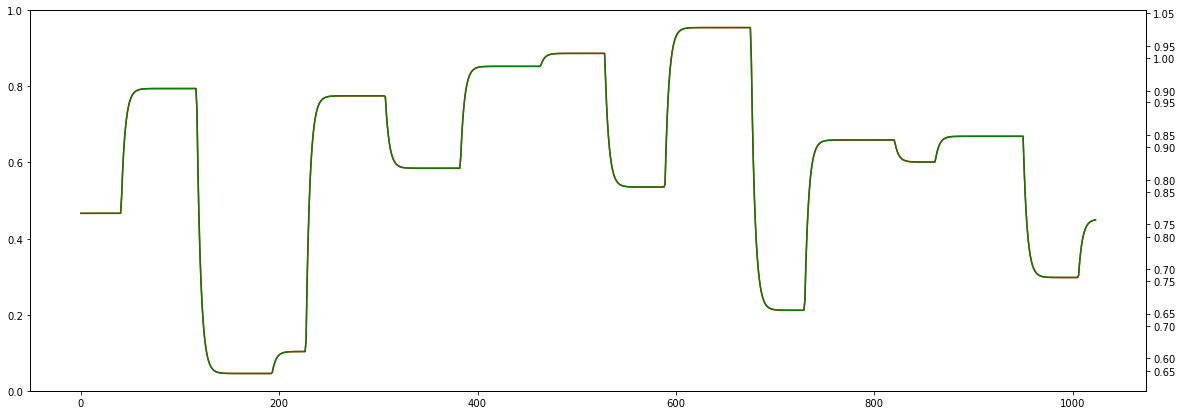

TEST AUX:


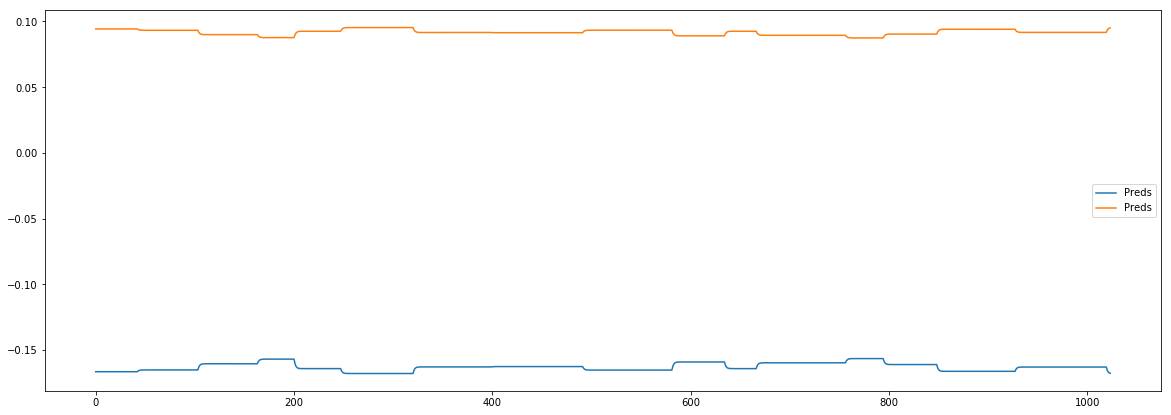

TEST PRED:


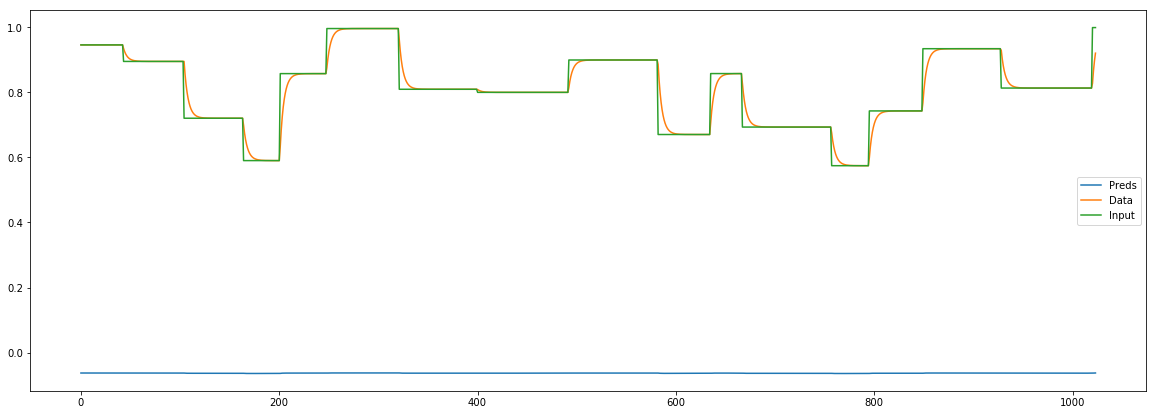

TEST RESID:


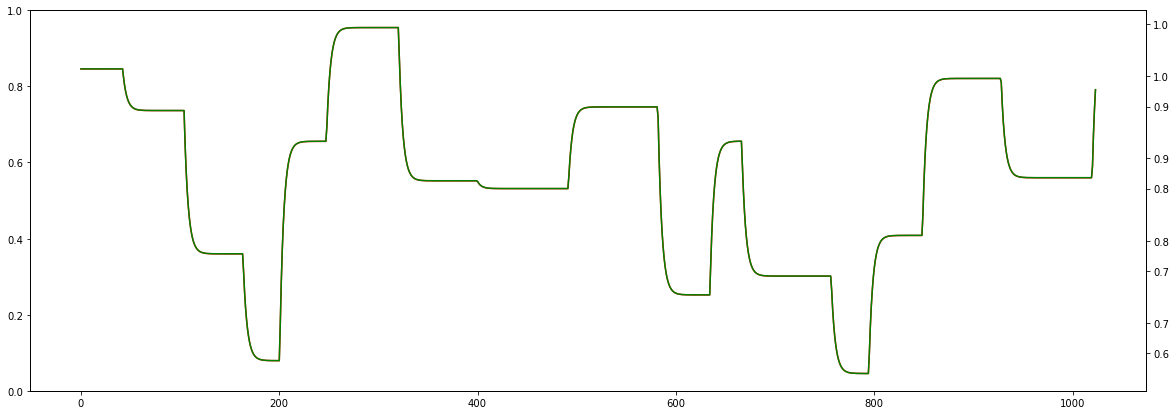

 Epoch [54]     
 train_loss[100500.13686899039]     
 eval_train[0.0]     
 eval_test[0.0] 


In [ ]:

            
model.hidden = model.init_hidden()
hist = {"train_loss":np.zeros(num_epochs), 
        "train_local_loss":np.zeros(len(train_dl)),
        "eval_train_local":np.zeros(len(train_dl)),
         "eval_test_local":np.zeros(len(test_dl)),
        "eval_train":np.zeros(num_epochs),
         "eval_test":np.zeros(num_epochs),
        
        "aux":{
            "train_loss":np.zeros(num_epochs), 
        "train_local_loss":np.zeros(len(train_dl)),
        "eval_train_local":np.zeros(len(train_dl)),
         "eval_test_local":np.zeros(len(test_dl)),
        "eval_train":np.zeros(num_epochs),
         "eval_test":np.zeros(num_epochs),
        },
        
        "const":{
            "train_loss":np.zeros(num_epochs), 
        "train_local_loss":np.zeros(len(train_dl)),
        "eval_train_local":np.zeros(len(train_dl)),
         "eval_test_local":np.zeros(len(test_dl)),
        "eval_train":np.zeros(num_epochs),
         "eval_test":np.zeros(num_epochs),
        },
        'preds':{
            '1':np.zeros(num_epochs),
            '2':np.zeros(num_epochs),
            
        }
        
       }
inits = []
for k in range(20):
    model = LSTM(lstm_input_size,
             p_net['hidden_size'],
             batch_size=p_train['batch_size'],
             output_dim=p_net['output_dim'],
             num_layers=p_net['num_layers'])

    for t in range(num_epochs):
         # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful


        for i, data in enumerate(tqdm(train_dl)):
            x_batch, y_batch, indexes = data
            x_batch.transpose_(0, 1)
            model.hidden = model.init_hidden()



        # Forward pass
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch, x_batch, config)
            main_loss, aux_loss, const_loss = loss
    #             if t == 0:
    #                 try:
    #                     combined_loss += aux_loss # don't use const here
    #                 except:
    #                     combined_loss = aux_loss
    #             else:       
            combined_loss = main_loss + aux_loss + const_loss
    #         print(loss.shape)
            hist['train_local_loss'][i] = combined_loss.item()
            hist['const']['train_local_loss'][i] = const_loss.item()
            hist['aux']['train_local_loss'][i] = aux_loss.item() #torch.mean(torch.abs(y_pred[:, 1] - a))
            # Zero out gradient, else they will accumulate between epochs
    #             if t != 0:
            optimiser.zero_grad()

            # Backward pass
            combined_loss.backward()

            # Update parameters
            optimiser.step()
    #         if t == 0:
    #             optimiser.zero_grad()

    #             # Backward pass
    #             combined_loss.backward()

    #             # Update parameters
    #             optimiser.step()

    #     print(y_pred.shape)
        hist['preds']['1'][t] =torch.mean(y_pred[:, 1]) 
        hist['preds']['2'][t] =torch.mean(y_pred[:, 2]) 



        print(f"aux preds: {torch.mean(y_pred[:, 1])} {torch.mean(y_pred[:, 2])}")
        print(f"aux loss {np.average(hist['aux']['train_local_loss'])}")
        print(f"combined loss {np.average(hist['train_local_loss'])}")

        plot_shared_scale([
            (y_pred[:, 0].detach().numpy(),"Preds" ),
             (y_batch[:, 0].detach().numpy(), "Data"),
             (x_batch[-1].detach().numpy(), "Input")
            ])
        residuals = y_batch[:, 0] - y_pred[:, 0]
        plot_multiscale([
            (residuals.detach().numpy(), "Red"),
            (y_batch[:, 0].detach().numpy(), "Green")
        ]) 
        # DEBUG
        inits.append(torch.mean(y_pred[:, 1]))
        del combined_loss
        break
        # DEBUG

            # validate during evaluation
        with torch.no_grad():
            model = model.eval()
            for i, data in enumerate(tqdm(train_dl)):
                x_batch, y_batch, indexes = data
                x_batch.transpose_(0, 1)
                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch, x_batch, config)
                main_loss, aux_loss, const_loss = loss
    #             print(f"main_loss {main_loss}")
    #             print(f"aux_loss {aux_loss}")
    #             print(f"const_loss {const_loss}")

                hist['eval_train_local'][i] = main_loss.item()
                hist['const']['eval_train_local'][i] = const_loss.item()
                hist['aux']['eval_train_local'][i] = aux_loss.item()#torch.mean(torch.abs(y_pred[:, 1] - a) )
            for i, data in enumerate(tqdm(test_dl)):
                x_batch_test, y_batch_test, indexes = data
                x_batch_test.transpose_(0, 1)
                y_pred_test = model(x_batch_test)
                loss = loss_fn(y_pred_test, y_batch_test, x_batch_test, config)
                main_loss, aux_loss, const_loss = loss
                hist['const']['eval_test_local'][i] = const_loss.item()
                hist['eval_test_local'][i] = main_loss.item()
                hist['aux']['eval_test_local'][i] = aux_loss.item()#torch.mean(torch.abs(y_pred_test[:, 1] - a) )
            model = model.train()


    #     smoothed_train = []
    #     smoothed_test = []
    #     k_smooth = 1
    #     for elm in range(hist['eval_train_local'][:-k_smooth].shape[0]):
    #         smoothed_train.append(np.average(hist['eval_train_local'][elm:elm+k_smooth]))
    #     for elm in range(hist['eval_test_local'][:-k_smooth].shape[0]):
    #         smoothed_test.append(np.average(hist['eval_test_local'][elm:elm+k_smooth])) 

    #     plot_shared_scale([
    #             (smoothed_train,"Train" ),
    #              (smoothed_test, "Test")])        

        print("TEST AUX:")
        plot_shared_scale([
                (y_pred_test[:, 1].detach().numpy(),"Preds" ),

                (y_pred_test[:, 2].detach().numpy(),"Preds" ),
        ])
        print("TEST PRED:")
        plot_shared_scale([
                (y_pred_test[:, 0].detach().numpy(),"Preds" ),
                 (y_batch_test[:, 0].detach().numpy(), "Data"),
                 (x_batch_test[-1].detach().numpy(), "Input")
        ])


        residuals = y_batch_test[:, 0] - y_pred_test[:, 0]
        print("TEST RESID:")
        plot_multiscale(
                [
                    (residuals.detach().numpy(), "Red"), 
                 (y_batch_test[:, 0].detach().numpy(),"Green")
                ])
    #     plot_shared_scale( [ (hist["eval_train_local"], "train"),
    #                         (hist["eval_test_local"], "test")])
        logging.info(f"Epoch [{t}] \
        \n train_loss[{hist['train_loss'][t]}] \
        \n eval_traiDn[{hist['eval_train'][t]}] \
        \n eval_test[{hist['eval_test'][t]}] ")

        hist["train_loss"][t] = np.average(hist["train_local_loss"])
        hist["eval_train"][t] = np.average(hist["eval_train_local"])
        hist["eval_test"][t] = np.average(hist["eval_test_local"])
        hist['aux']['eval_test'][t] = np.average(hist['aux']['eval_test_local'])
        hist['aux']['eval_train'][t] = np.average(hist['aux']['eval_train_local'])
        hist['aux']['train_loss'][t] = np.average(hist['aux']['train_local_loss'])
        hist['const']['eval_test'][t] = np.average(hist['const']['eval_test_local'])
        hist['const']['eval_train'][t] = np.average(hist['const']['eval_train_local'])
        hist['const']['train_loss'][t] = np.average(hist['const']['train_local_loss'])

    #     hist["aux_error"][t] = np.average[]
        print(f" Epoch [{t}] \
        \n train_loss[{hist['train_loss'][t]}] \
        \n eval_train[{hist['eval_train'][t]}] \
        \n eval_test[{hist['eval_test'][t]}] ")
        logging.info(f" Epoch [{t}] \
        \n train_loss[{hist['train_loss'][t]}] \
        \n eval_train[{hist['eval_train'][t]}] \
        \n eval_test[{hist['eval_test'][t]}] ")

In [ ]:
plt.plot(inits)

In [ ]:
sum(np.array(inits)>0)

In [ ]:
s, e = 0, -1
plot_shared_scale([
    (hist['train_loss'][s:e],"Train" ),
             (hist['eval_train'][s:e], "Eval_train"),
             (hist['eval_test'][s:e], "Eval_test"),
                  (hist['aux']['train_loss'][s:e], "aux_train"),
                  (hist['aux']['eval_train'][s:e], "aux_Eval_train"),
                  (hist['aux']['eval_test'][s:e], "aux_Eval_test")
])

In [ ]:
s, e = 5, -1
plot_shared_scale([
    (hist['train_loss'][s:e],"Train" ),
             (hist['eval_train'][s:e], "Eval_train"),
             (hist['eval_test'][s:e], "Eval_test"),
#                   (hist['aux']['train_loss'][s:e], "aux_train"),
#                   (hist['aux']['eval_train'][s:e], "aux_Eval_train"),
#                   (hist['aux']['eval_test'][s:e], "aux_Eval_test")
])

In [ ]:
s, e = 20, -1
plot_shared_scale([
#     (hist['train_loss'][s:e],"Train" ),
#              (hist['eval_train'][s:e], "Eval_train"),
#              (hist['eval_test'][s:e], "Eval_test"),
                  (hist['aux']['train_loss'][s:e], "aux_train"),
                  (hist['aux']['eval_train'][s:e], "aux_Eval_train"),
                  (hist['aux']['eval_test'][s:e], "aux_Eval_test")])

In [ ]:
s, e = 0, -1
plot_shared_scale([
#     (hist['train_loss'][s:e],"Train" ),
#              (hist['eval_train'][s:e], "Eval_train"),
#              (hist['eval_test'][s:e], "Eval_test"),
                  (hist['const']['train_loss'][s:e], "const_aux_train"),
                  (hist['const']['eval_train'][s:e], "const_aux_Eval_train"),
                  (hist['const']['eval_test'][s:e], "const_aux_Eval_test")])

In [ ]:
s, e = 0, -1
plot_shared_scale([
#     (hist['train_loss'][s:e],"Train" ),
#              (hist['eval_train'][s:e], "Eval_train"),
#              (hist['eval_test'][s:e], "Eval_test"),
                  (hist['preds']['1'][s:e], "p1"),
                  (hist['preds']['2'][s:e], "p2"),
#                   (hist['const']['eval_test'][s:e], "const_aux_Eval_test")
])

In [ ]:
model.buffers

In [ ]:
logging.info("Training process END")

In [ ]:
#

In [ ]:

        # DEBUG
        outputs = y_batch
        labels = y_batch
#         par_1 = y_batch
        is_normalized = p_data['need_normalize']
        batch_size = outputs.size()[0]  

        if is_normalized:
            x_norm = config['x_norm']
            y_norm = config['y_norm']
            labels_denorm = labels * y_norm[0]
            x_batch_denorm = x_batch * x_norm[0]
            outputs_denorm = outputs * y_norm[0]

        if is_debug:
            if is_normalized:
                y_k_m1 = labels_denorm[:, 0].narrow(0, 0, batch_size - 1).view((batch_size - 1, -1))
            else:
                y_k_m1 = labels[:, 0].narrow(0, 0, batch_size - 1).view((batch_size - 1, -1))
        else:
            if is_normalized:
                y_k_m1 = labels_denorm[:, 0].narrow(0,0,batch_size-1).view((batch_size-1, -1))
            else:
                y_k_m1 = labels[:, 0].narrow(0,0,batch_size-1).view((batch_size-1, -1))
        if is_normalized:
            v_a = x_batch_denorm[-1].narrow(0, 1, batch_size - 1)
            par_1 = outputs_denorm[:, 1].narrow(0,0,batch_size-1).view((batch_size-1, -1))
            par_2 = outputs_denorm[:, 2].narrow(0,0,batch_size-1).view((batch_size-1, -1))
        else:
            v_a = x_batch[-1].narrow(0, 1, batch_size - 1)
            par_1 = outputs[:, 1].narrow(0, 0, batch_size - 1).view((batch_size - 1, -1))
            par_2 = outputs[:, 2].narrow(0, 0, batch_size - 1).view((batch_size - 1, -1))

        errors = []
        vals = []
        errors = np.zeros((100,100))
        for i, par2_val_sub in enumerate(tqdm(range(-50, 50, 1))):
            par2_val_sub /= 20
            par_2 *= 0
            par_2 += par2_val_sub
            for j, par1_val_sub in enumerate(range(-50, 50, 1)):
                par1_val_sub /= 20
                par_1 *= 0
                par_1 += par1_val_sub
                
                y_k, dy_predicted, d_i_dt, i_k, e_k_m1 = y_k_from_y_k_m1(y_k_m1=y_k_m1,
                                                                         v_a=v_a,
                                                                         par1=par_1,
                                                                         par2=par_2,
                                                                         config=config
                                                                         )
                if is_normalized:
                    dy_observed = labels_denorm[:, 0].narrow(0, 1, batch_size - 1) - labels_denorm[:, 0].narrow(0, 0, batch_size - 1)
                else:
                    dy_observed = labels[:, 0].narrow(0, 1, batch_size - 1) - labels[:, 0].narrow(0, 0, batch_size - 1)

                dy_observed = dy_observed.view((batch_size - 1, -1))
                aux_residuals = dy_predicted - dy_observed
#                 print(dy_predicted.shape)
#                 print(dy_observed.shape)
#                 print(aux_residuals.shape)
# #                 print("compare dY")
#                 plt.plot(dy_observed.detach().numpy(), label = 'obs')
#                 plt.plot(dy_predicted.detach().numpy(), label = 'pred')
#                 plt.plot(aux_residuals.detach().numpy(), label = 'resid')
#                 plt.legend()
#                 plt.show()
                error_aux = torch.sum(torch.abs(aux_residuals))
#                 print(f"error_aux {error_aux} val1[{par1_val_sub}] val2[{par2_val_sub}]")
                errors[i][j] = error_aux
        print("dependance")
        plt.plot(errors)
        plt.show()
        while(True):
            pass
        # /DEBUGG